In [1]:
lab_enc = True
ohe = True
new_features = True
hp_tune = False
balance_train = False
add_tags = True
tfidf_title = False

In [2]:
tags = []

## Column Names and Description

In [602]:
"""
Columns
The following columns are available on the training set:

accepts_mercadopago Whether the item accepts Mercado Pago
available_quantity The available stock quantity at that moment
avg_asp_item_bday Average selling price of this item over the last days
avg_asp_item_domain Average price of items of the domain this item belongs to
avg_asp_item_sel Average price of seller sales
avg_gmv_item_bday average revenue generated by the item per day
avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
avg_gmv_item_sel Average revenue of items of this seller
avg_gmv_seller_bday Average revenue this seller makes by day
avg_orders_item_bday Average number of orders this item has by day
avg_orders_seller_bday Average orders the seller has by day
avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days
avg_si_item_bday Average units sold this item has by day
avg_si_item_sel_30day Average units sold of an item of this seller on the past month
avg_visits_item Average visits this item had
benefit Ignore, should be dropped
boosted Whether the item was boosted
buy_server_timestamp Timestamp of the purchase
category_id Category of this item
conversion Target variable, it is True if this print has an attributed order
cus_cust_id Buyer id
cus_cust_id_sel Seller id
date Print date
deal_print_id Unique id for the print
decimals Ignore, will be dropped
domain_id Domain id for the item
etl_version Ignore, should be dropped
free_shipping Whether the item has free shipping
fulfillment Whether the item is fulfilled by MeLi
full_name Category full name
health Item health
is_pdp Whether the click landed on a PDP
product_id Product_id of the item
item_id ID of the item, useful for debugging
listing_type_id Whether the item is gold or not
logistic_type Logistic type for the item
main_picture URL for the main item picture
offset On which page the item was rendered
original_price Price from which the discount was done
platform Which platform the user is using
price Item price
print_position Position on the page
print_server_timestamp Timestamp for the print
qty_items_dom Number of items this domain has
qty_items_sel Number of items the seller has
rn Leftover from the ETL, Discard
ROW_ID Row of the submission file
site_id Site ID
sold_quantity Number of items sold at the moment of the print
tags Tags the item had at the moment of the print
title Item title
total_asp_item_domain_30days Average selling price of the items of the domain
total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days
total_gmv_domain_30days Total revenue the domain made on the last 30 days
total_gmv_domain_bday total_gmv_domain_30days / 30
total_gmv_item_30days Total revenue made by the item on the lasts 30 days
total_gmv_seller Total revenue made by the seller on the last month
total_items_domain Number of items on the domain
total_items_seller Number of items the seller has
total_orders_domain_30days Total orders on the domain
total_orders_item_30days Total orders the Item had on the last 30 days
total_orders_sel_30days Total orders for the seller
total_si_domain_30days Total units sold of this domain
total_si_item_30days Total units sold of this item
total_si_sel_30days Same for the seller
total_visits_domain Total visits on this domain
total_visits_item Total visits this item had
total_visits_seller Total visits for this seller
uid session id
user_id user id
warranty Whether the item had warranty
"""

'\nColumns\nThe following columns are available on the training set:\n\naccepts_mercadopago Whether the item accepts Mercado Pago\navailable_quantity The available stock quantity at that moment\navg_asp_item_bday Average selling price of this item over the last days\navg_asp_item_domain Average price of items of the domain this item belongs to\navg_asp_item_sel Average price of seller sales\navg_gmv_item_bday average revenue generated by the item per day\navg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month\navg_gmv_item_sel Average revenue of items of this seller\navg_gmv_seller_bday Average revenue this seller makes by day\navg_orders_item_bday Average number of orders this item has by day\navg_orders_seller_bday Average orders the seller has by day\navg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month\navg_qty_orders_item_sel_30days Average number of orders an item of this seller 

## Librerias

In [3]:
from IPython.display import display, Markdown

import pandas as pd

import gc

import os

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, OneHotEncoder

from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier, BaggingClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score,  roc_curve, auc, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt

import itertools

from tqdm import tqdm

import re

from datetime import datetime

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/nacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nacho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Funciones

In [4]:
def plot_roc_curves(models, model_names, X_test, y_test, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    for i in range(len(models)):
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(X_test)[:, models[i].classes_ == 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=model_names[i] + ' (area = %0.5f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([-0.05, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('Receiver operating characteristic example')

    # Show grid
    plt.grid(True)

    plt.legend(loc="lower right")

    plt.show()

In [5]:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

## Load Comp Data

In [6]:
comp_data = pd.read_csv("data/competition_data.csv")

In [607]:
comp_data.head()

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses,NaN
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días,NaN
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días,NaN


In [608]:
comp_data.describe()

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,conversion,health,...,total_orders_item_30days,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,user_id,ROW_ID
count,199972.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,199971.000000,180761.000000,199972.000000,...,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,1.999720e+05,199972.000000,1.999720e+05,1.783750e+05,19211.000000
mean,2142.683766,333.141264,1160.099822,10815.338962,4.385187,13.542561,18.286236,0.000976,0.092631,0.809401,...,65.176297,3941.158614,29197.693135,88.487667,5238.731257,2.170257e+06,5571.603790,2.542803e+05,2.246094e+08,9605.000000
std,11326.386712,492.836951,4284.246365,26377.753704,2.768258,25.645743,33.648431,0.000154,0.289915,0.146368,...,129.610777,5145.727129,49694.994203,220.606860,6809.183739,3.545316e+06,12108.897095,3.458552e+05,1.474232e+08,5545.882346
min,0.000000,4.909057,4.773333,0.660000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,4.000000,1.000000,2.000000,3.160000e+02,1.000000,1.100000e+01,1.610000e+02,0.000000
25%,19.000000,86.729688,143.184865,793.281667,2.876796,4.188679,4.916896,0.001000,0.000000,0.770000,...,6.000000,718.000000,3938.000000,7.000000,943.000000,1.899680e+05,407.000000,4.804600e+04,1.053200e+08,4802.500000
50%,67.000000,169.234106,262.266733,2733.067000,3.639912,6.768293,8.875000,0.001000,0.000000,0.810000,...,20.000000,2102.000000,11660.000000,24.000000,2713.000000,5.613990e+05,1496.000000,1.263900e+05,1.976426e+08,9605.000000
75%,371.000000,319.281502,675.989333,9217.855667,5.066384,13.403873,18.558559,0.001000,0.000000,0.900000,...,63.000000,5017.000000,38725.000000,80.000000,6455.000000,2.007145e+06,5248.000000,2.817150e+05,3.202613e+08,14407.500000
max,99999.000000,3778.257881,57282.961233,244988.442667,38.148629,258.363636,465.500000,0.001000,1.000000,1.000000,...,1853.000000,36492.000000,505258.000000,8269.000000,56189.000000,1.591114e+07,195413.000000,2.938795e+06,1.000014e+09,19210.000000


In [609]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **accepts_mercadopago**
- **available_quantity**
- **avg_gmv_item_domain_30days**
- **avg_gmv_item_sel**
- **avg_gmv_seller_bday**
- **avg_qty_orders_item_domain_30days**
- **avg_qty_orders_item_sel_30days**
- **avg_si_item_sel_30day**
- **benefit**
- **boosted**
- **category_id**
- **conversion**
- **date**
- **deal_print_id**
- **domain_id**
- **etl_version**
- **free_shipping**
- **fulfillment**
- **full_name**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **main_picture**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **print_server_timestamp**
- **qty_items_dom**
- **qty_items_sel**
- **site_id**
- **sold_quantity**
- **tags**
- **title**
- **total_asp_item_domain_30days**
- **total_asp_item_sel_30days**
- **total_gmv_domain_bday**
- **total_gmv_item_30days**
- **total_items_domain**
- **total_items_seller**
- **total_orders_domain_30days**
- **total_orders_item_30days**
- **total_orders_sel_30days**
- **total_si_domain_30days**
- **total_si_item_30days**
- **total_si_sel_30days**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **uid**
- **user_id**
- **warranty**
- **ROW_ID**

## Data Cleaning

In [7]:
#comp_data = pd.read_csv("data/competition_data.csv")
comp_data = comp_data.drop(
        columns=[
            "accepts_mercadopago", # Todos tienen mercadopago
            "boosted", # Ninguno
            "avg_qty_orders_item_domain_30days",
            "avg_qty_orders_item_sel_30days",
            "avg_si_item_sel_30day",
            #"date",
            "deal_print_id",
            "etl_version",
            "full_name",
            "main_picture",
            "print_server_timestamp",
            #"title",
            "uid",
            #"user_id",
            "avg_gmv_item_domain_30days",
            #"avg_gmv_item_sel",
            "avg_gmv_seller_bday",
            #"qty_items_dom",
            #"category_id",
            #"domain_id",
            #"product_id",
            #"listing_type_id",
            # "logistic_type",
            "site_id",
            #"tags",
            "total_asp_item_sel_30days", 
            "total_gmv_domain_bday", 
            #"total_items_domain", 
            "total_items_seller", 
            "total_orders_domain_30days", 
            "total_orders_item_30days", 
            "total_orders_sel_30days", 
            "total_si_sel_30days", 
            #"total_visits_domain", 
            #"total_visits_item", 
            #"total_visits_seller",
            "total_asp_item_domain_30days",
            "total_gmv_item_30days",
            "total_si_domain_30days",
            "total_si_item_30days",
            "warranty",
            # "offset",
        ]
    )

In [8]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **category_id**
- **conversion**
- **date**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **tags**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**

In [9]:
if add_tags:
    if len(tags) == 0:
        #tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(pd.Series).stack().value_counts()
        # more efficient
        tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").explode().value_counts()

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_96676/2256042058.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").explode().value_counts()


In [613]:
# tags

In [10]:
# # For tag in tags, create a new column with the tag name and a boolean value

if add_tags:
    for tag in tags.index:
        comp_data[tag] = comp_data["tags"].str.contains(tag).astype(int)

    comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)

    comp_data = comp_data.drop("tags", axis=1)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_96676/3302296570.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)


In [615]:
# comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
# comp_data["product_id"] = LabelEncoder().fit_transform(comp_data["product_id"]).astype(int)

# OneHotEncoder
# comp_data = pd.get_dummies(comp_data, columns=["category_id"], dtype=int, sparse=True, dummy_na = False)
# Add category_id ohe category column if that category has more than 1000 ocurrences
# ocurrences = comp_data["category_id"].value_counts()
# for category_id in ocurrences[ocurrences > 1000].index:
#     comp_data["category_id_" + str(category_id)] = comp_data["category_id"] == category_id
#     comp_data["category_id_" + str(category_id)] = comp_data["category_id_" + str(category_id)].astype(int)
# comp_data = comp_data.drop(columns=["category_id"])

# comp_data = pd.get_dummies(comp_data, columns=["logistic_type"], dtype=int, sparse=True, dummy_na = False)

In [11]:
comp_data["date"] = pd.to_datetime(comp_data["date"])
comp_data["day"] = comp_data["date"].dt.day
comp_data["month"] = comp_data["date"].dt.month
#comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["year"] = comp_data["date"].dt.year
comp_data["dayofweek"] = comp_data["date"].dt.dayofweek
# comp_data["weekofyear"] = comp_data["date"].dt.isocalendar().week
#comp_data["quarter"] = comp_data["date"].dt.quarter
# comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["minute"] = comp_data["date"].dt.minute


In [12]:
comp_data["date"].min(), comp_data["date"].max()

(Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-25 00:00:00'))

In [618]:
comp_data = comp_data.drop(columns=["date"])

### Parse boolean columns

In [13]:
# comp_data["boosted"] = comp_data["boosted"].astype(int)
comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

comp_data["imp_is_pdp"] = comp_data["is_pdp"].isna().astype(int)
comp_data["is_pdp"].fillna(0, inplace=True)
comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)

comp_data["imp_user_id"] = comp_data["user_id"].isna().astype(int)
comp_data["user_id"].fillna(0, inplace=True)
comp_data["user_id"] = comp_data["user_id"].astype(int)

comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

### Encoding

In [14]:
if lab_enc:
    # LabelEncoder
    comp_data["platform"] = LabelEncoder().fit_transform(comp_data["platform"]).astype(int)
    #comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    comp_data["product_id"] = LabelEncoder().fit_transform(comp_data["product_id"]).astype(int)
    comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["logistic_type"] = LabelEncoder().fit_transform(comp_data["logistic_type"]).astype(int)

if ohe:
    # OHE

    cats =  comp_data["category_id"].value_counts().index
    top_cats = comp_data["category_id"].value_counts().index[:10]

    comp_data = pd.get_dummies(comp_data,
                            columns = [
                                #"platform",
                                #"logistic_type",
                                "category_id",
                                # "domain_id"
                                ],
                            sparse = True,    # Devolver una matriz rala.
                            dummy_na = False, # No agregar columna para NaNs.
                            dtype = int       # XGBoost no trabaja con 'object'; necesitamos que sean numéricos.
                        )
    
    # drop category_id columns that are not in top_cats
    for cat in cats:
        if cat not in top_cats:
            comp_data = comp_data.drop(columns=["category_id_" + str(cat)])

# Encode category_id as a number, but number is based on ocurrences of category_id
# ! Has data leakage
# ocurrences = comp_data["category_id"].value_counts()
# for category_id in ocurrences.index:
#     comp_data["category_id"] = comp_data["category_id"].replace(category_id, ocurrences[category_id] / len(comp_data))
# 
# comp_data["category_id"] = comp_data["category_id"].apply(lambda x: ocurrences[x])

# set category_id as frequency encoding
# ! Has data leakage
#comp_data["category_id"] = comp_data["category_id"].map(comp_data["category_id"].value_counts(normalize=True))

### New columns

In [15]:
if new_features:
    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    comp_data["discount"] = (comp_data["original_price"] - comp_data["price"]) / comp_data["original_price"]
    comp_data["discount"] = comp_data["discount"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["price_ratio"] = comp_data["price"] / comp_data["original_price"]
    comp_data["price_ratio"] = comp_data["price_ratio"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_discount"] = comp_data["discount"].apply(lambda x: 1 if x > 0 else 0)

    comp_data["title_length"] = comp_data["title"].str.len()
    comp_data["title_word_count"] = comp_data["title"].str.split(" ").apply(len)

    comp_data["title_length_word_count"] = comp_data["title_length"] / comp_data["title_word_count"]
    comp_data["title_length_word_count"] = comp_data["title_length_word_count"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["domain_dominance"] = comp_data["sold_quantity"] / comp_data["qty_items_dom"]

    comp_data["is_pdp_tvi"] = comp_data["is_pdp"] / comp_data["total_visits_item"]
    comp_data["is_pdp_tvi"] = comp_data["is_pdp_tvi"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvs"] = comp_data["is_pdp"] / comp_data["total_visits_seller"]
    comp_data["is_pdp_tvs"] = comp_data["is_pdp_tvs"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvd"] = comp_data["is_pdp"] / comp_data["total_visits_domain"]
    comp_data["is_pdp_tvd"] = comp_data["is_pdp_tvd"].apply(lambda x: 1 if x == np.inf else x)


In [16]:
# comp_data = comp_data.dropna(subset=["avg_gmv_item_sel"])

# Fil nas for ["avg_gmv_item_sel", "qty_items_dom", "qty_items_sel", "domain_dominance"]

comp_data["nan_imputed"] = comp_data["avg_gmv_item_sel"].isna().astype(int)

comp_data["avg_gmv_item_sel"] = comp_data["avg_gmv_item_sel"].fillna(comp_data["avg_gmv_item_sel"].median())
comp_data["qty_items_dom"] = comp_data["qty_items_dom"].fillna(comp_data["qty_items_dom"].median())
comp_data["qty_items_sel"] = comp_data["qty_items_sel"].fillna(comp_data["qty_items_sel"].median())
comp_data["domain_dominance"] = comp_data["domain_dominance"].fillna(comp_data["domain_dominance"].median())

### Polynomial Features

In [17]:
# PolynomialFeatures custom

poly_attrs = ["print_position", "offset", "discount", "price", "health", "original_price"]

for x in poly_attrs:
    comp_data[x + "2"] = comp_data[x] ** 2

for (x, y) in itertools.combinations(poly_attrs, 2):
    comp_data[x + "2 + " + y + "2"] = comp_data[x] ** 2 + comp_data[y] ** 2


## Exploratory

In [624]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **conversion**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**
- **immediate_payment**
- **good_quality_picture**
- **brand_verified**
- **good_quality_thumbnail**
- **cart_eligible**
- **loyalty_discount_eligible**
- **today_promotion**
- **extended_warranty_eligible**
- **ahora-12**
- **deal_of_the_day**
- **dragged_bids_and_visits**
- **incomplete_technical_specs**
- **catalog_listing_eligible**
- **lightning_deal**
- **poor_quality_picture**
- **poor_quality_thumbnail**
- **supermarket_eligible**
- **under_infractions**
- **tags_count**
- **day**
- **month**
- **dayofweek**
- **imp_is_pdp**
- **imp_user_id**
- **category_id_MLA1002**
- **category_id_MLA1055**
- **category_id_MLA109027**
- **category_id_MLA120350**
- **category_id_MLA1652**
- **category_id_MLA3697**
- **category_id_MLA3724**
- **category_id_MLA40012**
- **category_id_MLA414251**
- **category_id_MLA5411**
- **price_diff**
- **discount**
- **price_ratio**
- **is_discount**
- **title_length**
- **title_word_count**
- **title_length_word_count**
- **domain_dominance**
- **is_pdp_tvi**
- **is_pdp_tvs**
- **is_pdp_tvd**
- **nan_imputed**
- **print_position2**
- **offset2**
- **discount2**
- **price2**
- **health2**
- **original_price2**
- **print_position2 + offset2**
- **print_position2 + discount2**
- **print_position2 + price2**
- **print_position2 + health2**
- **print_position2 + original_price2**
- **offset2 + discount2**
- **offset2 + price2**
- **offset2 + health2**
- **offset2 + original_price2**
- **discount2 + price2**
- **discount2 + health2**
- **discount2 + original_price2**
- **price2 + health2**
- **price2 + original_price2**
- **health2 + original_price2**

In [625]:
# Check this columns for variance
# accepts_mercadopago
# available_quantity
# avg_gmv_item_domain_30days
# avg_gmv_item_sel
# avg_gmv_seller_bday
# avg_qty_orders_item_domain_30days
# avg_qty_orders_item_sel_30days
# avg_si_item_sel_30day
# benefit
# boosted
# category_id
# conversion
# date
# deal_print_id
# domain_id
# etl_version
# free_shipping
# fulfillment
# full_name
# health
# is_pdp
# product_id
# item_id
# listing_type_id
# logistic_type
# main_picture
# offset
# original_price
# platform
# price
# print_position
# print_server_timestamp
# qty_items_dom
# qty_items_sel
# old_quantity
# tags
# title
# total_asp_item_domain_30days
# total_asp_item_sel_30days
# total_gmv_domain_bday
# total_gmv_item_30days
# total_items_domain
# total_items_seller
# total_orders_domain_30days
# total_orders_item_30days
# total_orders_sel_30days
# total_si_domain_30days
# total_si_item_30days
# total_si_sel_30days
# total_visits_domain
# total_visits_item
# total_visits_seller
# uid
# user_id
# warranty

# for col in comp_data.columns:
#     print()
#     print(col)
#     print(comp_data[col].value_counts().head(5))

In [626]:
# comp_data.groupby("user_id")["conversion"].sum()
# comp_data[comp_data["conversion"] == True]["user_id"].value_counts()

In [627]:
# Balance conversion
# comp_data = comp_data.drop(comp_data[comp_data["conversion"] == False].sample(frac=.5).index)

In [628]:
# comp_data["conversion"].value_counts()

### Plots

In [629]:
# sub_data = comp_data.sample(50000)

sub_data = comp_data[comp_data["conversion"] == True].sample(10000).append(comp_data[comp_data["conversion"] == False].sample(10000))

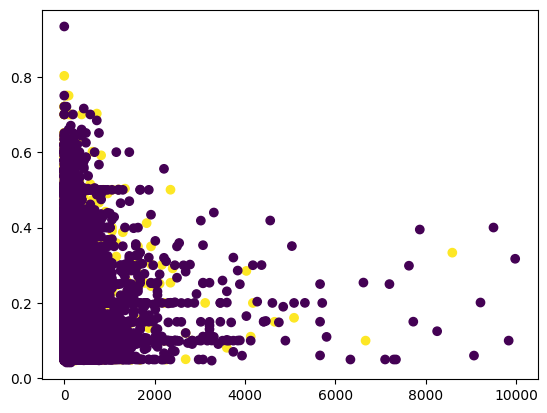

In [630]:
# Plot 'offset' vs 'category_id' . Dot color depends on 'conversion'
plt.scatter(sub_data["offset"], sub_data["discount"], c=sub_data["conversion"])

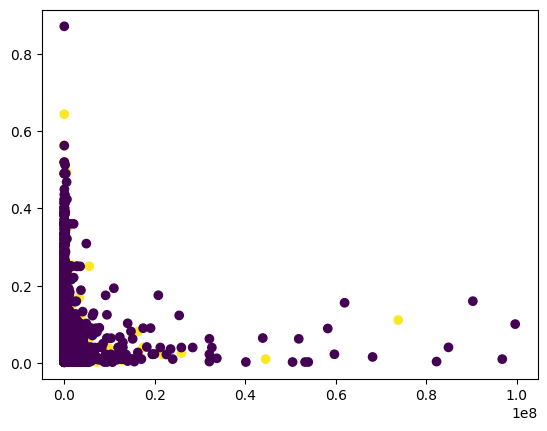

In [631]:
plt.scatter(sub_data["offset2"], sub_data["discount2"], c=sub_data["conversion"])

Text(0, 0.5, 'original_price')

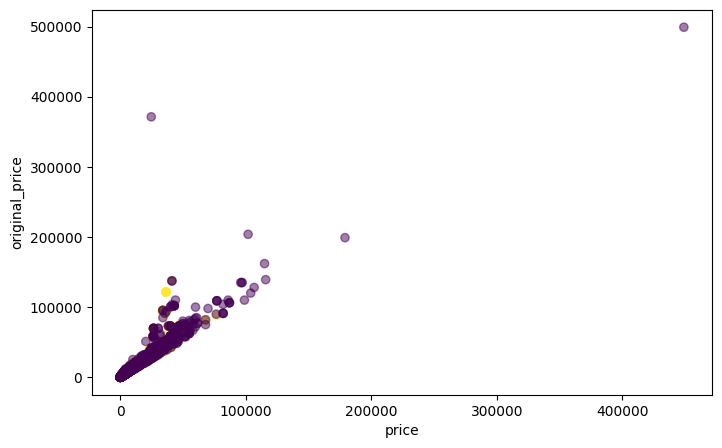

In [632]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price"], sub_data["original_price"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price")
ax.set_ylabel("original_price")

Text(0, 0.5, 'offset')

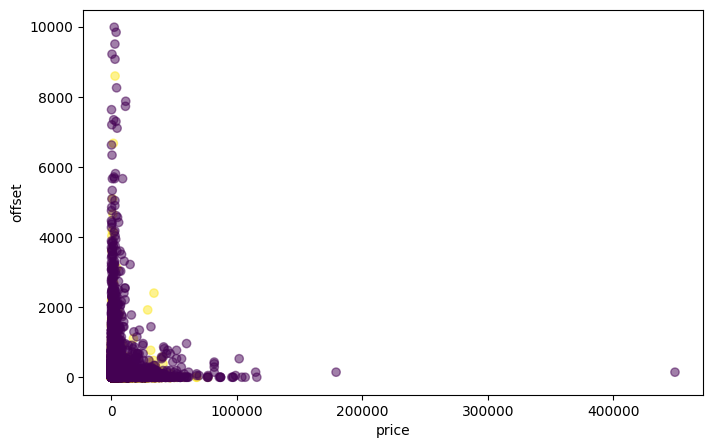

In [633]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price"], sub_data["offset"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price")
ax.set_ylabel("offset")

Text(0, 0.5, 'offset2')

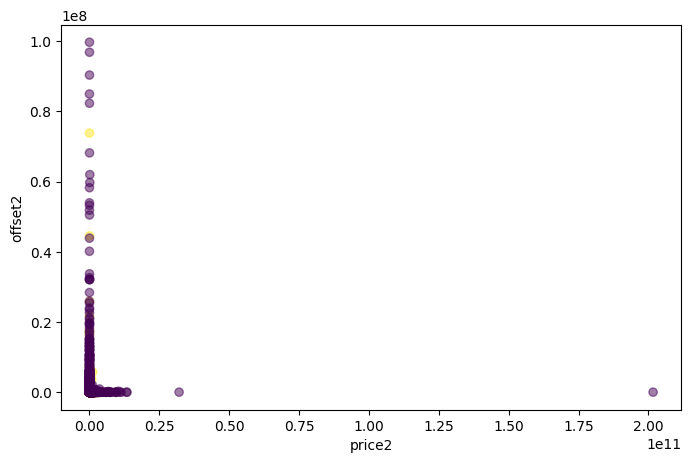

In [634]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price2"], sub_data["offset2"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price2")
ax.set_ylabel("offset2")

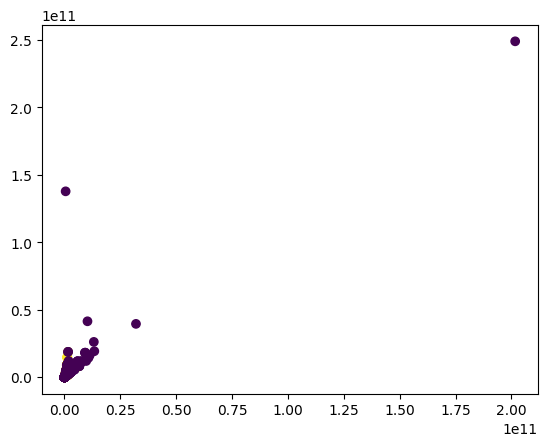

In [635]:
plt.scatter(sub_data["price2"], sub_data["original_price2"], c=sub_data["conversion"])

Text(0.5, 0, 'is_pdp')

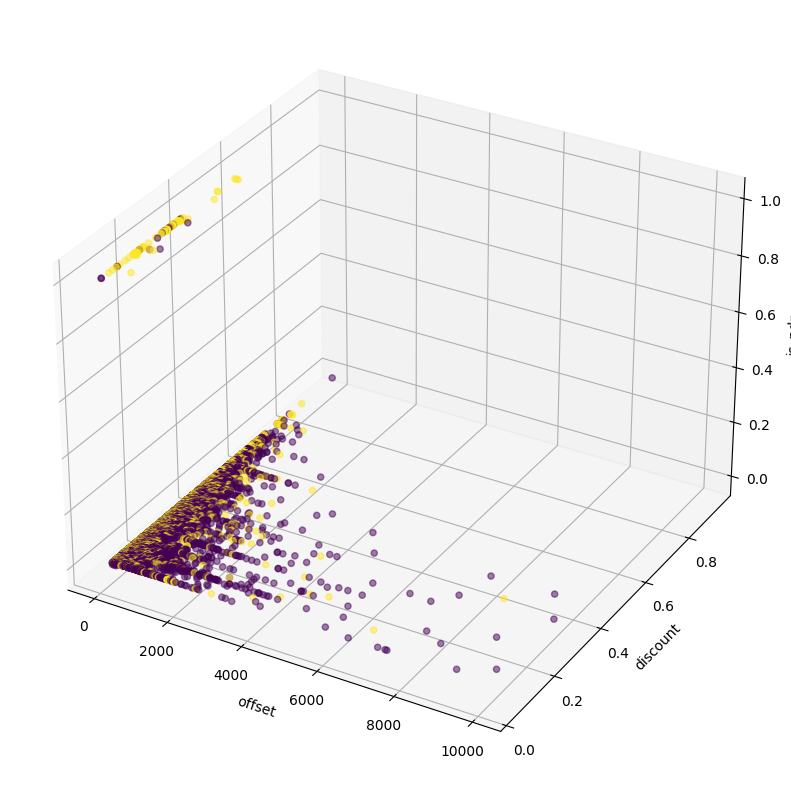

In [636]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    sub_data["offset"],
    sub_data["discount"],
    sub_data["is_pdp"],
    c=sub_data["conversion"],
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("offset")
ax.set_ylabel("discount")
ax.set_zlabel("is_pdp")


Text(0.5, 0, 'price_diff')

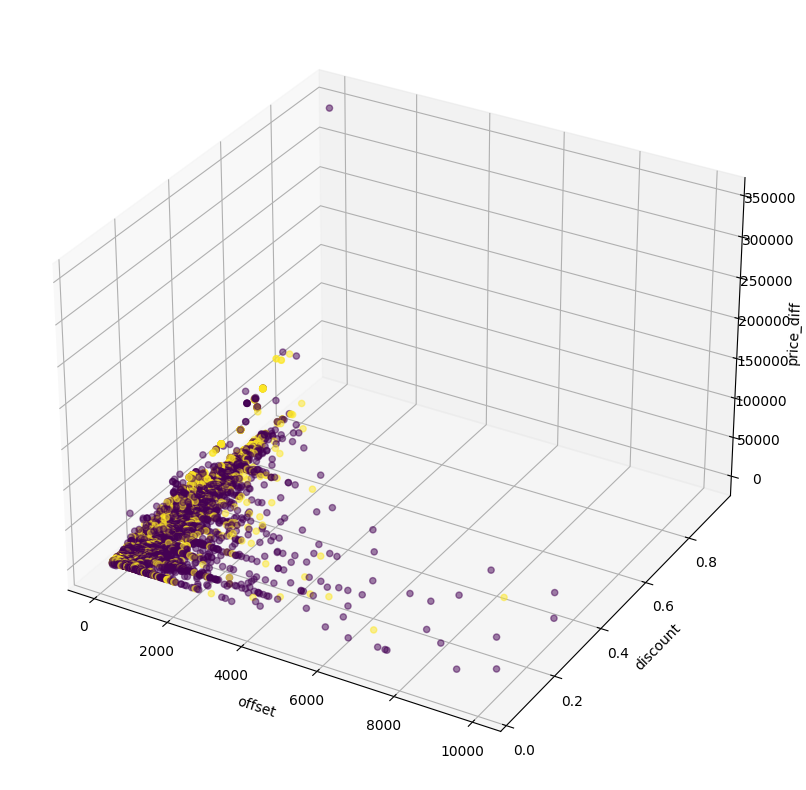

In [637]:
# Plot 'offset', 'discount', 'category_id' in 3D. Dot color depends on 'conversion'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    sub_data["offset"],
    sub_data["discount"],
    sub_data["price_diff"],
    c=sub_data["conversion"],
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("offset")
ax.set_ylabel("discount")
ax.set_zlabel("price_diff")


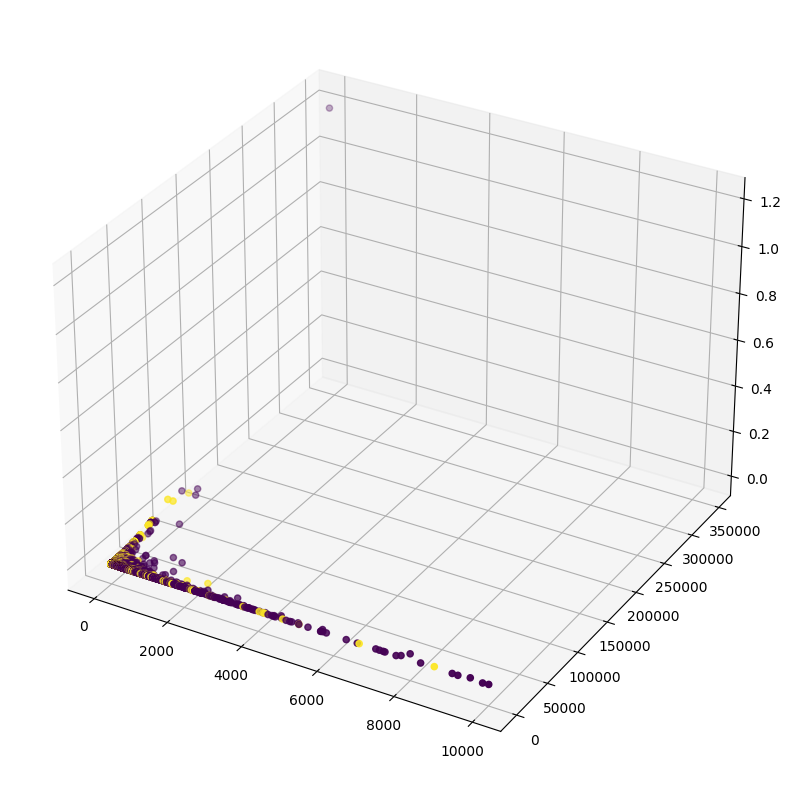

In [638]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(111)
ax.scatter(
    sub_data["offset"],
    sub_data["price_diff"],
    sub_data["offset"] ** 2 + sub_data["price_diff"]**2,
    c=sub_data["conversion"],
)

plt.show()

In [639]:
# # Plot hist boosted
# plot_data = comp_data.groupby("is_pdp")["conversion"].sum()
# plot_data


In [640]:
# Plot hour vs conversion
#comp_data.groupby("dayofweek")["conversion"].mean().plot()

## Word2Vec

In [18]:
# Word2Vec with NLTk
RETRAIN_W2C = False

comp_data["tokenized_title"] = comp_data["title"].apply(sent_tokenize)
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [word_tokenize(y) for y in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2 for y2 in y1 if re.compile("[A-Za-z]").search(y2[0])] for y1 in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2.lower() for y2 in y1] for y1 in x])
        

if RETRAIN_W2C:
        
    stop_words = set(stopwords.words('spanish'))

    w2v_model = Word2Vec(vector_size=300,
                                    window=3,
                                    min_count=5,
                                    negative=15,
                                    sample=0.01,
                                    workers=8,
                                    sg=1)
                                                                        
    w2v_model.build_vocab([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                    progress_per=10000)

    w2v_model.train([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                total_examples=w2v_model.corpus_count,
                epochs=30, report_delay=1)

    w2v_model.save("title_w2c.model")

else:
    w2v_model = Word2Vec.load("title_w2c.model")

In [19]:
# Obtención de embeddings de títulos utilizando el modelo Word2Vec
comp_data["title_embs"] = comp_data["tokenized_title"].apply(lambda x: np.mean(
    [   
        np.zeros(w2v_model.wv.vector_size) if e2 not in w2v_model.wv 
        else w2v_model.wv.get_vector(e2) if len(e2) > 0 
        else np.zeros(w2v_model.wv.vector_size) 
        for e1 in x for e2 in e1
    ],
    axis=0)
)

In [20]:
np.array(comp_data["title_embs"].tolist()).shape

(199972, 300)

In [21]:
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: x[0])

In [22]:
comp_data["tokenized_title"]

0         [motorola, one, action, gb, denim, blue, gb, ram]
1                  [zapatillas, hovr, sonic, under, armour]
2         [pantalon, mujer, vestir, elastizado, tiro, al...
3         [trencity, pista, n°3, kit, turbo, elevación, ...
4              [memoria, ram, ddr2, samsung, intel, y, amd]
                                ...                        
199967    [frasco, dispenser, vidrio, c/relieve, c/sopor...
199968    [electro, estimulador, abdominal, reductor, fi...
199969    [auricular, bluetooth, vincha, micro, sd, radi...
199970               [transformers, generations, dreadwind]
199971    [pack, x, boxer, de, niño, sin, costura, dufou...
Name: tokenized_title, Length: 199972, dtype: object

In [23]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]] = np.array(comp_data["title_embs"].tolist())

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [24]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]]

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,...,embeddings_290,embeddings_291,embeddings_292,embeddings_293,embeddings_294,embeddings_295,embeddings_296,embeddings_297,embeddings_298,embeddings_299
0,0.407256,0.346109,0.034703,0.195872,0.105712,-0.096924,-0.086645,0.763543,-0.264425,-0.250102,...,0.048355,0.202031,0.284862,0.279447,-0.106692,0.484675,-0.141178,0.164191,-0.153946,0.044015
1,0.042679,0.285040,-0.085519,0.054269,-0.436977,0.009165,-0.043031,0.918024,0.396576,-0.262409,...,-0.329382,0.585860,-0.075787,0.415753,0.589815,0.373095,0.112062,-0.196132,0.075105,-0.205592
2,-0.140189,0.221102,0.334784,0.663381,-0.193465,0.098738,0.163559,0.354226,0.279351,0.449124,...,-0.069502,-0.015078,0.180559,0.182157,0.445096,0.668092,0.144087,-0.223072,0.156411,0.269213
3,0.270412,0.124530,-0.116732,-0.203255,-0.323604,-0.048130,-0.159898,0.539274,0.206988,-0.055276,...,-0.274872,0.565224,0.358737,0.405583,0.602786,0.236667,0.317710,-0.108944,0.071862,-0.418499
4,0.177160,0.292062,-0.015661,0.067940,-0.138912,-0.243836,-0.062292,0.367834,-0.398819,-0.350346,...,-0.174848,0.222140,0.151210,0.078478,0.247092,0.196130,-0.105131,-0.139780,0.086428,-0.121699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,-0.060557,0.086833,-0.055899,0.432190,-0.289145,-0.332855,0.415789,0.651786,-0.046805,-0.163709,...,-0.339807,0.105469,0.433681,0.120821,0.088977,0.233058,0.041193,-0.284257,0.019409,-0.319288
199968,-0.022782,-0.132960,-0.091529,0.444677,-0.515899,-0.142040,0.105987,0.580728,-0.488041,0.226574,...,-0.239526,0.395446,0.367903,0.003991,0.608837,0.322964,-0.000260,-0.403646,0.192786,-0.169928
199969,-0.120085,0.523469,0.212257,0.103961,-0.145219,-0.450245,0.103901,0.687452,-0.217462,-0.370850,...,-0.104306,0.210506,0.166247,0.054639,0.178691,0.089791,0.084518,-0.169389,-0.356164,-0.158580
199970,-0.079217,0.150441,0.177942,-0.019753,-0.168739,0.015797,-0.058106,0.147978,0.160441,0.052064,...,0.177821,0.189710,0.576359,0.444357,-0.023808,0.005769,0.015664,-0.245347,0.143789,-0.290579


In [648]:
# tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',ngram_range=(1,1), sublinear_tf=True)

# if tfidf_title:
#     tfidf_title = pd.DataFrame(tfidf.fit_transform(comp_data["title"]).toarray(), columns=tfidf.get_feature_names_out())
#     comp_data = pd.concat([comp_data, tfidf_title], axis=1)
#     comp_data = comp_data.drop("title", axis=1)

## Splits

### Split Comp Data -> Full | Eval

In [25]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]
# del comp_data
gc.collect()

0

In [650]:
# df = pd.read_csv("data/competition_data.csv")
# print(df.isna().sum()[df.isna().sum() > 0])
# del df
# gc.collect()

In [26]:
# Count nan values per column

full_data.isna().sum()[full_data.isna().sum() > 0]

benefit         1
ROW_ID     180761
dtype: int64

In [652]:
# The following cols have nan values
# avg_gmv_item_sel
# qty_items_dom
# qty_items_sel
# domain_dominance depends on qty_items_dom

# For those columns, are the rows with nan values the same?

# full_data[full_data["avg_gmv_item_sel"].isna()]["qty_items_dom"].isna().sum(), full_data[full_data["avg_gmv_item_sel"].isna()]["qty_items_sel"].isna().sum(), full_data[full_data["avg_gmv_item_sel"].isna()]["domain_dominance"].isna().sum()

# Yes, they are the same rows

In [653]:
# Drop those rows

# full_data = full_data.dropna(subset=["avg_gmv_item_sel"])

In [654]:
# Count nan values per column

full_data.isna().sum()[full_data.isna().sum() > 0]

benefit         1
ROW_ID     180761
dtype: int64

### Train Test Split

In [27]:
# Shuffle
full_data = full_data.sample(frac=1, random_state=19092140).reset_index(drop=True)

train_data, test_data = train_test_split(full_data, test_size=0.2, train_size=0.8, random_state=42)

In [656]:
# train_vect = tfidf.fit_transform(train_data["title"])

In [657]:
# if tfidf_title:
#     train_df = pd.DataFrame(train_vect.toarray())
#     train_data[tfidf.get_feature_names_out()] = train_df

#     test_vect = tfidf.transform(test_data["title"])
#     test_df = pd.DataFrame(test_vect.toarray())
#     test_data[tfidf.get_feature_names_out()] = test_df

#     eval_vect = tfidf.transform(eval_data["title"])
#     eval_df = pd.DataFrame(eval_vect.toarray())
#     eval_data[tfidf.get_feature_names_out()] = eval_df

### Balancing

In [658]:
count_converts_test = test_data[test_data["conversion"] == True].shape[0]
count_not_converts_test = test_data[test_data["conversion"] == False].shape[0]
ratio = count_converts_test / count_not_converts_test

# From test_data, keep ratio of count_not_converts_test entries

not_converts = test_data[test_data["conversion"] == False].sample(frac=ratio)

new_test_data = pd.concat([test_data[test_data["conversion"] == True], not_converts])
new_test_data["conversion"].value_counts()

1.0    4189
0.0    4189
Name: conversion, dtype: int64

In [659]:
# Balance Train Data by conversion

len(train_data[train_data["conversion"] == False])

123015

In [660]:
# if NaN in conversion, drop those rows
train_data = train_data.dropna(subset=["conversion"])
test_data = test_data.dropna(subset=["conversion"])

In [661]:
if balance_train:

    count_converts_train = len(train_data[train_data["conversion"] == True])
    count_not_converts_train = len(train_data[train_data["conversion"] == False])

    ratio = count_converts_train / count_not_converts_train

    # From train_data, keep ratio of count_not_converts_train entries

    not_converts = train_data[train_data["conversion"] == False].sample(frac=ratio)

    new_train_data = pd.concat([train_data[train_data["conversion"] == True], not_converts])

    train_data = new_train_data

In [662]:
train_data

,available_quantity,avg_gmv_item_sel,benefit,conversion,domain_id,free_shipping,fulfillment,health,is_pdp,product_id,...,embeddings_290,embeddings_291,embeddings_292,embeddings_293,embeddings_294,embeddings_295,embeddings_296,embeddings_297,embeddings_298,embeddings_299
118476,47,40.225781,0.001,0.0,55,0,0,0.88,0,4440,...,-0.178406,0.166283,0.283246,-0.098507,0.267567,0.044455,0.072173,-0.111509,-0.032108,-0.120394
155078,41,183.271212,0.001,0.0,1603,0,0,0.75,0,4440,...,-0.138816,0.334263,0.296448,-0.270642,0.422005,0.532259,0.229036,-0.203922,-0.046556,-0.029637
90038,18,111.338322,0.001,0.0,359,0,0,0.70,0,4440,...,-0.429352,0.565748,0.344101,0.164614,0.563233,0.395738,0.419508,-0.076731,0.182954,-0.289266
66671,24,19.147965,0.001,0.0,590,0,0,0.87,0,4440,...,0.233810,0.206071,0.410012,-0.035723,0.461131,0.007318,0.021708,0.195896,-0.034188,-0.036917
19204,15,194.121895,0.001,0.0,1683,0,1,0.77,0,4440,...,-0.018227,0.357568,0.307265,0.134692,0.264261,0.100441,-0.117328,0.028557,0.162190,0.018319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,916,135.827570,0.001,0.0,1317,0,0,0.88,0,4440,...,0.284023,0.124998,0.370357,-0.282858,0.786176,0.039469,-0.062685,0.255842,-0.000186,-0.256737
103694,103,117.069687,0.001,0.0,1263,1,0,1.00,0,4440,...,0.094128,0.243875,0.372613,0.032297,0.606971,0.442249,0.194203,0.140918,0.028828,-0.494151
131932,24,136.340116,0.001,0.0,1003,0,0,0.77,0,4440,...,-0.059337,0.251809,0.215710,-0.040740,0.668934,0.267611,0.109584,0.106687,0.190414,-0.100336
146867,12,161.031216,0.001,0.0,1366,0,0,0.72,0,4440,...,0.038649,0.311812,0.480986,0.202540,0.597268,0.430453,0.316085,-0.021162,0.025453,-0.251254


In [663]:
# ! Oversample, repeats into Validation
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data["conversion"].value_counts()

###  Split X | y

In [28]:
y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

0

### Validation Split

In [29]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, train_size=0.75, random_state=42)

## Submission File

In [30]:
def create_submission_file(model, feature_cols=[], filename="submission.csv"):
    global comp_data
    global eval_data
    
    if len(feature_cols) == 0:
        feature_cols = model.get_booster().feature_names

    #feature_cols = xgb4_model.get_booster().feature_names
    #model = final_classifier

    eval_data = comp_data[comp_data["ROW_ID"].notna()]
    # del comp_data

    # Predict on the evaluation set
    eval_data = eval_data.drop(columns=["conversion"])
    eval_data = eval_data.select_dtypes(include='number')
    y_preds = model.predict_proba(eval_data[feature_cols])[:, model.classes_ == 1].squeeze()

    # Make the submission file
    submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
    submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
    submission_df.to_csv(filename, index=False)

## Models

### XGBoost

In [31]:
random_state = 12345

In [675]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
train_data, test_data = train_test_split(full_data, test_size=0.25, train_size=0.75, random_state=42)

y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train_tokenized_title = X_train["tokenized_title"]
X_train = X_train.select_dtypes(include='number')
X_train["tokenized_title"] = X_train_tokenized_title

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test_tokenized_title = X_test["tokenized_title"]
X_test = X_test.select_dtypes(include='number')
X_test["tokenized_title"] = X_test_tokenized_title

del train_data
del test_data
del full_data
gc.collect()

tfidf = TfidfVectorizer(tokenizer=lambda x: x, token_pattern=None, lowercase=False, min_df=5, sublinear_tf=True)

xgb_tfidf_w2v = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        n_jobs=-1,
        seed = random_state,
    )
)

X_train_tfidf = tfidf.fit_transform(X_train["tokenized_title"])
X_test_tfidf = tfidf.transform(X_test["tokenized_title"])

# X_train_w2v = np.array(X_train["title_embs"].tolist())
# X_test_w2v = np.array(X_test["title_embs"].tolist())

xgb_tfidf_w2v.fit(X_train_tfidf, y_train)

roc_auc_score(y_test, xgb_tfidf_w2v.predict_proba(X_test_tfidf)[:, xgb_tfidf_w2v.classes_ == 1])

0.7410456693924521

In [679]:
xgb_tfidf_w2v_full_model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
        verbosity=1,
)

tfidf_w2v_full_train = X_train.copy()
tfidf_w2v_full_test = X_test.copy()

tfidf_w2v_full_train[["w2v_tfidf_" + str(i) for i in range(X_train_tfidf.shape[1])]] = pd.DataFrame(X_train_tfidf.toarray())
tfidf_w2v_full_test[["w2v_tfidf_" + str(i) for i in range(X_test_tfidf.shape[1])]] = pd.DataFrame(X_test_tfidf.toarray())

tfidf_w2v_full_train = tfidf_w2v_full_train.drop(columns=["tokenized_title"])
tfidf_w2v_full_test = tfidf_w2v_full_test.drop(columns=["tokenized_title"])

tfidf_w2v_full_train = tfidf_w2v_full_train.copy()
tfidf_w2v_full_test = tfidf_w2v_full_test.copy()

xgb_tfidf_w2v_full_model.fit(tfidf_w2v_full_train, y_train)

score = roc_auc_score(y_test, xgb_tfidf_w2v_full_model.predict_proba(tfidf_w2v_full_test)[:, xgb_tfidf_w2v_full_model.classes_ == 1])

notify("XGB_TFIDF_W2V", "Done. Score: {}".format(score))

create_submission_file(xgb_tfidf_w2v_full_model,
                       xgb_tfidf_w2v_full_model.get_booster().feature_names,
                       "outputs/xgb_tfidf_w2v_full: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


KeyError: "['w2v_tfidf_0', 'w2v_tfidf_1', 'w2v_tfidf_2', 'w2v_tfidf_3', 'w2v_tfidf_4', 'w2v_tfidf_5', 'w2v_tfidf_6', 'w2v_tfidf_7', 'w2v_tfidf_8', 'w2v_tfidf_9', 'w2v_tfidf_10', 'w2v_tfidf_11', 'w2v_tfidf_12', 'w2v_tfidf_13', 'w2v_tfidf_14', 'w2v_tfidf_15', 'w2v_tfidf_16', 'w2v_tfidf_17', 'w2v_tfidf_18', 'w2v_tfidf_19', 'w2v_tfidf_20', 'w2v_tfidf_21', 'w2v_tfidf_22', 'w2v_tfidf_23', 'w2v_tfidf_24', 'w2v_tfidf_25', 'w2v_tfidf_26', 'w2v_tfidf_27', 'w2v_tfidf_28', 'w2v_tfidf_29', 'w2v_tfidf_30', 'w2v_tfidf_31', 'w2v_tfidf_32', 'w2v_tfidf_33', 'w2v_tfidf_34', 'w2v_tfidf_35', 'w2v_tfidf_36', 'w2v_tfidf_37', 'w2v_tfidf_38', 'w2v_tfidf_39', 'w2v_tfidf_40', 'w2v_tfidf_41', 'w2v_tfidf_42', 'w2v_tfidf_43', 'w2v_tfidf_44', 'w2v_tfidf_45', 'w2v_tfidf_46', 'w2v_tfidf_47', 'w2v_tfidf_48', 'w2v_tfidf_49', 'w2v_tfidf_50', 'w2v_tfidf_51', 'w2v_tfidf_52', 'w2v_tfidf_53', 'w2v_tfidf_54', 'w2v_tfidf_55', 'w2v_tfidf_56', 'w2v_tfidf_57', 'w2v_tfidf_58', 'w2v_tfidf_59', 'w2v_tfidf_60', 'w2v_tfidf_61', 'w2v_tfidf_62', 'w2v_tfidf_63', 'w2v_tfidf_64', 'w2v_tfidf_65', 'w2v_tfidf_66', 'w2v_tfidf_67', 'w2v_tfidf_68', 'w2v_tfidf_69', 'w2v_tfidf_70', 'w2v_tfidf_71', 'w2v_tfidf_72', 'w2v_tfidf_73', 'w2v_tfidf_74', 'w2v_tfidf_75', 'w2v_tfidf_76', 'w2v_tfidf_77', 'w2v_tfidf_78', 'w2v_tfidf_79', 'w2v_tfidf_80', 'w2v_tfidf_81', 'w2v_tfidf_82', 'w2v_tfidf_83', 'w2v_tfidf_84', 'w2v_tfidf_85', 'w2v_tfidf_86', 'w2v_tfidf_87', 'w2v_tfidf_88', 'w2v_tfidf_89', 'w2v_tfidf_90', 'w2v_tfidf_91', 'w2v_tfidf_92', 'w2v_tfidf_93', 'w2v_tfidf_94', 'w2v_tfidf_95', 'w2v_tfidf_96', 'w2v_tfidf_97', 'w2v_tfidf_98', 'w2v_tfidf_99', 'w2v_tfidf_100', 'w2v_tfidf_101', 'w2v_tfidf_102', 'w2v_tfidf_103', 'w2v_tfidf_104', 'w2v_tfidf_105', 'w2v_tfidf_106', 'w2v_tfidf_107', 'w2v_tfidf_108', 'w2v_tfidf_109', 'w2v_tfidf_110', 'w2v_tfidf_111', 'w2v_tfidf_112', 'w2v_tfidf_113', 'w2v_tfidf_114', 'w2v_tfidf_115', 'w2v_tfidf_116', 'w2v_tfidf_117', 'w2v_tfidf_118', 'w2v_tfidf_119', 'w2v_tfidf_120', 'w2v_tfidf_121', 'w2v_tfidf_122', 'w2v_tfidf_123', 'w2v_tfidf_124', 'w2v_tfidf_125', 'w2v_tfidf_126', 'w2v_tfidf_127', 'w2v_tfidf_128', 'w2v_tfidf_129', 'w2v_tfidf_130', 'w2v_tfidf_131', 'w2v_tfidf_132', 'w2v_tfidf_133', 'w2v_tfidf_134', 'w2v_tfidf_135', 'w2v_tfidf_136', 'w2v_tfidf_137', 'w2v_tfidf_138', 'w2v_tfidf_139', 'w2v_tfidf_140', 'w2v_tfidf_141', 'w2v_tfidf_142', 'w2v_tfidf_143', 'w2v_tfidf_144', 'w2v_tfidf_145', 'w2v_tfidf_146', 'w2v_tfidf_147', 'w2v_tfidf_148', 'w2v_tfidf_149', 'w2v_tfidf_150', 'w2v_tfidf_151', 'w2v_tfidf_152', 'w2v_tfidf_153', 'w2v_tfidf_154', 'w2v_tfidf_155', 'w2v_tfidf_156', 'w2v_tfidf_157', 'w2v_tfidf_158', 'w2v_tfidf_159', 'w2v_tfidf_160', 'w2v_tfidf_161', 'w2v_tfidf_162', 'w2v_tfidf_163', 'w2v_tfidf_164', 'w2v_tfidf_165', 'w2v_tfidf_166', 'w2v_tfidf_167', 'w2v_tfidf_168', 'w2v_tfidf_169', 'w2v_tfidf_170', 'w2v_tfidf_171', 'w2v_tfidf_172', 'w2v_tfidf_173', 'w2v_tfidf_174', 'w2v_tfidf_175', 'w2v_tfidf_176', 'w2v_tfidf_177', 'w2v_tfidf_178', 'w2v_tfidf_179', 'w2v_tfidf_180', 'w2v_tfidf_181', 'w2v_tfidf_182', 'w2v_tfidf_183', 'w2v_tfidf_184', 'w2v_tfidf_185', 'w2v_tfidf_186', 'w2v_tfidf_187', 'w2v_tfidf_188', 'w2v_tfidf_189', 'w2v_tfidf_190', 'w2v_tfidf_191', 'w2v_tfidf_192', 'w2v_tfidf_193', 'w2v_tfidf_194', 'w2v_tfidf_195', 'w2v_tfidf_196', 'w2v_tfidf_197', 'w2v_tfidf_198', 'w2v_tfidf_199', 'w2v_tfidf_200', 'w2v_tfidf_201', 'w2v_tfidf_202', 'w2v_tfidf_203', 'w2v_tfidf_204', 'w2v_tfidf_205', 'w2v_tfidf_206', 'w2v_tfidf_207', 'w2v_tfidf_208', 'w2v_tfidf_209', 'w2v_tfidf_210', 'w2v_tfidf_211', 'w2v_tfidf_212', 'w2v_tfidf_213', 'w2v_tfidf_214', 'w2v_tfidf_215', 'w2v_tfidf_216', 'w2v_tfidf_217', 'w2v_tfidf_218', 'w2v_tfidf_219', 'w2v_tfidf_220', 'w2v_tfidf_221', 'w2v_tfidf_222', 'w2v_tfidf_223', 'w2v_tfidf_224', 'w2v_tfidf_225', 'w2v_tfidf_226', 'w2v_tfidf_227', 'w2v_tfidf_228', 'w2v_tfidf_229', 'w2v_tfidf_230', 'w2v_tfidf_231', 'w2v_tfidf_232', 'w2v_tfidf_233', 'w2v_tfidf_234', 'w2v_tfidf_235', 'w2v_tfidf_236', 'w2v_tfidf_237', 'w2v_tfidf_238', 'w2v_tfidf_239', 'w2v_tfidf_240', 'w2v_tfidf_241', 'w2v_tfidf_242', 'w2v_tfidf_243', 'w2v_tfidf_244', 'w2v_tfidf_245', 'w2v_tfidf_246', 'w2v_tfidf_247', 'w2v_tfidf_248', 'w2v_tfidf_249', 'w2v_tfidf_250', 'w2v_tfidf_251', 'w2v_tfidf_252', 'w2v_tfidf_253', 'w2v_tfidf_254', 'w2v_tfidf_255', 'w2v_tfidf_256', 'w2v_tfidf_257', 'w2v_tfidf_258', 'w2v_tfidf_259', 'w2v_tfidf_260', 'w2v_tfidf_261', 'w2v_tfidf_262', 'w2v_tfidf_263', 'w2v_tfidf_264', 'w2v_tfidf_265', 'w2v_tfidf_266', 'w2v_tfidf_267', 'w2v_tfidf_268', 'w2v_tfidf_269', 'w2v_tfidf_270', 'w2v_tfidf_271', 'w2v_tfidf_272', 'w2v_tfidf_273', 'w2v_tfidf_274', 'w2v_tfidf_275', 'w2v_tfidf_276', 'w2v_tfidf_277', 'w2v_tfidf_278', 'w2v_tfidf_279', 'w2v_tfidf_280', 'w2v_tfidf_281', 'w2v_tfidf_282', 'w2v_tfidf_283', 'w2v_tfidf_284', 'w2v_tfidf_285', 'w2v_tfidf_286', 'w2v_tfidf_287', 'w2v_tfidf_288', 'w2v_tfidf_289', 'w2v_tfidf_290', 'w2v_tfidf_291', 'w2v_tfidf_292', 'w2v_tfidf_293', 'w2v_tfidf_294', 'w2v_tfidf_295', 'w2v_tfidf_296', 'w2v_tfidf_297', 'w2v_tfidf_298', 'w2v_tfidf_299', 'w2v_tfidf_300', 'w2v_tfidf_301', 'w2v_tfidf_302', 'w2v_tfidf_303', 'w2v_tfidf_304', 'w2v_tfidf_305', 'w2v_tfidf_306', 'w2v_tfidf_307', 'w2v_tfidf_308', 'w2v_tfidf_309', 'w2v_tfidf_310', 'w2v_tfidf_311', 'w2v_tfidf_312', 'w2v_tfidf_313', 'w2v_tfidf_314', 'w2v_tfidf_315', 'w2v_tfidf_316', 'w2v_tfidf_317', 'w2v_tfidf_318', 'w2v_tfidf_319', 'w2v_tfidf_320', 'w2v_tfidf_321', 'w2v_tfidf_322', 'w2v_tfidf_323', 'w2v_tfidf_324', 'w2v_tfidf_325', 'w2v_tfidf_326', 'w2v_tfidf_327', 'w2v_tfidf_328', 'w2v_tfidf_329', 'w2v_tfidf_330', 'w2v_tfidf_331', 'w2v_tfidf_332', 'w2v_tfidf_333', 'w2v_tfidf_334', 'w2v_tfidf_335', 'w2v_tfidf_336', 'w2v_tfidf_337', 'w2v_tfidf_338', 'w2v_tfidf_339', 'w2v_tfidf_340', 'w2v_tfidf_341', 'w2v_tfidf_342', 'w2v_tfidf_343', 'w2v_tfidf_344', 'w2v_tfidf_345', 'w2v_tfidf_346', 'w2v_tfidf_347', 'w2v_tfidf_348', 'w2v_tfidf_349', 'w2v_tfidf_350', 'w2v_tfidf_351', 'w2v_tfidf_352', 'w2v_tfidf_353', 'w2v_tfidf_354', 'w2v_tfidf_355', 'w2v_tfidf_356', 'w2v_tfidf_357', 'w2v_tfidf_358', 'w2v_tfidf_359', 'w2v_tfidf_360', 'w2v_tfidf_361', 'w2v_tfidf_362', 'w2v_tfidf_363', 'w2v_tfidf_364', 'w2v_tfidf_365', 'w2v_tfidf_366', 'w2v_tfidf_367', 'w2v_tfidf_368', 'w2v_tfidf_369', 'w2v_tfidf_370', 'w2v_tfidf_371', 'w2v_tfidf_372', 'w2v_tfidf_373', 'w2v_tfidf_374', 'w2v_tfidf_375', 'w2v_tfidf_376', 'w2v_tfidf_377', 'w2v_tfidf_378', 'w2v_tfidf_379', 'w2v_tfidf_380', 'w2v_tfidf_381', 'w2v_tfidf_382', 'w2v_tfidf_383', 'w2v_tfidf_384', 'w2v_tfidf_385', 'w2v_tfidf_386', 'w2v_tfidf_387', 'w2v_tfidf_388', 'w2v_tfidf_389', 'w2v_tfidf_390', 'w2v_tfidf_391', 'w2v_tfidf_392', 'w2v_tfidf_393', 'w2v_tfidf_394', 'w2v_tfidf_395', 'w2v_tfidf_396', 'w2v_tfidf_397', 'w2v_tfidf_398', 'w2v_tfidf_399', 'w2v_tfidf_400', 'w2v_tfidf_401', 'w2v_tfidf_402', 'w2v_tfidf_403', 'w2v_tfidf_404', 'w2v_tfidf_405', 'w2v_tfidf_406', 'w2v_tfidf_407', 'w2v_tfidf_408', 'w2v_tfidf_409', 'w2v_tfidf_410', 'w2v_tfidf_411', 'w2v_tfidf_412', 'w2v_tfidf_413', 'w2v_tfidf_414', 'w2v_tfidf_415', 'w2v_tfidf_416', 'w2v_tfidf_417', 'w2v_tfidf_418', 'w2v_tfidf_419', 'w2v_tfidf_420', 'w2v_tfidf_421', 'w2v_tfidf_422', 'w2v_tfidf_423', 'w2v_tfidf_424', 'w2v_tfidf_425', 'w2v_tfidf_426', 'w2v_tfidf_427', 'w2v_tfidf_428', 'w2v_tfidf_429', 'w2v_tfidf_430', 'w2v_tfidf_431', 'w2v_tfidf_432', 'w2v_tfidf_433', 'w2v_tfidf_434', 'w2v_tfidf_435', 'w2v_tfidf_436', 'w2v_tfidf_437', 'w2v_tfidf_438', 'w2v_tfidf_439', 'w2v_tfidf_440', 'w2v_tfidf_441', 'w2v_tfidf_442', 'w2v_tfidf_443', 'w2v_tfidf_444', 'w2v_tfidf_445', 'w2v_tfidf_446', 'w2v_tfidf_447', 'w2v_tfidf_448', 'w2v_tfidf_449', 'w2v_tfidf_450', 'w2v_tfidf_451', 'w2v_tfidf_452', 'w2v_tfidf_453', 'w2v_tfidf_454', 'w2v_tfidf_455', 'w2v_tfidf_456', 'w2v_tfidf_457', 'w2v_tfidf_458', 'w2v_tfidf_459', 'w2v_tfidf_460', 'w2v_tfidf_461', 'w2v_tfidf_462', 'w2v_tfidf_463', 'w2v_tfidf_464', 'w2v_tfidf_465', 'w2v_tfidf_466', 'w2v_tfidf_467', 'w2v_tfidf_468', 'w2v_tfidf_469', 'w2v_tfidf_470', 'w2v_tfidf_471', 'w2v_tfidf_472', 'w2v_tfidf_473', 'w2v_tfidf_474', 'w2v_tfidf_475', 'w2v_tfidf_476', 'w2v_tfidf_477', 'w2v_tfidf_478', 'w2v_tfidf_479', 'w2v_tfidf_480', 'w2v_tfidf_481', 'w2v_tfidf_482', 'w2v_tfidf_483', 'w2v_tfidf_484', 'w2v_tfidf_485', 'w2v_tfidf_486', 'w2v_tfidf_487', 'w2v_tfidf_488', 'w2v_tfidf_489', 'w2v_tfidf_490', 'w2v_tfidf_491', 'w2v_tfidf_492', 'w2v_tfidf_493', 'w2v_tfidf_494', 'w2v_tfidf_495', 'w2v_tfidf_496', 'w2v_tfidf_497', 'w2v_tfidf_498', 'w2v_tfidf_499', 'w2v_tfidf_500', 'w2v_tfidf_501', 'w2v_tfidf_502', 'w2v_tfidf_503', 'w2v_tfidf_504', 'w2v_tfidf_505', 'w2v_tfidf_506', 'w2v_tfidf_507', 'w2v_tfidf_508', 'w2v_tfidf_509', 'w2v_tfidf_510', 'w2v_tfidf_511', 'w2v_tfidf_512', 'w2v_tfidf_513', 'w2v_tfidf_514', 'w2v_tfidf_515', 'w2v_tfidf_516', 'w2v_tfidf_517', 'w2v_tfidf_518', 'w2v_tfidf_519', 'w2v_tfidf_520', 'w2v_tfidf_521', 'w2v_tfidf_522', 'w2v_tfidf_523', 'w2v_tfidf_524', 'w2v_tfidf_525', 'w2v_tfidf_526', 'w2v_tfidf_527', 'w2v_tfidf_528', 'w2v_tfidf_529', 'w2v_tfidf_530', 'w2v_tfidf_531', 'w2v_tfidf_532', 'w2v_tfidf_533', 'w2v_tfidf_534', 'w2v_tfidf_535', 'w2v_tfidf_536', 'w2v_tfidf_537', 'w2v_tfidf_538', 'w2v_tfidf_539', 'w2v_tfidf_540', 'w2v_tfidf_541', 'w2v_tfidf_542', 'w2v_tfidf_543', 'w2v_tfidf_544', 'w2v_tfidf_545', 'w2v_tfidf_546', 'w2v_tfidf_547', 'w2v_tfidf_548', 'w2v_tfidf_549', 'w2v_tfidf_550', 'w2v_tfidf_551', 'w2v_tfidf_552', 'w2v_tfidf_553', 'w2v_tfidf_554', 'w2v_tfidf_555', 'w2v_tfidf_556', 'w2v_tfidf_557', 'w2v_tfidf_558', 'w2v_tfidf_559', 'w2v_tfidf_560', 'w2v_tfidf_561', 'w2v_tfidf_562', 'w2v_tfidf_563', 'w2v_tfidf_564', 'w2v_tfidf_565', 'w2v_tfidf_566', 'w2v_tfidf_567', 'w2v_tfidf_568', 'w2v_tfidf_569', 'w2v_tfidf_570', 'w2v_tfidf_571', 'w2v_tfidf_572', 'w2v_tfidf_573', 'w2v_tfidf_574', 'w2v_tfidf_575', 'w2v_tfidf_576', 'w2v_tfidf_577', 'w2v_tfidf_578', 'w2v_tfidf_579', 'w2v_tfidf_580', 'w2v_tfidf_581', 'w2v_tfidf_582', 'w2v_tfidf_583', 'w2v_tfidf_584', 'w2v_tfidf_585', 'w2v_tfidf_586', 'w2v_tfidf_587', 'w2v_tfidf_588', 'w2v_tfidf_589', 'w2v_tfidf_590', 'w2v_tfidf_591', 'w2v_tfidf_592', 'w2v_tfidf_593', 'w2v_tfidf_594', 'w2v_tfidf_595', 'w2v_tfidf_596', 'w2v_tfidf_597', 'w2v_tfidf_598', 'w2v_tfidf_599', 'w2v_tfidf_600', 'w2v_tfidf_601', 'w2v_tfidf_602', 'w2v_tfidf_603', 'w2v_tfidf_604', 'w2v_tfidf_605', 'w2v_tfidf_606', 'w2v_tfidf_607', 'w2v_tfidf_608', 'w2v_tfidf_609', 'w2v_tfidf_610', 'w2v_tfidf_611', 'w2v_tfidf_612', 'w2v_tfidf_613', 'w2v_tfidf_614', 'w2v_tfidf_615', 'w2v_tfidf_616', 'w2v_tfidf_617', 'w2v_tfidf_618', 'w2v_tfidf_619', 'w2v_tfidf_620', 'w2v_tfidf_621', 'w2v_tfidf_622', 'w2v_tfidf_623', 'w2v_tfidf_624', 'w2v_tfidf_625', 'w2v_tfidf_626', 'w2v_tfidf_627', 'w2v_tfidf_628', 'w2v_tfidf_629', 'w2v_tfidf_630', 'w2v_tfidf_631', 'w2v_tfidf_632', 'w2v_tfidf_633', 'w2v_tfidf_634', 'w2v_tfidf_635', 'w2v_tfidf_636', 'w2v_tfidf_637', 'w2v_tfidf_638', 'w2v_tfidf_639', 'w2v_tfidf_640', 'w2v_tfidf_641', 'w2v_tfidf_642', 'w2v_tfidf_643', 'w2v_tfidf_644', 'w2v_tfidf_645', 'w2v_tfidf_646', 'w2v_tfidf_647', 'w2v_tfidf_648', 'w2v_tfidf_649', 'w2v_tfidf_650', 'w2v_tfidf_651', 'w2v_tfidf_652', 'w2v_tfidf_653', 'w2v_tfidf_654', 'w2v_tfidf_655', 'w2v_tfidf_656', 'w2v_tfidf_657', 'w2v_tfidf_658', 'w2v_tfidf_659', 'w2v_tfidf_660', 'w2v_tfidf_661', 'w2v_tfidf_662', 'w2v_tfidf_663', 'w2v_tfidf_664', 'w2v_tfidf_665', 'w2v_tfidf_666', 'w2v_tfidf_667', 'w2v_tfidf_668', 'w2v_tfidf_669', 'w2v_tfidf_670', 'w2v_tfidf_671', 'w2v_tfidf_672', 'w2v_tfidf_673', 'w2v_tfidf_674', 'w2v_tfidf_675', 'w2v_tfidf_676', 'w2v_tfidf_677', 'w2v_tfidf_678', 'w2v_tfidf_679', 'w2v_tfidf_680', 'w2v_tfidf_681', 'w2v_tfidf_682', 'w2v_tfidf_683', 'w2v_tfidf_684', 'w2v_tfidf_685', 'w2v_tfidf_686', 'w2v_tfidf_687', 'w2v_tfidf_688', 'w2v_tfidf_689', 'w2v_tfidf_690', 'w2v_tfidf_691', 'w2v_tfidf_692', 'w2v_tfidf_693', 'w2v_tfidf_694', 'w2v_tfidf_695', 'w2v_tfidf_696', 'w2v_tfidf_697', 'w2v_tfidf_698', 'w2v_tfidf_699', 'w2v_tfidf_700', 'w2v_tfidf_701', 'w2v_tfidf_702', 'w2v_tfidf_703', 'w2v_tfidf_704', 'w2v_tfidf_705', 'w2v_tfidf_706', 'w2v_tfidf_707', 'w2v_tfidf_708', 'w2v_tfidf_709', 'w2v_tfidf_710', 'w2v_tfidf_711', 'w2v_tfidf_712', 'w2v_tfidf_713', 'w2v_tfidf_714', 'w2v_tfidf_715', 'w2v_tfidf_716', 'w2v_tfidf_717', 'w2v_tfidf_718', 'w2v_tfidf_719', 'w2v_tfidf_720', 'w2v_tfidf_721', 'w2v_tfidf_722', 'w2v_tfidf_723', 'w2v_tfidf_724', 'w2v_tfidf_725', 'w2v_tfidf_726', 'w2v_tfidf_727', 'w2v_tfidf_728', 'w2v_tfidf_729', 'w2v_tfidf_730', 'w2v_tfidf_731', 'w2v_tfidf_732', 'w2v_tfidf_733', 'w2v_tfidf_734', 'w2v_tfidf_735', 'w2v_tfidf_736', 'w2v_tfidf_737', 'w2v_tfidf_738', 'w2v_tfidf_739', 'w2v_tfidf_740', 'w2v_tfidf_741', 'w2v_tfidf_742', 'w2v_tfidf_743', 'w2v_tfidf_744', 'w2v_tfidf_745', 'w2v_tfidf_746', 'w2v_tfidf_747', 'w2v_tfidf_748', 'w2v_tfidf_749', 'w2v_tfidf_750', 'w2v_tfidf_751', 'w2v_tfidf_752', 'w2v_tfidf_753', 'w2v_tfidf_754', 'w2v_tfidf_755', 'w2v_tfidf_756', 'w2v_tfidf_757', 'w2v_tfidf_758', 'w2v_tfidf_759', 'w2v_tfidf_760', 'w2v_tfidf_761', 'w2v_tfidf_762', 'w2v_tfidf_763', 'w2v_tfidf_764', 'w2v_tfidf_765', 'w2v_tfidf_766', 'w2v_tfidf_767', 'w2v_tfidf_768', 'w2v_tfidf_769', 'w2v_tfidf_770', 'w2v_tfidf_771', 'w2v_tfidf_772', 'w2v_tfidf_773', 'w2v_tfidf_774', 'w2v_tfidf_775', 'w2v_tfidf_776', 'w2v_tfidf_777', 'w2v_tfidf_778', 'w2v_tfidf_779', 'w2v_tfidf_780', 'w2v_tfidf_781', 'w2v_tfidf_782', 'w2v_tfidf_783', 'w2v_tfidf_784', 'w2v_tfidf_785', 'w2v_tfidf_786', 'w2v_tfidf_787', 'w2v_tfidf_788', 'w2v_tfidf_789', 'w2v_tfidf_790', 'w2v_tfidf_791', 'w2v_tfidf_792', 'w2v_tfidf_793', 'w2v_tfidf_794', 'w2v_tfidf_795', 'w2v_tfidf_796', 'w2v_tfidf_797', 'w2v_tfidf_798', 'w2v_tfidf_799', 'w2v_tfidf_800', 'w2v_tfidf_801', 'w2v_tfidf_802', 'w2v_tfidf_803', 'w2v_tfidf_804', 'w2v_tfidf_805', 'w2v_tfidf_806', 'w2v_tfidf_807', 'w2v_tfidf_808', 'w2v_tfidf_809', 'w2v_tfidf_810', 'w2v_tfidf_811', 'w2v_tfidf_812', 'w2v_tfidf_813', 'w2v_tfidf_814', 'w2v_tfidf_815', 'w2v_tfidf_816', 'w2v_tfidf_817', 'w2v_tfidf_818', 'w2v_tfidf_819', 'w2v_tfidf_820', 'w2v_tfidf_821', 'w2v_tfidf_822', 'w2v_tfidf_823', 'w2v_tfidf_824', 'w2v_tfidf_825', 'w2v_tfidf_826', 'w2v_tfidf_827', 'w2v_tfidf_828', 'w2v_tfidf_829', 'w2v_tfidf_830', 'w2v_tfidf_831', 'w2v_tfidf_832', 'w2v_tfidf_833', 'w2v_tfidf_834', 'w2v_tfidf_835', 'w2v_tfidf_836', 'w2v_tfidf_837', 'w2v_tfidf_838', 'w2v_tfidf_839', 'w2v_tfidf_840', 'w2v_tfidf_841', 'w2v_tfidf_842', 'w2v_tfidf_843', 'w2v_tfidf_844', 'w2v_tfidf_845', 'w2v_tfidf_846', 'w2v_tfidf_847', 'w2v_tfidf_848', 'w2v_tfidf_849', 'w2v_tfidf_850', 'w2v_tfidf_851', 'w2v_tfidf_852', 'w2v_tfidf_853', 'w2v_tfidf_854', 'w2v_tfidf_855', 'w2v_tfidf_856', 'w2v_tfidf_857', 'w2v_tfidf_858', 'w2v_tfidf_859', 'w2v_tfidf_860', 'w2v_tfidf_861', 'w2v_tfidf_862', 'w2v_tfidf_863', 'w2v_tfidf_864', 'w2v_tfidf_865', 'w2v_tfidf_866', 'w2v_tfidf_867', 'w2v_tfidf_868', 'w2v_tfidf_869', 'w2v_tfidf_870', 'w2v_tfidf_871', 'w2v_tfidf_872', 'w2v_tfidf_873', 'w2v_tfidf_874', 'w2v_tfidf_875', 'w2v_tfidf_876', 'w2v_tfidf_877', 'w2v_tfidf_878', 'w2v_tfidf_879', 'w2v_tfidf_880', 'w2v_tfidf_881', 'w2v_tfidf_882', 'w2v_tfidf_883', 'w2v_tfidf_884', 'w2v_tfidf_885', 'w2v_tfidf_886', 'w2v_tfidf_887', 'w2v_tfidf_888', 'w2v_tfidf_889', 'w2v_tfidf_890', 'w2v_tfidf_891', 'w2v_tfidf_892', 'w2v_tfidf_893', 'w2v_tfidf_894', 'w2v_tfidf_895', 'w2v_tfidf_896', 'w2v_tfidf_897', 'w2v_tfidf_898', 'w2v_tfidf_899', 'w2v_tfidf_900', 'w2v_tfidf_901', 'w2v_tfidf_902', 'w2v_tfidf_903', 'w2v_tfidf_904', 'w2v_tfidf_905', 'w2v_tfidf_906', 'w2v_tfidf_907', 'w2v_tfidf_908', 'w2v_tfidf_909', 'w2v_tfidf_910', 'w2v_tfidf_911', 'w2v_tfidf_912', 'w2v_tfidf_913', 'w2v_tfidf_914', 'w2v_tfidf_915', 'w2v_tfidf_916', 'w2v_tfidf_917', 'w2v_tfidf_918', 'w2v_tfidf_919', 'w2v_tfidf_920', 'w2v_tfidf_921', 'w2v_tfidf_922', 'w2v_tfidf_923', 'w2v_tfidf_924', 'w2v_tfidf_925', 'w2v_tfidf_926', 'w2v_tfidf_927', 'w2v_tfidf_928', 'w2v_tfidf_929', 'w2v_tfidf_930', 'w2v_tfidf_931', 'w2v_tfidf_932', 'w2v_tfidf_933', 'w2v_tfidf_934', 'w2v_tfidf_935', 'w2v_tfidf_936', 'w2v_tfidf_937', 'w2v_tfidf_938', 'w2v_tfidf_939', 'w2v_tfidf_940', 'w2v_tfidf_941', 'w2v_tfidf_942', 'w2v_tfidf_943', 'w2v_tfidf_944', 'w2v_tfidf_945', 'w2v_tfidf_946', 'w2v_tfidf_947', 'w2v_tfidf_948', 'w2v_tfidf_949', 'w2v_tfidf_950', 'w2v_tfidf_951', 'w2v_tfidf_952', 'w2v_tfidf_953', 'w2v_tfidf_954', 'w2v_tfidf_955', 'w2v_tfidf_956', 'w2v_tfidf_957', 'w2v_tfidf_958', 'w2v_tfidf_959', 'w2v_tfidf_960', 'w2v_tfidf_961', 'w2v_tfidf_962', 'w2v_tfidf_963', 'w2v_tfidf_964', 'w2v_tfidf_965', 'w2v_tfidf_966', 'w2v_tfidf_967', 'w2v_tfidf_968', 'w2v_tfidf_969', 'w2v_tfidf_970', 'w2v_tfidf_971', 'w2v_tfidf_972', 'w2v_tfidf_973', 'w2v_tfidf_974', 'w2v_tfidf_975', 'w2v_tfidf_976', 'w2v_tfidf_977', 'w2v_tfidf_978', 'w2v_tfidf_979', 'w2v_tfidf_980', 'w2v_tfidf_981', 'w2v_tfidf_982', 'w2v_tfidf_983', 'w2v_tfidf_984', 'w2v_tfidf_985', 'w2v_tfidf_986', 'w2v_tfidf_987', 'w2v_tfidf_988', 'w2v_tfidf_989', 'w2v_tfidf_990', 'w2v_tfidf_991', 'w2v_tfidf_992', 'w2v_tfidf_993', 'w2v_tfidf_994', 'w2v_tfidf_995', 'w2v_tfidf_996', 'w2v_tfidf_997', 'w2v_tfidf_998', 'w2v_tfidf_999', 'w2v_tfidf_1000', 'w2v_tfidf_1001', 'w2v_tfidf_1002', 'w2v_tfidf_1003', 'w2v_tfidf_1004', 'w2v_tfidf_1005', 'w2v_tfidf_1006', 'w2v_tfidf_1007', 'w2v_tfidf_1008', 'w2v_tfidf_1009', 'w2v_tfidf_1010', 'w2v_tfidf_1011', 'w2v_tfidf_1012', 'w2v_tfidf_1013', 'w2v_tfidf_1014', 'w2v_tfidf_1015', 'w2v_tfidf_1016', 'w2v_tfidf_1017', 'w2v_tfidf_1018', 'w2v_tfidf_1019', 'w2v_tfidf_1020', 'w2v_tfidf_1021', 'w2v_tfidf_1022', 'w2v_tfidf_1023', 'w2v_tfidf_1024', 'w2v_tfidf_1025', 'w2v_tfidf_1026', 'w2v_tfidf_1027', 'w2v_tfidf_1028', 'w2v_tfidf_1029', 'w2v_tfidf_1030', 'w2v_tfidf_1031', 'w2v_tfidf_1032', 'w2v_tfidf_1033', 'w2v_tfidf_1034', 'w2v_tfidf_1035', 'w2v_tfidf_1036', 'w2v_tfidf_1037', 'w2v_tfidf_1038', 'w2v_tfidf_1039', 'w2v_tfidf_1040', 'w2v_tfidf_1041', 'w2v_tfidf_1042', 'w2v_tfidf_1043', 'w2v_tfidf_1044', 'w2v_tfidf_1045', 'w2v_tfidf_1046', 'w2v_tfidf_1047', 'w2v_tfidf_1048', 'w2v_tfidf_1049', 'w2v_tfidf_1050', 'w2v_tfidf_1051', 'w2v_tfidf_1052', 'w2v_tfidf_1053', 'w2v_tfidf_1054', 'w2v_tfidf_1055', 'w2v_tfidf_1056', 'w2v_tfidf_1057', 'w2v_tfidf_1058', 'w2v_tfidf_1059', 'w2v_tfidf_1060', 'w2v_tfidf_1061', 'w2v_tfidf_1062', 'w2v_tfidf_1063', 'w2v_tfidf_1064', 'w2v_tfidf_1065', 'w2v_tfidf_1066', 'w2v_tfidf_1067', 'w2v_tfidf_1068', 'w2v_tfidf_1069', 'w2v_tfidf_1070', 'w2v_tfidf_1071', 'w2v_tfidf_1072', 'w2v_tfidf_1073', 'w2v_tfidf_1074', 'w2v_tfidf_1075', 'w2v_tfidf_1076', 'w2v_tfidf_1077', 'w2v_tfidf_1078', 'w2v_tfidf_1079', 'w2v_tfidf_1080', 'w2v_tfidf_1081', 'w2v_tfidf_1082', 'w2v_tfidf_1083', 'w2v_tfidf_1084', 'w2v_tfidf_1085', 'w2v_tfidf_1086', 'w2v_tfidf_1087', 'w2v_tfidf_1088', 'w2v_tfidf_1089', 'w2v_tfidf_1090', 'w2v_tfidf_1091', 'w2v_tfidf_1092', 'w2v_tfidf_1093', 'w2v_tfidf_1094', 'w2v_tfidf_1095', 'w2v_tfidf_1096', 'w2v_tfidf_1097', 'w2v_tfidf_1098', 'w2v_tfidf_1099', 'w2v_tfidf_1100', 'w2v_tfidf_1101', 'w2v_tfidf_1102', 'w2v_tfidf_1103', 'w2v_tfidf_1104', 'w2v_tfidf_1105', 'w2v_tfidf_1106', 'w2v_tfidf_1107', 'w2v_tfidf_1108', 'w2v_tfidf_1109', 'w2v_tfidf_1110', 'w2v_tfidf_1111', 'w2v_tfidf_1112', 'w2v_tfidf_1113', 'w2v_tfidf_1114', 'w2v_tfidf_1115', 'w2v_tfidf_1116', 'w2v_tfidf_1117', 'w2v_tfidf_1118', 'w2v_tfidf_1119', 'w2v_tfidf_1120', 'w2v_tfidf_1121', 'w2v_tfidf_1122', 'w2v_tfidf_1123', 'w2v_tfidf_1124', 'w2v_tfidf_1125', 'w2v_tfidf_1126', 'w2v_tfidf_1127', 'w2v_tfidf_1128', 'w2v_tfidf_1129', 'w2v_tfidf_1130', 'w2v_tfidf_1131', 'w2v_tfidf_1132', 'w2v_tfidf_1133', 'w2v_tfidf_1134', 'w2v_tfidf_1135', 'w2v_tfidf_1136', 'w2v_tfidf_1137', 'w2v_tfidf_1138', 'w2v_tfidf_1139', 'w2v_tfidf_1140', 'w2v_tfidf_1141', 'w2v_tfidf_1142', 'w2v_tfidf_1143', 'w2v_tfidf_1144', 'w2v_tfidf_1145', 'w2v_tfidf_1146', 'w2v_tfidf_1147', 'w2v_tfidf_1148', 'w2v_tfidf_1149', 'w2v_tfidf_1150', 'w2v_tfidf_1151', 'w2v_tfidf_1152', 'w2v_tfidf_1153', 'w2v_tfidf_1154', 'w2v_tfidf_1155', 'w2v_tfidf_1156', 'w2v_tfidf_1157', 'w2v_tfidf_1158', 'w2v_tfidf_1159', 'w2v_tfidf_1160', 'w2v_tfidf_1161', 'w2v_tfidf_1162', 'w2v_tfidf_1163', 'w2v_tfidf_1164', 'w2v_tfidf_1165', 'w2v_tfidf_1166', 'w2v_tfidf_1167', 'w2v_tfidf_1168', 'w2v_tfidf_1169', 'w2v_tfidf_1170', 'w2v_tfidf_1171', 'w2v_tfidf_1172', 'w2v_tfidf_1173', 'w2v_tfidf_1174', 'w2v_tfidf_1175', 'w2v_tfidf_1176', 'w2v_tfidf_1177', 'w2v_tfidf_1178', 'w2v_tfidf_1179', 'w2v_tfidf_1180', 'w2v_tfidf_1181', 'w2v_tfidf_1182', 'w2v_tfidf_1183', 'w2v_tfidf_1184', 'w2v_tfidf_1185', 'w2v_tfidf_1186', 'w2v_tfidf_1187', 'w2v_tfidf_1188', 'w2v_tfidf_1189', 'w2v_tfidf_1190', 'w2v_tfidf_1191', 'w2v_tfidf_1192', 'w2v_tfidf_1193', 'w2v_tfidf_1194', 'w2v_tfidf_1195', 'w2v_tfidf_1196', 'w2v_tfidf_1197', 'w2v_tfidf_1198', 'w2v_tfidf_1199', 'w2v_tfidf_1200', 'w2v_tfidf_1201', 'w2v_tfidf_1202', 'w2v_tfidf_1203', 'w2v_tfidf_1204', 'w2v_tfidf_1205', 'w2v_tfidf_1206', 'w2v_tfidf_1207', 'w2v_tfidf_1208', 'w2v_tfidf_1209', 'w2v_tfidf_1210', 'w2v_tfidf_1211', 'w2v_tfidf_1212', 'w2v_tfidf_1213', 'w2v_tfidf_1214', 'w2v_tfidf_1215', 'w2v_tfidf_1216', 'w2v_tfidf_1217', 'w2v_tfidf_1218', 'w2v_tfidf_1219', 'w2v_tfidf_1220', 'w2v_tfidf_1221', 'w2v_tfidf_1222', 'w2v_tfidf_1223', 'w2v_tfidf_1224', 'w2v_tfidf_1225', 'w2v_tfidf_1226', 'w2v_tfidf_1227', 'w2v_tfidf_1228', 'w2v_tfidf_1229', 'w2v_tfidf_1230', 'w2v_tfidf_1231', 'w2v_tfidf_1232', 'w2v_tfidf_1233', 'w2v_tfidf_1234', 'w2v_tfidf_1235', 'w2v_tfidf_1236', 'w2v_tfidf_1237', 'w2v_tfidf_1238', 'w2v_tfidf_1239', 'w2v_tfidf_1240', 'w2v_tfidf_1241', 'w2v_tfidf_1242', 'w2v_tfidf_1243', 'w2v_tfidf_1244', 'w2v_tfidf_1245', 'w2v_tfidf_1246', 'w2v_tfidf_1247', 'w2v_tfidf_1248', 'w2v_tfidf_1249', 'w2v_tfidf_1250', 'w2v_tfidf_1251', 'w2v_tfidf_1252', 'w2v_tfidf_1253', 'w2v_tfidf_1254', 'w2v_tfidf_1255', 'w2v_tfidf_1256', 'w2v_tfidf_1257', 'w2v_tfidf_1258', 'w2v_tfidf_1259', 'w2v_tfidf_1260', 'w2v_tfidf_1261', 'w2v_tfidf_1262', 'w2v_tfidf_1263', 'w2v_tfidf_1264', 'w2v_tfidf_1265', 'w2v_tfidf_1266', 'w2v_tfidf_1267', 'w2v_tfidf_1268', 'w2v_tfidf_1269', 'w2v_tfidf_1270', 'w2v_tfidf_1271', 'w2v_tfidf_1272', 'w2v_tfidf_1273', 'w2v_tfidf_1274', 'w2v_tfidf_1275', 'w2v_tfidf_1276', 'w2v_tfidf_1277', 'w2v_tfidf_1278', 'w2v_tfidf_1279', 'w2v_tfidf_1280', 'w2v_tfidf_1281', 'w2v_tfidf_1282', 'w2v_tfidf_1283', 'w2v_tfidf_1284', 'w2v_tfidf_1285', 'w2v_tfidf_1286', 'w2v_tfidf_1287', 'w2v_tfidf_1288', 'w2v_tfidf_1289', 'w2v_tfidf_1290', 'w2v_tfidf_1291', 'w2v_tfidf_1292', 'w2v_tfidf_1293', 'w2v_tfidf_1294', 'w2v_tfidf_1295', 'w2v_tfidf_1296', 'w2v_tfidf_1297', 'w2v_tfidf_1298', 'w2v_tfidf_1299', 'w2v_tfidf_1300', 'w2v_tfidf_1301', 'w2v_tfidf_1302', 'w2v_tfidf_1303', 'w2v_tfidf_1304', 'w2v_tfidf_1305', 'w2v_tfidf_1306', 'w2v_tfidf_1307', 'w2v_tfidf_1308', 'w2v_tfidf_1309', 'w2v_tfidf_1310', 'w2v_tfidf_1311', 'w2v_tfidf_1312', 'w2v_tfidf_1313', 'w2v_tfidf_1314', 'w2v_tfidf_1315', 'w2v_tfidf_1316', 'w2v_tfidf_1317', 'w2v_tfidf_1318', 'w2v_tfidf_1319', 'w2v_tfidf_1320', 'w2v_tfidf_1321', 'w2v_tfidf_1322', 'w2v_tfidf_1323', 'w2v_tfidf_1324', 'w2v_tfidf_1325', 'w2v_tfidf_1326', 'w2v_tfidf_1327', 'w2v_tfidf_1328', 'w2v_tfidf_1329', 'w2v_tfidf_1330', 'w2v_tfidf_1331', 'w2v_tfidf_1332', 'w2v_tfidf_1333', 'w2v_tfidf_1334', 'w2v_tfidf_1335', 'w2v_tfidf_1336', 'w2v_tfidf_1337', 'w2v_tfidf_1338', 'w2v_tfidf_1339', 'w2v_tfidf_1340', 'w2v_tfidf_1341', 'w2v_tfidf_1342', 'w2v_tfidf_1343', 'w2v_tfidf_1344', 'w2v_tfidf_1345', 'w2v_tfidf_1346', 'w2v_tfidf_1347', 'w2v_tfidf_1348', 'w2v_tfidf_1349', 'w2v_tfidf_1350', 'w2v_tfidf_1351', 'w2v_tfidf_1352', 'w2v_tfidf_1353', 'w2v_tfidf_1354', 'w2v_tfidf_1355', 'w2v_tfidf_1356', 'w2v_tfidf_1357', 'w2v_tfidf_1358', 'w2v_tfidf_1359', 'w2v_tfidf_1360', 'w2v_tfidf_1361', 'w2v_tfidf_1362', 'w2v_tfidf_1363', 'w2v_tfidf_1364', 'w2v_tfidf_1365', 'w2v_tfidf_1366', 'w2v_tfidf_1367', 'w2v_tfidf_1368', 'w2v_tfidf_1369', 'w2v_tfidf_1370', 'w2v_tfidf_1371', 'w2v_tfidf_1372', 'w2v_tfidf_1373', 'w2v_tfidf_1374', 'w2v_tfidf_1375', 'w2v_tfidf_1376', 'w2v_tfidf_1377', 'w2v_tfidf_1378', 'w2v_tfidf_1379', 'w2v_tfidf_1380', 'w2v_tfidf_1381', 'w2v_tfidf_1382', 'w2v_tfidf_1383', 'w2v_tfidf_1384', 'w2v_tfidf_1385', 'w2v_tfidf_1386', 'w2v_tfidf_1387', 'w2v_tfidf_1388', 'w2v_tfidf_1389', 'w2v_tfidf_1390', 'w2v_tfidf_1391', 'w2v_tfidf_1392', 'w2v_tfidf_1393', 'w2v_tfidf_1394', 'w2v_tfidf_1395', 'w2v_tfidf_1396', 'w2v_tfidf_1397', 'w2v_tfidf_1398', 'w2v_tfidf_1399', 'w2v_tfidf_1400', 'w2v_tfidf_1401', 'w2v_tfidf_1402', 'w2v_tfidf_1403', 'w2v_tfidf_1404', 'w2v_tfidf_1405', 'w2v_tfidf_1406', 'w2v_tfidf_1407', 'w2v_tfidf_1408', 'w2v_tfidf_1409', 'w2v_tfidf_1410', 'w2v_tfidf_1411', 'w2v_tfidf_1412', 'w2v_tfidf_1413', 'w2v_tfidf_1414', 'w2v_tfidf_1415', 'w2v_tfidf_1416', 'w2v_tfidf_1417', 'w2v_tfidf_1418', 'w2v_tfidf_1419', 'w2v_tfidf_1420', 'w2v_tfidf_1421', 'w2v_tfidf_1422', 'w2v_tfidf_1423', 'w2v_tfidf_1424', 'w2v_tfidf_1425', 'w2v_tfidf_1426', 'w2v_tfidf_1427', 'w2v_tfidf_1428', 'w2v_tfidf_1429', 'w2v_tfidf_1430', 'w2v_tfidf_1431', 'w2v_tfidf_1432', 'w2v_tfidf_1433', 'w2v_tfidf_1434', 'w2v_tfidf_1435', 'w2v_tfidf_1436', 'w2v_tfidf_1437', 'w2v_tfidf_1438', 'w2v_tfidf_1439', 'w2v_tfidf_1440', 'w2v_tfidf_1441', 'w2v_tfidf_1442', 'w2v_tfidf_1443', 'w2v_tfidf_1444', 'w2v_tfidf_1445', 'w2v_tfidf_1446', 'w2v_tfidf_1447', 'w2v_tfidf_1448', 'w2v_tfidf_1449', 'w2v_tfidf_1450', 'w2v_tfidf_1451', 'w2v_tfidf_1452', 'w2v_tfidf_1453', 'w2v_tfidf_1454', 'w2v_tfidf_1455', 'w2v_tfidf_1456', 'w2v_tfidf_1457', 'w2v_tfidf_1458', 'w2v_tfidf_1459', 'w2v_tfidf_1460', 'w2v_tfidf_1461', 'w2v_tfidf_1462', 'w2v_tfidf_1463', 'w2v_tfidf_1464', 'w2v_tfidf_1465', 'w2v_tfidf_1466', 'w2v_tfidf_1467', 'w2v_tfidf_1468', 'w2v_tfidf_1469', 'w2v_tfidf_1470', 'w2v_tfidf_1471', 'w2v_tfidf_1472', 'w2v_tfidf_1473', 'w2v_tfidf_1474', 'w2v_tfidf_1475', 'w2v_tfidf_1476', 'w2v_tfidf_1477', 'w2v_tfidf_1478', 'w2v_tfidf_1479', 'w2v_tfidf_1480', 'w2v_tfidf_1481', 'w2v_tfidf_1482', 'w2v_tfidf_1483', 'w2v_tfidf_1484', 'w2v_tfidf_1485', 'w2v_tfidf_1486', 'w2v_tfidf_1487', 'w2v_tfidf_1488', 'w2v_tfidf_1489', 'w2v_tfidf_1490', 'w2v_tfidf_1491', 'w2v_tfidf_1492', 'w2v_tfidf_1493', 'w2v_tfidf_1494', 'w2v_tfidf_1495', 'w2v_tfidf_1496', 'w2v_tfidf_1497', 'w2v_tfidf_1498', 'w2v_tfidf_1499', 'w2v_tfidf_1500', 'w2v_tfidf_1501', 'w2v_tfidf_1502', 'w2v_tfidf_1503', 'w2v_tfidf_1504', 'w2v_tfidf_1505', 'w2v_tfidf_1506', 'w2v_tfidf_1507', 'w2v_tfidf_1508', 'w2v_tfidf_1509', 'w2v_tfidf_1510', 'w2v_tfidf_1511', 'w2v_tfidf_1512', 'w2v_tfidf_1513', 'w2v_tfidf_1514', 'w2v_tfidf_1515', 'w2v_tfidf_1516', 'w2v_tfidf_1517', 'w2v_tfidf_1518', 'w2v_tfidf_1519', 'w2v_tfidf_1520', 'w2v_tfidf_1521', 'w2v_tfidf_1522', 'w2v_tfidf_1523', 'w2v_tfidf_1524', 'w2v_tfidf_1525', 'w2v_tfidf_1526', 'w2v_tfidf_1527', 'w2v_tfidf_1528', 'w2v_tfidf_1529', 'w2v_tfidf_1530', 'w2v_tfidf_1531', 'w2v_tfidf_1532', 'w2v_tfidf_1533', 'w2v_tfidf_1534', 'w2v_tfidf_1535', 'w2v_tfidf_1536', 'w2v_tfidf_1537', 'w2v_tfidf_1538', 'w2v_tfidf_1539', 'w2v_tfidf_1540', 'w2v_tfidf_1541', 'w2v_tfidf_1542', 'w2v_tfidf_1543', 'w2v_tfidf_1544', 'w2v_tfidf_1545', 'w2v_tfidf_1546', 'w2v_tfidf_1547', 'w2v_tfidf_1548', 'w2v_tfidf_1549', 'w2v_tfidf_1550', 'w2v_tfidf_1551', 'w2v_tfidf_1552', 'w2v_tfidf_1553', 'w2v_tfidf_1554', 'w2v_tfidf_1555', 'w2v_tfidf_1556', 'w2v_tfidf_1557', 'w2v_tfidf_1558', 'w2v_tfidf_1559', 'w2v_tfidf_1560', 'w2v_tfidf_1561', 'w2v_tfidf_1562', 'w2v_tfidf_1563', 'w2v_tfidf_1564', 'w2v_tfidf_1565', 'w2v_tfidf_1566', 'w2v_tfidf_1567', 'w2v_tfidf_1568', 'w2v_tfidf_1569', 'w2v_tfidf_1570', 'w2v_tfidf_1571', 'w2v_tfidf_1572', 'w2v_tfidf_1573', 'w2v_tfidf_1574', 'w2v_tfidf_1575', 'w2v_tfidf_1576', 'w2v_tfidf_1577', 'w2v_tfidf_1578', 'w2v_tfidf_1579', 'w2v_tfidf_1580', 'w2v_tfidf_1581', 'w2v_tfidf_1582', 'w2v_tfidf_1583', 'w2v_tfidf_1584', 'w2v_tfidf_1585', 'w2v_tfidf_1586', 'w2v_tfidf_1587', 'w2v_tfidf_1588', 'w2v_tfidf_1589', 'w2v_tfidf_1590', 'w2v_tfidf_1591', 'w2v_tfidf_1592', 'w2v_tfidf_1593', 'w2v_tfidf_1594', 'w2v_tfidf_1595', 'w2v_tfidf_1596', 'w2v_tfidf_1597', 'w2v_tfidf_1598', 'w2v_tfidf_1599', 'w2v_tfidf_1600', 'w2v_tfidf_1601', 'w2v_tfidf_1602', 'w2v_tfidf_1603', 'w2v_tfidf_1604', 'w2v_tfidf_1605', 'w2v_tfidf_1606', 'w2v_tfidf_1607', 'w2v_tfidf_1608', 'w2v_tfidf_1609', 'w2v_tfidf_1610', 'w2v_tfidf_1611', 'w2v_tfidf_1612', 'w2v_tfidf_1613', 'w2v_tfidf_1614', 'w2v_tfidf_1615', 'w2v_tfidf_1616', 'w2v_tfidf_1617', 'w2v_tfidf_1618', 'w2v_tfidf_1619', 'w2v_tfidf_1620', 'w2v_tfidf_1621', 'w2v_tfidf_1622', 'w2v_tfidf_1623', 'w2v_tfidf_1624', 'w2v_tfidf_1625', 'w2v_tfidf_1626', 'w2v_tfidf_1627', 'w2v_tfidf_1628', 'w2v_tfidf_1629', 'w2v_tfidf_1630', 'w2v_tfidf_1631', 'w2v_tfidf_1632', 'w2v_tfidf_1633', 'w2v_tfidf_1634', 'w2v_tfidf_1635', 'w2v_tfidf_1636', 'w2v_tfidf_1637', 'w2v_tfidf_1638', 'w2v_tfidf_1639', 'w2v_tfidf_1640', 'w2v_tfidf_1641', 'w2v_tfidf_1642', 'w2v_tfidf_1643', 'w2v_tfidf_1644', 'w2v_tfidf_1645', 'w2v_tfidf_1646', 'w2v_tfidf_1647', 'w2v_tfidf_1648', 'w2v_tfidf_1649', 'w2v_tfidf_1650', 'w2v_tfidf_1651', 'w2v_tfidf_1652', 'w2v_tfidf_1653', 'w2v_tfidf_1654', 'w2v_tfidf_1655', 'w2v_tfidf_1656', 'w2v_tfidf_1657', 'w2v_tfidf_1658', 'w2v_tfidf_1659', 'w2v_tfidf_1660', 'w2v_tfidf_1661', 'w2v_tfidf_1662', 'w2v_tfidf_1663', 'w2v_tfidf_1664', 'w2v_tfidf_1665', 'w2v_tfidf_1666', 'w2v_tfidf_1667', 'w2v_tfidf_1668', 'w2v_tfidf_1669', 'w2v_tfidf_1670', 'w2v_tfidf_1671', 'w2v_tfidf_1672', 'w2v_tfidf_1673', 'w2v_tfidf_1674', 'w2v_tfidf_1675', 'w2v_tfidf_1676', 'w2v_tfidf_1677', 'w2v_tfidf_1678', 'w2v_tfidf_1679', 'w2v_tfidf_1680', 'w2v_tfidf_1681', 'w2v_tfidf_1682', 'w2v_tfidf_1683', 'w2v_tfidf_1684', 'w2v_tfidf_1685', 'w2v_tfidf_1686', 'w2v_tfidf_1687', 'w2v_tfidf_1688', 'w2v_tfidf_1689', 'w2v_tfidf_1690', 'w2v_tfidf_1691', 'w2v_tfidf_1692', 'w2v_tfidf_1693', 'w2v_tfidf_1694', 'w2v_tfidf_1695', 'w2v_tfidf_1696', 'w2v_tfidf_1697', 'w2v_tfidf_1698', 'w2v_tfidf_1699', 'w2v_tfidf_1700', 'w2v_tfidf_1701', 'w2v_tfidf_1702', 'w2v_tfidf_1703', 'w2v_tfidf_1704', 'w2v_tfidf_1705', 'w2v_tfidf_1706', 'w2v_tfidf_1707', 'w2v_tfidf_1708', 'w2v_tfidf_1709', 'w2v_tfidf_1710', 'w2v_tfidf_1711', 'w2v_tfidf_1712', 'w2v_tfidf_1713', 'w2v_tfidf_1714', 'w2v_tfidf_1715', 'w2v_tfidf_1716', 'w2v_tfidf_1717', 'w2v_tfidf_1718', 'w2v_tfidf_1719', 'w2v_tfidf_1720', 'w2v_tfidf_1721', 'w2v_tfidf_1722', 'w2v_tfidf_1723', 'w2v_tfidf_1724', 'w2v_tfidf_1725', 'w2v_tfidf_1726', 'w2v_tfidf_1727', 'w2v_tfidf_1728', 'w2v_tfidf_1729', 'w2v_tfidf_1730', 'w2v_tfidf_1731', 'w2v_tfidf_1732', 'w2v_tfidf_1733', 'w2v_tfidf_1734', 'w2v_tfidf_1735', 'w2v_tfidf_1736', 'w2v_tfidf_1737', 'w2v_tfidf_1738', 'w2v_tfidf_1739', 'w2v_tfidf_1740', 'w2v_tfidf_1741', 'w2v_tfidf_1742', 'w2v_tfidf_1743', 'w2v_tfidf_1744', 'w2v_tfidf_1745', 'w2v_tfidf_1746', 'w2v_tfidf_1747', 'w2v_tfidf_1748', 'w2v_tfidf_1749', 'w2v_tfidf_1750', 'w2v_tfidf_1751', 'w2v_tfidf_1752', 'w2v_tfidf_1753', 'w2v_tfidf_1754', 'w2v_tfidf_1755', 'w2v_tfidf_1756', 'w2v_tfidf_1757', 'w2v_tfidf_1758', 'w2v_tfidf_1759', 'w2v_tfidf_1760', 'w2v_tfidf_1761', 'w2v_tfidf_1762', 'w2v_tfidf_1763', 'w2v_tfidf_1764', 'w2v_tfidf_1765', 'w2v_tfidf_1766', 'w2v_tfidf_1767', 'w2v_tfidf_1768', 'w2v_tfidf_1769', 'w2v_tfidf_1770', 'w2v_tfidf_1771', 'w2v_tfidf_1772', 'w2v_tfidf_1773', 'w2v_tfidf_1774', 'w2v_tfidf_1775', 'w2v_tfidf_1776', 'w2v_tfidf_1777', 'w2v_tfidf_1778', 'w2v_tfidf_1779', 'w2v_tfidf_1780', 'w2v_tfidf_1781', 'w2v_tfidf_1782', 'w2v_tfidf_1783', 'w2v_tfidf_1784', 'w2v_tfidf_1785', 'w2v_tfidf_1786', 'w2v_tfidf_1787', 'w2v_tfidf_1788', 'w2v_tfidf_1789', 'w2v_tfidf_1790', 'w2v_tfidf_1791', 'w2v_tfidf_1792', 'w2v_tfidf_1793', 'w2v_tfidf_1794', 'w2v_tfidf_1795', 'w2v_tfidf_1796', 'w2v_tfidf_1797', 'w2v_tfidf_1798', 'w2v_tfidf_1799', 'w2v_tfidf_1800', 'w2v_tfidf_1801', 'w2v_tfidf_1802', 'w2v_tfidf_1803', 'w2v_tfidf_1804', 'w2v_tfidf_1805', 'w2v_tfidf_1806', 'w2v_tfidf_1807', 'w2v_tfidf_1808', 'w2v_tfidf_1809', 'w2v_tfidf_1810', 'w2v_tfidf_1811', 'w2v_tfidf_1812', 'w2v_tfidf_1813', 'w2v_tfidf_1814', 'w2v_tfidf_1815', 'w2v_tfidf_1816', 'w2v_tfidf_1817', 'w2v_tfidf_1818', 'w2v_tfidf_1819', 'w2v_tfidf_1820', 'w2v_tfidf_1821', 'w2v_tfidf_1822', 'w2v_tfidf_1823', 'w2v_tfidf_1824', 'w2v_tfidf_1825', 'w2v_tfidf_1826', 'w2v_tfidf_1827', 'w2v_tfidf_1828', 'w2v_tfidf_1829', 'w2v_tfidf_1830', 'w2v_tfidf_1831', 'w2v_tfidf_1832', 'w2v_tfidf_1833', 'w2v_tfidf_1834', 'w2v_tfidf_1835', 'w2v_tfidf_1836', 'w2v_tfidf_1837', 'w2v_tfidf_1838', 'w2v_tfidf_1839', 'w2v_tfidf_1840', 'w2v_tfidf_1841', 'w2v_tfidf_1842', 'w2v_tfidf_1843', 'w2v_tfidf_1844', 'w2v_tfidf_1845', 'w2v_tfidf_1846', 'w2v_tfidf_1847', 'w2v_tfidf_1848', 'w2v_tfidf_1849', 'w2v_tfidf_1850', 'w2v_tfidf_1851', 'w2v_tfidf_1852', 'w2v_tfidf_1853', 'w2v_tfidf_1854', 'w2v_tfidf_1855', 'w2v_tfidf_1856', 'w2v_tfidf_1857', 'w2v_tfidf_1858', 'w2v_tfidf_1859', 'w2v_tfidf_1860', 'w2v_tfidf_1861', 'w2v_tfidf_1862', 'w2v_tfidf_1863', 'w2v_tfidf_1864', 'w2v_tfidf_1865', 'w2v_tfidf_1866', 'w2v_tfidf_1867', 'w2v_tfidf_1868', 'w2v_tfidf_1869', 'w2v_tfidf_1870', 'w2v_tfidf_1871', 'w2v_tfidf_1872', 'w2v_tfidf_1873', 'w2v_tfidf_1874', 'w2v_tfidf_1875', 'w2v_tfidf_1876', 'w2v_tfidf_1877', 'w2v_tfidf_1878', 'w2v_tfidf_1879', 'w2v_tfidf_1880', 'w2v_tfidf_1881', 'w2v_tfidf_1882', 'w2v_tfidf_1883', 'w2v_tfidf_1884', 'w2v_tfidf_1885', 'w2v_tfidf_1886', 'w2v_tfidf_1887', 'w2v_tfidf_1888', 'w2v_tfidf_1889', 'w2v_tfidf_1890', 'w2v_tfidf_1891', 'w2v_tfidf_1892', 'w2v_tfidf_1893', 'w2v_tfidf_1894', 'w2v_tfidf_1895', 'w2v_tfidf_1896', 'w2v_tfidf_1897', 'w2v_tfidf_1898', 'w2v_tfidf_1899', 'w2v_tfidf_1900', 'w2v_tfidf_1901', 'w2v_tfidf_1902', 'w2v_tfidf_1903', 'w2v_tfidf_1904', 'w2v_tfidf_1905', 'w2v_tfidf_1906', 'w2v_tfidf_1907', 'w2v_tfidf_1908', 'w2v_tfidf_1909', 'w2v_tfidf_1910', 'w2v_tfidf_1911', 'w2v_tfidf_1912', 'w2v_tfidf_1913', 'w2v_tfidf_1914', 'w2v_tfidf_1915', 'w2v_tfidf_1916', 'w2v_tfidf_1917', 'w2v_tfidf_1918', 'w2v_tfidf_1919', 'w2v_tfidf_1920', 'w2v_tfidf_1921', 'w2v_tfidf_1922', 'w2v_tfidf_1923', 'w2v_tfidf_1924', 'w2v_tfidf_1925', 'w2v_tfidf_1926', 'w2v_tfidf_1927', 'w2v_tfidf_1928', 'w2v_tfidf_1929', 'w2v_tfidf_1930', 'w2v_tfidf_1931', 'w2v_tfidf_1932', 'w2v_tfidf_1933', 'w2v_tfidf_1934', 'w2v_tfidf_1935', 'w2v_tfidf_1936', 'w2v_tfidf_1937', 'w2v_tfidf_1938', 'w2v_tfidf_1939', 'w2v_tfidf_1940', 'w2v_tfidf_1941', 'w2v_tfidf_1942', 'w2v_tfidf_1943', 'w2v_tfidf_1944', 'w2v_tfidf_1945', 'w2v_tfidf_1946', 'w2v_tfidf_1947', 'w2v_tfidf_1948', 'w2v_tfidf_1949', 'w2v_tfidf_1950', 'w2v_tfidf_1951', 'w2v_tfidf_1952', 'w2v_tfidf_1953', 'w2v_tfidf_1954', 'w2v_tfidf_1955', 'w2v_tfidf_1956', 'w2v_tfidf_1957', 'w2v_tfidf_1958', 'w2v_tfidf_1959', 'w2v_tfidf_1960', 'w2v_tfidf_1961', 'w2v_tfidf_1962', 'w2v_tfidf_1963', 'w2v_tfidf_1964', 'w2v_tfidf_1965', 'w2v_tfidf_1966', 'w2v_tfidf_1967', 'w2v_tfidf_1968', 'w2v_tfidf_1969', 'w2v_tfidf_1970', 'w2v_tfidf_1971', 'w2v_tfidf_1972', 'w2v_tfidf_1973', 'w2v_tfidf_1974', 'w2v_tfidf_1975', 'w2v_tfidf_1976', 'w2v_tfidf_1977', 'w2v_tfidf_1978', 'w2v_tfidf_1979', 'w2v_tfidf_1980', 'w2v_tfidf_1981', 'w2v_tfidf_1982', 'w2v_tfidf_1983', 'w2v_tfidf_1984', 'w2v_tfidf_1985', 'w2v_tfidf_1986', 'w2v_tfidf_1987', 'w2v_tfidf_1988', 'w2v_tfidf_1989', 'w2v_tfidf_1990', 'w2v_tfidf_1991', 'w2v_tfidf_1992', 'w2v_tfidf_1993', 'w2v_tfidf_1994', 'w2v_tfidf_1995', 'w2v_tfidf_1996', 'w2v_tfidf_1997', 'w2v_tfidf_1998', 'w2v_tfidf_1999', 'w2v_tfidf_2000', 'w2v_tfidf_2001', 'w2v_tfidf_2002', 'w2v_tfidf_2003', 'w2v_tfidf_2004', 'w2v_tfidf_2005', 'w2v_tfidf_2006', 'w2v_tfidf_2007', 'w2v_tfidf_2008', 'w2v_tfidf_2009', 'w2v_tfidf_2010', 'w2v_tfidf_2011', 'w2v_tfidf_2012', 'w2v_tfidf_2013', 'w2v_tfidf_2014', 'w2v_tfidf_2015', 'w2v_tfidf_2016', 'w2v_tfidf_2017', 'w2v_tfidf_2018', 'w2v_tfidf_2019', 'w2v_tfidf_2020', 'w2v_tfidf_2021', 'w2v_tfidf_2022', 'w2v_tfidf_2023', 'w2v_tfidf_2024', 'w2v_tfidf_2025', 'w2v_tfidf_2026', 'w2v_tfidf_2027', 'w2v_tfidf_2028', 'w2v_tfidf_2029', 'w2v_tfidf_2030', 'w2v_tfidf_2031', 'w2v_tfidf_2032', 'w2v_tfidf_2033', 'w2v_tfidf_2034', 'w2v_tfidf_2035', 'w2v_tfidf_2036', 'w2v_tfidf_2037', 'w2v_tfidf_2038', 'w2v_tfidf_2039', 'w2v_tfidf_2040', 'w2v_tfidf_2041', 'w2v_tfidf_2042', 'w2v_tfidf_2043', 'w2v_tfidf_2044', 'w2v_tfidf_2045', 'w2v_tfidf_2046', 'w2v_tfidf_2047', 'w2v_tfidf_2048', 'w2v_tfidf_2049', 'w2v_tfidf_2050', 'w2v_tfidf_2051', 'w2v_tfidf_2052', 'w2v_tfidf_2053', 'w2v_tfidf_2054', 'w2v_tfidf_2055', 'w2v_tfidf_2056', 'w2v_tfidf_2057', 'w2v_tfidf_2058', 'w2v_tfidf_2059', 'w2v_tfidf_2060', 'w2v_tfidf_2061', 'w2v_tfidf_2062', 'w2v_tfidf_2063', 'w2v_tfidf_2064', 'w2v_tfidf_2065', 'w2v_tfidf_2066', 'w2v_tfidf_2067', 'w2v_tfidf_2068', 'w2v_tfidf_2069', 'w2v_tfidf_2070', 'w2v_tfidf_2071', 'w2v_tfidf_2072', 'w2v_tfidf_2073', 'w2v_tfidf_2074', 'w2v_tfidf_2075', 'w2v_tfidf_2076', 'w2v_tfidf_2077', 'w2v_tfidf_2078', 'w2v_tfidf_2079', 'w2v_tfidf_2080', 'w2v_tfidf_2081', 'w2v_tfidf_2082', 'w2v_tfidf_2083', 'w2v_tfidf_2084', 'w2v_tfidf_2085', 'w2v_tfidf_2086', 'w2v_tfidf_2087', 'w2v_tfidf_2088', 'w2v_tfidf_2089', 'w2v_tfidf_2090', 'w2v_tfidf_2091', 'w2v_tfidf_2092', 'w2v_tfidf_2093', 'w2v_tfidf_2094', 'w2v_tfidf_2095', 'w2v_tfidf_2096', 'w2v_tfidf_2097', 'w2v_tfidf_2098', 'w2v_tfidf_2099', 'w2v_tfidf_2100', 'w2v_tfidf_2101', 'w2v_tfidf_2102', 'w2v_tfidf_2103', 'w2v_tfidf_2104', 'w2v_tfidf_2105', 'w2v_tfidf_2106', 'w2v_tfidf_2107', 'w2v_tfidf_2108', 'w2v_tfidf_2109', 'w2v_tfidf_2110', 'w2v_tfidf_2111', 'w2v_tfidf_2112', 'w2v_tfidf_2113', 'w2v_tfidf_2114', 'w2v_tfidf_2115', 'w2v_tfidf_2116', 'w2v_tfidf_2117', 'w2v_tfidf_2118', 'w2v_tfidf_2119', 'w2v_tfidf_2120', 'w2v_tfidf_2121', 'w2v_tfidf_2122', 'w2v_tfidf_2123', 'w2v_tfidf_2124', 'w2v_tfidf_2125', 'w2v_tfidf_2126', 'w2v_tfidf_2127', 'w2v_tfidf_2128', 'w2v_tfidf_2129', 'w2v_tfidf_2130', 'w2v_tfidf_2131', 'w2v_tfidf_2132', 'w2v_tfidf_2133', 'w2v_tfidf_2134', 'w2v_tfidf_2135', 'w2v_tfidf_2136', 'w2v_tfidf_2137', 'w2v_tfidf_2138', 'w2v_tfidf_2139', 'w2v_tfidf_2140', 'w2v_tfidf_2141', 'w2v_tfidf_2142', 'w2v_tfidf_2143', 'w2v_tfidf_2144', 'w2v_tfidf_2145', 'w2v_tfidf_2146', 'w2v_tfidf_2147', 'w2v_tfidf_2148', 'w2v_tfidf_2149', 'w2v_tfidf_2150', 'w2v_tfidf_2151', 'w2v_tfidf_2152', 'w2v_tfidf_2153', 'w2v_tfidf_2154', 'w2v_tfidf_2155', 'w2v_tfidf_2156', 'w2v_tfidf_2157', 'w2v_tfidf_2158', 'w2v_tfidf_2159', 'w2v_tfidf_2160', 'w2v_tfidf_2161', 'w2v_tfidf_2162', 'w2v_tfidf_2163', 'w2v_tfidf_2164', 'w2v_tfidf_2165', 'w2v_tfidf_2166', 'w2v_tfidf_2167', 'w2v_tfidf_2168', 'w2v_tfidf_2169', 'w2v_tfidf_2170', 'w2v_tfidf_2171', 'w2v_tfidf_2172', 'w2v_tfidf_2173', 'w2v_tfidf_2174', 'w2v_tfidf_2175', 'w2v_tfidf_2176', 'w2v_tfidf_2177', 'w2v_tfidf_2178', 'w2v_tfidf_2179', 'w2v_tfidf_2180', 'w2v_tfidf_2181', 'w2v_tfidf_2182', 'w2v_tfidf_2183', 'w2v_tfidf_2184', 'w2v_tfidf_2185', 'w2v_tfidf_2186', 'w2v_tfidf_2187', 'w2v_tfidf_2188', 'w2v_tfidf_2189', 'w2v_tfidf_2190', 'w2v_tfidf_2191', 'w2v_tfidf_2192', 'w2v_tfidf_2193', 'w2v_tfidf_2194', 'w2v_tfidf_2195', 'w2v_tfidf_2196', 'w2v_tfidf_2197', 'w2v_tfidf_2198', 'w2v_tfidf_2199', 'w2v_tfidf_2200', 'w2v_tfidf_2201', 'w2v_tfidf_2202', 'w2v_tfidf_2203', 'w2v_tfidf_2204', 'w2v_tfidf_2205', 'w2v_tfidf_2206', 'w2v_tfidf_2207', 'w2v_tfidf_2208', 'w2v_tfidf_2209', 'w2v_tfidf_2210', 'w2v_tfidf_2211', 'w2v_tfidf_2212', 'w2v_tfidf_2213', 'w2v_tfidf_2214', 'w2v_tfidf_2215', 'w2v_tfidf_2216', 'w2v_tfidf_2217', 'w2v_tfidf_2218', 'w2v_tfidf_2219', 'w2v_tfidf_2220', 'w2v_tfidf_2221', 'w2v_tfidf_2222', 'w2v_tfidf_2223', 'w2v_tfidf_2224', 'w2v_tfidf_2225', 'w2v_tfidf_2226', 'w2v_tfidf_2227', 'w2v_tfidf_2228', 'w2v_tfidf_2229', 'w2v_tfidf_2230', 'w2v_tfidf_2231', 'w2v_tfidf_2232', 'w2v_tfidf_2233', 'w2v_tfidf_2234', 'w2v_tfidf_2235', 'w2v_tfidf_2236', 'w2v_tfidf_2237', 'w2v_tfidf_2238', 'w2v_tfidf_2239', 'w2v_tfidf_2240', 'w2v_tfidf_2241', 'w2v_tfidf_2242', 'w2v_tfidf_2243', 'w2v_tfidf_2244', 'w2v_tfidf_2245', 'w2v_tfidf_2246', 'w2v_tfidf_2247', 'w2v_tfidf_2248', 'w2v_tfidf_2249', 'w2v_tfidf_2250', 'w2v_tfidf_2251', 'w2v_tfidf_2252', 'w2v_tfidf_2253', 'w2v_tfidf_2254', 'w2v_tfidf_2255', 'w2v_tfidf_2256', 'w2v_tfidf_2257', 'w2v_tfidf_2258', 'w2v_tfidf_2259', 'w2v_tfidf_2260', 'w2v_tfidf_2261', 'w2v_tfidf_2262', 'w2v_tfidf_2263', 'w2v_tfidf_2264', 'w2v_tfidf_2265', 'w2v_tfidf_2266', 'w2v_tfidf_2267', 'w2v_tfidf_2268', 'w2v_tfidf_2269', 'w2v_tfidf_2270', 'w2v_tfidf_2271', 'w2v_tfidf_2272', 'w2v_tfidf_2273', 'w2v_tfidf_2274', 'w2v_tfidf_2275', 'w2v_tfidf_2276', 'w2v_tfidf_2277', 'w2v_tfidf_2278', 'w2v_tfidf_2279', 'w2v_tfidf_2280', 'w2v_tfidf_2281', 'w2v_tfidf_2282', 'w2v_tfidf_2283', 'w2v_tfidf_2284', 'w2v_tfidf_2285', 'w2v_tfidf_2286', 'w2v_tfidf_2287', 'w2v_tfidf_2288', 'w2v_tfidf_2289', 'w2v_tfidf_2290', 'w2v_tfidf_2291', 'w2v_tfidf_2292', 'w2v_tfidf_2293', 'w2v_tfidf_2294', 'w2v_tfidf_2295', 'w2v_tfidf_2296', 'w2v_tfidf_2297', 'w2v_tfidf_2298', 'w2v_tfidf_2299', 'w2v_tfidf_2300', 'w2v_tfidf_2301', 'w2v_tfidf_2302', 'w2v_tfidf_2303', 'w2v_tfidf_2304', 'w2v_tfidf_2305', 'w2v_tfidf_2306', 'w2v_tfidf_2307', 'w2v_tfidf_2308', 'w2v_tfidf_2309', 'w2v_tfidf_2310', 'w2v_tfidf_2311', 'w2v_tfidf_2312', 'w2v_tfidf_2313', 'w2v_tfidf_2314', 'w2v_tfidf_2315', 'w2v_tfidf_2316', 'w2v_tfidf_2317', 'w2v_tfidf_2318', 'w2v_tfidf_2319', 'w2v_tfidf_2320', 'w2v_tfidf_2321', 'w2v_tfidf_2322', 'w2v_tfidf_2323', 'w2v_tfidf_2324', 'w2v_tfidf_2325', 'w2v_tfidf_2326', 'w2v_tfidf_2327', 'w2v_tfidf_2328', 'w2v_tfidf_2329', 'w2v_tfidf_2330', 'w2v_tfidf_2331', 'w2v_tfidf_2332', 'w2v_tfidf_2333', 'w2v_tfidf_2334', 'w2v_tfidf_2335', 'w2v_tfidf_2336', 'w2v_tfidf_2337', 'w2v_tfidf_2338', 'w2v_tfidf_2339', 'w2v_tfidf_2340', 'w2v_tfidf_2341', 'w2v_tfidf_2342', 'w2v_tfidf_2343', 'w2v_tfidf_2344', 'w2v_tfidf_2345', 'w2v_tfidf_2346', 'w2v_tfidf_2347', 'w2v_tfidf_2348', 'w2v_tfidf_2349', 'w2v_tfidf_2350', 'w2v_tfidf_2351', 'w2v_tfidf_2352', 'w2v_tfidf_2353', 'w2v_tfidf_2354', 'w2v_tfidf_2355', 'w2v_tfidf_2356', 'w2v_tfidf_2357', 'w2v_tfidf_2358', 'w2v_tfidf_2359', 'w2v_tfidf_2360', 'w2v_tfidf_2361', 'w2v_tfidf_2362', 'w2v_tfidf_2363', 'w2v_tfidf_2364', 'w2v_tfidf_2365', 'w2v_tfidf_2366', 'w2v_tfidf_2367', 'w2v_tfidf_2368', 'w2v_tfidf_2369', 'w2v_tfidf_2370', 'w2v_tfidf_2371', 'w2v_tfidf_2372', 'w2v_tfidf_2373', 'w2v_tfidf_2374', 'w2v_tfidf_2375', 'w2v_tfidf_2376', 'w2v_tfidf_2377', 'w2v_tfidf_2378', 'w2v_tfidf_2379', 'w2v_tfidf_2380', 'w2v_tfidf_2381', 'w2v_tfidf_2382', 'w2v_tfidf_2383', 'w2v_tfidf_2384', 'w2v_tfidf_2385', 'w2v_tfidf_2386', 'w2v_tfidf_2387', 'w2v_tfidf_2388', 'w2v_tfidf_2389', 'w2v_tfidf_2390', 'w2v_tfidf_2391', 'w2v_tfidf_2392', 'w2v_tfidf_2393', 'w2v_tfidf_2394', 'w2v_tfidf_2395', 'w2v_tfidf_2396', 'w2v_tfidf_2397', 'w2v_tfidf_2398', 'w2v_tfidf_2399', 'w2v_tfidf_2400', 'w2v_tfidf_2401', 'w2v_tfidf_2402', 'w2v_tfidf_2403', 'w2v_tfidf_2404', 'w2v_tfidf_2405', 'w2v_tfidf_2406', 'w2v_tfidf_2407', 'w2v_tfidf_2408', 'w2v_tfidf_2409', 'w2v_tfidf_2410', 'w2v_tfidf_2411', 'w2v_tfidf_2412', 'w2v_tfidf_2413', 'w2v_tfidf_2414', 'w2v_tfidf_2415', 'w2v_tfidf_2416', 'w2v_tfidf_2417', 'w2v_tfidf_2418', 'w2v_tfidf_2419', 'w2v_tfidf_2420', 'w2v_tfidf_2421', 'w2v_tfidf_2422', 'w2v_tfidf_2423', 'w2v_tfidf_2424', 'w2v_tfidf_2425', 'w2v_tfidf_2426', 'w2v_tfidf_2427', 'w2v_tfidf_2428', 'w2v_tfidf_2429', 'w2v_tfidf_2430', 'w2v_tfidf_2431', 'w2v_tfidf_2432', 'w2v_tfidf_2433', 'w2v_tfidf_2434', 'w2v_tfidf_2435', 'w2v_tfidf_2436', 'w2v_tfidf_2437', 'w2v_tfidf_2438', 'w2v_tfidf_2439', 'w2v_tfidf_2440', 'w2v_tfidf_2441', 'w2v_tfidf_2442', 'w2v_tfidf_2443', 'w2v_tfidf_2444', 'w2v_tfidf_2445', 'w2v_tfidf_2446', 'w2v_tfidf_2447', 'w2v_tfidf_2448', 'w2v_tfidf_2449', 'w2v_tfidf_2450', 'w2v_tfidf_2451', 'w2v_tfidf_2452', 'w2v_tfidf_2453', 'w2v_tfidf_2454', 'w2v_tfidf_2455', 'w2v_tfidf_2456', 'w2v_tfidf_2457', 'w2v_tfidf_2458', 'w2v_tfidf_2459', 'w2v_tfidf_2460', 'w2v_tfidf_2461', 'w2v_tfidf_2462', 'w2v_tfidf_2463', 'w2v_tfidf_2464', 'w2v_tfidf_2465', 'w2v_tfidf_2466', 'w2v_tfidf_2467', 'w2v_tfidf_2468', 'w2v_tfidf_2469', 'w2v_tfidf_2470', 'w2v_tfidf_2471', 'w2v_tfidf_2472', 'w2v_tfidf_2473', 'w2v_tfidf_2474', 'w2v_tfidf_2475', 'w2v_tfidf_2476', 'w2v_tfidf_2477', 'w2v_tfidf_2478', 'w2v_tfidf_2479', 'w2v_tfidf_2480', 'w2v_tfidf_2481', 'w2v_tfidf_2482', 'w2v_tfidf_2483', 'w2v_tfidf_2484', 'w2v_tfidf_2485', 'w2v_tfidf_2486', 'w2v_tfidf_2487', 'w2v_tfidf_2488', 'w2v_tfidf_2489', 'w2v_tfidf_2490', 'w2v_tfidf_2491', 'w2v_tfidf_2492', 'w2v_tfidf_2493', 'w2v_tfidf_2494', 'w2v_tfidf_2495', 'w2v_tfidf_2496', 'w2v_tfidf_2497', 'w2v_tfidf_2498', 'w2v_tfidf_2499', 'w2v_tfidf_2500', 'w2v_tfidf_2501', 'w2v_tfidf_2502', 'w2v_tfidf_2503', 'w2v_tfidf_2504', 'w2v_tfidf_2505', 'w2v_tfidf_2506', 'w2v_tfidf_2507', 'w2v_tfidf_2508', 'w2v_tfidf_2509', 'w2v_tfidf_2510', 'w2v_tfidf_2511', 'w2v_tfidf_2512', 'w2v_tfidf_2513', 'w2v_tfidf_2514', 'w2v_tfidf_2515', 'w2v_tfidf_2516', 'w2v_tfidf_2517', 'w2v_tfidf_2518', 'w2v_tfidf_2519', 'w2v_tfidf_2520', 'w2v_tfidf_2521', 'w2v_tfidf_2522', 'w2v_tfidf_2523', 'w2v_tfidf_2524', 'w2v_tfidf_2525', 'w2v_tfidf_2526', 'w2v_tfidf_2527', 'w2v_tfidf_2528', 'w2v_tfidf_2529', 'w2v_tfidf_2530', 'w2v_tfidf_2531', 'w2v_tfidf_2532', 'w2v_tfidf_2533', 'w2v_tfidf_2534', 'w2v_tfidf_2535', 'w2v_tfidf_2536', 'w2v_tfidf_2537', 'w2v_tfidf_2538', 'w2v_tfidf_2539', 'w2v_tfidf_2540', 'w2v_tfidf_2541', 'w2v_tfidf_2542', 'w2v_tfidf_2543', 'w2v_tfidf_2544', 'w2v_tfidf_2545', 'w2v_tfidf_2546', 'w2v_tfidf_2547', 'w2v_tfidf_2548', 'w2v_tfidf_2549', 'w2v_tfidf_2550', 'w2v_tfidf_2551', 'w2v_tfidf_2552', 'w2v_tfidf_2553', 'w2v_tfidf_2554', 'w2v_tfidf_2555', 'w2v_tfidf_2556', 'w2v_tfidf_2557', 'w2v_tfidf_2558', 'w2v_tfidf_2559', 'w2v_tfidf_2560', 'w2v_tfidf_2561', 'w2v_tfidf_2562', 'w2v_tfidf_2563', 'w2v_tfidf_2564', 'w2v_tfidf_2565', 'w2v_tfidf_2566', 'w2v_tfidf_2567', 'w2v_tfidf_2568', 'w2v_tfidf_2569', 'w2v_tfidf_2570', 'w2v_tfidf_2571', 'w2v_tfidf_2572', 'w2v_tfidf_2573', 'w2v_tfidf_2574', 'w2v_tfidf_2575', 'w2v_tfidf_2576', 'w2v_tfidf_2577', 'w2v_tfidf_2578', 'w2v_tfidf_2579', 'w2v_tfidf_2580', 'w2v_tfidf_2581', 'w2v_tfidf_2582', 'w2v_tfidf_2583', 'w2v_tfidf_2584', 'w2v_tfidf_2585', 'w2v_tfidf_2586', 'w2v_tfidf_2587', 'w2v_tfidf_2588', 'w2v_tfidf_2589', 'w2v_tfidf_2590', 'w2v_tfidf_2591', 'w2v_tfidf_2592', 'w2v_tfidf_2593', 'w2v_tfidf_2594', 'w2v_tfidf_2595', 'w2v_tfidf_2596', 'w2v_tfidf_2597', 'w2v_tfidf_2598', 'w2v_tfidf_2599', 'w2v_tfidf_2600', 'w2v_tfidf_2601', 'w2v_tfidf_2602', 'w2v_tfidf_2603', 'w2v_tfidf_2604', 'w2v_tfidf_2605', 'w2v_tfidf_2606', 'w2v_tfidf_2607', 'w2v_tfidf_2608', 'w2v_tfidf_2609', 'w2v_tfidf_2610', 'w2v_tfidf_2611', 'w2v_tfidf_2612', 'w2v_tfidf_2613', 'w2v_tfidf_2614', 'w2v_tfidf_2615', 'w2v_tfidf_2616', 'w2v_tfidf_2617', 'w2v_tfidf_2618', 'w2v_tfidf_2619', 'w2v_tfidf_2620', 'w2v_tfidf_2621', 'w2v_tfidf_2622', 'w2v_tfidf_2623', 'w2v_tfidf_2624', 'w2v_tfidf_2625', 'w2v_tfidf_2626', 'w2v_tfidf_2627', 'w2v_tfidf_2628', 'w2v_tfidf_2629', 'w2v_tfidf_2630', 'w2v_tfidf_2631', 'w2v_tfidf_2632', 'w2v_tfidf_2633', 'w2v_tfidf_2634', 'w2v_tfidf_2635', 'w2v_tfidf_2636', 'w2v_tfidf_2637', 'w2v_tfidf_2638', 'w2v_tfidf_2639', 'w2v_tfidf_2640', 'w2v_tfidf_2641', 'w2v_tfidf_2642', 'w2v_tfidf_2643', 'w2v_tfidf_2644', 'w2v_tfidf_2645', 'w2v_tfidf_2646', 'w2v_tfidf_2647', 'w2v_tfidf_2648', 'w2v_tfidf_2649', 'w2v_tfidf_2650', 'w2v_tfidf_2651', 'w2v_tfidf_2652', 'w2v_tfidf_2653', 'w2v_tfidf_2654', 'w2v_tfidf_2655', 'w2v_tfidf_2656', 'w2v_tfidf_2657', 'w2v_tfidf_2658', 'w2v_tfidf_2659', 'w2v_tfidf_2660', 'w2v_tfidf_2661', 'w2v_tfidf_2662', 'w2v_tfidf_2663', 'w2v_tfidf_2664', 'w2v_tfidf_2665', 'w2v_tfidf_2666', 'w2v_tfidf_2667', 'w2v_tfidf_2668', 'w2v_tfidf_2669', 'w2v_tfidf_2670', 'w2v_tfidf_2671', 'w2v_tfidf_2672', 'w2v_tfidf_2673', 'w2v_tfidf_2674', 'w2v_tfidf_2675', 'w2v_tfidf_2676', 'w2v_tfidf_2677', 'w2v_tfidf_2678', 'w2v_tfidf_2679', 'w2v_tfidf_2680', 'w2v_tfidf_2681', 'w2v_tfidf_2682', 'w2v_tfidf_2683', 'w2v_tfidf_2684', 'w2v_tfidf_2685', 'w2v_tfidf_2686', 'w2v_tfidf_2687', 'w2v_tfidf_2688', 'w2v_tfidf_2689', 'w2v_tfidf_2690', 'w2v_tfidf_2691', 'w2v_tfidf_2692', 'w2v_tfidf_2693', 'w2v_tfidf_2694', 'w2v_tfidf_2695', 'w2v_tfidf_2696', 'w2v_tfidf_2697', 'w2v_tfidf_2698', 'w2v_tfidf_2699', 'w2v_tfidf_2700', 'w2v_tfidf_2701', 'w2v_tfidf_2702', 'w2v_tfidf_2703', 'w2v_tfidf_2704', 'w2v_tfidf_2705', 'w2v_tfidf_2706', 'w2v_tfidf_2707', 'w2v_tfidf_2708', 'w2v_tfidf_2709', 'w2v_tfidf_2710', 'w2v_tfidf_2711', 'w2v_tfidf_2712', 'w2v_tfidf_2713', 'w2v_tfidf_2714', 'w2v_tfidf_2715', 'w2v_tfidf_2716', 'w2v_tfidf_2717', 'w2v_tfidf_2718', 'w2v_tfidf_2719', 'w2v_tfidf_2720', 'w2v_tfidf_2721', 'w2v_tfidf_2722', 'w2v_tfidf_2723', 'w2v_tfidf_2724', 'w2v_tfidf_2725', 'w2v_tfidf_2726', 'w2v_tfidf_2727', 'w2v_tfidf_2728', 'w2v_tfidf_2729', 'w2v_tfidf_2730', 'w2v_tfidf_2731', 'w2v_tfidf_2732', 'w2v_tfidf_2733', 'w2v_tfidf_2734', 'w2v_tfidf_2735', 'w2v_tfidf_2736', 'w2v_tfidf_2737', 'w2v_tfidf_2738', 'w2v_tfidf_2739', 'w2v_tfidf_2740', 'w2v_tfidf_2741', 'w2v_tfidf_2742', 'w2v_tfidf_2743', 'w2v_tfidf_2744', 'w2v_tfidf_2745', 'w2v_tfidf_2746', 'w2v_tfidf_2747', 'w2v_tfidf_2748', 'w2v_tfidf_2749', 'w2v_tfidf_2750', 'w2v_tfidf_2751', 'w2v_tfidf_2752', 'w2v_tfidf_2753', 'w2v_tfidf_2754', 'w2v_tfidf_2755', 'w2v_tfidf_2756', 'w2v_tfidf_2757', 'w2v_tfidf_2758', 'w2v_tfidf_2759', 'w2v_tfidf_2760', 'w2v_tfidf_2761', 'w2v_tfidf_2762', 'w2v_tfidf_2763', 'w2v_tfidf_2764', 'w2v_tfidf_2765', 'w2v_tfidf_2766', 'w2v_tfidf_2767', 'w2v_tfidf_2768', 'w2v_tfidf_2769', 'w2v_tfidf_2770', 'w2v_tfidf_2771', 'w2v_tfidf_2772', 'w2v_tfidf_2773', 'w2v_tfidf_2774', 'w2v_tfidf_2775', 'w2v_tfidf_2776', 'w2v_tfidf_2777', 'w2v_tfidf_2778', 'w2v_tfidf_2779', 'w2v_tfidf_2780', 'w2v_tfidf_2781', 'w2v_tfidf_2782', 'w2v_tfidf_2783', 'w2v_tfidf_2784', 'w2v_tfidf_2785', 'w2v_tfidf_2786', 'w2v_tfidf_2787', 'w2v_tfidf_2788', 'w2v_tfidf_2789', 'w2v_tfidf_2790', 'w2v_tfidf_2791', 'w2v_tfidf_2792', 'w2v_tfidf_2793', 'w2v_tfidf_2794', 'w2v_tfidf_2795', 'w2v_tfidf_2796', 'w2v_tfidf_2797', 'w2v_tfidf_2798', 'w2v_tfidf_2799', 'w2v_tfidf_2800', 'w2v_tfidf_2801', 'w2v_tfidf_2802', 'w2v_tfidf_2803', 'w2v_tfidf_2804', 'w2v_tfidf_2805', 'w2v_tfidf_2806', 'w2v_tfidf_2807', 'w2v_tfidf_2808', 'w2v_tfidf_2809', 'w2v_tfidf_2810', 'w2v_tfidf_2811', 'w2v_tfidf_2812', 'w2v_tfidf_2813', 'w2v_tfidf_2814', 'w2v_tfidf_2815', 'w2v_tfidf_2816', 'w2v_tfidf_2817', 'w2v_tfidf_2818', 'w2v_tfidf_2819', 'w2v_tfidf_2820', 'w2v_tfidf_2821', 'w2v_tfidf_2822', 'w2v_tfidf_2823', 'w2v_tfidf_2824', 'w2v_tfidf_2825', 'w2v_tfidf_2826', 'w2v_tfidf_2827', 'w2v_tfidf_2828', 'w2v_tfidf_2829', 'w2v_tfidf_2830', 'w2v_tfidf_2831', 'w2v_tfidf_2832', 'w2v_tfidf_2833', 'w2v_tfidf_2834', 'w2v_tfidf_2835', 'w2v_tfidf_2836', 'w2v_tfidf_2837', 'w2v_tfidf_2838', 'w2v_tfidf_2839', 'w2v_tfidf_2840', 'w2v_tfidf_2841', 'w2v_tfidf_2842', 'w2v_tfidf_2843', 'w2v_tfidf_2844', 'w2v_tfidf_2845', 'w2v_tfidf_2846', 'w2v_tfidf_2847', 'w2v_tfidf_2848', 'w2v_tfidf_2849', 'w2v_tfidf_2850', 'w2v_tfidf_2851', 'w2v_tfidf_2852', 'w2v_tfidf_2853', 'w2v_tfidf_2854', 'w2v_tfidf_2855', 'w2v_tfidf_2856', 'w2v_tfidf_2857', 'w2v_tfidf_2858', 'w2v_tfidf_2859', 'w2v_tfidf_2860', 'w2v_tfidf_2861', 'w2v_tfidf_2862', 'w2v_tfidf_2863', 'w2v_tfidf_2864', 'w2v_tfidf_2865', 'w2v_tfidf_2866', 'w2v_tfidf_2867', 'w2v_tfidf_2868', 'w2v_tfidf_2869', 'w2v_tfidf_2870', 'w2v_tfidf_2871', 'w2v_tfidf_2872', 'w2v_tfidf_2873', 'w2v_tfidf_2874', 'w2v_tfidf_2875', 'w2v_tfidf_2876', 'w2v_tfidf_2877', 'w2v_tfidf_2878', 'w2v_tfidf_2879', 'w2v_tfidf_2880', 'w2v_tfidf_2881', 'w2v_tfidf_2882', 'w2v_tfidf_2883', 'w2v_tfidf_2884', 'w2v_tfidf_2885', 'w2v_tfidf_2886', 'w2v_tfidf_2887', 'w2v_tfidf_2888', 'w2v_tfidf_2889', 'w2v_tfidf_2890', 'w2v_tfidf_2891', 'w2v_tfidf_2892', 'w2v_tfidf_2893', 'w2v_tfidf_2894', 'w2v_tfidf_2895', 'w2v_tfidf_2896', 'w2v_tfidf_2897', 'w2v_tfidf_2898', 'w2v_tfidf_2899', 'w2v_tfidf_2900', 'w2v_tfidf_2901', 'w2v_tfidf_2902', 'w2v_tfidf_2903', 'w2v_tfidf_2904', 'w2v_tfidf_2905', 'w2v_tfidf_2906', 'w2v_tfidf_2907', 'w2v_tfidf_2908', 'w2v_tfidf_2909', 'w2v_tfidf_2910', 'w2v_tfidf_2911', 'w2v_tfidf_2912', 'w2v_tfidf_2913', 'w2v_tfidf_2914', 'w2v_tfidf_2915', 'w2v_tfidf_2916', 'w2v_tfidf_2917', 'w2v_tfidf_2918', 'w2v_tfidf_2919', 'w2v_tfidf_2920', 'w2v_tfidf_2921', 'w2v_tfidf_2922', 'w2v_tfidf_2923', 'w2v_tfidf_2924', 'w2v_tfidf_2925', 'w2v_tfidf_2926', 'w2v_tfidf_2927', 'w2v_tfidf_2928', 'w2v_tfidf_2929', 'w2v_tfidf_2930', 'w2v_tfidf_2931', 'w2v_tfidf_2932', 'w2v_tfidf_2933', 'w2v_tfidf_2934', 'w2v_tfidf_2935', 'w2v_tfidf_2936', 'w2v_tfidf_2937', 'w2v_tfidf_2938', 'w2v_tfidf_2939', 'w2v_tfidf_2940', 'w2v_tfidf_2941', 'w2v_tfidf_2942', 'w2v_tfidf_2943', 'w2v_tfidf_2944', 'w2v_tfidf_2945', 'w2v_tfidf_2946', 'w2v_tfidf_2947', 'w2v_tfidf_2948', 'w2v_tfidf_2949', 'w2v_tfidf_2950', 'w2v_tfidf_2951', 'w2v_tfidf_2952', 'w2v_tfidf_2953', 'w2v_tfidf_2954', 'w2v_tfidf_2955', 'w2v_tfidf_2956', 'w2v_tfidf_2957', 'w2v_tfidf_2958', 'w2v_tfidf_2959', 'w2v_tfidf_2960', 'w2v_tfidf_2961', 'w2v_tfidf_2962', 'w2v_tfidf_2963', 'w2v_tfidf_2964', 'w2v_tfidf_2965', 'w2v_tfidf_2966', 'w2v_tfidf_2967', 'w2v_tfidf_2968', 'w2v_tfidf_2969', 'w2v_tfidf_2970', 'w2v_tfidf_2971', 'w2v_tfidf_2972', 'w2v_tfidf_2973', 'w2v_tfidf_2974', 'w2v_tfidf_2975', 'w2v_tfidf_2976', 'w2v_tfidf_2977', 'w2v_tfidf_2978', 'w2v_tfidf_2979', 'w2v_tfidf_2980', 'w2v_tfidf_2981', 'w2v_tfidf_2982', 'w2v_tfidf_2983', 'w2v_tfidf_2984', 'w2v_tfidf_2985', 'w2v_tfidf_2986', 'w2v_tfidf_2987', 'w2v_tfidf_2988', 'w2v_tfidf_2989', 'w2v_tfidf_2990', 'w2v_tfidf_2991', 'w2v_tfidf_2992', 'w2v_tfidf_2993', 'w2v_tfidf_2994', 'w2v_tfidf_2995', 'w2v_tfidf_2996', 'w2v_tfidf_2997', 'w2v_tfidf_2998', 'w2v_tfidf_2999', 'w2v_tfidf_3000', 'w2v_tfidf_3001', 'w2v_tfidf_3002', 'w2v_tfidf_3003', 'w2v_tfidf_3004', 'w2v_tfidf_3005', 'w2v_tfidf_3006', 'w2v_tfidf_3007', 'w2v_tfidf_3008', 'w2v_tfidf_3009', 'w2v_tfidf_3010', 'w2v_tfidf_3011', 'w2v_tfidf_3012', 'w2v_tfidf_3013', 'w2v_tfidf_3014', 'w2v_tfidf_3015', 'w2v_tfidf_3016', 'w2v_tfidf_3017', 'w2v_tfidf_3018', 'w2v_tfidf_3019', 'w2v_tfidf_3020', 'w2v_tfidf_3021', 'w2v_tfidf_3022', 'w2v_tfidf_3023', 'w2v_tfidf_3024', 'w2v_tfidf_3025', 'w2v_tfidf_3026', 'w2v_tfidf_3027', 'w2v_tfidf_3028', 'w2v_tfidf_3029', 'w2v_tfidf_3030', 'w2v_tfidf_3031', 'w2v_tfidf_3032', 'w2v_tfidf_3033', 'w2v_tfidf_3034', 'w2v_tfidf_3035', 'w2v_tfidf_3036', 'w2v_tfidf_3037', 'w2v_tfidf_3038', 'w2v_tfidf_3039', 'w2v_tfidf_3040', 'w2v_tfidf_3041', 'w2v_tfidf_3042', 'w2v_tfidf_3043', 'w2v_tfidf_3044', 'w2v_tfidf_3045', 'w2v_tfidf_3046', 'w2v_tfidf_3047', 'w2v_tfidf_3048', 'w2v_tfidf_3049', 'w2v_tfidf_3050', 'w2v_tfidf_3051', 'w2v_tfidf_3052', 'w2v_tfidf_3053', 'w2v_tfidf_3054', 'w2v_tfidf_3055', 'w2v_tfidf_3056', 'w2v_tfidf_3057', 'w2v_tfidf_3058', 'w2v_tfidf_3059', 'w2v_tfidf_3060', 'w2v_tfidf_3061', 'w2v_tfidf_3062', 'w2v_tfidf_3063', 'w2v_tfidf_3064', 'w2v_tfidf_3065', 'w2v_tfidf_3066', 'w2v_tfidf_3067', 'w2v_tfidf_3068', 'w2v_tfidf_3069', 'w2v_tfidf_3070', 'w2v_tfidf_3071', 'w2v_tfidf_3072', 'w2v_tfidf_3073', 'w2v_tfidf_3074', 'w2v_tfidf_3075', 'w2v_tfidf_3076', 'w2v_tfidf_3077', 'w2v_tfidf_3078', 'w2v_tfidf_3079', 'w2v_tfidf_3080', 'w2v_tfidf_3081', 'w2v_tfidf_3082', 'w2v_tfidf_3083', 'w2v_tfidf_3084', 'w2v_tfidf_3085', 'w2v_tfidf_3086', 'w2v_tfidf_3087', 'w2v_tfidf_3088', 'w2v_tfidf_3089', 'w2v_tfidf_3090', 'w2v_tfidf_3091', 'w2v_tfidf_3092', 'w2v_tfidf_3093', 'w2v_tfidf_3094', 'w2v_tfidf_3095', 'w2v_tfidf_3096', 'w2v_tfidf_3097', 'w2v_tfidf_3098', 'w2v_tfidf_3099', 'w2v_tfidf_3100', 'w2v_tfidf_3101', 'w2v_tfidf_3102', 'w2v_tfidf_3103', 'w2v_tfidf_3104', 'w2v_tfidf_3105', 'w2v_tfidf_3106', 'w2v_tfidf_3107', 'w2v_tfidf_3108', 'w2v_tfidf_3109', 'w2v_tfidf_3110', 'w2v_tfidf_3111', 'w2v_tfidf_3112', 'w2v_tfidf_3113', 'w2v_tfidf_3114', 'w2v_tfidf_3115', 'w2v_tfidf_3116', 'w2v_tfidf_3117', 'w2v_tfidf_3118', 'w2v_tfidf_3119', 'w2v_tfidf_3120', 'w2v_tfidf_3121', 'w2v_tfidf_3122', 'w2v_tfidf_3123', 'w2v_tfidf_3124', 'w2v_tfidf_3125', 'w2v_tfidf_3126', 'w2v_tfidf_3127', 'w2v_tfidf_3128', 'w2v_tfidf_3129', 'w2v_tfidf_3130', 'w2v_tfidf_3131', 'w2v_tfidf_3132', 'w2v_tfidf_3133', 'w2v_tfidf_3134', 'w2v_tfidf_3135', 'w2v_tfidf_3136', 'w2v_tfidf_3137', 'w2v_tfidf_3138', 'w2v_tfidf_3139', 'w2v_tfidf_3140', 'w2v_tfidf_3141', 'w2v_tfidf_3142', 'w2v_tfidf_3143', 'w2v_tfidf_3144', 'w2v_tfidf_3145', 'w2v_tfidf_3146', 'w2v_tfidf_3147', 'w2v_tfidf_3148', 'w2v_tfidf_3149', 'w2v_tfidf_3150', 'w2v_tfidf_3151', 'w2v_tfidf_3152', 'w2v_tfidf_3153', 'w2v_tfidf_3154', 'w2v_tfidf_3155', 'w2v_tfidf_3156', 'w2v_tfidf_3157', 'w2v_tfidf_3158', 'w2v_tfidf_3159', 'w2v_tfidf_3160', 'w2v_tfidf_3161', 'w2v_tfidf_3162', 'w2v_tfidf_3163', 'w2v_tfidf_3164', 'w2v_tfidf_3165', 'w2v_tfidf_3166', 'w2v_tfidf_3167', 'w2v_tfidf_3168', 'w2v_tfidf_3169', 'w2v_tfidf_3170', 'w2v_tfidf_3171', 'w2v_tfidf_3172', 'w2v_tfidf_3173', 'w2v_tfidf_3174', 'w2v_tfidf_3175', 'w2v_tfidf_3176', 'w2v_tfidf_3177', 'w2v_tfidf_3178', 'w2v_tfidf_3179', 'w2v_tfidf_3180', 'w2v_tfidf_3181', 'w2v_tfidf_3182', 'w2v_tfidf_3183', 'w2v_tfidf_3184', 'w2v_tfidf_3185', 'w2v_tfidf_3186', 'w2v_tfidf_3187', 'w2v_tfidf_3188', 'w2v_tfidf_3189', 'w2v_tfidf_3190', 'w2v_tfidf_3191', 'w2v_tfidf_3192', 'w2v_tfidf_3193', 'w2v_tfidf_3194', 'w2v_tfidf_3195', 'w2v_tfidf_3196', 'w2v_tfidf_3197', 'w2v_tfidf_3198', 'w2v_tfidf_3199', 'w2v_tfidf_3200', 'w2v_tfidf_3201', 'w2v_tfidf_3202', 'w2v_tfidf_3203', 'w2v_tfidf_3204', 'w2v_tfidf_3205', 'w2v_tfidf_3206', 'w2v_tfidf_3207', 'w2v_tfidf_3208', 'w2v_tfidf_3209', 'w2v_tfidf_3210', 'w2v_tfidf_3211', 'w2v_tfidf_3212', 'w2v_tfidf_3213', 'w2v_tfidf_3214', 'w2v_tfidf_3215', 'w2v_tfidf_3216', 'w2v_tfidf_3217', 'w2v_tfidf_3218', 'w2v_tfidf_3219', 'w2v_tfidf_3220', 'w2v_tfidf_3221', 'w2v_tfidf_3222', 'w2v_tfidf_3223', 'w2v_tfidf_3224', 'w2v_tfidf_3225', 'w2v_tfidf_3226', 'w2v_tfidf_3227', 'w2v_tfidf_3228', 'w2v_tfidf_3229', 'w2v_tfidf_3230', 'w2v_tfidf_3231', 'w2v_tfidf_3232', 'w2v_tfidf_3233', 'w2v_tfidf_3234', 'w2v_tfidf_3235', 'w2v_tfidf_3236', 'w2v_tfidf_3237', 'w2v_tfidf_3238', 'w2v_tfidf_3239', 'w2v_tfidf_3240', 'w2v_tfidf_3241', 'w2v_tfidf_3242', 'w2v_tfidf_3243', 'w2v_tfidf_3244', 'w2v_tfidf_3245', 'w2v_tfidf_3246', 'w2v_tfidf_3247', 'w2v_tfidf_3248', 'w2v_tfidf_3249', 'w2v_tfidf_3250', 'w2v_tfidf_3251', 'w2v_tfidf_3252', 'w2v_tfidf_3253', 'w2v_tfidf_3254', 'w2v_tfidf_3255', 'w2v_tfidf_3256', 'w2v_tfidf_3257', 'w2v_tfidf_3258', 'w2v_tfidf_3259', 'w2v_tfidf_3260', 'w2v_tfidf_3261', 'w2v_tfidf_3262', 'w2v_tfidf_3263', 'w2v_tfidf_3264', 'w2v_tfidf_3265', 'w2v_tfidf_3266', 'w2v_tfidf_3267', 'w2v_tfidf_3268', 'w2v_tfidf_3269', 'w2v_tfidf_3270', 'w2v_tfidf_3271', 'w2v_tfidf_3272', 'w2v_tfidf_3273', 'w2v_tfidf_3274', 'w2v_tfidf_3275', 'w2v_tfidf_3276', 'w2v_tfidf_3277', 'w2v_tfidf_3278', 'w2v_tfidf_3279', 'w2v_tfidf_3280', 'w2v_tfidf_3281', 'w2v_tfidf_3282', 'w2v_tfidf_3283', 'w2v_tfidf_3284', 'w2v_tfidf_3285', 'w2v_tfidf_3286', 'w2v_tfidf_3287', 'w2v_tfidf_3288', 'w2v_tfidf_3289', 'w2v_tfidf_3290', 'w2v_tfidf_3291', 'w2v_tfidf_3292', 'w2v_tfidf_3293', 'w2v_tfidf_3294', 'w2v_tfidf_3295', 'w2v_tfidf_3296', 'w2v_tfidf_3297', 'w2v_tfidf_3298', 'w2v_tfidf_3299', 'w2v_tfidf_3300', 'w2v_tfidf_3301', 'w2v_tfidf_3302', 'w2v_tfidf_3303', 'w2v_tfidf_3304', 'w2v_tfidf_3305', 'w2v_tfidf_3306', 'w2v_tfidf_3307', 'w2v_tfidf_3308', 'w2v_tfidf_3309', 'w2v_tfidf_3310', 'w2v_tfidf_3311', 'w2v_tfidf_3312', 'w2v_tfidf_3313', 'w2v_tfidf_3314', 'w2v_tfidf_3315', 'w2v_tfidf_3316', 'w2v_tfidf_3317', 'w2v_tfidf_3318', 'w2v_tfidf_3319', 'w2v_tfidf_3320', 'w2v_tfidf_3321', 'w2v_tfidf_3322', 'w2v_tfidf_3323', 'w2v_tfidf_3324', 'w2v_tfidf_3325', 'w2v_tfidf_3326', 'w2v_tfidf_3327', 'w2v_tfidf_3328', 'w2v_tfidf_3329', 'w2v_tfidf_3330', 'w2v_tfidf_3331', 'w2v_tfidf_3332', 'w2v_tfidf_3333', 'w2v_tfidf_3334', 'w2v_tfidf_3335', 'w2v_tfidf_3336', 'w2v_tfidf_3337', 'w2v_tfidf_3338', 'w2v_tfidf_3339', 'w2v_tfidf_3340', 'w2v_tfidf_3341', 'w2v_tfidf_3342', 'w2v_tfidf_3343', 'w2v_tfidf_3344', 'w2v_tfidf_3345', 'w2v_tfidf_3346', 'w2v_tfidf_3347', 'w2v_tfidf_3348', 'w2v_tfidf_3349', 'w2v_tfidf_3350', 'w2v_tfidf_3351', 'w2v_tfidf_3352', 'w2v_tfidf_3353', 'w2v_tfidf_3354', 'w2v_tfidf_3355', 'w2v_tfidf_3356', 'w2v_tfidf_3357', 'w2v_tfidf_3358', 'w2v_tfidf_3359', 'w2v_tfidf_3360', 'w2v_tfidf_3361', 'w2v_tfidf_3362', 'w2v_tfidf_3363', 'w2v_tfidf_3364', 'w2v_tfidf_3365', 'w2v_tfidf_3366', 'w2v_tfidf_3367', 'w2v_tfidf_3368', 'w2v_tfidf_3369', 'w2v_tfidf_3370', 'w2v_tfidf_3371', 'w2v_tfidf_3372', 'w2v_tfidf_3373', 'w2v_tfidf_3374', 'w2v_tfidf_3375', 'w2v_tfidf_3376', 'w2v_tfidf_3377', 'w2v_tfidf_3378', 'w2v_tfidf_3379', 'w2v_tfidf_3380', 'w2v_tfidf_3381', 'w2v_tfidf_3382', 'w2v_tfidf_3383', 'w2v_tfidf_3384', 'w2v_tfidf_3385', 'w2v_tfidf_3386', 'w2v_tfidf_3387', 'w2v_tfidf_3388', 'w2v_tfidf_3389', 'w2v_tfidf_3390', 'w2v_tfidf_3391', 'w2v_tfidf_3392', 'w2v_tfidf_3393', 'w2v_tfidf_3394', 'w2v_tfidf_3395', 'w2v_tfidf_3396', 'w2v_tfidf_3397', 'w2v_tfidf_3398', 'w2v_tfidf_3399', 'w2v_tfidf_3400', 'w2v_tfidf_3401', 'w2v_tfidf_3402', 'w2v_tfidf_3403', 'w2v_tfidf_3404', 'w2v_tfidf_3405', 'w2v_tfidf_3406', 'w2v_tfidf_3407', 'w2v_tfidf_3408', 'w2v_tfidf_3409', 'w2v_tfidf_3410', 'w2v_tfidf_3411', 'w2v_tfidf_3412', 'w2v_tfidf_3413', 'w2v_tfidf_3414', 'w2v_tfidf_3415', 'w2v_tfidf_3416', 'w2v_tfidf_3417', 'w2v_tfidf_3418', 'w2v_tfidf_3419', 'w2v_tfidf_3420', 'w2v_tfidf_3421', 'w2v_tfidf_3422', 'w2v_tfidf_3423', 'w2v_tfidf_3424', 'w2v_tfidf_3425', 'w2v_tfidf_3426', 'w2v_tfidf_3427', 'w2v_tfidf_3428', 'w2v_tfidf_3429', 'w2v_tfidf_3430', 'w2v_tfidf_3431', 'w2v_tfidf_3432', 'w2v_tfidf_3433', 'w2v_tfidf_3434', 'w2v_tfidf_3435', 'w2v_tfidf_3436', 'w2v_tfidf_3437', 'w2v_tfidf_3438', 'w2v_tfidf_3439', 'w2v_tfidf_3440', 'w2v_tfidf_3441', 'w2v_tfidf_3442', 'w2v_tfidf_3443', 'w2v_tfidf_3444', 'w2v_tfidf_3445', 'w2v_tfidf_3446', 'w2v_tfidf_3447', 'w2v_tfidf_3448', 'w2v_tfidf_3449', 'w2v_tfidf_3450', 'w2v_tfidf_3451', 'w2v_tfidf_3452', 'w2v_tfidf_3453', 'w2v_tfidf_3454', 'w2v_tfidf_3455', 'w2v_tfidf_3456', 'w2v_tfidf_3457', 'w2v_tfidf_3458', 'w2v_tfidf_3459', 'w2v_tfidf_3460', 'w2v_tfidf_3461', 'w2v_tfidf_3462', 'w2v_tfidf_3463', 'w2v_tfidf_3464', 'w2v_tfidf_3465', 'w2v_tfidf_3466', 'w2v_tfidf_3467', 'w2v_tfidf_3468', 'w2v_tfidf_3469', 'w2v_tfidf_3470', 'w2v_tfidf_3471', 'w2v_tfidf_3472', 'w2v_tfidf_3473', 'w2v_tfidf_3474', 'w2v_tfidf_3475', 'w2v_tfidf_3476', 'w2v_tfidf_3477', 'w2v_tfidf_3478', 'w2v_tfidf_3479', 'w2v_tfidf_3480', 'w2v_tfidf_3481', 'w2v_tfidf_3482', 'w2v_tfidf_3483', 'w2v_tfidf_3484', 'w2v_tfidf_3485', 'w2v_tfidf_3486', 'w2v_tfidf_3487', 'w2v_tfidf_3488', 'w2v_tfidf_3489', 'w2v_tfidf_3490', 'w2v_tfidf_3491', 'w2v_tfidf_3492', 'w2v_tfidf_3493', 'w2v_tfidf_3494', 'w2v_tfidf_3495', 'w2v_tfidf_3496', 'w2v_tfidf_3497', 'w2v_tfidf_3498', 'w2v_tfidf_3499', 'w2v_tfidf_3500', 'w2v_tfidf_3501', 'w2v_tfidf_3502', 'w2v_tfidf_3503', 'w2v_tfidf_3504', 'w2v_tfidf_3505', 'w2v_tfidf_3506', 'w2v_tfidf_3507', 'w2v_tfidf_3508', 'w2v_tfidf_3509', 'w2v_tfidf_3510', 'w2v_tfidf_3511', 'w2v_tfidf_3512', 'w2v_tfidf_3513', 'w2v_tfidf_3514', 'w2v_tfidf_3515', 'w2v_tfidf_3516', 'w2v_tfidf_3517', 'w2v_tfidf_3518', 'w2v_tfidf_3519', 'w2v_tfidf_3520', 'w2v_tfidf_3521', 'w2v_tfidf_3522', 'w2v_tfidf_3523', 'w2v_tfidf_3524', 'w2v_tfidf_3525', 'w2v_tfidf_3526', 'w2v_tfidf_3527', 'w2v_tfidf_3528', 'w2v_tfidf_3529', 'w2v_tfidf_3530', 'w2v_tfidf_3531', 'w2v_tfidf_3532', 'w2v_tfidf_3533', 'w2v_tfidf_3534', 'w2v_tfidf_3535', 'w2v_tfidf_3536', 'w2v_tfidf_3537', 'w2v_tfidf_3538', 'w2v_tfidf_3539', 'w2v_tfidf_3540', 'w2v_tfidf_3541', 'w2v_tfidf_3542', 'w2v_tfidf_3543', 'w2v_tfidf_3544', 'w2v_tfidf_3545', 'w2v_tfidf_3546', 'w2v_tfidf_3547', 'w2v_tfidf_3548', 'w2v_tfidf_3549', 'w2v_tfidf_3550', 'w2v_tfidf_3551', 'w2v_tfidf_3552', 'w2v_tfidf_3553', 'w2v_tfidf_3554', 'w2v_tfidf_3555', 'w2v_tfidf_3556', 'w2v_tfidf_3557', 'w2v_tfidf_3558', 'w2v_tfidf_3559', 'w2v_tfidf_3560', 'w2v_tfidf_3561', 'w2v_tfidf_3562', 'w2v_tfidf_3563', 'w2v_tfidf_3564', 'w2v_tfidf_3565', 'w2v_tfidf_3566', 'w2v_tfidf_3567', 'w2v_tfidf_3568', 'w2v_tfidf_3569', 'w2v_tfidf_3570', 'w2v_tfidf_3571', 'w2v_tfidf_3572', 'w2v_tfidf_3573', 'w2v_tfidf_3574', 'w2v_tfidf_3575', 'w2v_tfidf_3576', 'w2v_tfidf_3577', 'w2v_tfidf_3578', 'w2v_tfidf_3579', 'w2v_tfidf_3580', 'w2v_tfidf_3581', 'w2v_tfidf_3582', 'w2v_tfidf_3583', 'w2v_tfidf_3584', 'w2v_tfidf_3585', 'w2v_tfidf_3586', 'w2v_tfidf_3587', 'w2v_tfidf_3588', 'w2v_tfidf_3589', 'w2v_tfidf_3590', 'w2v_tfidf_3591', 'w2v_tfidf_3592', 'w2v_tfidf_3593', 'w2v_tfidf_3594', 'w2v_tfidf_3595', 'w2v_tfidf_3596', 'w2v_tfidf_3597', 'w2v_tfidf_3598', 'w2v_tfidf_3599', 'w2v_tfidf_3600', 'w2v_tfidf_3601', 'w2v_tfidf_3602', 'w2v_tfidf_3603', 'w2v_tfidf_3604', 'w2v_tfidf_3605', 'w2v_tfidf_3606', 'w2v_tfidf_3607', 'w2v_tfidf_3608', 'w2v_tfidf_3609', 'w2v_tfidf_3610', 'w2v_tfidf_3611', 'w2v_tfidf_3612', 'w2v_tfidf_3613', 'w2v_tfidf_3614', 'w2v_tfidf_3615', 'w2v_tfidf_3616', 'w2v_tfidf_3617', 'w2v_tfidf_3618', 'w2v_tfidf_3619', 'w2v_tfidf_3620', 'w2v_tfidf_3621', 'w2v_tfidf_3622', 'w2v_tfidf_3623', 'w2v_tfidf_3624', 'w2v_tfidf_3625', 'w2v_tfidf_3626', 'w2v_tfidf_3627', 'w2v_tfidf_3628', 'w2v_tfidf_3629', 'w2v_tfidf_3630', 'w2v_tfidf_3631', 'w2v_tfidf_3632', 'w2v_tfidf_3633', 'w2v_tfidf_3634', 'w2v_tfidf_3635', 'w2v_tfidf_3636', 'w2v_tfidf_3637', 'w2v_tfidf_3638', 'w2v_tfidf_3639', 'w2v_tfidf_3640', 'w2v_tfidf_3641', 'w2v_tfidf_3642', 'w2v_tfidf_3643', 'w2v_tfidf_3644', 'w2v_tfidf_3645', 'w2v_tfidf_3646', 'w2v_tfidf_3647', 'w2v_tfidf_3648', 'w2v_tfidf_3649', 'w2v_tfidf_3650', 'w2v_tfidf_3651', 'w2v_tfidf_3652', 'w2v_tfidf_3653', 'w2v_tfidf_3654', 'w2v_tfidf_3655', 'w2v_tfidf_3656', 'w2v_tfidf_3657', 'w2v_tfidf_3658', 'w2v_tfidf_3659', 'w2v_tfidf_3660', 'w2v_tfidf_3661', 'w2v_tfidf_3662', 'w2v_tfidf_3663', 'w2v_tfidf_3664', 'w2v_tfidf_3665', 'w2v_tfidf_3666', 'w2v_tfidf_3667', 'w2v_tfidf_3668', 'w2v_tfidf_3669', 'w2v_tfidf_3670', 'w2v_tfidf_3671', 'w2v_tfidf_3672', 'w2v_tfidf_3673', 'w2v_tfidf_3674', 'w2v_tfidf_3675', 'w2v_tfidf_3676', 'w2v_tfidf_3677', 'w2v_tfidf_3678', 'w2v_tfidf_3679', 'w2v_tfidf_3680', 'w2v_tfidf_3681', 'w2v_tfidf_3682', 'w2v_tfidf_3683', 'w2v_tfidf_3684', 'w2v_tfidf_3685', 'w2v_tfidf_3686', 'w2v_tfidf_3687', 'w2v_tfidf_3688', 'w2v_tfidf_3689', 'w2v_tfidf_3690', 'w2v_tfidf_3691', 'w2v_tfidf_3692', 'w2v_tfidf_3693', 'w2v_tfidf_3694', 'w2v_tfidf_3695', 'w2v_tfidf_3696', 'w2v_tfidf_3697', 'w2v_tfidf_3698', 'w2v_tfidf_3699', 'w2v_tfidf_3700', 'w2v_tfidf_3701', 'w2v_tfidf_3702', 'w2v_tfidf_3703', 'w2v_tfidf_3704', 'w2v_tfidf_3705', 'w2v_tfidf_3706', 'w2v_tfidf_3707', 'w2v_tfidf_3708', 'w2v_tfidf_3709', 'w2v_tfidf_3710', 'w2v_tfidf_3711', 'w2v_tfidf_3712', 'w2v_tfidf_3713', 'w2v_tfidf_3714', 'w2v_tfidf_3715', 'w2v_tfidf_3716', 'w2v_tfidf_3717', 'w2v_tfidf_3718', 'w2v_tfidf_3719', 'w2v_tfidf_3720', 'w2v_tfidf_3721', 'w2v_tfidf_3722', 'w2v_tfidf_3723', 'w2v_tfidf_3724', 'w2v_tfidf_3725', 'w2v_tfidf_3726', 'w2v_tfidf_3727', 'w2v_tfidf_3728', 'w2v_tfidf_3729', 'w2v_tfidf_3730', 'w2v_tfidf_3731', 'w2v_tfidf_3732', 'w2v_tfidf_3733', 'w2v_tfidf_3734', 'w2v_tfidf_3735', 'w2v_tfidf_3736', 'w2v_tfidf_3737', 'w2v_tfidf_3738', 'w2v_tfidf_3739', 'w2v_tfidf_3740', 'w2v_tfidf_3741', 'w2v_tfidf_3742', 'w2v_tfidf_3743', 'w2v_tfidf_3744', 'w2v_tfidf_3745', 'w2v_tfidf_3746', 'w2v_tfidf_3747', 'w2v_tfidf_3748', 'w2v_tfidf_3749', 'w2v_tfidf_3750', 'w2v_tfidf_3751', 'w2v_tfidf_3752', 'w2v_tfidf_3753', 'w2v_tfidf_3754', 'w2v_tfidf_3755', 'w2v_tfidf_3756', 'w2v_tfidf_3757', 'w2v_tfidf_3758', 'w2v_tfidf_3759', 'w2v_tfidf_3760', 'w2v_tfidf_3761', 'w2v_tfidf_3762', 'w2v_tfidf_3763', 'w2v_tfidf_3764', 'w2v_tfidf_3765', 'w2v_tfidf_3766', 'w2v_tfidf_3767', 'w2v_tfidf_3768', 'w2v_tfidf_3769', 'w2v_tfidf_3770', 'w2v_tfidf_3771', 'w2v_tfidf_3772', 'w2v_tfidf_3773', 'w2v_tfidf_3774', 'w2v_tfidf_3775', 'w2v_tfidf_3776', 'w2v_tfidf_3777', 'w2v_tfidf_3778', 'w2v_tfidf_3779', 'w2v_tfidf_3780', 'w2v_tfidf_3781', 'w2v_tfidf_3782', 'w2v_tfidf_3783', 'w2v_tfidf_3784', 'w2v_tfidf_3785', 'w2v_tfidf_3786', 'w2v_tfidf_3787', 'w2v_tfidf_3788', 'w2v_tfidf_3789', 'w2v_tfidf_3790', 'w2v_tfidf_3791', 'w2v_tfidf_3792', 'w2v_tfidf_3793', 'w2v_tfidf_3794', 'w2v_tfidf_3795', 'w2v_tfidf_3796', 'w2v_tfidf_3797', 'w2v_tfidf_3798', 'w2v_tfidf_3799', 'w2v_tfidf_3800', 'w2v_tfidf_3801', 'w2v_tfidf_3802', 'w2v_tfidf_3803', 'w2v_tfidf_3804', 'w2v_tfidf_3805', 'w2v_tfidf_3806', 'w2v_tfidf_3807', 'w2v_tfidf_3808', 'w2v_tfidf_3809', 'w2v_tfidf_3810', 'w2v_tfidf_3811', 'w2v_tfidf_3812', 'w2v_tfidf_3813', 'w2v_tfidf_3814', 'w2v_tfidf_3815', 'w2v_tfidf_3816', 'w2v_tfidf_3817', 'w2v_tfidf_3818', 'w2v_tfidf_3819', 'w2v_tfidf_3820', 'w2v_tfidf_3821', 'w2v_tfidf_3822', 'w2v_tfidf_3823', 'w2v_tfidf_3824', 'w2v_tfidf_3825', 'w2v_tfidf_3826', 'w2v_tfidf_3827', 'w2v_tfidf_3828', 'w2v_tfidf_3829', 'w2v_tfidf_3830', 'w2v_tfidf_3831', 'w2v_tfidf_3832', 'w2v_tfidf_3833', 'w2v_tfidf_3834', 'w2v_tfidf_3835', 'w2v_tfidf_3836', 'w2v_tfidf_3837', 'w2v_tfidf_3838', 'w2v_tfidf_3839', 'w2v_tfidf_3840', 'w2v_tfidf_3841', 'w2v_tfidf_3842', 'w2v_tfidf_3843', 'w2v_tfidf_3844', 'w2v_tfidf_3845', 'w2v_tfidf_3846', 'w2v_tfidf_3847', 'w2v_tfidf_3848', 'w2v_tfidf_3849', 'w2v_tfidf_3850', 'w2v_tfidf_3851', 'w2v_tfidf_3852', 'w2v_tfidf_3853', 'w2v_tfidf_3854', 'w2v_tfidf_3855', 'w2v_tfidf_3856', 'w2v_tfidf_3857', 'w2v_tfidf_3858', 'w2v_tfidf_3859', 'w2v_tfidf_3860', 'w2v_tfidf_3861', 'w2v_tfidf_3862', 'w2v_tfidf_3863', 'w2v_tfidf_3864', 'w2v_tfidf_3865', 'w2v_tfidf_3866', 'w2v_tfidf_3867', 'w2v_tfidf_3868', 'w2v_tfidf_3869', 'w2v_tfidf_3870', 'w2v_tfidf_3871', 'w2v_tfidf_3872', 'w2v_tfidf_3873', 'w2v_tfidf_3874', 'w2v_tfidf_3875', 'w2v_tfidf_3876', 'w2v_tfidf_3877', 'w2v_tfidf_3878', 'w2v_tfidf_3879', 'w2v_tfidf_3880', 'w2v_tfidf_3881', 'w2v_tfidf_3882', 'w2v_tfidf_3883', 'w2v_tfidf_3884', 'w2v_tfidf_3885', 'w2v_tfidf_3886', 'w2v_tfidf_3887', 'w2v_tfidf_3888', 'w2v_tfidf_3889', 'w2v_tfidf_3890', 'w2v_tfidf_3891', 'w2v_tfidf_3892', 'w2v_tfidf_3893', 'w2v_tfidf_3894', 'w2v_tfidf_3895', 'w2v_tfidf_3896', 'w2v_tfidf_3897', 'w2v_tfidf_3898', 'w2v_tfidf_3899', 'w2v_tfidf_3900', 'w2v_tfidf_3901', 'w2v_tfidf_3902', 'w2v_tfidf_3903', 'w2v_tfidf_3904', 'w2v_tfidf_3905', 'w2v_tfidf_3906', 'w2v_tfidf_3907', 'w2v_tfidf_3908', 'w2v_tfidf_3909', 'w2v_tfidf_3910', 'w2v_tfidf_3911', 'w2v_tfidf_3912', 'w2v_tfidf_3913', 'w2v_tfidf_3914', 'w2v_tfidf_3915', 'w2v_tfidf_3916', 'w2v_tfidf_3917', 'w2v_tfidf_3918', 'w2v_tfidf_3919', 'w2v_tfidf_3920', 'w2v_tfidf_3921', 'w2v_tfidf_3922', 'w2v_tfidf_3923', 'w2v_tfidf_3924', 'w2v_tfidf_3925', 'w2v_tfidf_3926', 'w2v_tfidf_3927', 'w2v_tfidf_3928', 'w2v_tfidf_3929', 'w2v_tfidf_3930', 'w2v_tfidf_3931', 'w2v_tfidf_3932', 'w2v_tfidf_3933', 'w2v_tfidf_3934', 'w2v_tfidf_3935', 'w2v_tfidf_3936', 'w2v_tfidf_3937', 'w2v_tfidf_3938', 'w2v_tfidf_3939', 'w2v_tfidf_3940', 'w2v_tfidf_3941', 'w2v_tfidf_3942', 'w2v_tfidf_3943', 'w2v_tfidf_3944', 'w2v_tfidf_3945', 'w2v_tfidf_3946', 'w2v_tfidf_3947', 'w2v_tfidf_3948', 'w2v_tfidf_3949', 'w2v_tfidf_3950', 'w2v_tfidf_3951', 'w2v_tfidf_3952', 'w2v_tfidf_3953', 'w2v_tfidf_3954', 'w2v_tfidf_3955', 'w2v_tfidf_3956', 'w2v_tfidf_3957', 'w2v_tfidf_3958', 'w2v_tfidf_3959', 'w2v_tfidf_3960', 'w2v_tfidf_3961', 'w2v_tfidf_3962', 'w2v_tfidf_3963', 'w2v_tfidf_3964', 'w2v_tfidf_3965', 'w2v_tfidf_3966', 'w2v_tfidf_3967', 'w2v_tfidf_3968', 'w2v_tfidf_3969', 'w2v_tfidf_3970', 'w2v_tfidf_3971', 'w2v_tfidf_3972', 'w2v_tfidf_3973', 'w2v_tfidf_3974', 'w2v_tfidf_3975', 'w2v_tfidf_3976', 'w2v_tfidf_3977', 'w2v_tfidf_3978', 'w2v_tfidf_3979', 'w2v_tfidf_3980', 'w2v_tfidf_3981', 'w2v_tfidf_3982', 'w2v_tfidf_3983', 'w2v_tfidf_3984', 'w2v_tfidf_3985', 'w2v_tfidf_3986', 'w2v_tfidf_3987', 'w2v_tfidf_3988', 'w2v_tfidf_3989', 'w2v_tfidf_3990', 'w2v_tfidf_3991', 'w2v_tfidf_3992', 'w2v_tfidf_3993', 'w2v_tfidf_3994', 'w2v_tfidf_3995', 'w2v_tfidf_3996', 'w2v_tfidf_3997', 'w2v_tfidf_3998', 'w2v_tfidf_3999', 'w2v_tfidf_4000', 'w2v_tfidf_4001', 'w2v_tfidf_4002', 'w2v_tfidf_4003', 'w2v_tfidf_4004', 'w2v_tfidf_4005', 'w2v_tfidf_4006', 'w2v_tfidf_4007', 'w2v_tfidf_4008', 'w2v_tfidf_4009', 'w2v_tfidf_4010', 'w2v_tfidf_4011', 'w2v_tfidf_4012', 'w2v_tfidf_4013', 'w2v_tfidf_4014', 'w2v_tfidf_4015', 'w2v_tfidf_4016', 'w2v_tfidf_4017', 'w2v_tfidf_4018', 'w2v_tfidf_4019', 'w2v_tfidf_4020', 'w2v_tfidf_4021', 'w2v_tfidf_4022', 'w2v_tfidf_4023', 'w2v_tfidf_4024', 'w2v_tfidf_4025', 'w2v_tfidf_4026', 'w2v_tfidf_4027', 'w2v_tfidf_4028', 'w2v_tfidf_4029', 'w2v_tfidf_4030', 'w2v_tfidf_4031', 'w2v_tfidf_4032', 'w2v_tfidf_4033', 'w2v_tfidf_4034', 'w2v_tfidf_4035', 'w2v_tfidf_4036', 'w2v_tfidf_4037', 'w2v_tfidf_4038', 'w2v_tfidf_4039', 'w2v_tfidf_4040', 'w2v_tfidf_4041', 'w2v_tfidf_4042', 'w2v_tfidf_4043', 'w2v_tfidf_4044', 'w2v_tfidf_4045', 'w2v_tfidf_4046', 'w2v_tfidf_4047', 'w2v_tfidf_4048', 'w2v_tfidf_4049', 'w2v_tfidf_4050', 'w2v_tfidf_4051', 'w2v_tfidf_4052', 'w2v_tfidf_4053', 'w2v_tfidf_4054', 'w2v_tfidf_4055', 'w2v_tfidf_4056', 'w2v_tfidf_4057', 'w2v_tfidf_4058', 'w2v_tfidf_4059', 'w2v_tfidf_4060', 'w2v_tfidf_4061', 'w2v_tfidf_4062', 'w2v_tfidf_4063', 'w2v_tfidf_4064', 'w2v_tfidf_4065', 'w2v_tfidf_4066', 'w2v_tfidf_4067', 'w2v_tfidf_4068', 'w2v_tfidf_4069', 'w2v_tfidf_4070', 'w2v_tfidf_4071', 'w2v_tfidf_4072', 'w2v_tfidf_4073', 'w2v_tfidf_4074', 'w2v_tfidf_4075', 'w2v_tfidf_4076', 'w2v_tfidf_4077', 'w2v_tfidf_4078', 'w2v_tfidf_4079', 'w2v_tfidf_4080', 'w2v_tfidf_4081', 'w2v_tfidf_4082', 'w2v_tfidf_4083', 'w2v_tfidf_4084', 'w2v_tfidf_4085', 'w2v_tfidf_4086', 'w2v_tfidf_4087', 'w2v_tfidf_4088', 'w2v_tfidf_4089', 'w2v_tfidf_4090', 'w2v_tfidf_4091', 'w2v_tfidf_4092', 'w2v_tfidf_4093', 'w2v_tfidf_4094', 'w2v_tfidf_4095', 'w2v_tfidf_4096', 'w2v_tfidf_4097', 'w2v_tfidf_4098', 'w2v_tfidf_4099', 'w2v_tfidf_4100', 'w2v_tfidf_4101', 'w2v_tfidf_4102', 'w2v_tfidf_4103', 'w2v_tfidf_4104', 'w2v_tfidf_4105', 'w2v_tfidf_4106', 'w2v_tfidf_4107', 'w2v_tfidf_4108', 'w2v_tfidf_4109', 'w2v_tfidf_4110', 'w2v_tfidf_4111', 'w2v_tfidf_4112', 'w2v_tfidf_4113', 'w2v_tfidf_4114', 'w2v_tfidf_4115', 'w2v_tfidf_4116', 'w2v_tfidf_4117', 'w2v_tfidf_4118', 'w2v_tfidf_4119', 'w2v_tfidf_4120', 'w2v_tfidf_4121', 'w2v_tfidf_4122', 'w2v_tfidf_4123', 'w2v_tfidf_4124', 'w2v_tfidf_4125', 'w2v_tfidf_4126', 'w2v_tfidf_4127', 'w2v_tfidf_4128', 'w2v_tfidf_4129', 'w2v_tfidf_4130', 'w2v_tfidf_4131', 'w2v_tfidf_4132', 'w2v_tfidf_4133', 'w2v_tfidf_4134', 'w2v_tfidf_4135', 'w2v_tfidf_4136', 'w2v_tfidf_4137', 'w2v_tfidf_4138', 'w2v_tfidf_4139', 'w2v_tfidf_4140', 'w2v_tfidf_4141', 'w2v_tfidf_4142', 'w2v_tfidf_4143', 'w2v_tfidf_4144', 'w2v_tfidf_4145', 'w2v_tfidf_4146', 'w2v_tfidf_4147', 'w2v_tfidf_4148', 'w2v_tfidf_4149', 'w2v_tfidf_4150', 'w2v_tfidf_4151', 'w2v_tfidf_4152', 'w2v_tfidf_4153', 'w2v_tfidf_4154', 'w2v_tfidf_4155', 'w2v_tfidf_4156', 'w2v_tfidf_4157', 'w2v_tfidf_4158', 'w2v_tfidf_4159', 'w2v_tfidf_4160', 'w2v_tfidf_4161', 'w2v_tfidf_4162', 'w2v_tfidf_4163', 'w2v_tfidf_4164', 'w2v_tfidf_4165', 'w2v_tfidf_4166', 'w2v_tfidf_4167', 'w2v_tfidf_4168', 'w2v_tfidf_4169', 'w2v_tfidf_4170', 'w2v_tfidf_4171', 'w2v_tfidf_4172', 'w2v_tfidf_4173', 'w2v_tfidf_4174', 'w2v_tfidf_4175', 'w2v_tfidf_4176', 'w2v_tfidf_4177', 'w2v_tfidf_4178', 'w2v_tfidf_4179', 'w2v_tfidf_4180', 'w2v_tfidf_4181', 'w2v_tfidf_4182', 'w2v_tfidf_4183', 'w2v_tfidf_4184', 'w2v_tfidf_4185', 'w2v_tfidf_4186', 'w2v_tfidf_4187', 'w2v_tfidf_4188', 'w2v_tfidf_4189', 'w2v_tfidf_4190', 'w2v_tfidf_4191', 'w2v_tfidf_4192', 'w2v_tfidf_4193', 'w2v_tfidf_4194', 'w2v_tfidf_4195', 'w2v_tfidf_4196', 'w2v_tfidf_4197', 'w2v_tfidf_4198', 'w2v_tfidf_4199', 'w2v_tfidf_4200', 'w2v_tfidf_4201', 'w2v_tfidf_4202', 'w2v_tfidf_4203', 'w2v_tfidf_4204', 'w2v_tfidf_4205', 'w2v_tfidf_4206', 'w2v_tfidf_4207', 'w2v_tfidf_4208', 'w2v_tfidf_4209', 'w2v_tfidf_4210', 'w2v_tfidf_4211', 'w2v_tfidf_4212', 'w2v_tfidf_4213', 'w2v_tfidf_4214', 'w2v_tfidf_4215', 'w2v_tfidf_4216', 'w2v_tfidf_4217', 'w2v_tfidf_4218', 'w2v_tfidf_4219', 'w2v_tfidf_4220', 'w2v_tfidf_4221', 'w2v_tfidf_4222', 'w2v_tfidf_4223', 'w2v_tfidf_4224', 'w2v_tfidf_4225', 'w2v_tfidf_4226', 'w2v_tfidf_4227', 'w2v_tfidf_4228', 'w2v_tfidf_4229', 'w2v_tfidf_4230', 'w2v_tfidf_4231', 'w2v_tfidf_4232', 'w2v_tfidf_4233', 'w2v_tfidf_4234', 'w2v_tfidf_4235', 'w2v_tfidf_4236', 'w2v_tfidf_4237', 'w2v_tfidf_4238', 'w2v_tfidf_4239', 'w2v_tfidf_4240', 'w2v_tfidf_4241', 'w2v_tfidf_4242', 'w2v_tfidf_4243', 'w2v_tfidf_4244', 'w2v_tfidf_4245', 'w2v_tfidf_4246', 'w2v_tfidf_4247', 'w2v_tfidf_4248', 'w2v_tfidf_4249', 'w2v_tfidf_4250', 'w2v_tfidf_4251', 'w2v_tfidf_4252', 'w2v_tfidf_4253', 'w2v_tfidf_4254', 'w2v_tfidf_4255', 'w2v_tfidf_4256', 'w2v_tfidf_4257', 'w2v_tfidf_4258', 'w2v_tfidf_4259', 'w2v_tfidf_4260', 'w2v_tfidf_4261', 'w2v_tfidf_4262', 'w2v_tfidf_4263', 'w2v_tfidf_4264', 'w2v_tfidf_4265', 'w2v_tfidf_4266', 'w2v_tfidf_4267', 'w2v_tfidf_4268', 'w2v_tfidf_4269', 'w2v_tfidf_4270', 'w2v_tfidf_4271', 'w2v_tfidf_4272', 'w2v_tfidf_4273', 'w2v_tfidf_4274', 'w2v_tfidf_4275', 'w2v_tfidf_4276', 'w2v_tfidf_4277', 'w2v_tfidf_4278', 'w2v_tfidf_4279', 'w2v_tfidf_4280', 'w2v_tfidf_4281', 'w2v_tfidf_4282', 'w2v_tfidf_4283', 'w2v_tfidf_4284', 'w2v_tfidf_4285', 'w2v_tfidf_4286', 'w2v_tfidf_4287', 'w2v_tfidf_4288', 'w2v_tfidf_4289', 'w2v_tfidf_4290', 'w2v_tfidf_4291', 'w2v_tfidf_4292', 'w2v_tfidf_4293', 'w2v_tfidf_4294', 'w2v_tfidf_4295', 'w2v_tfidf_4296', 'w2v_tfidf_4297', 'w2v_tfidf_4298', 'w2v_tfidf_4299', 'w2v_tfidf_4300', 'w2v_tfidf_4301', 'w2v_tfidf_4302', 'w2v_tfidf_4303', 'w2v_tfidf_4304', 'w2v_tfidf_4305', 'w2v_tfidf_4306', 'w2v_tfidf_4307', 'w2v_tfidf_4308', 'w2v_tfidf_4309', 'w2v_tfidf_4310', 'w2v_tfidf_4311', 'w2v_tfidf_4312', 'w2v_tfidf_4313', 'w2v_tfidf_4314', 'w2v_tfidf_4315', 'w2v_tfidf_4316', 'w2v_tfidf_4317', 'w2v_tfidf_4318', 'w2v_tfidf_4319', 'w2v_tfidf_4320', 'w2v_tfidf_4321', 'w2v_tfidf_4322', 'w2v_tfidf_4323', 'w2v_tfidf_4324', 'w2v_tfidf_4325', 'w2v_tfidf_4326', 'w2v_tfidf_4327', 'w2v_tfidf_4328', 'w2v_tfidf_4329', 'w2v_tfidf_4330', 'w2v_tfidf_4331', 'w2v_tfidf_4332', 'w2v_tfidf_4333', 'w2v_tfidf_4334', 'w2v_tfidf_4335', 'w2v_tfidf_4336', 'w2v_tfidf_4337', 'w2v_tfidf_4338', 'w2v_tfidf_4339', 'w2v_tfidf_4340', 'w2v_tfidf_4341', 'w2v_tfidf_4342', 'w2v_tfidf_4343', 'w2v_tfidf_4344', 'w2v_tfidf_4345', 'w2v_tfidf_4346', 'w2v_tfidf_4347', 'w2v_tfidf_4348', 'w2v_tfidf_4349', 'w2v_tfidf_4350', 'w2v_tfidf_4351', 'w2v_tfidf_4352', 'w2v_tfidf_4353', 'w2v_tfidf_4354', 'w2v_tfidf_4355', 'w2v_tfidf_4356', 'w2v_tfidf_4357', 'w2v_tfidf_4358', 'w2v_tfidf_4359', 'w2v_tfidf_4360', 'w2v_tfidf_4361', 'w2v_tfidf_4362', 'w2v_tfidf_4363', 'w2v_tfidf_4364', 'w2v_tfidf_4365', 'w2v_tfidf_4366', 'w2v_tfidf_4367', 'w2v_tfidf_4368', 'w2v_tfidf_4369', 'w2v_tfidf_4370', 'w2v_tfidf_4371', 'w2v_tfidf_4372', 'w2v_tfidf_4373', 'w2v_tfidf_4374', 'w2v_tfidf_4375', 'w2v_tfidf_4376', 'w2v_tfidf_4377', 'w2v_tfidf_4378', 'w2v_tfidf_4379', 'w2v_tfidf_4380', 'w2v_tfidf_4381', 'w2v_tfidf_4382', 'w2v_tfidf_4383', 'w2v_tfidf_4384', 'w2v_tfidf_4385', 'w2v_tfidf_4386', 'w2v_tfidf_4387', 'w2v_tfidf_4388', 'w2v_tfidf_4389', 'w2v_tfidf_4390', 'w2v_tfidf_4391', 'w2v_tfidf_4392', 'w2v_tfidf_4393', 'w2v_tfidf_4394', 'w2v_tfidf_4395', 'w2v_tfidf_4396', 'w2v_tfidf_4397', 'w2v_tfidf_4398', 'w2v_tfidf_4399', 'w2v_tfidf_4400', 'w2v_tfidf_4401', 'w2v_tfidf_4402', 'w2v_tfidf_4403', 'w2v_tfidf_4404', 'w2v_tfidf_4405', 'w2v_tfidf_4406', 'w2v_tfidf_4407', 'w2v_tfidf_4408', 'w2v_tfidf_4409', 'w2v_tfidf_4410', 'w2v_tfidf_4411', 'w2v_tfidf_4412', 'w2v_tfidf_4413', 'w2v_tfidf_4414', 'w2v_tfidf_4415', 'w2v_tfidf_4416', 'w2v_tfidf_4417', 'w2v_tfidf_4418', 'w2v_tfidf_4419', 'w2v_tfidf_4420', 'w2v_tfidf_4421', 'w2v_tfidf_4422', 'w2v_tfidf_4423', 'w2v_tfidf_4424', 'w2v_tfidf_4425', 'w2v_tfidf_4426', 'w2v_tfidf_4427', 'w2v_tfidf_4428', 'w2v_tfidf_4429', 'w2v_tfidf_4430', 'w2v_tfidf_4431', 'w2v_tfidf_4432', 'w2v_tfidf_4433', 'w2v_tfidf_4434', 'w2v_tfidf_4435', 'w2v_tfidf_4436', 'w2v_tfidf_4437', 'w2v_tfidf_4438', 'w2v_tfidf_4439', 'w2v_tfidf_4440', 'w2v_tfidf_4441', 'w2v_tfidf_4442', 'w2v_tfidf_4443', 'w2v_tfidf_4444', 'w2v_tfidf_4445', 'w2v_tfidf_4446', 'w2v_tfidf_4447', 'w2v_tfidf_4448', 'w2v_tfidf_4449', 'w2v_tfidf_4450', 'w2v_tfidf_4451', 'w2v_tfidf_4452', 'w2v_tfidf_4453', 'w2v_tfidf_4454', 'w2v_tfidf_4455', 'w2v_tfidf_4456', 'w2v_tfidf_4457', 'w2v_tfidf_4458', 'w2v_tfidf_4459', 'w2v_tfidf_4460', 'w2v_tfidf_4461', 'w2v_tfidf_4462', 'w2v_tfidf_4463', 'w2v_tfidf_4464', 'w2v_tfidf_4465', 'w2v_tfidf_4466', 'w2v_tfidf_4467', 'w2v_tfidf_4468', 'w2v_tfidf_4469', 'w2v_tfidf_4470', 'w2v_tfidf_4471', 'w2v_tfidf_4472', 'w2v_tfidf_4473', 'w2v_tfidf_4474', 'w2v_tfidf_4475', 'w2v_tfidf_4476', 'w2v_tfidf_4477', 'w2v_tfidf_4478', 'w2v_tfidf_4479', 'w2v_tfidf_4480', 'w2v_tfidf_4481', 'w2v_tfidf_4482', 'w2v_tfidf_4483', 'w2v_tfidf_4484', 'w2v_tfidf_4485', 'w2v_tfidf_4486', 'w2v_tfidf_4487', 'w2v_tfidf_4488', 'w2v_tfidf_4489', 'w2v_tfidf_4490', 'w2v_tfidf_4491', 'w2v_tfidf_4492', 'w2v_tfidf_4493', 'w2v_tfidf_4494', 'w2v_tfidf_4495', 'w2v_tfidf_4496', 'w2v_tfidf_4497', 'w2v_tfidf_4498', 'w2v_tfidf_4499', 'w2v_tfidf_4500', 'w2v_tfidf_4501', 'w2v_tfidf_4502', 'w2v_tfidf_4503', 'w2v_tfidf_4504', 'w2v_tfidf_4505', 'w2v_tfidf_4506', 'w2v_tfidf_4507', 'w2v_tfidf_4508', 'w2v_tfidf_4509', 'w2v_tfidf_4510', 'w2v_tfidf_4511', 'w2v_tfidf_4512', 'w2v_tfidf_4513', 'w2v_tfidf_4514', 'w2v_tfidf_4515', 'w2v_tfidf_4516', 'w2v_tfidf_4517', 'w2v_tfidf_4518', 'w2v_tfidf_4519', 'w2v_tfidf_4520', 'w2v_tfidf_4521', 'w2v_tfidf_4522', 'w2v_tfidf_4523', 'w2v_tfidf_4524', 'w2v_tfidf_4525', 'w2v_tfidf_4526', 'w2v_tfidf_4527', 'w2v_tfidf_4528', 'w2v_tfidf_4529', 'w2v_tfidf_4530', 'w2v_tfidf_4531', 'w2v_tfidf_4532', 'w2v_tfidf_4533', 'w2v_tfidf_4534', 'w2v_tfidf_4535', 'w2v_tfidf_4536', 'w2v_tfidf_4537', 'w2v_tfidf_4538', 'w2v_tfidf_4539', 'w2v_tfidf_4540', 'w2v_tfidf_4541', 'w2v_tfidf_4542', 'w2v_tfidf_4543', 'w2v_tfidf_4544', 'w2v_tfidf_4545', 'w2v_tfidf_4546', 'w2v_tfidf_4547', 'w2v_tfidf_4548', 'w2v_tfidf_4549', 'w2v_tfidf_4550', 'w2v_tfidf_4551', 'w2v_tfidf_4552', 'w2v_tfidf_4553', 'w2v_tfidf_4554', 'w2v_tfidf_4555', 'w2v_tfidf_4556', 'w2v_tfidf_4557', 'w2v_tfidf_4558', 'w2v_tfidf_4559', 'w2v_tfidf_4560', 'w2v_tfidf_4561', 'w2v_tfidf_4562', 'w2v_tfidf_4563', 'w2v_tfidf_4564', 'w2v_tfidf_4565', 'w2v_tfidf_4566', 'w2v_tfidf_4567', 'w2v_tfidf_4568', 'w2v_tfidf_4569', 'w2v_tfidf_4570', 'w2v_tfidf_4571', 'w2v_tfidf_4572', 'w2v_tfidf_4573', 'w2v_tfidf_4574', 'w2v_tfidf_4575', 'w2v_tfidf_4576', 'w2v_tfidf_4577', 'w2v_tfidf_4578', 'w2v_tfidf_4579', 'w2v_tfidf_4580', 'w2v_tfidf_4581', 'w2v_tfidf_4582', 'w2v_tfidf_4583', 'w2v_tfidf_4584', 'w2v_tfidf_4585', 'w2v_tfidf_4586', 'w2v_tfidf_4587', 'w2v_tfidf_4588', 'w2v_tfidf_4589', 'w2v_tfidf_4590', 'w2v_tfidf_4591', 'w2v_tfidf_4592', 'w2v_tfidf_4593', 'w2v_tfidf_4594', 'w2v_tfidf_4595', 'w2v_tfidf_4596', 'w2v_tfidf_4597', 'w2v_tfidf_4598', 'w2v_tfidf_4599', 'w2v_tfidf_4600', 'w2v_tfidf_4601', 'w2v_tfidf_4602', 'w2v_tfidf_4603', 'w2v_tfidf_4604', 'w2v_tfidf_4605', 'w2v_tfidf_4606', 'w2v_tfidf_4607', 'w2v_tfidf_4608', 'w2v_tfidf_4609', 'w2v_tfidf_4610', 'w2v_tfidf_4611', 'w2v_tfidf_4612', 'w2v_tfidf_4613', 'w2v_tfidf_4614', 'w2v_tfidf_4615', 'w2v_tfidf_4616', 'w2v_tfidf_4617', 'w2v_tfidf_4618', 'w2v_tfidf_4619', 'w2v_tfidf_4620', 'w2v_tfidf_4621', 'w2v_tfidf_4622', 'w2v_tfidf_4623', 'w2v_tfidf_4624', 'w2v_tfidf_4625', 'w2v_tfidf_4626', 'w2v_tfidf_4627', 'w2v_tfidf_4628', 'w2v_tfidf_4629', 'w2v_tfidf_4630', 'w2v_tfidf_4631', 'w2v_tfidf_4632', 'w2v_tfidf_4633', 'w2v_tfidf_4634', 'w2v_tfidf_4635', 'w2v_tfidf_4636', 'w2v_tfidf_4637', 'w2v_tfidf_4638', 'w2v_tfidf_4639', 'w2v_tfidf_4640', 'w2v_tfidf_4641', 'w2v_tfidf_4642', 'w2v_tfidf_4643', 'w2v_tfidf_4644', 'w2v_tfidf_4645', 'w2v_tfidf_4646', 'w2v_tfidf_4647', 'w2v_tfidf_4648', 'w2v_tfidf_4649', 'w2v_tfidf_4650', 'w2v_tfidf_4651', 'w2v_tfidf_4652', 'w2v_tfidf_4653', 'w2v_tfidf_4654', 'w2v_tfidf_4655', 'w2v_tfidf_4656', 'w2v_tfidf_4657', 'w2v_tfidf_4658', 'w2v_tfidf_4659', 'w2v_tfidf_4660', 'w2v_tfidf_4661', 'w2v_tfidf_4662', 'w2v_tfidf_4663', 'w2v_tfidf_4664', 'w2v_tfidf_4665', 'w2v_tfidf_4666', 'w2v_tfidf_4667', 'w2v_tfidf_4668', 'w2v_tfidf_4669', 'w2v_tfidf_4670', 'w2v_tfidf_4671', 'w2v_tfidf_4672', 'w2v_tfidf_4673', 'w2v_tfidf_4674', 'w2v_tfidf_4675', 'w2v_tfidf_4676', 'w2v_tfidf_4677', 'w2v_tfidf_4678', 'w2v_tfidf_4679', 'w2v_tfidf_4680', 'w2v_tfidf_4681', 'w2v_tfidf_4682', 'w2v_tfidf_4683', 'w2v_tfidf_4684', 'w2v_tfidf_4685', 'w2v_tfidf_4686', 'w2v_tfidf_4687', 'w2v_tfidf_4688', 'w2v_tfidf_4689', 'w2v_tfidf_4690', 'w2v_tfidf_4691', 'w2v_tfidf_4692', 'w2v_tfidf_4693', 'w2v_tfidf_4694', 'w2v_tfidf_4695', 'w2v_tfidf_4696', 'w2v_tfidf_4697', 'w2v_tfidf_4698', 'w2v_tfidf_4699', 'w2v_tfidf_4700', 'w2v_tfidf_4701', 'w2v_tfidf_4702', 'w2v_tfidf_4703', 'w2v_tfidf_4704', 'w2v_tfidf_4705', 'w2v_tfidf_4706', 'w2v_tfidf_4707', 'w2v_tfidf_4708', 'w2v_tfidf_4709', 'w2v_tfidf_4710', 'w2v_tfidf_4711', 'w2v_tfidf_4712', 'w2v_tfidf_4713', 'w2v_tfidf_4714', 'w2v_tfidf_4715', 'w2v_tfidf_4716', 'w2v_tfidf_4717', 'w2v_tfidf_4718', 'w2v_tfidf_4719', 'w2v_tfidf_4720', 'w2v_tfidf_4721', 'w2v_tfidf_4722', 'w2v_tfidf_4723', 'w2v_tfidf_4724', 'w2v_tfidf_4725', 'w2v_tfidf_4726', 'w2v_tfidf_4727', 'w2v_tfidf_4728', 'w2v_tfidf_4729', 'w2v_tfidf_4730', 'w2v_tfidf_4731', 'w2v_tfidf_4732', 'w2v_tfidf_4733', 'w2v_tfidf_4734', 'w2v_tfidf_4735', 'w2v_tfidf_4736', 'w2v_tfidf_4737', 'w2v_tfidf_4738', 'w2v_tfidf_4739', 'w2v_tfidf_4740', 'w2v_tfidf_4741', 'w2v_tfidf_4742', 'w2v_tfidf_4743', 'w2v_tfidf_4744', 'w2v_tfidf_4745', 'w2v_tfidf_4746', 'w2v_tfidf_4747', 'w2v_tfidf_4748', 'w2v_tfidf_4749', 'w2v_tfidf_4750', 'w2v_tfidf_4751', 'w2v_tfidf_4752', 'w2v_tfidf_4753', 'w2v_tfidf_4754', 'w2v_tfidf_4755', 'w2v_tfidf_4756', 'w2v_tfidf_4757', 'w2v_tfidf_4758', 'w2v_tfidf_4759', 'w2v_tfidf_4760', 'w2v_tfidf_4761', 'w2v_tfidf_4762', 'w2v_tfidf_4763', 'w2v_tfidf_4764', 'w2v_tfidf_4765', 'w2v_tfidf_4766', 'w2v_tfidf_4767', 'w2v_tfidf_4768', 'w2v_tfidf_4769', 'w2v_tfidf_4770', 'w2v_tfidf_4771', 'w2v_tfidf_4772', 'w2v_tfidf_4773', 'w2v_tfidf_4774', 'w2v_tfidf_4775', 'w2v_tfidf_4776', 'w2v_tfidf_4777', 'w2v_tfidf_4778', 'w2v_tfidf_4779', 'w2v_tfidf_4780', 'w2v_tfidf_4781', 'w2v_tfidf_4782', 'w2v_tfidf_4783', 'w2v_tfidf_4784', 'w2v_tfidf_4785', 'w2v_tfidf_4786', 'w2v_tfidf_4787', 'w2v_tfidf_4788', 'w2v_tfidf_4789', 'w2v_tfidf_4790', 'w2v_tfidf_4791', 'w2v_tfidf_4792', 'w2v_tfidf_4793', 'w2v_tfidf_4794', 'w2v_tfidf_4795', 'w2v_tfidf_4796', 'w2v_tfidf_4797', 'w2v_tfidf_4798', 'w2v_tfidf_4799', 'w2v_tfidf_4800', 'w2v_tfidf_4801', 'w2v_tfidf_4802', 'w2v_tfidf_4803', 'w2v_tfidf_4804', 'w2v_tfidf_4805', 'w2v_tfidf_4806', 'w2v_tfidf_4807', 'w2v_tfidf_4808', 'w2v_tfidf_4809', 'w2v_tfidf_4810', 'w2v_tfidf_4811', 'w2v_tfidf_4812', 'w2v_tfidf_4813', 'w2v_tfidf_4814', 'w2v_tfidf_4815', 'w2v_tfidf_4816', 'w2v_tfidf_4817', 'w2v_tfidf_4818', 'w2v_tfidf_4819', 'w2v_tfidf_4820', 'w2v_tfidf_4821', 'w2v_tfidf_4822', 'w2v_tfidf_4823', 'w2v_tfidf_4824', 'w2v_tfidf_4825', 'w2v_tfidf_4826', 'w2v_tfidf_4827', 'w2v_tfidf_4828', 'w2v_tfidf_4829', 'w2v_tfidf_4830', 'w2v_tfidf_4831', 'w2v_tfidf_4832', 'w2v_tfidf_4833', 'w2v_tfidf_4834', 'w2v_tfidf_4835', 'w2v_tfidf_4836', 'w2v_tfidf_4837', 'w2v_tfidf_4838', 'w2v_tfidf_4839', 'w2v_tfidf_4840', 'w2v_tfidf_4841', 'w2v_tfidf_4842', 'w2v_tfidf_4843', 'w2v_tfidf_4844', 'w2v_tfidf_4845', 'w2v_tfidf_4846', 'w2v_tfidf_4847', 'w2v_tfidf_4848', 'w2v_tfidf_4849', 'w2v_tfidf_4850', 'w2v_tfidf_4851', 'w2v_tfidf_4852', 'w2v_tfidf_4853', 'w2v_tfidf_4854', 'w2v_tfidf_4855', 'w2v_tfidf_4856', 'w2v_tfidf_4857', 'w2v_tfidf_4858', 'w2v_tfidf_4859', 'w2v_tfidf_4860', 'w2v_tfidf_4861', 'w2v_tfidf_4862', 'w2v_tfidf_4863', 'w2v_tfidf_4864', 'w2v_tfidf_4865', 'w2v_tfidf_4866', 'w2v_tfidf_4867', 'w2v_tfidf_4868', 'w2v_tfidf_4869', 'w2v_tfidf_4870', 'w2v_tfidf_4871', 'w2v_tfidf_4872', 'w2v_tfidf_4873', 'w2v_tfidf_4874', 'w2v_tfidf_4875', 'w2v_tfidf_4876', 'w2v_tfidf_4877', 'w2v_tfidf_4878', 'w2v_tfidf_4879', 'w2v_tfidf_4880', 'w2v_tfidf_4881', 'w2v_tfidf_4882', 'w2v_tfidf_4883', 'w2v_tfidf_4884', 'w2v_tfidf_4885', 'w2v_tfidf_4886', 'w2v_tfidf_4887', 'w2v_tfidf_4888', 'w2v_tfidf_4889', 'w2v_tfidf_4890', 'w2v_tfidf_4891', 'w2v_tfidf_4892', 'w2v_tfidf_4893', 'w2v_tfidf_4894', 'w2v_tfidf_4895', 'w2v_tfidf_4896', 'w2v_tfidf_4897', 'w2v_tfidf_4898', 'w2v_tfidf_4899', 'w2v_tfidf_4900', 'w2v_tfidf_4901', 'w2v_tfidf_4902', 'w2v_tfidf_4903', 'w2v_tfidf_4904', 'w2v_tfidf_4905', 'w2v_tfidf_4906', 'w2v_tfidf_4907', 'w2v_tfidf_4908', 'w2v_tfidf_4909', 'w2v_tfidf_4910', 'w2v_tfidf_4911', 'w2v_tfidf_4912', 'w2v_tfidf_4913', 'w2v_tfidf_4914', 'w2v_tfidf_4915', 'w2v_tfidf_4916', 'w2v_tfidf_4917', 'w2v_tfidf_4918', 'w2v_tfidf_4919', 'w2v_tfidf_4920', 'w2v_tfidf_4921', 'w2v_tfidf_4922', 'w2v_tfidf_4923', 'w2v_tfidf_4924', 'w2v_tfidf_4925', 'w2v_tfidf_4926', 'w2v_tfidf_4927', 'w2v_tfidf_4928', 'w2v_tfidf_4929', 'w2v_tfidf_4930', 'w2v_tfidf_4931', 'w2v_tfidf_4932', 'w2v_tfidf_4933', 'w2v_tfidf_4934', 'w2v_tfidf_4935', 'w2v_tfidf_4936', 'w2v_tfidf_4937', 'w2v_tfidf_4938', 'w2v_tfidf_4939', 'w2v_tfidf_4940', 'w2v_tfidf_4941', 'w2v_tfidf_4942', 'w2v_tfidf_4943', 'w2v_tfidf_4944', 'w2v_tfidf_4945', 'w2v_tfidf_4946', 'w2v_tfidf_4947', 'w2v_tfidf_4948', 'w2v_tfidf_4949', 'w2v_tfidf_4950', 'w2v_tfidf_4951', 'w2v_tfidf_4952', 'w2v_tfidf_4953', 'w2v_tfidf_4954', 'w2v_tfidf_4955', 'w2v_tfidf_4956', 'w2v_tfidf_4957', 'w2v_tfidf_4958', 'w2v_tfidf_4959', 'w2v_tfidf_4960', 'w2v_tfidf_4961', 'w2v_tfidf_4962', 'w2v_tfidf_4963', 'w2v_tfidf_4964', 'w2v_tfidf_4965', 'w2v_tfidf_4966', 'w2v_tfidf_4967', 'w2v_tfidf_4968', 'w2v_tfidf_4969', 'w2v_tfidf_4970', 'w2v_tfidf_4971', 'w2v_tfidf_4972', 'w2v_tfidf_4973', 'w2v_tfidf_4974', 'w2v_tfidf_4975', 'w2v_tfidf_4976', 'w2v_tfidf_4977', 'w2v_tfidf_4978', 'w2v_tfidf_4979', 'w2v_tfidf_4980', 'w2v_tfidf_4981', 'w2v_tfidf_4982', 'w2v_tfidf_4983', 'w2v_tfidf_4984', 'w2v_tfidf_4985', 'w2v_tfidf_4986', 'w2v_tfidf_4987', 'w2v_tfidf_4988', 'w2v_tfidf_4989', 'w2v_tfidf_4990', 'w2v_tfidf_4991', 'w2v_tfidf_4992', 'w2v_tfidf_4993', 'w2v_tfidf_4994', 'w2v_tfidf_4995', 'w2v_tfidf_4996', 'w2v_tfidf_4997', 'w2v_tfidf_4998', 'w2v_tfidf_4999', 'w2v_tfidf_5000', 'w2v_tfidf_5001', 'w2v_tfidf_5002', 'w2v_tfidf_5003', 'w2v_tfidf_5004', 'w2v_tfidf_5005', 'w2v_tfidf_5006', 'w2v_tfidf_5007', 'w2v_tfidf_5008', 'w2v_tfidf_5009', 'w2v_tfidf_5010', 'w2v_tfidf_5011', 'w2v_tfidf_5012', 'w2v_tfidf_5013', 'w2v_tfidf_5014', 'w2v_tfidf_5015', 'w2v_tfidf_5016', 'w2v_tfidf_5017', 'w2v_tfidf_5018', 'w2v_tfidf_5019', 'w2v_tfidf_5020', 'w2v_tfidf_5021', 'w2v_tfidf_5022', 'w2v_tfidf_5023', 'w2v_tfidf_5024', 'w2v_tfidf_5025', 'w2v_tfidf_5026', 'w2v_tfidf_5027', 'w2v_tfidf_5028', 'w2v_tfidf_5029', 'w2v_tfidf_5030', 'w2v_tfidf_5031', 'w2v_tfidf_5032', 'w2v_tfidf_5033', 'w2v_tfidf_5034', 'w2v_tfidf_5035', 'w2v_tfidf_5036', 'w2v_tfidf_5037', 'w2v_tfidf_5038', 'w2v_tfidf_5039', 'w2v_tfidf_5040', 'w2v_tfidf_5041', 'w2v_tfidf_5042', 'w2v_tfidf_5043', 'w2v_tfidf_5044', 'w2v_tfidf_5045', 'w2v_tfidf_5046', 'w2v_tfidf_5047', 'w2v_tfidf_5048', 'w2v_tfidf_5049', 'w2v_tfidf_5050', 'w2v_tfidf_5051', 'w2v_tfidf_5052', 'w2v_tfidf_5053', 'w2v_tfidf_5054', 'w2v_tfidf_5055', 'w2v_tfidf_5056', 'w2v_tfidf_5057', 'w2v_tfidf_5058', 'w2v_tfidf_5059', 'w2v_tfidf_5060', 'w2v_tfidf_5061', 'w2v_tfidf_5062', 'w2v_tfidf_5063', 'w2v_tfidf_5064', 'w2v_tfidf_5065', 'w2v_tfidf_5066', 'w2v_tfidf_5067', 'w2v_tfidf_5068', 'w2v_tfidf_5069', 'w2v_tfidf_5070', 'w2v_tfidf_5071', 'w2v_tfidf_5072', 'w2v_tfidf_5073', 'w2v_tfidf_5074', 'w2v_tfidf_5075', 'w2v_tfidf_5076', 'w2v_tfidf_5077', 'w2v_tfidf_5078', 'w2v_tfidf_5079', 'w2v_tfidf_5080', 'w2v_tfidf_5081', 'w2v_tfidf_5082', 'w2v_tfidf_5083', 'w2v_tfidf_5084', 'w2v_tfidf_5085', 'w2v_tfidf_5086', 'w2v_tfidf_5087', 'w2v_tfidf_5088', 'w2v_tfidf_5089', 'w2v_tfidf_5090', 'w2v_tfidf_5091', 'w2v_tfidf_5092', 'w2v_tfidf_5093', 'w2v_tfidf_5094', 'w2v_tfidf_5095', 'w2v_tfidf_5096', 'w2v_tfidf_5097', 'w2v_tfidf_5098', 'w2v_tfidf_5099', 'w2v_tfidf_5100', 'w2v_tfidf_5101', 'w2v_tfidf_5102', 'w2v_tfidf_5103', 'w2v_tfidf_5104', 'w2v_tfidf_5105', 'w2v_tfidf_5106', 'w2v_tfidf_5107', 'w2v_tfidf_5108', 'w2v_tfidf_5109', 'w2v_tfidf_5110', 'w2v_tfidf_5111', 'w2v_tfidf_5112', 'w2v_tfidf_5113', 'w2v_tfidf_5114', 'w2v_tfidf_5115', 'w2v_tfidf_5116', 'w2v_tfidf_5117', 'w2v_tfidf_5118', 'w2v_tfidf_5119', 'w2v_tfidf_5120', 'w2v_tfidf_5121', 'w2v_tfidf_5122', 'w2v_tfidf_5123', 'w2v_tfidf_5124', 'w2v_tfidf_5125', 'w2v_tfidf_5126', 'w2v_tfidf_5127', 'w2v_tfidf_5128', 'w2v_tfidf_5129', 'w2v_tfidf_5130', 'w2v_tfidf_5131', 'w2v_tfidf_5132', 'w2v_tfidf_5133', 'w2v_tfidf_5134', 'w2v_tfidf_5135', 'w2v_tfidf_5136', 'w2v_tfidf_5137', 'w2v_tfidf_5138', 'w2v_tfidf_5139', 'w2v_tfidf_5140', 'w2v_tfidf_5141', 'w2v_tfidf_5142', 'w2v_tfidf_5143', 'w2v_tfidf_5144', 'w2v_tfidf_5145', 'w2v_tfidf_5146', 'w2v_tfidf_5147', 'w2v_tfidf_5148', 'w2v_tfidf_5149', 'w2v_tfidf_5150', 'w2v_tfidf_5151', 'w2v_tfidf_5152', 'w2v_tfidf_5153', 'w2v_tfidf_5154', 'w2v_tfidf_5155', 'w2v_tfidf_5156', 'w2v_tfidf_5157', 'w2v_tfidf_5158', 'w2v_tfidf_5159', 'w2v_tfidf_5160', 'w2v_tfidf_5161', 'w2v_tfidf_5162', 'w2v_tfidf_5163', 'w2v_tfidf_5164', 'w2v_tfidf_5165', 'w2v_tfidf_5166', 'w2v_tfidf_5167', 'w2v_tfidf_5168', 'w2v_tfidf_5169', 'w2v_tfidf_5170', 'w2v_tfidf_5171', 'w2v_tfidf_5172', 'w2v_tfidf_5173', 'w2v_tfidf_5174', 'w2v_tfidf_5175', 'w2v_tfidf_5176', 'w2v_tfidf_5177', 'w2v_tfidf_5178', 'w2v_tfidf_5179', 'w2v_tfidf_5180', 'w2v_tfidf_5181', 'w2v_tfidf_5182', 'w2v_tfidf_5183', 'w2v_tfidf_5184', 'w2v_tfidf_5185', 'w2v_tfidf_5186', 'w2v_tfidf_5187', 'w2v_tfidf_5188', 'w2v_tfidf_5189', 'w2v_tfidf_5190', 'w2v_tfidf_5191', 'w2v_tfidf_5192', 'w2v_tfidf_5193', 'w2v_tfidf_5194', 'w2v_tfidf_5195', 'w2v_tfidf_5196', 'w2v_tfidf_5197', 'w2v_tfidf_5198', 'w2v_tfidf_5199', 'w2v_tfidf_5200', 'w2v_tfidf_5201', 'w2v_tfidf_5202', 'w2v_tfidf_5203', 'w2v_tfidf_5204', 'w2v_tfidf_5205', 'w2v_tfidf_5206', 'w2v_tfidf_5207', 'w2v_tfidf_5208', 'w2v_tfidf_5209', 'w2v_tfidf_5210', 'w2v_tfidf_5211', 'w2v_tfidf_5212', 'w2v_tfidf_5213', 'w2v_tfidf_5214', 'w2v_tfidf_5215', 'w2v_tfidf_5216', 'w2v_tfidf_5217', 'w2v_tfidf_5218', 'w2v_tfidf_5219', 'w2v_tfidf_5220', 'w2v_tfidf_5221', 'w2v_tfidf_5222', 'w2v_tfidf_5223', 'w2v_tfidf_5224', 'w2v_tfidf_5225', 'w2v_tfidf_5226', 'w2v_tfidf_5227', 'w2v_tfidf_5228', 'w2v_tfidf_5229', 'w2v_tfidf_5230', 'w2v_tfidf_5231', 'w2v_tfidf_5232', 'w2v_tfidf_5233', 'w2v_tfidf_5234', 'w2v_tfidf_5235', 'w2v_tfidf_5236', 'w2v_tfidf_5237', 'w2v_tfidf_5238', 'w2v_tfidf_5239', 'w2v_tfidf_5240', 'w2v_tfidf_5241', 'w2v_tfidf_5242', 'w2v_tfidf_5243', 'w2v_tfidf_5244', 'w2v_tfidf_5245', 'w2v_tfidf_5246', 'w2v_tfidf_5247', 'w2v_tfidf_5248', 'w2v_tfidf_5249', 'w2v_tfidf_5250', 'w2v_tfidf_5251', 'w2v_tfidf_5252', 'w2v_tfidf_5253', 'w2v_tfidf_5254', 'w2v_tfidf_5255', 'w2v_tfidf_5256', 'w2v_tfidf_5257', 'w2v_tfidf_5258', 'w2v_tfidf_5259', 'w2v_tfidf_5260', 'w2v_tfidf_5261', 'w2v_tfidf_5262', 'w2v_tfidf_5263', 'w2v_tfidf_5264', 'w2v_tfidf_5265', 'w2v_tfidf_5266', 'w2v_tfidf_5267', 'w2v_tfidf_5268', 'w2v_tfidf_5269', 'w2v_tfidf_5270', 'w2v_tfidf_5271', 'w2v_tfidf_5272', 'w2v_tfidf_5273', 'w2v_tfidf_5274', 'w2v_tfidf_5275', 'w2v_tfidf_5276', 'w2v_tfidf_5277', 'w2v_tfidf_5278', 'w2v_tfidf_5279', 'w2v_tfidf_5280', 'w2v_tfidf_5281', 'w2v_tfidf_5282', 'w2v_tfidf_5283', 'w2v_tfidf_5284', 'w2v_tfidf_5285', 'w2v_tfidf_5286', 'w2v_tfidf_5287', 'w2v_tfidf_5288', 'w2v_tfidf_5289', 'w2v_tfidf_5290', 'w2v_tfidf_5291', 'w2v_tfidf_5292', 'w2v_tfidf_5293', 'w2v_tfidf_5294', 'w2v_tfidf_5295', 'w2v_tfidf_5296', 'w2v_tfidf_5297', 'w2v_tfidf_5298', 'w2v_tfidf_5299', 'w2v_tfidf_5300', 'w2v_tfidf_5301', 'w2v_tfidf_5302', 'w2v_tfidf_5303', 'w2v_tfidf_5304', 'w2v_tfidf_5305', 'w2v_tfidf_5306', 'w2v_tfidf_5307', 'w2v_tfidf_5308', 'w2v_tfidf_5309', 'w2v_tfidf_5310', 'w2v_tfidf_5311', 'w2v_tfidf_5312', 'w2v_tfidf_5313', 'w2v_tfidf_5314', 'w2v_tfidf_5315', 'w2v_tfidf_5316', 'w2v_tfidf_5317', 'w2v_tfidf_5318', 'w2v_tfidf_5319', 'w2v_tfidf_5320', 'w2v_tfidf_5321', 'w2v_tfidf_5322', 'w2v_tfidf_5323', 'w2v_tfidf_5324', 'w2v_tfidf_5325', 'w2v_tfidf_5326', 'w2v_tfidf_5327', 'w2v_tfidf_5328', 'w2v_tfidf_5329', 'w2v_tfidf_5330', 'w2v_tfidf_5331', 'w2v_tfidf_5332', 'w2v_tfidf_5333', 'w2v_tfidf_5334', 'w2v_tfidf_5335', 'w2v_tfidf_5336', 'w2v_tfidf_5337', 'w2v_tfidf_5338', 'w2v_tfidf_5339', 'w2v_tfidf_5340', 'w2v_tfidf_5341', 'w2v_tfidf_5342', 'w2v_tfidf_5343', 'w2v_tfidf_5344', 'w2v_tfidf_5345', 'w2v_tfidf_5346', 'w2v_tfidf_5347', 'w2v_tfidf_5348', 'w2v_tfidf_5349', 'w2v_tfidf_5350', 'w2v_tfidf_5351', 'w2v_tfidf_5352', 'w2v_tfidf_5353', 'w2v_tfidf_5354', 'w2v_tfidf_5355', 'w2v_tfidf_5356', 'w2v_tfidf_5357', 'w2v_tfidf_5358', 'w2v_tfidf_5359', 'w2v_tfidf_5360', 'w2v_tfidf_5361', 'w2v_tfidf_5362', 'w2v_tfidf_5363', 'w2v_tfidf_5364', 'w2v_tfidf_5365', 'w2v_tfidf_5366', 'w2v_tfidf_5367', 'w2v_tfidf_5368', 'w2v_tfidf_5369', 'w2v_tfidf_5370', 'w2v_tfidf_5371', 'w2v_tfidf_5372', 'w2v_tfidf_5373', 'w2v_tfidf_5374', 'w2v_tfidf_5375', 'w2v_tfidf_5376', 'w2v_tfidf_5377', 'w2v_tfidf_5378', 'w2v_tfidf_5379', 'w2v_tfidf_5380', 'w2v_tfidf_5381', 'w2v_tfidf_5382', 'w2v_tfidf_5383', 'w2v_tfidf_5384', 'w2v_tfidf_5385', 'w2v_tfidf_5386', 'w2v_tfidf_5387', 'w2v_tfidf_5388', 'w2v_tfidf_5389', 'w2v_tfidf_5390', 'w2v_tfidf_5391', 'w2v_tfidf_5392', 'w2v_tfidf_5393', 'w2v_tfidf_5394', 'w2v_tfidf_5395', 'w2v_tfidf_5396', 'w2v_tfidf_5397', 'w2v_tfidf_5398', 'w2v_tfidf_5399', 'w2v_tfidf_5400', 'w2v_tfidf_5401', 'w2v_tfidf_5402', 'w2v_tfidf_5403', 'w2v_tfidf_5404', 'w2v_tfidf_5405', 'w2v_tfidf_5406', 'w2v_tfidf_5407', 'w2v_tfidf_5408', 'w2v_tfidf_5409', 'w2v_tfidf_5410', 'w2v_tfidf_5411', 'w2v_tfidf_5412', 'w2v_tfidf_5413', 'w2v_tfidf_5414', 'w2v_tfidf_5415', 'w2v_tfidf_5416', 'w2v_tfidf_5417', 'w2v_tfidf_5418', 'w2v_tfidf_5419', 'w2v_tfidf_5420', 'w2v_tfidf_5421', 'w2v_tfidf_5422', 'w2v_tfidf_5423', 'w2v_tfidf_5424', 'w2v_tfidf_5425', 'w2v_tfidf_5426', 'w2v_tfidf_5427', 'w2v_tfidf_5428', 'w2v_tfidf_5429', 'w2v_tfidf_5430', 'w2v_tfidf_5431', 'w2v_tfidf_5432', 'w2v_tfidf_5433', 'w2v_tfidf_5434', 'w2v_tfidf_5435', 'w2v_tfidf_5436', 'w2v_tfidf_5437', 'w2v_tfidf_5438', 'w2v_tfidf_5439', 'w2v_tfidf_5440', 'w2v_tfidf_5441', 'w2v_tfidf_5442', 'w2v_tfidf_5443', 'w2v_tfidf_5444', 'w2v_tfidf_5445', 'w2v_tfidf_5446', 'w2v_tfidf_5447', 'w2v_tfidf_5448', 'w2v_tfidf_5449', 'w2v_tfidf_5450', 'w2v_tfidf_5451', 'w2v_tfidf_5452', 'w2v_tfidf_5453', 'w2v_tfidf_5454', 'w2v_tfidf_5455', 'w2v_tfidf_5456', 'w2v_tfidf_5457', 'w2v_tfidf_5458', 'w2v_tfidf_5459', 'w2v_tfidf_5460', 'w2v_tfidf_5461', 'w2v_tfidf_5462', 'w2v_tfidf_5463', 'w2v_tfidf_5464', 'w2v_tfidf_5465', 'w2v_tfidf_5466', 'w2v_tfidf_5467', 'w2v_tfidf_5468', 'w2v_tfidf_5469', 'w2v_tfidf_5470', 'w2v_tfidf_5471', 'w2v_tfidf_5472', 'w2v_tfidf_5473', 'w2v_tfidf_5474', 'w2v_tfidf_5475', 'w2v_tfidf_5476', 'w2v_tfidf_5477', 'w2v_tfidf_5478', 'w2v_tfidf_5479', 'w2v_tfidf_5480', 'w2v_tfidf_5481', 'w2v_tfidf_5482', 'w2v_tfidf_5483', 'w2v_tfidf_5484', 'w2v_tfidf_5485', 'w2v_tfidf_5486', 'w2v_tfidf_5487', 'w2v_tfidf_5488', 'w2v_tfidf_5489', 'w2v_tfidf_5490', 'w2v_tfidf_5491', 'w2v_tfidf_5492', 'w2v_tfidf_5493', 'w2v_tfidf_5494', 'w2v_tfidf_5495', 'w2v_tfidf_5496', 'w2v_tfidf_5497', 'w2v_tfidf_5498', 'w2v_tfidf_5499', 'w2v_tfidf_5500', 'w2v_tfidf_5501', 'w2v_tfidf_5502', 'w2v_tfidf_5503', 'w2v_tfidf_5504', 'w2v_tfidf_5505', 'w2v_tfidf_5506', 'w2v_tfidf_5507', 'w2v_tfidf_5508', 'w2v_tfidf_5509', 'w2v_tfidf_5510', 'w2v_tfidf_5511', 'w2v_tfidf_5512', 'w2v_tfidf_5513', 'w2v_tfidf_5514', 'w2v_tfidf_5515', 'w2v_tfidf_5516', 'w2v_tfidf_5517', 'w2v_tfidf_5518', 'w2v_tfidf_5519', 'w2v_tfidf_5520', 'w2v_tfidf_5521', 'w2v_tfidf_5522', 'w2v_tfidf_5523', 'w2v_tfidf_5524', 'w2v_tfidf_5525', 'w2v_tfidf_5526', 'w2v_tfidf_5527', 'w2v_tfidf_5528', 'w2v_tfidf_5529', 'w2v_tfidf_5530', 'w2v_tfidf_5531', 'w2v_tfidf_5532', 'w2v_tfidf_5533', 'w2v_tfidf_5534', 'w2v_tfidf_5535', 'w2v_tfidf_5536', 'w2v_tfidf_5537', 'w2v_tfidf_5538', 'w2v_tfidf_5539', 'w2v_tfidf_5540', 'w2v_tfidf_5541', 'w2v_tfidf_5542', 'w2v_tfidf_5543', 'w2v_tfidf_5544', 'w2v_tfidf_5545', 'w2v_tfidf_5546', 'w2v_tfidf_5547', 'w2v_tfidf_5548', 'w2v_tfidf_5549', 'w2v_tfidf_5550', 'w2v_tfidf_5551', 'w2v_tfidf_5552', 'w2v_tfidf_5553', 'w2v_tfidf_5554', 'w2v_tfidf_5555', 'w2v_tfidf_5556', 'w2v_tfidf_5557', 'w2v_tfidf_5558', 'w2v_tfidf_5559', 'w2v_tfidf_5560', 'w2v_tfidf_5561', 'w2v_tfidf_5562', 'w2v_tfidf_5563', 'w2v_tfidf_5564', 'w2v_tfidf_5565', 'w2v_tfidf_5566', 'w2v_tfidf_5567', 'w2v_tfidf_5568', 'w2v_tfidf_5569', 'w2v_tfidf_5570', 'w2v_tfidf_5571', 'w2v_tfidf_5572', 'w2v_tfidf_5573', 'w2v_tfidf_5574', 'w2v_tfidf_5575', 'w2v_tfidf_5576', 'w2v_tfidf_5577', 'w2v_tfidf_5578', 'w2v_tfidf_5579', 'w2v_tfidf_5580', 'w2v_tfidf_5581', 'w2v_tfidf_5582', 'w2v_tfidf_5583', 'w2v_tfidf_5584', 'w2v_tfidf_5585', 'w2v_tfidf_5586', 'w2v_tfidf_5587', 'w2v_tfidf_5588', 'w2v_tfidf_5589', 'w2v_tfidf_5590', 'w2v_tfidf_5591', 'w2v_tfidf_5592', 'w2v_tfidf_5593', 'w2v_tfidf_5594', 'w2v_tfidf_5595', 'w2v_tfidf_5596', 'w2v_tfidf_5597', 'w2v_tfidf_5598', 'w2v_tfidf_5599', 'w2v_tfidf_5600', 'w2v_tfidf_5601', 'w2v_tfidf_5602', 'w2v_tfidf_5603', 'w2v_tfidf_5604', 'w2v_tfidf_5605', 'w2v_tfidf_5606', 'w2v_tfidf_5607', 'w2v_tfidf_5608', 'w2v_tfidf_5609', 'w2v_tfidf_5610', 'w2v_tfidf_5611', 'w2v_tfidf_5612', 'w2v_tfidf_5613', 'w2v_tfidf_5614', 'w2v_tfidf_5615', 'w2v_tfidf_5616', 'w2v_tfidf_5617', 'w2v_tfidf_5618', 'w2v_tfidf_5619', 'w2v_tfidf_5620', 'w2v_tfidf_5621', 'w2v_tfidf_5622', 'w2v_tfidf_5623', 'w2v_tfidf_5624', 'w2v_tfidf_5625', 'w2v_tfidf_5626', 'w2v_tfidf_5627', 'w2v_tfidf_5628', 'w2v_tfidf_5629', 'w2v_tfidf_5630', 'w2v_tfidf_5631', 'w2v_tfidf_5632', 'w2v_tfidf_5633', 'w2v_tfidf_5634', 'w2v_tfidf_5635', 'w2v_tfidf_5636', 'w2v_tfidf_5637', 'w2v_tfidf_5638', 'w2v_tfidf_5639', 'w2v_tfidf_5640', 'w2v_tfidf_5641', 'w2v_tfidf_5642', 'w2v_tfidf_5643', 'w2v_tfidf_5644', 'w2v_tfidf_5645', 'w2v_tfidf_5646', 'w2v_tfidf_5647', 'w2v_tfidf_5648', 'w2v_tfidf_5649', 'w2v_tfidf_5650', 'w2v_tfidf_5651', 'w2v_tfidf_5652', 'w2v_tfidf_5653', 'w2v_tfidf_5654', 'w2v_tfidf_5655', 'w2v_tfidf_5656', 'w2v_tfidf_5657', 'w2v_tfidf_5658', 'w2v_tfidf_5659', 'w2v_tfidf_5660', 'w2v_tfidf_5661', 'w2v_tfidf_5662', 'w2v_tfidf_5663', 'w2v_tfidf_5664', 'w2v_tfidf_5665', 'w2v_tfidf_5666', 'w2v_tfidf_5667', 'w2v_tfidf_5668', 'w2v_tfidf_5669', 'w2v_tfidf_5670', 'w2v_tfidf_5671', 'w2v_tfidf_5672', 'w2v_tfidf_5673', 'w2v_tfidf_5674', 'w2v_tfidf_5675', 'w2v_tfidf_5676', 'w2v_tfidf_5677', 'w2v_tfidf_5678', 'w2v_tfidf_5679', 'w2v_tfidf_5680', 'w2v_tfidf_5681', 'w2v_tfidf_5682', 'w2v_tfidf_5683', 'w2v_tfidf_5684', 'w2v_tfidf_5685', 'w2v_tfidf_5686', 'w2v_tfidf_5687', 'w2v_tfidf_5688', 'w2v_tfidf_5689', 'w2v_tfidf_5690', 'w2v_tfidf_5691', 'w2v_tfidf_5692', 'w2v_tfidf_5693', 'w2v_tfidf_5694', 'w2v_tfidf_5695', 'w2v_tfidf_5696', 'w2v_tfidf_5697', 'w2v_tfidf_5698', 'w2v_tfidf_5699', 'w2v_tfidf_5700', 'w2v_tfidf_5701', 'w2v_tfidf_5702', 'w2v_tfidf_5703', 'w2v_tfidf_5704', 'w2v_tfidf_5705', 'w2v_tfidf_5706', 'w2v_tfidf_5707', 'w2v_tfidf_5708', 'w2v_tfidf_5709', 'w2v_tfidf_5710', 'w2v_tfidf_5711', 'w2v_tfidf_5712', 'w2v_tfidf_5713', 'w2v_tfidf_5714', 'w2v_tfidf_5715', 'w2v_tfidf_5716', 'w2v_tfidf_5717', 'w2v_tfidf_5718', 'w2v_tfidf_5719', 'w2v_tfidf_5720', 'w2v_tfidf_5721', 'w2v_tfidf_5722', 'w2v_tfidf_5723', 'w2v_tfidf_5724', 'w2v_tfidf_5725', 'w2v_tfidf_5726', 'w2v_tfidf_5727', 'w2v_tfidf_5728', 'w2v_tfidf_5729', 'w2v_tfidf_5730', 'w2v_tfidf_5731', 'w2v_tfidf_5732', 'w2v_tfidf_5733', 'w2v_tfidf_5734', 'w2v_tfidf_5735', 'w2v_tfidf_5736', 'w2v_tfidf_5737', 'w2v_tfidf_5738', 'w2v_tfidf_5739', 'w2v_tfidf_5740', 'w2v_tfidf_5741', 'w2v_tfidf_5742', 'w2v_tfidf_5743', 'w2v_tfidf_5744', 'w2v_tfidf_5745', 'w2v_tfidf_5746', 'w2v_tfidf_5747', 'w2v_tfidf_5748', 'w2v_tfidf_5749', 'w2v_tfidf_5750', 'w2v_tfidf_5751', 'w2v_tfidf_5752', 'w2v_tfidf_5753', 'w2v_tfidf_5754', 'w2v_tfidf_5755', 'w2v_tfidf_5756', 'w2v_tfidf_5757', 'w2v_tfidf_5758', 'w2v_tfidf_5759', 'w2v_tfidf_5760', 'w2v_tfidf_5761', 'w2v_tfidf_5762', 'w2v_tfidf_5763', 'w2v_tfidf_5764', 'w2v_tfidf_5765', 'w2v_tfidf_5766', 'w2v_tfidf_5767', 'w2v_tfidf_5768', 'w2v_tfidf_5769', 'w2v_tfidf_5770', 'w2v_tfidf_5771', 'w2v_tfidf_5772', 'w2v_tfidf_5773', 'w2v_tfidf_5774', 'w2v_tfidf_5775', 'w2v_tfidf_5776', 'w2v_tfidf_5777', 'w2v_tfidf_5778', 'w2v_tfidf_5779', 'w2v_tfidf_5780', 'w2v_tfidf_5781', 'w2v_tfidf_5782', 'w2v_tfidf_5783', 'w2v_tfidf_5784', 'w2v_tfidf_5785', 'w2v_tfidf_5786', 'w2v_tfidf_5787', 'w2v_tfidf_5788', 'w2v_tfidf_5789', 'w2v_tfidf_5790', 'w2v_tfidf_5791', 'w2v_tfidf_5792', 'w2v_tfidf_5793', 'w2v_tfidf_5794', 'w2v_tfidf_5795', 'w2v_tfidf_5796', 'w2v_tfidf_5797', 'w2v_tfidf_5798', 'w2v_tfidf_5799', 'w2v_tfidf_5800', 'w2v_tfidf_5801', 'w2v_tfidf_5802', 'w2v_tfidf_5803', 'w2v_tfidf_5804', 'w2v_tfidf_5805', 'w2v_tfidf_5806', 'w2v_tfidf_5807', 'w2v_tfidf_5808', 'w2v_tfidf_5809', 'w2v_tfidf_5810', 'w2v_tfidf_5811', 'w2v_tfidf_5812', 'w2v_tfidf_5813', 'w2v_tfidf_5814', 'w2v_tfidf_5815', 'w2v_tfidf_5816', 'w2v_tfidf_5817', 'w2v_tfidf_5818', 'w2v_tfidf_5819', 'w2v_tfidf_5820', 'w2v_tfidf_5821', 'w2v_tfidf_5822', 'w2v_tfidf_5823', 'w2v_tfidf_5824', 'w2v_tfidf_5825', 'w2v_tfidf_5826', 'w2v_tfidf_5827', 'w2v_tfidf_5828', 'w2v_tfidf_5829', 'w2v_tfidf_5830', 'w2v_tfidf_5831', 'w2v_tfidf_5832', 'w2v_tfidf_5833', 'w2v_tfidf_5834', 'w2v_tfidf_5835', 'w2v_tfidf_5836', 'w2v_tfidf_5837', 'w2v_tfidf_5838', 'w2v_tfidf_5839', 'w2v_tfidf_5840', 'w2v_tfidf_5841', 'w2v_tfidf_5842', 'w2v_tfidf_5843', 'w2v_tfidf_5844', 'w2v_tfidf_5845', 'w2v_tfidf_5846', 'w2v_tfidf_5847', 'w2v_tfidf_5848', 'w2v_tfidf_5849', 'w2v_tfidf_5850', 'w2v_tfidf_5851', 'w2v_tfidf_5852', 'w2v_tfidf_5853', 'w2v_tfidf_5854', 'w2v_tfidf_5855', 'w2v_tfidf_5856', 'w2v_tfidf_5857', 'w2v_tfidf_5858', 'w2v_tfidf_5859', 'w2v_tfidf_5860', 'w2v_tfidf_5861', 'w2v_tfidf_5862', 'w2v_tfidf_5863', 'w2v_tfidf_5864', 'w2v_tfidf_5865', 'w2v_tfidf_5866', 'w2v_tfidf_5867', 'w2v_tfidf_5868', 'w2v_tfidf_5869', 'w2v_tfidf_5870', 'w2v_tfidf_5871', 'w2v_tfidf_5872', 'w2v_tfidf_5873', 'w2v_tfidf_5874', 'w2v_tfidf_5875', 'w2v_tfidf_5876', 'w2v_tfidf_5877', 'w2v_tfidf_5878', 'w2v_tfidf_5879', 'w2v_tfidf_5880', 'w2v_tfidf_5881', 'w2v_tfidf_5882', 'w2v_tfidf_5883', 'w2v_tfidf_5884', 'w2v_tfidf_5885', 'w2v_tfidf_5886', 'w2v_tfidf_5887', 'w2v_tfidf_5888', 'w2v_tfidf_5889', 'w2v_tfidf_5890', 'w2v_tfidf_5891', 'w2v_tfidf_5892', 'w2v_tfidf_5893', 'w2v_tfidf_5894', 'w2v_tfidf_5895', 'w2v_tfidf_5896', 'w2v_tfidf_5897', 'w2v_tfidf_5898', 'w2v_tfidf_5899', 'w2v_tfidf_5900', 'w2v_tfidf_5901', 'w2v_tfidf_5902', 'w2v_tfidf_5903', 'w2v_tfidf_5904', 'w2v_tfidf_5905', 'w2v_tfidf_5906', 'w2v_tfidf_5907', 'w2v_tfidf_5908', 'w2v_tfidf_5909', 'w2v_tfidf_5910', 'w2v_tfidf_5911', 'w2v_tfidf_5912', 'w2v_tfidf_5913', 'w2v_tfidf_5914', 'w2v_tfidf_5915', 'w2v_tfidf_5916', 'w2v_tfidf_5917', 'w2v_tfidf_5918', 'w2v_tfidf_5919', 'w2v_tfidf_5920', 'w2v_tfidf_5921', 'w2v_tfidf_5922', 'w2v_tfidf_5923', 'w2v_tfidf_5924', 'w2v_tfidf_5925', 'w2v_tfidf_5926', 'w2v_tfidf_5927', 'w2v_tfidf_5928', 'w2v_tfidf_5929', 'w2v_tfidf_5930', 'w2v_tfidf_5931', 'w2v_tfidf_5932', 'w2v_tfidf_5933', 'w2v_tfidf_5934', 'w2v_tfidf_5935', 'w2v_tfidf_5936', 'w2v_tfidf_5937', 'w2v_tfidf_5938', 'w2v_tfidf_5939', 'w2v_tfidf_5940', 'w2v_tfidf_5941', 'w2v_tfidf_5942', 'w2v_tfidf_5943', 'w2v_tfidf_5944', 'w2v_tfidf_5945', 'w2v_tfidf_5946', 'w2v_tfidf_5947', 'w2v_tfidf_5948', 'w2v_tfidf_5949', 'w2v_tfidf_5950', 'w2v_tfidf_5951', 'w2v_tfidf_5952', 'w2v_tfidf_5953', 'w2v_tfidf_5954', 'w2v_tfidf_5955', 'w2v_tfidf_5956', 'w2v_tfidf_5957', 'w2v_tfidf_5958', 'w2v_tfidf_5959', 'w2v_tfidf_5960', 'w2v_tfidf_5961', 'w2v_tfidf_5962', 'w2v_tfidf_5963', 'w2v_tfidf_5964', 'w2v_tfidf_5965', 'w2v_tfidf_5966', 'w2v_tfidf_5967', 'w2v_tfidf_5968', 'w2v_tfidf_5969', 'w2v_tfidf_5970', 'w2v_tfidf_5971', 'w2v_tfidf_5972', 'w2v_tfidf_5973', 'w2v_tfidf_5974', 'w2v_tfidf_5975', 'w2v_tfidf_5976', 'w2v_tfidf_5977', 'w2v_tfidf_5978', 'w2v_tfidf_5979', 'w2v_tfidf_5980', 'w2v_tfidf_5981', 'w2v_tfidf_5982', 'w2v_tfidf_5983', 'w2v_tfidf_5984', 'w2v_tfidf_5985', 'w2v_tfidf_5986', 'w2v_tfidf_5987', 'w2v_tfidf_5988', 'w2v_tfidf_5989', 'w2v_tfidf_5990', 'w2v_tfidf_5991', 'w2v_tfidf_5992', 'w2v_tfidf_5993', 'w2v_tfidf_5994', 'w2v_tfidf_5995', 'w2v_tfidf_5996', 'w2v_tfidf_5997', 'w2v_tfidf_5998', 'w2v_tfidf_5999', 'w2v_tfidf_6000', 'w2v_tfidf_6001', 'w2v_tfidf_6002', 'w2v_tfidf_6003', 'w2v_tfidf_6004', 'w2v_tfidf_6005', 'w2v_tfidf_6006', 'w2v_tfidf_6007', 'w2v_tfidf_6008', 'w2v_tfidf_6009', 'w2v_tfidf_6010', 'w2v_tfidf_6011', 'w2v_tfidf_6012', 'w2v_tfidf_6013', 'w2v_tfidf_6014', 'w2v_tfidf_6015', 'w2v_tfidf_6016', 'w2v_tfidf_6017', 'w2v_tfidf_6018', 'w2v_tfidf_6019', 'w2v_tfidf_6020', 'w2v_tfidf_6021', 'w2v_tfidf_6022', 'w2v_tfidf_6023', 'w2v_tfidf_6024', 'w2v_tfidf_6025', 'w2v_tfidf_6026', 'w2v_tfidf_6027', 'w2v_tfidf_6028', 'w2v_tfidf_6029', 'w2v_tfidf_6030', 'w2v_tfidf_6031', 'w2v_tfidf_6032', 'w2v_tfidf_6033', 'w2v_tfidf_6034', 'w2v_tfidf_6035', 'w2v_tfidf_6036', 'w2v_tfidf_6037', 'w2v_tfidf_6038', 'w2v_tfidf_6039', 'w2v_tfidf_6040', 'w2v_tfidf_6041', 'w2v_tfidf_6042', 'w2v_tfidf_6043', 'w2v_tfidf_6044', 'w2v_tfidf_6045', 'w2v_tfidf_6046', 'w2v_tfidf_6047', 'w2v_tfidf_6048', 'w2v_tfidf_6049', 'w2v_tfidf_6050', 'w2v_tfidf_6051', 'w2v_tfidf_6052', 'w2v_tfidf_6053', 'w2v_tfidf_6054', 'w2v_tfidf_6055', 'w2v_tfidf_6056', 'w2v_tfidf_6057', 'w2v_tfidf_6058', 'w2v_tfidf_6059', 'w2v_tfidf_6060', 'w2v_tfidf_6061', 'w2v_tfidf_6062', 'w2v_tfidf_6063', 'w2v_tfidf_6064', 'w2v_tfidf_6065', 'w2v_tfidf_6066', 'w2v_tfidf_6067', 'w2v_tfidf_6068', 'w2v_tfidf_6069', 'w2v_tfidf_6070', 'w2v_tfidf_6071', 'w2v_tfidf_6072', 'w2v_tfidf_6073', 'w2v_tfidf_6074', 'w2v_tfidf_6075', 'w2v_tfidf_6076', 'w2v_tfidf_6077', 'w2v_tfidf_6078', 'w2v_tfidf_6079', 'w2v_tfidf_6080', 'w2v_tfidf_6081', 'w2v_tfidf_6082', 'w2v_tfidf_6083', 'w2v_tfidf_6084', 'w2v_tfidf_6085', 'w2v_tfidf_6086', 'w2v_tfidf_6087', 'w2v_tfidf_6088', 'w2v_tfidf_6089', 'w2v_tfidf_6090', 'w2v_tfidf_6091', 'w2v_tfidf_6092', 'w2v_tfidf_6093', 'w2v_tfidf_6094', 'w2v_tfidf_6095', 'w2v_tfidf_6096', 'w2v_tfidf_6097', 'w2v_tfidf_6098', 'w2v_tfidf_6099', 'w2v_tfidf_6100', 'w2v_tfidf_6101', 'w2v_tfidf_6102', 'w2v_tfidf_6103', 'w2v_tfidf_6104', 'w2v_tfidf_6105', 'w2v_tfidf_6106', 'w2v_tfidf_6107', 'w2v_tfidf_6108', 'w2v_tfidf_6109', 'w2v_tfidf_6110', 'w2v_tfidf_6111', 'w2v_tfidf_6112', 'w2v_tfidf_6113', 'w2v_tfidf_6114', 'w2v_tfidf_6115', 'w2v_tfidf_6116', 'w2v_tfidf_6117', 'w2v_tfidf_6118', 'w2v_tfidf_6119', 'w2v_tfidf_6120', 'w2v_tfidf_6121', 'w2v_tfidf_6122', 'w2v_tfidf_6123', 'w2v_tfidf_6124', 'w2v_tfidf_6125', 'w2v_tfidf_6126', 'w2v_tfidf_6127', 'w2v_tfidf_6128', 'w2v_tfidf_6129', 'w2v_tfidf_6130', 'w2v_tfidf_6131', 'w2v_tfidf_6132', 'w2v_tfidf_6133', 'w2v_tfidf_6134', 'w2v_tfidf_6135', 'w2v_tfidf_6136', 'w2v_tfidf_6137', 'w2v_tfidf_6138', 'w2v_tfidf_6139', 'w2v_tfidf_6140', 'w2v_tfidf_6141', 'w2v_tfidf_6142', 'w2v_tfidf_6143', 'w2v_tfidf_6144', 'w2v_tfidf_6145', 'w2v_tfidf_6146', 'w2v_tfidf_6147', 'w2v_tfidf_6148', 'w2v_tfidf_6149', 'w2v_tfidf_6150', 'w2v_tfidf_6151', 'w2v_tfidf_6152', 'w2v_tfidf_6153', 'w2v_tfidf_6154', 'w2v_tfidf_6155', 'w2v_tfidf_6156', 'w2v_tfidf_6157', 'w2v_tfidf_6158', 'w2v_tfidf_6159', 'w2v_tfidf_6160', 'w2v_tfidf_6161', 'w2v_tfidf_6162', 'w2v_tfidf_6163', 'w2v_tfidf_6164', 'w2v_tfidf_6165', 'w2v_tfidf_6166', 'w2v_tfidf_6167', 'w2v_tfidf_6168', 'w2v_tfidf_6169', 'w2v_tfidf_6170', 'w2v_tfidf_6171', 'w2v_tfidf_6172', 'w2v_tfidf_6173', 'w2v_tfidf_6174', 'w2v_tfidf_6175', 'w2v_tfidf_6176', 'w2v_tfidf_6177', 'w2v_tfidf_6178', 'w2v_tfidf_6179', 'w2v_tfidf_6180', 'w2v_tfidf_6181', 'w2v_tfidf_6182', 'w2v_tfidf_6183', 'w2v_tfidf_6184', 'w2v_tfidf_6185', 'w2v_tfidf_6186', 'w2v_tfidf_6187', 'w2v_tfidf_6188', 'w2v_tfidf_6189', 'w2v_tfidf_6190', 'w2v_tfidf_6191', 'w2v_tfidf_6192', 'w2v_tfidf_6193', 'w2v_tfidf_6194', 'w2v_tfidf_6195', 'w2v_tfidf_6196', 'w2v_tfidf_6197', 'w2v_tfidf_6198', 'w2v_tfidf_6199', 'w2v_tfidf_6200', 'w2v_tfidf_6201', 'w2v_tfidf_6202', 'w2v_tfidf_6203', 'w2v_tfidf_6204', 'w2v_tfidf_6205', 'w2v_tfidf_6206', 'w2v_tfidf_6207', 'w2v_tfidf_6208', 'w2v_tfidf_6209', 'w2v_tfidf_6210', 'w2v_tfidf_6211', 'w2v_tfidf_6212', 'w2v_tfidf_6213', 'w2v_tfidf_6214', 'w2v_tfidf_6215', 'w2v_tfidf_6216', 'w2v_tfidf_6217', 'w2v_tfidf_6218', 'w2v_tfidf_6219', 'w2v_tfidf_6220', 'w2v_tfidf_6221', 'w2v_tfidf_6222', 'w2v_tfidf_6223', 'w2v_tfidf_6224', 'w2v_tfidf_6225', 'w2v_tfidf_6226', 'w2v_tfidf_6227', 'w2v_tfidf_6228', 'w2v_tfidf_6229', 'w2v_tfidf_6230', 'w2v_tfidf_6231', 'w2v_tfidf_6232', 'w2v_tfidf_6233', 'w2v_tfidf_6234', 'w2v_tfidf_6235', 'w2v_tfidf_6236', 'w2v_tfidf_6237', 'w2v_tfidf_6238', 'w2v_tfidf_6239', 'w2v_tfidf_6240', 'w2v_tfidf_6241', 'w2v_tfidf_6242', 'w2v_tfidf_6243', 'w2v_tfidf_6244', 'w2v_tfidf_6245', 'w2v_tfidf_6246', 'w2v_tfidf_6247', 'w2v_tfidf_6248', 'w2v_tfidf_6249', 'w2v_tfidf_6250', 'w2v_tfidf_6251', 'w2v_tfidf_6252', 'w2v_tfidf_6253', 'w2v_tfidf_6254', 'w2v_tfidf_6255', 'w2v_tfidf_6256', 'w2v_tfidf_6257', 'w2v_tfidf_6258', 'w2v_tfidf_6259', 'w2v_tfidf_6260', 'w2v_tfidf_6261', 'w2v_tfidf_6262', 'w2v_tfidf_6263', 'w2v_tfidf_6264', 'w2v_tfidf_6265', 'w2v_tfidf_6266', 'w2v_tfidf_6267', 'w2v_tfidf_6268', 'w2v_tfidf_6269', 'w2v_tfidf_6270', 'w2v_tfidf_6271', 'w2v_tfidf_6272', 'w2v_tfidf_6273', 'w2v_tfidf_6274', 'w2v_tfidf_6275', 'w2v_tfidf_6276', 'w2v_tfidf_6277', 'w2v_tfidf_6278', 'w2v_tfidf_6279', 'w2v_tfidf_6280', 'w2v_tfidf_6281', 'w2v_tfidf_6282', 'w2v_tfidf_6283', 'w2v_tfidf_6284', 'w2v_tfidf_6285', 'w2v_tfidf_6286', 'w2v_tfidf_6287', 'w2v_tfidf_6288', 'w2v_tfidf_6289', 'w2v_tfidf_6290', 'w2v_tfidf_6291', 'w2v_tfidf_6292', 'w2v_tfidf_6293', 'w2v_tfidf_6294', 'w2v_tfidf_6295', 'w2v_tfidf_6296', 'w2v_tfidf_6297', 'w2v_tfidf_6298', 'w2v_tfidf_6299', 'w2v_tfidf_6300', 'w2v_tfidf_6301', 'w2v_tfidf_6302', 'w2v_tfidf_6303', 'w2v_tfidf_6304', 'w2v_tfidf_6305', 'w2v_tfidf_6306', 'w2v_tfidf_6307', 'w2v_tfidf_6308', 'w2v_tfidf_6309', 'w2v_tfidf_6310', 'w2v_tfidf_6311', 'w2v_tfidf_6312', 'w2v_tfidf_6313', 'w2v_tfidf_6314', 'w2v_tfidf_6315', 'w2v_tfidf_6316', 'w2v_tfidf_6317', 'w2v_tfidf_6318', 'w2v_tfidf_6319', 'w2v_tfidf_6320', 'w2v_tfidf_6321', 'w2v_tfidf_6322', 'w2v_tfidf_6323', 'w2v_tfidf_6324', 'w2v_tfidf_6325', 'w2v_tfidf_6326', 'w2v_tfidf_6327', 'w2v_tfidf_6328', 'w2v_tfidf_6329', 'w2v_tfidf_6330', 'w2v_tfidf_6331', 'w2v_tfidf_6332', 'w2v_tfidf_6333', 'w2v_tfidf_6334', 'w2v_tfidf_6335', 'w2v_tfidf_6336', 'w2v_tfidf_6337', 'w2v_tfidf_6338', 'w2v_tfidf_6339', 'w2v_tfidf_6340', 'w2v_tfidf_6341', 'w2v_tfidf_6342', 'w2v_tfidf_6343', 'w2v_tfidf_6344', 'w2v_tfidf_6345', 'w2v_tfidf_6346', 'w2v_tfidf_6347', 'w2v_tfidf_6348', 'w2v_tfidf_6349', 'w2v_tfidf_6350', 'w2v_tfidf_6351', 'w2v_tfidf_6352', 'w2v_tfidf_6353', 'w2v_tfidf_6354', 'w2v_tfidf_6355', 'w2v_tfidf_6356', 'w2v_tfidf_6357', 'w2v_tfidf_6358', 'w2v_tfidf_6359', 'w2v_tfidf_6360', 'w2v_tfidf_6361', 'w2v_tfidf_6362', 'w2v_tfidf_6363', 'w2v_tfidf_6364', 'w2v_tfidf_6365', 'w2v_tfidf_6366', 'w2v_tfidf_6367', 'w2v_tfidf_6368', 'w2v_tfidf_6369', 'w2v_tfidf_6370', 'w2v_tfidf_6371', 'w2v_tfidf_6372', 'w2v_tfidf_6373', 'w2v_tfidf_6374', 'w2v_tfidf_6375', 'w2v_tfidf_6376', 'w2v_tfidf_6377', 'w2v_tfidf_6378', 'w2v_tfidf_6379', 'w2v_tfidf_6380', 'w2v_tfidf_6381', 'w2v_tfidf_6382', 'w2v_tfidf_6383', 'w2v_tfidf_6384', 'w2v_tfidf_6385', 'w2v_tfidf_6386', 'w2v_tfidf_6387', 'w2v_tfidf_6388', 'w2v_tfidf_6389', 'w2v_tfidf_6390', 'w2v_tfidf_6391', 'w2v_tfidf_6392', 'w2v_tfidf_6393', 'w2v_tfidf_6394', 'w2v_tfidf_6395', 'w2v_tfidf_6396', 'w2v_tfidf_6397', 'w2v_tfidf_6398', 'w2v_tfidf_6399', 'w2v_tfidf_6400', 'w2v_tfidf_6401', 'w2v_tfidf_6402', 'w2v_tfidf_6403', 'w2v_tfidf_6404', 'w2v_tfidf_6405', 'w2v_tfidf_6406', 'w2v_tfidf_6407', 'w2v_tfidf_6408', 'w2v_tfidf_6409', 'w2v_tfidf_6410', 'w2v_tfidf_6411', 'w2v_tfidf_6412', 'w2v_tfidf_6413', 'w2v_tfidf_6414', 'w2v_tfidf_6415', 'w2v_tfidf_6416', 'w2v_tfidf_6417', 'w2v_tfidf_6418', 'w2v_tfidf_6419', 'w2v_tfidf_6420', 'w2v_tfidf_6421', 'w2v_tfidf_6422', 'w2v_tfidf_6423', 'w2v_tfidf_6424', 'w2v_tfidf_6425', 'w2v_tfidf_6426', 'w2v_tfidf_6427', 'w2v_tfidf_6428', 'w2v_tfidf_6429', 'w2v_tfidf_6430', 'w2v_tfidf_6431', 'w2v_tfidf_6432', 'w2v_tfidf_6433', 'w2v_tfidf_6434', 'w2v_tfidf_6435', 'w2v_tfidf_6436', 'w2v_tfidf_6437', 'w2v_tfidf_6438', 'w2v_tfidf_6439', 'w2v_tfidf_6440', 'w2v_tfidf_6441', 'w2v_tfidf_6442', 'w2v_tfidf_6443', 'w2v_tfidf_6444', 'w2v_tfidf_6445', 'w2v_tfidf_6446', 'w2v_tfidf_6447', 'w2v_tfidf_6448', 'w2v_tfidf_6449', 'w2v_tfidf_6450', 'w2v_tfidf_6451', 'w2v_tfidf_6452', 'w2v_tfidf_6453', 'w2v_tfidf_6454', 'w2v_tfidf_6455', 'w2v_tfidf_6456', 'w2v_tfidf_6457', 'w2v_tfidf_6458', 'w2v_tfidf_6459', 'w2v_tfidf_6460', 'w2v_tfidf_6461', 'w2v_tfidf_6462', 'w2v_tfidf_6463', 'w2v_tfidf_6464', 'w2v_tfidf_6465', 'w2v_tfidf_6466', 'w2v_tfidf_6467', 'w2v_tfidf_6468', 'w2v_tfidf_6469', 'w2v_tfidf_6470', 'w2v_tfidf_6471', 'w2v_tfidf_6472', 'w2v_tfidf_6473', 'w2v_tfidf_6474', 'w2v_tfidf_6475', 'w2v_tfidf_6476', 'w2v_tfidf_6477', 'w2v_tfidf_6478', 'w2v_tfidf_6479', 'w2v_tfidf_6480', 'w2v_tfidf_6481', 'w2v_tfidf_6482', 'w2v_tfidf_6483', 'w2v_tfidf_6484', 'w2v_tfidf_6485', 'w2v_tfidf_6486', 'w2v_tfidf_6487', 'w2v_tfidf_6488', 'w2v_tfidf_6489', 'w2v_tfidf_6490', 'w2v_tfidf_6491', 'w2v_tfidf_6492', 'w2v_tfidf_6493', 'w2v_tfidf_6494', 'w2v_tfidf_6495', 'w2v_tfidf_6496', 'w2v_tfidf_6497', 'w2v_tfidf_6498', 'w2v_tfidf_6499', 'w2v_tfidf_6500', 'w2v_tfidf_6501', 'w2v_tfidf_6502', 'w2v_tfidf_6503', 'w2v_tfidf_6504', 'w2v_tfidf_6505', 'w2v_tfidf_6506', 'w2v_tfidf_6507', 'w2v_tfidf_6508', 'w2v_tfidf_6509', 'w2v_tfidf_6510', 'w2v_tfidf_6511', 'w2v_tfidf_6512', 'w2v_tfidf_6513', 'w2v_tfidf_6514', 'w2v_tfidf_6515', 'w2v_tfidf_6516', 'w2v_tfidf_6517', 'w2v_tfidf_6518', 'w2v_tfidf_6519', 'w2v_tfidf_6520', 'w2v_tfidf_6521', 'w2v_tfidf_6522', 'w2v_tfidf_6523', 'w2v_tfidf_6524', 'w2v_tfidf_6525', 'w2v_tfidf_6526', 'w2v_tfidf_6527', 'w2v_tfidf_6528', 'w2v_tfidf_6529', 'w2v_tfidf_6530', 'w2v_tfidf_6531', 'w2v_tfidf_6532', 'w2v_tfidf_6533', 'w2v_tfidf_6534', 'w2v_tfidf_6535', 'w2v_tfidf_6536', 'w2v_tfidf_6537', 'w2v_tfidf_6538', 'w2v_tfidf_6539', 'w2v_tfidf_6540', 'w2v_tfidf_6541', 'w2v_tfidf_6542', 'w2v_tfidf_6543', 'w2v_tfidf_6544', 'w2v_tfidf_6545', 'w2v_tfidf_6546', 'w2v_tfidf_6547', 'w2v_tfidf_6548', 'w2v_tfidf_6549', 'w2v_tfidf_6550', 'w2v_tfidf_6551', 'w2v_tfidf_6552', 'w2v_tfidf_6553', 'w2v_tfidf_6554', 'w2v_tfidf_6555', 'w2v_tfidf_6556', 'w2v_tfidf_6557', 'w2v_tfidf_6558', 'w2v_tfidf_6559', 'w2v_tfidf_6560', 'w2v_tfidf_6561', 'w2v_tfidf_6562', 'w2v_tfidf_6563', 'w2v_tfidf_6564', 'w2v_tfidf_6565', 'w2v_tfidf_6566', 'w2v_tfidf_6567', 'w2v_tfidf_6568', 'w2v_tfidf_6569', 'w2v_tfidf_6570', 'w2v_tfidf_6571', 'w2v_tfidf_6572', 'w2v_tfidf_6573', 'w2v_tfidf_6574', 'w2v_tfidf_6575', 'w2v_tfidf_6576', 'w2v_tfidf_6577', 'w2v_tfidf_6578', 'w2v_tfidf_6579', 'w2v_tfidf_6580', 'w2v_tfidf_6581', 'w2v_tfidf_6582', 'w2v_tfidf_6583', 'w2v_tfidf_6584', 'w2v_tfidf_6585', 'w2v_tfidf_6586', 'w2v_tfidf_6587', 'w2v_tfidf_6588', 'w2v_tfidf_6589', 'w2v_tfidf_6590', 'w2v_tfidf_6591', 'w2v_tfidf_6592', 'w2v_tfidf_6593', 'w2v_tfidf_6594', 'w2v_tfidf_6595', 'w2v_tfidf_6596', 'w2v_tfidf_6597', 'w2v_tfidf_6598', 'w2v_tfidf_6599', 'w2v_tfidf_6600', 'w2v_tfidf_6601', 'w2v_tfidf_6602', 'w2v_tfidf_6603', 'w2v_tfidf_6604', 'w2v_tfidf_6605', 'w2v_tfidf_6606', 'w2v_tfidf_6607', 'w2v_tfidf_6608', 'w2v_tfidf_6609', 'w2v_tfidf_6610', 'w2v_tfidf_6611', 'w2v_tfidf_6612', 'w2v_tfidf_6613', 'w2v_tfidf_6614', 'w2v_tfidf_6615', 'w2v_tfidf_6616', 'w2v_tfidf_6617', 'w2v_tfidf_6618', 'w2v_tfidf_6619', 'w2v_tfidf_6620', 'w2v_tfidf_6621', 'w2v_tfidf_6622', 'w2v_tfidf_6623', 'w2v_tfidf_6624', 'w2v_tfidf_6625', 'w2v_tfidf_6626', 'w2v_tfidf_6627', 'w2v_tfidf_6628', 'w2v_tfidf_6629', 'w2v_tfidf_6630', 'w2v_tfidf_6631', 'w2v_tfidf_6632', 'w2v_tfidf_6633', 'w2v_tfidf_6634', 'w2v_tfidf_6635', 'w2v_tfidf_6636', 'w2v_tfidf_6637', 'w2v_tfidf_6638', 'w2v_tfidf_6639', 'w2v_tfidf_6640', 'w2v_tfidf_6641', 'w2v_tfidf_6642', 'w2v_tfidf_6643', 'w2v_tfidf_6644', 'w2v_tfidf_6645', 'w2v_tfidf_6646', 'w2v_tfidf_6647', 'w2v_tfidf_6648', 'w2v_tfidf_6649', 'w2v_tfidf_6650', 'w2v_tfidf_6651', 'w2v_tfidf_6652', 'w2v_tfidf_6653', 'w2v_tfidf_6654', 'w2v_tfidf_6655', 'w2v_tfidf_6656', 'w2v_tfidf_6657', 'w2v_tfidf_6658', 'w2v_tfidf_6659', 'w2v_tfidf_6660', 'w2v_tfidf_6661', 'w2v_tfidf_6662', 'w2v_tfidf_6663', 'w2v_tfidf_6664', 'w2v_tfidf_6665', 'w2v_tfidf_6666', 'w2v_tfidf_6667', 'w2v_tfidf_6668', 'w2v_tfidf_6669', 'w2v_tfidf_6670', 'w2v_tfidf_6671', 'w2v_tfidf_6672', 'w2v_tfidf_6673', 'w2v_tfidf_6674', 'w2v_tfidf_6675', 'w2v_tfidf_6676', 'w2v_tfidf_6677', 'w2v_tfidf_6678', 'w2v_tfidf_6679', 'w2v_tfidf_6680', 'w2v_tfidf_6681', 'w2v_tfidf_6682', 'w2v_tfidf_6683', 'w2v_tfidf_6684', 'w2v_tfidf_6685', 'w2v_tfidf_6686', 'w2v_tfidf_6687', 'w2v_tfidf_6688', 'w2v_tfidf_6689', 'w2v_tfidf_6690', 'w2v_tfidf_6691', 'w2v_tfidf_6692', 'w2v_tfidf_6693', 'w2v_tfidf_6694', 'w2v_tfidf_6695', 'w2v_tfidf_6696', 'w2v_tfidf_6697', 'w2v_tfidf_6698', 'w2v_tfidf_6699', 'w2v_tfidf_6700', 'w2v_tfidf_6701', 'w2v_tfidf_6702', 'w2v_tfidf_6703', 'w2v_tfidf_6704', 'w2v_tfidf_6705', 'w2v_tfidf_6706', 'w2v_tfidf_6707', 'w2v_tfidf_6708', 'w2v_tfidf_6709', 'w2v_tfidf_6710', 'w2v_tfidf_6711', 'w2v_tfidf_6712', 'w2v_tfidf_6713', 'w2v_tfidf_6714', 'w2v_tfidf_6715', 'w2v_tfidf_6716', 'w2v_tfidf_6717', 'w2v_tfidf_6718', 'w2v_tfidf_6719', 'w2v_tfidf_6720', 'w2v_tfidf_6721', 'w2v_tfidf_6722', 'w2v_tfidf_6723', 'w2v_tfidf_6724', 'w2v_tfidf_6725', 'w2v_tfidf_6726', 'w2v_tfidf_6727', 'w2v_tfidf_6728', 'w2v_tfidf_6729', 'w2v_tfidf_6730', 'w2v_tfidf_6731', 'w2v_tfidf_6732', 'w2v_tfidf_6733', 'w2v_tfidf_6734', 'w2v_tfidf_6735', 'w2v_tfidf_6736', 'w2v_tfidf_6737', 'w2v_tfidf_6738', 'w2v_tfidf_6739', 'w2v_tfidf_6740', 'w2v_tfidf_6741', 'w2v_tfidf_6742', 'w2v_tfidf_6743', 'w2v_tfidf_6744', 'w2v_tfidf_6745', 'w2v_tfidf_6746', 'w2v_tfidf_6747', 'w2v_tfidf_6748', 'w2v_tfidf_6749', 'w2v_tfidf_6750', 'w2v_tfidf_6751', 'w2v_tfidf_6752', 'w2v_tfidf_6753', 'w2v_tfidf_6754', 'w2v_tfidf_6755', 'w2v_tfidf_6756', 'w2v_tfidf_6757', 'w2v_tfidf_6758', 'w2v_tfidf_6759', 'w2v_tfidf_6760', 'w2v_tfidf_6761', 'w2v_tfidf_6762', 'w2v_tfidf_6763', 'w2v_tfidf_6764', 'w2v_tfidf_6765', 'w2v_tfidf_6766', 'w2v_tfidf_6767', 'w2v_tfidf_6768', 'w2v_tfidf_6769', 'w2v_tfidf_6770', 'w2v_tfidf_6771', 'w2v_tfidf_6772', 'w2v_tfidf_6773', 'w2v_tfidf_6774', 'w2v_tfidf_6775', 'w2v_tfidf_6776', 'w2v_tfidf_6777', 'w2v_tfidf_6778', 'w2v_tfidf_6779', 'w2v_tfidf_6780', 'w2v_tfidf_6781', 'w2v_tfidf_6782', 'w2v_tfidf_6783', 'w2v_tfidf_6784', 'w2v_tfidf_6785', 'w2v_tfidf_6786', 'w2v_tfidf_6787', 'w2v_tfidf_6788', 'w2v_tfidf_6789', 'w2v_tfidf_6790', 'w2v_tfidf_6791', 'w2v_tfidf_6792', 'w2v_tfidf_6793', 'w2v_tfidf_6794', 'w2v_tfidf_6795', 'w2v_tfidf_6796', 'w2v_tfidf_6797', 'w2v_tfidf_6798', 'w2v_tfidf_6799', 'w2v_tfidf_6800', 'w2v_tfidf_6801', 'w2v_tfidf_6802', 'w2v_tfidf_6803', 'w2v_tfidf_6804', 'w2v_tfidf_6805', 'w2v_tfidf_6806', 'w2v_tfidf_6807', 'w2v_tfidf_6808', 'w2v_tfidf_6809', 'w2v_tfidf_6810', 'w2v_tfidf_6811', 'w2v_tfidf_6812', 'w2v_tfidf_6813', 'w2v_tfidf_6814', 'w2v_tfidf_6815', 'w2v_tfidf_6816', 'w2v_tfidf_6817', 'w2v_tfidf_6818', 'w2v_tfidf_6819', 'w2v_tfidf_6820', 'w2v_tfidf_6821', 'w2v_tfidf_6822', 'w2v_tfidf_6823', 'w2v_tfidf_6824', 'w2v_tfidf_6825', 'w2v_tfidf_6826', 'w2v_tfidf_6827', 'w2v_tfidf_6828', 'w2v_tfidf_6829', 'w2v_tfidf_6830', 'w2v_tfidf_6831', 'w2v_tfidf_6832', 'w2v_tfidf_6833', 'w2v_tfidf_6834', 'w2v_tfidf_6835', 'w2v_tfidf_6836', 'w2v_tfidf_6837', 'w2v_tfidf_6838', 'w2v_tfidf_6839', 'w2v_tfidf_6840', 'w2v_tfidf_6841', 'w2v_tfidf_6842', 'w2v_tfidf_6843', 'w2v_tfidf_6844', 'w2v_tfidf_6845', 'w2v_tfidf_6846', 'w2v_tfidf_6847', 'w2v_tfidf_6848', 'w2v_tfidf_6849', 'w2v_tfidf_6850', 'w2v_tfidf_6851', 'w2v_tfidf_6852', 'w2v_tfidf_6853', 'w2v_tfidf_6854', 'w2v_tfidf_6855', 'w2v_tfidf_6856', 'w2v_tfidf_6857', 'w2v_tfidf_6858', 'w2v_tfidf_6859', 'w2v_tfidf_6860', 'w2v_tfidf_6861', 'w2v_tfidf_6862', 'w2v_tfidf_6863', 'w2v_tfidf_6864', 'w2v_tfidf_6865', 'w2v_tfidf_6866', 'w2v_tfidf_6867', 'w2v_tfidf_6868', 'w2v_tfidf_6869', 'w2v_tfidf_6870', 'w2v_tfidf_6871', 'w2v_tfidf_6872', 'w2v_tfidf_6873', 'w2v_tfidf_6874', 'w2v_tfidf_6875', 'w2v_tfidf_6876', 'w2v_tfidf_6877', 'w2v_tfidf_6878', 'w2v_tfidf_6879', 'w2v_tfidf_6880', 'w2v_tfidf_6881', 'w2v_tfidf_6882', 'w2v_tfidf_6883', 'w2v_tfidf_6884', 'w2v_tfidf_6885', 'w2v_tfidf_6886', 'w2v_tfidf_6887', 'w2v_tfidf_6888', 'w2v_tfidf_6889', 'w2v_tfidf_6890', 'w2v_tfidf_6891', 'w2v_tfidf_6892', 'w2v_tfidf_6893', 'w2v_tfidf_6894', 'w2v_tfidf_6895', 'w2v_tfidf_6896', 'w2v_tfidf_6897', 'w2v_tfidf_6898', 'w2v_tfidf_6899', 'w2v_tfidf_6900', 'w2v_tfidf_6901', 'w2v_tfidf_6902', 'w2v_tfidf_6903', 'w2v_tfidf_6904', 'w2v_tfidf_6905', 'w2v_tfidf_6906', 'w2v_tfidf_6907', 'w2v_tfidf_6908', 'w2v_tfidf_6909', 'w2v_tfidf_6910', 'w2v_tfidf_6911', 'w2v_tfidf_6912', 'w2v_tfidf_6913', 'w2v_tfidf_6914', 'w2v_tfidf_6915', 'w2v_tfidf_6916', 'w2v_tfidf_6917', 'w2v_tfidf_6918', 'w2v_tfidf_6919', 'w2v_tfidf_6920', 'w2v_tfidf_6921', 'w2v_tfidf_6922', 'w2v_tfidf_6923', 'w2v_tfidf_6924', 'w2v_tfidf_6925', 'w2v_tfidf_6926', 'w2v_tfidf_6927', 'w2v_tfidf_6928', 'w2v_tfidf_6929', 'w2v_tfidf_6930', 'w2v_tfidf_6931', 'w2v_tfidf_6932', 'w2v_tfidf_6933', 'w2v_tfidf_6934', 'w2v_tfidf_6935', 'w2v_tfidf_6936', 'w2v_tfidf_6937', 'w2v_tfidf_6938', 'w2v_tfidf_6939', 'w2v_tfidf_6940', 'w2v_tfidf_6941', 'w2v_tfidf_6942', 'w2v_tfidf_6943', 'w2v_tfidf_6944', 'w2v_tfidf_6945', 'w2v_tfidf_6946', 'w2v_tfidf_6947', 'w2v_tfidf_6948', 'w2v_tfidf_6949', 'w2v_tfidf_6950', 'w2v_tfidf_6951', 'w2v_tfidf_6952', 'w2v_tfidf_6953', 'w2v_tfidf_6954', 'w2v_tfidf_6955', 'w2v_tfidf_6956', 'w2v_tfidf_6957', 'w2v_tfidf_6958', 'w2v_tfidf_6959', 'w2v_tfidf_6960', 'w2v_tfidf_6961', 'w2v_tfidf_6962', 'w2v_tfidf_6963', 'w2v_tfidf_6964', 'w2v_tfidf_6965', 'w2v_tfidf_6966', 'w2v_tfidf_6967', 'w2v_tfidf_6968', 'w2v_tfidf_6969', 'w2v_tfidf_6970', 'w2v_tfidf_6971', 'w2v_tfidf_6972', 'w2v_tfidf_6973', 'w2v_tfidf_6974', 'w2v_tfidf_6975', 'w2v_tfidf_6976', 'w2v_tfidf_6977', 'w2v_tfidf_6978', 'w2v_tfidf_6979', 'w2v_tfidf_6980', 'w2v_tfidf_6981', 'w2v_tfidf_6982', 'w2v_tfidf_6983', 'w2v_tfidf_6984', 'w2v_tfidf_6985', 'w2v_tfidf_6986', 'w2v_tfidf_6987', 'w2v_tfidf_6988', 'w2v_tfidf_6989', 'w2v_tfidf_6990', 'w2v_tfidf_6991', 'w2v_tfidf_6992', 'w2v_tfidf_6993', 'w2v_tfidf_6994', 'w2v_tfidf_6995', 'w2v_tfidf_6996', 'w2v_tfidf_6997', 'w2v_tfidf_6998', 'w2v_tfidf_6999', 'w2v_tfidf_7000', 'w2v_tfidf_7001', 'w2v_tfidf_7002', 'w2v_tfidf_7003', 'w2v_tfidf_7004', 'w2v_tfidf_7005', 'w2v_tfidf_7006', 'w2v_tfidf_7007', 'w2v_tfidf_7008', 'w2v_tfidf_7009', 'w2v_tfidf_7010', 'w2v_tfidf_7011', 'w2v_tfidf_7012', 'w2v_tfidf_7013', 'w2v_tfidf_7014', 'w2v_tfidf_7015', 'w2v_tfidf_7016', 'w2v_tfidf_7017', 'w2v_tfidf_7018', 'w2v_tfidf_7019', 'w2v_tfidf_7020', 'w2v_tfidf_7021', 'w2v_tfidf_7022', 'w2v_tfidf_7023', 'w2v_tfidf_7024', 'w2v_tfidf_7025', 'w2v_tfidf_7026', 'w2v_tfidf_7027', 'w2v_tfidf_7028', 'w2v_tfidf_7029', 'w2v_tfidf_7030', 'w2v_tfidf_7031', 'w2v_tfidf_7032', 'w2v_tfidf_7033', 'w2v_tfidf_7034', 'w2v_tfidf_7035', 'w2v_tfidf_7036', 'w2v_tfidf_7037', 'w2v_tfidf_7038', 'w2v_tfidf_7039', 'w2v_tfidf_7040', 'w2v_tfidf_7041', 'w2v_tfidf_7042', 'w2v_tfidf_7043', 'w2v_tfidf_7044', 'w2v_tfidf_7045', 'w2v_tfidf_7046', 'w2v_tfidf_7047', 'w2v_tfidf_7048', 'w2v_tfidf_7049', 'w2v_tfidf_7050', 'w2v_tfidf_7051', 'w2v_tfidf_7052', 'w2v_tfidf_7053', 'w2v_tfidf_7054', 'w2v_tfidf_7055', 'w2v_tfidf_7056', 'w2v_tfidf_7057', 'w2v_tfidf_7058', 'w2v_tfidf_7059', 'w2v_tfidf_7060', 'w2v_tfidf_7061', 'w2v_tfidf_7062', 'w2v_tfidf_7063', 'w2v_tfidf_7064', 'w2v_tfidf_7065', 'w2v_tfidf_7066', 'w2v_tfidf_7067', 'w2v_tfidf_7068', 'w2v_tfidf_7069', 'w2v_tfidf_7070', 'w2v_tfidf_7071', 'w2v_tfidf_7072', 'w2v_tfidf_7073', 'w2v_tfidf_7074', 'w2v_tfidf_7075', 'w2v_tfidf_7076', 'w2v_tfidf_7077', 'w2v_tfidf_7078', 'w2v_tfidf_7079', 'w2v_tfidf_7080', 'w2v_tfidf_7081', 'w2v_tfidf_7082', 'w2v_tfidf_7083', 'w2v_tfidf_7084', 'w2v_tfidf_7085', 'w2v_tfidf_7086', 'w2v_tfidf_7087', 'w2v_tfidf_7088', 'w2v_tfidf_7089', 'w2v_tfidf_7090', 'w2v_tfidf_7091', 'w2v_tfidf_7092', 'w2v_tfidf_7093', 'w2v_tfidf_7094', 'w2v_tfidf_7095', 'w2v_tfidf_7096', 'w2v_tfidf_7097', 'w2v_tfidf_7098', 'w2v_tfidf_7099', 'w2v_tfidf_7100', 'w2v_tfidf_7101', 'w2v_tfidf_7102', 'w2v_tfidf_7103', 'w2v_tfidf_7104', 'w2v_tfidf_7105', 'w2v_tfidf_7106', 'w2v_tfidf_7107', 'w2v_tfidf_7108', 'w2v_tfidf_7109', 'w2v_tfidf_7110', 'w2v_tfidf_7111', 'w2v_tfidf_7112', 'w2v_tfidf_7113', 'w2v_tfidf_7114', 'w2v_tfidf_7115', 'w2v_tfidf_7116', 'w2v_tfidf_7117', 'w2v_tfidf_7118', 'w2v_tfidf_7119', 'w2v_tfidf_7120', 'w2v_tfidf_7121', 'w2v_tfidf_7122', 'w2v_tfidf_7123', 'w2v_tfidf_7124', 'w2v_tfidf_7125', 'w2v_tfidf_7126', 'w2v_tfidf_7127', 'w2v_tfidf_7128', 'w2v_tfidf_7129', 'w2v_tfidf_7130', 'w2v_tfidf_7131', 'w2v_tfidf_7132', 'w2v_tfidf_7133', 'w2v_tfidf_7134', 'w2v_tfidf_7135', 'w2v_tfidf_7136', 'w2v_tfidf_7137', 'w2v_tfidf_7138', 'w2v_tfidf_7139', 'w2v_tfidf_7140', 'w2v_tfidf_7141', 'w2v_tfidf_7142', 'w2v_tfidf_7143', 'w2v_tfidf_7144', 'w2v_tfidf_7145', 'w2v_tfidf_7146', 'w2v_tfidf_7147', 'w2v_tfidf_7148', 'w2v_tfidf_7149', 'w2v_tfidf_7150', 'w2v_tfidf_7151', 'w2v_tfidf_7152', 'w2v_tfidf_7153', 'w2v_tfidf_7154', 'w2v_tfidf_7155', 'w2v_tfidf_7156', 'w2v_tfidf_7157', 'w2v_tfidf_7158', 'w2v_tfidf_7159', 'w2v_tfidf_7160', 'w2v_tfidf_7161', 'w2v_tfidf_7162', 'w2v_tfidf_7163', 'w2v_tfidf_7164', 'w2v_tfidf_7165', 'w2v_tfidf_7166', 'w2v_tfidf_7167', 'w2v_tfidf_7168', 'w2v_tfidf_7169', 'w2v_tfidf_7170', 'w2v_tfidf_7171', 'w2v_tfidf_7172', 'w2v_tfidf_7173', 'w2v_tfidf_7174', 'w2v_tfidf_7175', 'w2v_tfidf_7176', 'w2v_tfidf_7177', 'w2v_tfidf_7178', 'w2v_tfidf_7179', 'w2v_tfidf_7180', 'w2v_tfidf_7181', 'w2v_tfidf_7182', 'w2v_tfidf_7183', 'w2v_tfidf_7184', 'w2v_tfidf_7185', 'w2v_tfidf_7186', 'w2v_tfidf_7187', 'w2v_tfidf_7188', 'w2v_tfidf_7189', 'w2v_tfidf_7190', 'w2v_tfidf_7191', 'w2v_tfidf_7192', 'w2v_tfidf_7193', 'w2v_tfidf_7194', 'w2v_tfidf_7195', 'w2v_tfidf_7196', 'w2v_tfidf_7197', 'w2v_tfidf_7198', 'w2v_tfidf_7199', 'w2v_tfidf_7200', 'w2v_tfidf_7201', 'w2v_tfidf_7202', 'w2v_tfidf_7203', 'w2v_tfidf_7204', 'w2v_tfidf_7205', 'w2v_tfidf_7206', 'w2v_tfidf_7207', 'w2v_tfidf_7208', 'w2v_tfidf_7209', 'w2v_tfidf_7210', 'w2v_tfidf_7211', 'w2v_tfidf_7212', 'w2v_tfidf_7213', 'w2v_tfidf_7214', 'w2v_tfidf_7215', 'w2v_tfidf_7216', 'w2v_tfidf_7217', 'w2v_tfidf_7218', 'w2v_tfidf_7219', 'w2v_tfidf_7220', 'w2v_tfidf_7221', 'w2v_tfidf_7222', 'w2v_tfidf_7223', 'w2v_tfidf_7224', 'w2v_tfidf_7225', 'w2v_tfidf_7226', 'w2v_tfidf_7227', 'w2v_tfidf_7228', 'w2v_tfidf_7229', 'w2v_tfidf_7230', 'w2v_tfidf_7231', 'w2v_tfidf_7232', 'w2v_tfidf_7233', 'w2v_tfidf_7234', 'w2v_tfidf_7235', 'w2v_tfidf_7236', 'w2v_tfidf_7237', 'w2v_tfidf_7238', 'w2v_tfidf_7239', 'w2v_tfidf_7240', 'w2v_tfidf_7241', 'w2v_tfidf_7242', 'w2v_tfidf_7243', 'w2v_tfidf_7244', 'w2v_tfidf_7245', 'w2v_tfidf_7246', 'w2v_tfidf_7247', 'w2v_tfidf_7248', 'w2v_tfidf_7249', 'w2v_tfidf_7250', 'w2v_tfidf_7251', 'w2v_tfidf_7252', 'w2v_tfidf_7253', 'w2v_tfidf_7254', 'w2v_tfidf_7255', 'w2v_tfidf_7256', 'w2v_tfidf_7257', 'w2v_tfidf_7258', 'w2v_tfidf_7259', 'w2v_tfidf_7260', 'w2v_tfidf_7261', 'w2v_tfidf_7262', 'w2v_tfidf_7263', 'w2v_tfidf_7264', 'w2v_tfidf_7265', 'w2v_tfidf_7266', 'w2v_tfidf_7267', 'w2v_tfidf_7268', 'w2v_tfidf_7269', 'w2v_tfidf_7270', 'w2v_tfidf_7271', 'w2v_tfidf_7272', 'w2v_tfidf_7273', 'w2v_tfidf_7274', 'w2v_tfidf_7275', 'w2v_tfidf_7276', 'w2v_tfidf_7277', 'w2v_tfidf_7278', 'w2v_tfidf_7279', 'w2v_tfidf_7280', 'w2v_tfidf_7281', 'w2v_tfidf_7282', 'w2v_tfidf_7283', 'w2v_tfidf_7284', 'w2v_tfidf_7285', 'w2v_tfidf_7286', 'w2v_tfidf_7287', 'w2v_tfidf_7288', 'w2v_tfidf_7289', 'w2v_tfidf_7290', 'w2v_tfidf_7291', 'w2v_tfidf_7292', 'w2v_tfidf_7293', 'w2v_tfidf_7294', 'w2v_tfidf_7295', 'w2v_tfidf_7296', 'w2v_tfidf_7297', 'w2v_tfidf_7298', 'w2v_tfidf_7299', 'w2v_tfidf_7300', 'w2v_tfidf_7301', 'w2v_tfidf_7302', 'w2v_tfidf_7303', 'w2v_tfidf_7304', 'w2v_tfidf_7305', 'w2v_tfidf_7306', 'w2v_tfidf_7307', 'w2v_tfidf_7308', 'w2v_tfidf_7309', 'w2v_tfidf_7310', 'w2v_tfidf_7311', 'w2v_tfidf_7312', 'w2v_tfidf_7313', 'w2v_tfidf_7314', 'w2v_tfidf_7315', 'w2v_tfidf_7316', 'w2v_tfidf_7317', 'w2v_tfidf_7318', 'w2v_tfidf_7319', 'w2v_tfidf_7320', 'w2v_tfidf_7321', 'w2v_tfidf_7322', 'w2v_tfidf_7323', 'w2v_tfidf_7324', 'w2v_tfidf_7325', 'w2v_tfidf_7326', 'w2v_tfidf_7327', 'w2v_tfidf_7328', 'w2v_tfidf_7329', 'w2v_tfidf_7330', 'w2v_tfidf_7331', 'w2v_tfidf_7332', 'w2v_tfidf_7333', 'w2v_tfidf_7334', 'w2v_tfidf_7335', 'w2v_tfidf_7336', 'w2v_tfidf_7337', 'w2v_tfidf_7338', 'w2v_tfidf_7339', 'w2v_tfidf_7340', 'w2v_tfidf_7341', 'w2v_tfidf_7342', 'w2v_tfidf_7343', 'w2v_tfidf_7344', 'w2v_tfidf_7345', 'w2v_tfidf_7346', 'w2v_tfidf_7347', 'w2v_tfidf_7348', 'w2v_tfidf_7349', 'w2v_tfidf_7350', 'w2v_tfidf_7351', 'w2v_tfidf_7352', 'w2v_tfidf_7353', 'w2v_tfidf_7354', 'w2v_tfidf_7355', 'w2v_tfidf_7356', 'w2v_tfidf_7357', 'w2v_tfidf_7358', 'w2v_tfidf_7359', 'w2v_tfidf_7360', 'w2v_tfidf_7361', 'w2v_tfidf_7362', 'w2v_tfidf_7363', 'w2v_tfidf_7364', 'w2v_tfidf_7365', 'w2v_tfidf_7366', 'w2v_tfidf_7367', 'w2v_tfidf_7368', 'w2v_tfidf_7369', 'w2v_tfidf_7370', 'w2v_tfidf_7371', 'w2v_tfidf_7372', 'w2v_tfidf_7373', 'w2v_tfidf_7374', 'w2v_tfidf_7375', 'w2v_tfidf_7376', 'w2v_tfidf_7377', 'w2v_tfidf_7378', 'w2v_tfidf_7379', 'w2v_tfidf_7380', 'w2v_tfidf_7381', 'w2v_tfidf_7382', 'w2v_tfidf_7383', 'w2v_tfidf_7384', 'w2v_tfidf_7385', 'w2v_tfidf_7386', 'w2v_tfidf_7387', 'w2v_tfidf_7388', 'w2v_tfidf_7389', 'w2v_tfidf_7390', 'w2v_tfidf_7391', 'w2v_tfidf_7392', 'w2v_tfidf_7393', 'w2v_tfidf_7394', 'w2v_tfidf_7395', 'w2v_tfidf_7396', 'w2v_tfidf_7397', 'w2v_tfidf_7398', 'w2v_tfidf_7399', 'w2v_tfidf_7400', 'w2v_tfidf_7401', 'w2v_tfidf_7402', 'w2v_tfidf_7403', 'w2v_tfidf_7404', 'w2v_tfidf_7405', 'w2v_tfidf_7406', 'w2v_tfidf_7407', 'w2v_tfidf_7408', 'w2v_tfidf_7409', 'w2v_tfidf_7410', 'w2v_tfidf_7411', 'w2v_tfidf_7412', 'w2v_tfidf_7413', 'w2v_tfidf_7414', 'w2v_tfidf_7415', 'w2v_tfidf_7416', 'w2v_tfidf_7417', 'w2v_tfidf_7418', 'w2v_tfidf_7419', 'w2v_tfidf_7420', 'w2v_tfidf_7421', 'w2v_tfidf_7422', 'w2v_tfidf_7423', 'w2v_tfidf_7424', 'w2v_tfidf_7425', 'w2v_tfidf_7426', 'w2v_tfidf_7427', 'w2v_tfidf_7428', 'w2v_tfidf_7429', 'w2v_tfidf_7430', 'w2v_tfidf_7431', 'w2v_tfidf_7432', 'w2v_tfidf_7433', 'w2v_tfidf_7434', 'w2v_tfidf_7435', 'w2v_tfidf_7436', 'w2v_tfidf_7437', 'w2v_tfidf_7438', 'w2v_tfidf_7439', 'w2v_tfidf_7440', 'w2v_tfidf_7441', 'w2v_tfidf_7442', 'w2v_tfidf_7443', 'w2v_tfidf_7444', 'w2v_tfidf_7445', 'w2v_tfidf_7446', 'w2v_tfidf_7447', 'w2v_tfidf_7448', 'w2v_tfidf_7449', 'w2v_tfidf_7450', 'w2v_tfidf_7451', 'w2v_tfidf_7452', 'w2v_tfidf_7453', 'w2v_tfidf_7454', 'w2v_tfidf_7455', 'w2v_tfidf_7456', 'w2v_tfidf_7457', 'w2v_tfidf_7458', 'w2v_tfidf_7459', 'w2v_tfidf_7460', 'w2v_tfidf_7461', 'w2v_tfidf_7462', 'w2v_tfidf_7463', 'w2v_tfidf_7464', 'w2v_tfidf_7465', 'w2v_tfidf_7466', 'w2v_tfidf_7467', 'w2v_tfidf_7468', 'w2v_tfidf_7469', 'w2v_tfidf_7470', 'w2v_tfidf_7471', 'w2v_tfidf_7472', 'w2v_tfidf_7473', 'w2v_tfidf_7474', 'w2v_tfidf_7475', 'w2v_tfidf_7476', 'w2v_tfidf_7477', 'w2v_tfidf_7478', 'w2v_tfidf_7479', 'w2v_tfidf_7480', 'w2v_tfidf_7481', 'w2v_tfidf_7482', 'w2v_tfidf_7483', 'w2v_tfidf_7484', 'w2v_tfidf_7485', 'w2v_tfidf_7486', 'w2v_tfidf_7487', 'w2v_tfidf_7488', 'w2v_tfidf_7489', 'w2v_tfidf_7490', 'w2v_tfidf_7491', 'w2v_tfidf_7492', 'w2v_tfidf_7493', 'w2v_tfidf_7494', 'w2v_tfidf_7495', 'w2v_tfidf_7496', 'w2v_tfidf_7497', 'w2v_tfidf_7498', 'w2v_tfidf_7499', 'w2v_tfidf_7500', 'w2v_tfidf_7501', 'w2v_tfidf_7502', 'w2v_tfidf_7503', 'w2v_tfidf_7504', 'w2v_tfidf_7505', 'w2v_tfidf_7506', 'w2v_tfidf_7507', 'w2v_tfidf_7508', 'w2v_tfidf_7509', 'w2v_tfidf_7510', 'w2v_tfidf_7511', 'w2v_tfidf_7512', 'w2v_tfidf_7513', 'w2v_tfidf_7514', 'w2v_tfidf_7515', 'w2v_tfidf_7516', 'w2v_tfidf_7517', 'w2v_tfidf_7518', 'w2v_tfidf_7519', 'w2v_tfidf_7520', 'w2v_tfidf_7521', 'w2v_tfidf_7522', 'w2v_tfidf_7523', 'w2v_tfidf_7524', 'w2v_tfidf_7525', 'w2v_tfidf_7526', 'w2v_tfidf_7527', 'w2v_tfidf_7528', 'w2v_tfidf_7529', 'w2v_tfidf_7530', 'w2v_tfidf_7531', 'w2v_tfidf_7532', 'w2v_tfidf_7533', 'w2v_tfidf_7534', 'w2v_tfidf_7535', 'w2v_tfidf_7536', 'w2v_tfidf_7537', 'w2v_tfidf_7538', 'w2v_tfidf_7539', 'w2v_tfidf_7540', 'w2v_tfidf_7541', 'w2v_tfidf_7542', 'w2v_tfidf_7543', 'w2v_tfidf_7544', 'w2v_tfidf_7545', 'w2v_tfidf_7546', 'w2v_tfidf_7547', 'w2v_tfidf_7548', 'w2v_tfidf_7549', 'w2v_tfidf_7550', 'w2v_tfidf_7551', 'w2v_tfidf_7552', 'w2v_tfidf_7553', 'w2v_tfidf_7554', 'w2v_tfidf_7555', 'w2v_tfidf_7556', 'w2v_tfidf_7557', 'w2v_tfidf_7558', 'w2v_tfidf_7559', 'w2v_tfidf_7560', 'w2v_tfidf_7561', 'w2v_tfidf_7562', 'w2v_tfidf_7563', 'w2v_tfidf_7564', 'w2v_tfidf_7565', 'w2v_tfidf_7566', 'w2v_tfidf_7567', 'w2v_tfidf_7568', 'w2v_tfidf_7569', 'w2v_tfidf_7570', 'w2v_tfidf_7571', 'w2v_tfidf_7572', 'w2v_tfidf_7573', 'w2v_tfidf_7574', 'w2v_tfidf_7575', 'w2v_tfidf_7576', 'w2v_tfidf_7577', 'w2v_tfidf_7578', 'w2v_tfidf_7579', 'w2v_tfidf_7580', 'w2v_tfidf_7581', 'w2v_tfidf_7582', 'w2v_tfidf_7583', 'w2v_tfidf_7584', 'w2v_tfidf_7585', 'w2v_tfidf_7586', 'w2v_tfidf_7587', 'w2v_tfidf_7588', 'w2v_tfidf_7589', 'w2v_tfidf_7590', 'w2v_tfidf_7591', 'w2v_tfidf_7592', 'w2v_tfidf_7593', 'w2v_tfidf_7594', 'w2v_tfidf_7595', 'w2v_tfidf_7596', 'w2v_tfidf_7597', 'w2v_tfidf_7598', 'w2v_tfidf_7599', 'w2v_tfidf_7600', 'w2v_tfidf_7601', 'w2v_tfidf_7602', 'w2v_tfidf_7603', 'w2v_tfidf_7604', 'w2v_tfidf_7605', 'w2v_tfidf_7606', 'w2v_tfidf_7607', 'w2v_tfidf_7608', 'w2v_tfidf_7609', 'w2v_tfidf_7610', 'w2v_tfidf_7611', 'w2v_tfidf_7612', 'w2v_tfidf_7613', 'w2v_tfidf_7614', 'w2v_tfidf_7615', 'w2v_tfidf_7616', 'w2v_tfidf_7617', 'w2v_tfidf_7618', 'w2v_tfidf_7619', 'w2v_tfidf_7620', 'w2v_tfidf_7621', 'w2v_tfidf_7622', 'w2v_tfidf_7623', 'w2v_tfidf_7624', 'w2v_tfidf_7625', 'w2v_tfidf_7626', 'w2v_tfidf_7627', 'w2v_tfidf_7628', 'w2v_tfidf_7629', 'w2v_tfidf_7630', 'w2v_tfidf_7631', 'w2v_tfidf_7632', 'w2v_tfidf_7633', 'w2v_tfidf_7634', 'w2v_tfidf_7635', 'w2v_tfidf_7636', 'w2v_tfidf_7637', 'w2v_tfidf_7638', 'w2v_tfidf_7639', 'w2v_tfidf_7640', 'w2v_tfidf_7641', 'w2v_tfidf_7642', 'w2v_tfidf_7643', 'w2v_tfidf_7644', 'w2v_tfidf_7645', 'w2v_tfidf_7646', 'w2v_tfidf_7647', 'w2v_tfidf_7648', 'w2v_tfidf_7649', 'w2v_tfidf_7650', 'w2v_tfidf_7651', 'w2v_tfidf_7652', 'w2v_tfidf_7653', 'w2v_tfidf_7654', 'w2v_tfidf_7655', 'w2v_tfidf_7656', 'w2v_tfidf_7657', 'w2v_tfidf_7658', 'w2v_tfidf_7659', 'w2v_tfidf_7660', 'w2v_tfidf_7661', 'w2v_tfidf_7662', 'w2v_tfidf_7663', 'w2v_tfidf_7664', 'w2v_tfidf_7665', 'w2v_tfidf_7666', 'w2v_tfidf_7667', 'w2v_tfidf_7668', 'w2v_tfidf_7669', 'w2v_tfidf_7670', 'w2v_tfidf_7671', 'w2v_tfidf_7672', 'w2v_tfidf_7673', 'w2v_tfidf_7674', 'w2v_tfidf_7675', 'w2v_tfidf_7676', 'w2v_tfidf_7677', 'w2v_tfidf_7678', 'w2v_tfidf_7679', 'w2v_tfidf_7680', 'w2v_tfidf_7681', 'w2v_tfidf_7682', 'w2v_tfidf_7683', 'w2v_tfidf_7684', 'w2v_tfidf_7685', 'w2v_tfidf_7686', 'w2v_tfidf_7687', 'w2v_tfidf_7688', 'w2v_tfidf_7689', 'w2v_tfidf_7690', 'w2v_tfidf_7691', 'w2v_tfidf_7692', 'w2v_tfidf_7693', 'w2v_tfidf_7694', 'w2v_tfidf_7695', 'w2v_tfidf_7696', 'w2v_tfidf_7697', 'w2v_tfidf_7698', 'w2v_tfidf_7699', 'w2v_tfidf_7700', 'w2v_tfidf_7701', 'w2v_tfidf_7702', 'w2v_tfidf_7703', 'w2v_tfidf_7704', 'w2v_tfidf_7705', 'w2v_tfidf_7706', 'w2v_tfidf_7707', 'w2v_tfidf_7708', 'w2v_tfidf_7709', 'w2v_tfidf_7710', 'w2v_tfidf_7711', 'w2v_tfidf_7712', 'w2v_tfidf_7713', 'w2v_tfidf_7714', 'w2v_tfidf_7715', 'w2v_tfidf_7716', 'w2v_tfidf_7717', 'w2v_tfidf_7718', 'w2v_tfidf_7719', 'w2v_tfidf_7720', 'w2v_tfidf_7721', 'w2v_tfidf_7722', 'w2v_tfidf_7723', 'w2v_tfidf_7724', 'w2v_tfidf_7725', 'w2v_tfidf_7726', 'w2v_tfidf_7727', 'w2v_tfidf_7728', 'w2v_tfidf_7729', 'w2v_tfidf_7730', 'w2v_tfidf_7731', 'w2v_tfidf_7732', 'w2v_tfidf_7733', 'w2v_tfidf_7734', 'w2v_tfidf_7735', 'w2v_tfidf_7736', 'w2v_tfidf_7737', 'w2v_tfidf_7738', 'w2v_tfidf_7739', 'w2v_tfidf_7740', 'w2v_tfidf_7741', 'w2v_tfidf_7742', 'w2v_tfidf_7743', 'w2v_tfidf_7744', 'w2v_tfidf_7745', 'w2v_tfidf_7746', 'w2v_tfidf_7747', 'w2v_tfidf_7748', 'w2v_tfidf_7749', 'w2v_tfidf_7750', 'w2v_tfidf_7751', 'w2v_tfidf_7752', 'w2v_tfidf_7753', 'w2v_tfidf_7754', 'w2v_tfidf_7755', 'w2v_tfidf_7756', 'w2v_tfidf_7757', 'w2v_tfidf_7758', 'w2v_tfidf_7759', 'w2v_tfidf_7760', 'w2v_tfidf_7761', 'w2v_tfidf_7762', 'w2v_tfidf_7763', 'w2v_tfidf_7764', 'w2v_tfidf_7765', 'w2v_tfidf_7766', 'w2v_tfidf_7767', 'w2v_tfidf_7768', 'w2v_tfidf_7769', 'w2v_tfidf_7770', 'w2v_tfidf_7771', 'w2v_tfidf_7772', 'w2v_tfidf_7773', 'w2v_tfidf_7774', 'w2v_tfidf_7775', 'w2v_tfidf_7776', 'w2v_tfidf_7777', 'w2v_tfidf_7778', 'w2v_tfidf_7779', 'w2v_tfidf_7780', 'w2v_tfidf_7781', 'w2v_tfidf_7782', 'w2v_tfidf_7783', 'w2v_tfidf_7784', 'w2v_tfidf_7785', 'w2v_tfidf_7786', 'w2v_tfidf_7787', 'w2v_tfidf_7788', 'w2v_tfidf_7789', 'w2v_tfidf_7790', 'w2v_tfidf_7791', 'w2v_tfidf_7792', 'w2v_tfidf_7793', 'w2v_tfidf_7794', 'w2v_tfidf_7795', 'w2v_tfidf_7796', 'w2v_tfidf_7797', 'w2v_tfidf_7798', 'w2v_tfidf_7799', 'w2v_tfidf_7800', 'w2v_tfidf_7801', 'w2v_tfidf_7802', 'w2v_tfidf_7803', 'w2v_tfidf_7804', 'w2v_tfidf_7805', 'w2v_tfidf_7806', 'w2v_tfidf_7807', 'w2v_tfidf_7808', 'w2v_tfidf_7809', 'w2v_tfidf_7810', 'w2v_tfidf_7811', 'w2v_tfidf_7812', 'w2v_tfidf_7813', 'w2v_tfidf_7814', 'w2v_tfidf_7815', 'w2v_tfidf_7816', 'w2v_tfidf_7817', 'w2v_tfidf_7818', 'w2v_tfidf_7819', 'w2v_tfidf_7820', 'w2v_tfidf_7821', 'w2v_tfidf_7822', 'w2v_tfidf_7823', 'w2v_tfidf_7824', 'w2v_tfidf_7825', 'w2v_tfidf_7826', 'w2v_tfidf_7827', 'w2v_tfidf_7828', 'w2v_tfidf_7829', 'w2v_tfidf_7830', 'w2v_tfidf_7831', 'w2v_tfidf_7832', 'w2v_tfidf_7833', 'w2v_tfidf_7834', 'w2v_tfidf_7835', 'w2v_tfidf_7836', 'w2v_tfidf_7837', 'w2v_tfidf_7838', 'w2v_tfidf_7839', 'w2v_tfidf_7840', 'w2v_tfidf_7841', 'w2v_tfidf_7842', 'w2v_tfidf_7843', 'w2v_tfidf_7844', 'w2v_tfidf_7845', 'w2v_tfidf_7846', 'w2v_tfidf_7847', 'w2v_tfidf_7848', 'w2v_tfidf_7849', 'w2v_tfidf_7850', 'w2v_tfidf_7851', 'w2v_tfidf_7852', 'w2v_tfidf_7853', 'w2v_tfidf_7854', 'w2v_tfidf_7855', 'w2v_tfidf_7856', 'w2v_tfidf_7857', 'w2v_tfidf_7858', 'w2v_tfidf_7859', 'w2v_tfidf_7860', 'w2v_tfidf_7861', 'w2v_tfidf_7862', 'w2v_tfidf_7863', 'w2v_tfidf_7864', 'w2v_tfidf_7865', 'w2v_tfidf_7866', 'w2v_tfidf_7867', 'w2v_tfidf_7868', 'w2v_tfidf_7869', 'w2v_tfidf_7870', 'w2v_tfidf_7871', 'w2v_tfidf_7872', 'w2v_tfidf_7873', 'w2v_tfidf_7874', 'w2v_tfidf_7875', 'w2v_tfidf_7876', 'w2v_tfidf_7877', 'w2v_tfidf_7878', 'w2v_tfidf_7879', 'w2v_tfidf_7880', 'w2v_tfidf_7881', 'w2v_tfidf_7882', 'w2v_tfidf_7883', 'w2v_tfidf_7884', 'w2v_tfidf_7885', 'w2v_tfidf_7886', 'w2v_tfidf_7887', 'w2v_tfidf_7888', 'w2v_tfidf_7889', 'w2v_tfidf_7890', 'w2v_tfidf_7891', 'w2v_tfidf_7892', 'w2v_tfidf_7893', 'w2v_tfidf_7894', 'w2v_tfidf_7895', 'w2v_tfidf_7896', 'w2v_tfidf_7897', 'w2v_tfidf_7898', 'w2v_tfidf_7899', 'w2v_tfidf_7900', 'w2v_tfidf_7901', 'w2v_tfidf_7902', 'w2v_tfidf_7903', 'w2v_tfidf_7904', 'w2v_tfidf_7905', 'w2v_tfidf_7906', 'w2v_tfidf_7907', 'w2v_tfidf_7908', 'w2v_tfidf_7909', 'w2v_tfidf_7910', 'w2v_tfidf_7911', 'w2v_tfidf_7912', 'w2v_tfidf_7913', 'w2v_tfidf_7914', 'w2v_tfidf_7915', 'w2v_tfidf_7916', 'w2v_tfidf_7917', 'w2v_tfidf_7918', 'w2v_tfidf_7919', 'w2v_tfidf_7920', 'w2v_tfidf_7921', 'w2v_tfidf_7922', 'w2v_tfidf_7923', 'w2v_tfidf_7924', 'w2v_tfidf_7925', 'w2v_tfidf_7926', 'w2v_tfidf_7927', 'w2v_tfidf_7928', 'w2v_tfidf_7929', 'w2v_tfidf_7930', 'w2v_tfidf_7931', 'w2v_tfidf_7932', 'w2v_tfidf_7933', 'w2v_tfidf_7934', 'w2v_tfidf_7935', 'w2v_tfidf_7936', 'w2v_tfidf_7937', 'w2v_tfidf_7938', 'w2v_tfidf_7939', 'w2v_tfidf_7940', 'w2v_tfidf_7941', 'w2v_tfidf_7942', 'w2v_tfidf_7943', 'w2v_tfidf_7944', 'w2v_tfidf_7945', 'w2v_tfidf_7946', 'w2v_tfidf_7947', 'w2v_tfidf_7948', 'w2v_tfidf_7949', 'w2v_tfidf_7950', 'w2v_tfidf_7951', 'w2v_tfidf_7952', 'w2v_tfidf_7953', 'w2v_tfidf_7954', 'w2v_tfidf_7955', 'w2v_tfidf_7956', 'w2v_tfidf_7957', 'w2v_tfidf_7958', 'w2v_tfidf_7959', 'w2v_tfidf_7960', 'w2v_tfidf_7961', 'w2v_tfidf_7962', 'w2v_tfidf_7963', 'w2v_tfidf_7964', 'w2v_tfidf_7965', 'w2v_tfidf_7966', 'w2v_tfidf_7967', 'w2v_tfidf_7968', 'w2v_tfidf_7969', 'w2v_tfidf_7970', 'w2v_tfidf_7971', 'w2v_tfidf_7972', 'w2v_tfidf_7973', 'w2v_tfidf_7974', 'w2v_tfidf_7975', 'w2v_tfidf_7976', 'w2v_tfidf_7977', 'w2v_tfidf_7978', 'w2v_tfidf_7979', 'w2v_tfidf_7980', 'w2v_tfidf_7981', 'w2v_tfidf_7982', 'w2v_tfidf_7983', 'w2v_tfidf_7984', 'w2v_tfidf_7985', 'w2v_tfidf_7986', 'w2v_tfidf_7987', 'w2v_tfidf_7988', 'w2v_tfidf_7989', 'w2v_tfidf_7990', 'w2v_tfidf_7991', 'w2v_tfidf_7992', 'w2v_tfidf_7993', 'w2v_tfidf_7994', 'w2v_tfidf_7995', 'w2v_tfidf_7996', 'w2v_tfidf_7997', 'w2v_tfidf_7998', 'w2v_tfidf_7999', 'w2v_tfidf_8000', 'w2v_tfidf_8001', 'w2v_tfidf_8002', 'w2v_tfidf_8003', 'w2v_tfidf_8004', 'w2v_tfidf_8005', 'w2v_tfidf_8006', 'w2v_tfidf_8007', 'w2v_tfidf_8008', 'w2v_tfidf_8009', 'w2v_tfidf_8010', 'w2v_tfidf_8011', 'w2v_tfidf_8012', 'w2v_tfidf_8013', 'w2v_tfidf_8014', 'w2v_tfidf_8015', 'w2v_tfidf_8016', 'w2v_tfidf_8017', 'w2v_tfidf_8018', 'w2v_tfidf_8019', 'w2v_tfidf_8020', 'w2v_tfidf_8021', 'w2v_tfidf_8022', 'w2v_tfidf_8023', 'w2v_tfidf_8024', 'w2v_tfidf_8025', 'w2v_tfidf_8026', 'w2v_tfidf_8027', 'w2v_tfidf_8028', 'w2v_tfidf_8029', 'w2v_tfidf_8030', 'w2v_tfidf_8031', 'w2v_tfidf_8032', 'w2v_tfidf_8033', 'w2v_tfidf_8034', 'w2v_tfidf_8035', 'w2v_tfidf_8036', 'w2v_tfidf_8037', 'w2v_tfidf_8038', 'w2v_tfidf_8039', 'w2v_tfidf_8040', 'w2v_tfidf_8041', 'w2v_tfidf_8042', 'w2v_tfidf_8043', 'w2v_tfidf_8044', 'w2v_tfidf_8045', 'w2v_tfidf_8046', 'w2v_tfidf_8047', 'w2v_tfidf_8048', 'w2v_tfidf_8049', 'w2v_tfidf_8050', 'w2v_tfidf_8051', 'w2v_tfidf_8052', 'w2v_tfidf_8053', 'w2v_tfidf_8054', 'w2v_tfidf_8055', 'w2v_tfidf_8056', 'w2v_tfidf_8057', 'w2v_tfidf_8058', 'w2v_tfidf_8059', 'w2v_tfidf_8060', 'w2v_tfidf_8061', 'w2v_tfidf_8062', 'w2v_tfidf_8063', 'w2v_tfidf_8064', 'w2v_tfidf_8065', 'w2v_tfidf_8066', 'w2v_tfidf_8067', 'w2v_tfidf_8068', 'w2v_tfidf_8069', 'w2v_tfidf_8070', 'w2v_tfidf_8071', 'w2v_tfidf_8072', 'w2v_tfidf_8073', 'w2v_tfidf_8074', 'w2v_tfidf_8075', 'w2v_tfidf_8076', 'w2v_tfidf_8077', 'w2v_tfidf_8078', 'w2v_tfidf_8079', 'w2v_tfidf_8080', 'w2v_tfidf_8081', 'w2v_tfidf_8082', 'w2v_tfidf_8083', 'w2v_tfidf_8084', 'w2v_tfidf_8085', 'w2v_tfidf_8086', 'w2v_tfidf_8087', 'w2v_tfidf_8088', 'w2v_tfidf_8089', 'w2v_tfidf_8090', 'w2v_tfidf_8091', 'w2v_tfidf_8092', 'w2v_tfidf_8093', 'w2v_tfidf_8094', 'w2v_tfidf_8095', 'w2v_tfidf_8096', 'w2v_tfidf_8097', 'w2v_tfidf_8098', 'w2v_tfidf_8099', 'w2v_tfidf_8100', 'w2v_tfidf_8101', 'w2v_tfidf_8102', 'w2v_tfidf_8103', 'w2v_tfidf_8104', 'w2v_tfidf_8105', 'w2v_tfidf_8106', 'w2v_tfidf_8107', 'w2v_tfidf_8108', 'w2v_tfidf_8109', 'w2v_tfidf_8110', 'w2v_tfidf_8111', 'w2v_tfidf_8112', 'w2v_tfidf_8113', 'w2v_tfidf_8114', 'w2v_tfidf_8115', 'w2v_tfidf_8116', 'w2v_tfidf_8117', 'w2v_tfidf_8118', 'w2v_tfidf_8119', 'w2v_tfidf_8120', 'w2v_tfidf_8121', 'w2v_tfidf_8122', 'w2v_tfidf_8123', 'w2v_tfidf_8124', 'w2v_tfidf_8125', 'w2v_tfidf_8126', 'w2v_tfidf_8127', 'w2v_tfidf_8128', 'w2v_tfidf_8129', 'w2v_tfidf_8130', 'w2v_tfidf_8131', 'w2v_tfidf_8132', 'w2v_tfidf_8133', 'w2v_tfidf_8134', 'w2v_tfidf_8135', 'w2v_tfidf_8136', 'w2v_tfidf_8137', 'w2v_tfidf_8138', 'w2v_tfidf_8139', 'w2v_tfidf_8140', 'w2v_tfidf_8141', 'w2v_tfidf_8142', 'w2v_tfidf_8143', 'w2v_tfidf_8144', 'w2v_tfidf_8145', 'w2v_tfidf_8146', 'w2v_tfidf_8147', 'w2v_tfidf_8148', 'w2v_tfidf_8149', 'w2v_tfidf_8150', 'w2v_tfidf_8151', 'w2v_tfidf_8152', 'w2v_tfidf_8153', 'w2v_tfidf_8154', 'w2v_tfidf_8155', 'w2v_tfidf_8156', 'w2v_tfidf_8157', 'w2v_tfidf_8158', 'w2v_tfidf_8159', 'w2v_tfidf_8160', 'w2v_tfidf_8161', 'w2v_tfidf_8162', 'w2v_tfidf_8163', 'w2v_tfidf_8164', 'w2v_tfidf_8165', 'w2v_tfidf_8166', 'w2v_tfidf_8167', 'w2v_tfidf_8168', 'w2v_tfidf_8169', 'w2v_tfidf_8170', 'w2v_tfidf_8171', 'w2v_tfidf_8172', 'w2v_tfidf_8173', 'w2v_tfidf_8174', 'w2v_tfidf_8175', 'w2v_tfidf_8176', 'w2v_tfidf_8177', 'w2v_tfidf_8178', 'w2v_tfidf_8179', 'w2v_tfidf_8180', 'w2v_tfidf_8181', 'w2v_tfidf_8182', 'w2v_tfidf_8183', 'w2v_tfidf_8184', 'w2v_tfidf_8185', 'w2v_tfidf_8186', 'w2v_tfidf_8187', 'w2v_tfidf_8188', 'w2v_tfidf_8189', 'w2v_tfidf_8190', 'w2v_tfidf_8191', 'w2v_tfidf_8192', 'w2v_tfidf_8193', 'w2v_tfidf_8194', 'w2v_tfidf_8195', 'w2v_tfidf_8196', 'w2v_tfidf_8197', 'w2v_tfidf_8198', 'w2v_tfidf_8199', 'w2v_tfidf_8200', 'w2v_tfidf_8201', 'w2v_tfidf_8202', 'w2v_tfidf_8203', 'w2v_tfidf_8204', 'w2v_tfidf_8205', 'w2v_tfidf_8206', 'w2v_tfidf_8207', 'w2v_tfidf_8208', 'w2v_tfidf_8209', 'w2v_tfidf_8210', 'w2v_tfidf_8211', 'w2v_tfidf_8212', 'w2v_tfidf_8213', 'w2v_tfidf_8214', 'w2v_tfidf_8215', 'w2v_tfidf_8216', 'w2v_tfidf_8217', 'w2v_tfidf_8218', 'w2v_tfidf_8219', 'w2v_tfidf_8220', 'w2v_tfidf_8221', 'w2v_tfidf_8222', 'w2v_tfidf_8223', 'w2v_tfidf_8224', 'w2v_tfidf_8225', 'w2v_tfidf_8226', 'w2v_tfidf_8227', 'w2v_tfidf_8228', 'w2v_tfidf_8229', 'w2v_tfidf_8230', 'w2v_tfidf_8231', 'w2v_tfidf_8232', 'w2v_tfidf_8233', 'w2v_tfidf_8234', 'w2v_tfidf_8235', 'w2v_tfidf_8236', 'w2v_tfidf_8237', 'w2v_tfidf_8238', 'w2v_tfidf_8239', 'w2v_tfidf_8240', 'w2v_tfidf_8241', 'w2v_tfidf_8242', 'w2v_tfidf_8243', 'w2v_tfidf_8244', 'w2v_tfidf_8245', 'w2v_tfidf_8246', 'w2v_tfidf_8247', 'w2v_tfidf_8248', 'w2v_tfidf_8249', 'w2v_tfidf_8250', 'w2v_tfidf_8251', 'w2v_tfidf_8252', 'w2v_tfidf_8253', 'w2v_tfidf_8254', 'w2v_tfidf_8255', 'w2v_tfidf_8256', 'w2v_tfidf_8257', 'w2v_tfidf_8258', 'w2v_tfidf_8259', 'w2v_tfidf_8260', 'w2v_tfidf_8261', 'w2v_tfidf_8262', 'w2v_tfidf_8263', 'w2v_tfidf_8264', 'w2v_tfidf_8265', 'w2v_tfidf_8266', 'w2v_tfidf_8267', 'w2v_tfidf_8268', 'w2v_tfidf_8269', 'w2v_tfidf_8270', 'w2v_tfidf_8271', 'w2v_tfidf_8272', 'w2v_tfidf_8273', 'w2v_tfidf_8274', 'w2v_tfidf_8275', 'w2v_tfidf_8276', 'w2v_tfidf_8277', 'w2v_tfidf_8278', 'w2v_tfidf_8279', 'w2v_tfidf_8280', 'w2v_tfidf_8281', 'w2v_tfidf_8282', 'w2v_tfidf_8283', 'w2v_tfidf_8284', 'w2v_tfidf_8285', 'w2v_tfidf_8286', 'w2v_tfidf_8287', 'w2v_tfidf_8288', 'w2v_tfidf_8289', 'w2v_tfidf_8290', 'w2v_tfidf_8291', 'w2v_tfidf_8292', 'w2v_tfidf_8293', 'w2v_tfidf_8294', 'w2v_tfidf_8295', 'w2v_tfidf_8296', 'w2v_tfidf_8297', 'w2v_tfidf_8298', 'w2v_tfidf_8299', 'w2v_tfidf_8300', 'w2v_tfidf_8301', 'w2v_tfidf_8302', 'w2v_tfidf_8303', 'w2v_tfidf_8304', 'w2v_tfidf_8305', 'w2v_tfidf_8306', 'w2v_tfidf_8307', 'w2v_tfidf_8308', 'w2v_tfidf_8309', 'w2v_tfidf_8310', 'w2v_tfidf_8311', 'w2v_tfidf_8312', 'w2v_tfidf_8313', 'w2v_tfidf_8314', 'w2v_tfidf_8315', 'w2v_tfidf_8316', 'w2v_tfidf_8317', 'w2v_tfidf_8318', 'w2v_tfidf_8319', 'w2v_tfidf_8320', 'w2v_tfidf_8321', 'w2v_tfidf_8322', 'w2v_tfidf_8323', 'w2v_tfidf_8324', 'w2v_tfidf_8325', 'w2v_tfidf_8326', 'w2v_tfidf_8327', 'w2v_tfidf_8328', 'w2v_tfidf_8329', 'w2v_tfidf_8330', 'w2v_tfidf_8331', 'w2v_tfidf_8332', 'w2v_tfidf_8333', 'w2v_tfidf_8334', 'w2v_tfidf_8335', 'w2v_tfidf_8336', 'w2v_tfidf_8337', 'w2v_tfidf_8338', 'w2v_tfidf_8339', 'w2v_tfidf_8340', 'w2v_tfidf_8341', 'w2v_tfidf_8342', 'w2v_tfidf_8343', 'w2v_tfidf_8344', 'w2v_tfidf_8345', 'w2v_tfidf_8346', 'w2v_tfidf_8347', 'w2v_tfidf_8348', 'w2v_tfidf_8349', 'w2v_tfidf_8350', 'w2v_tfidf_8351', 'w2v_tfidf_8352', 'w2v_tfidf_8353', 'w2v_tfidf_8354', 'w2v_tfidf_8355', 'w2v_tfidf_8356', 'w2v_tfidf_8357', 'w2v_tfidf_8358', 'w2v_tfidf_8359', 'w2v_tfidf_8360', 'w2v_tfidf_8361', 'w2v_tfidf_8362', 'w2v_tfidf_8363', 'w2v_tfidf_8364', 'w2v_tfidf_8365', 'w2v_tfidf_8366', 'w2v_tfidf_8367', 'w2v_tfidf_8368', 'w2v_tfidf_8369', 'w2v_tfidf_8370', 'w2v_tfidf_8371', 'w2v_tfidf_8372', 'w2v_tfidf_8373', 'w2v_tfidf_8374', 'w2v_tfidf_8375', 'w2v_tfidf_8376', 'w2v_tfidf_8377', 'w2v_tfidf_8378', 'w2v_tfidf_8379', 'w2v_tfidf_8380', 'w2v_tfidf_8381', 'w2v_tfidf_8382', 'w2v_tfidf_8383', 'w2v_tfidf_8384', 'w2v_tfidf_8385', 'w2v_tfidf_8386', 'w2v_tfidf_8387', 'w2v_tfidf_8388', 'w2v_tfidf_8389', 'w2v_tfidf_8390', 'w2v_tfidf_8391', 'w2v_tfidf_8392', 'w2v_tfidf_8393', 'w2v_tfidf_8394', 'w2v_tfidf_8395', 'w2v_tfidf_8396', 'w2v_tfidf_8397', 'w2v_tfidf_8398', 'w2v_tfidf_8399', 'w2v_tfidf_8400', 'w2v_tfidf_8401', 'w2v_tfidf_8402', 'w2v_tfidf_8403', 'w2v_tfidf_8404', 'w2v_tfidf_8405', 'w2v_tfidf_8406', 'w2v_tfidf_8407', 'w2v_tfidf_8408', 'w2v_tfidf_8409', 'w2v_tfidf_8410', 'w2v_tfidf_8411', 'w2v_tfidf_8412', 'w2v_tfidf_8413', 'w2v_tfidf_8414', 'w2v_tfidf_8415', 'w2v_tfidf_8416', 'w2v_tfidf_8417', 'w2v_tfidf_8418', 'w2v_tfidf_8419', 'w2v_tfidf_8420', 'w2v_tfidf_8421', 'w2v_tfidf_8422', 'w2v_tfidf_8423', 'w2v_tfidf_8424', 'w2v_tfidf_8425', 'w2v_tfidf_8426', 'w2v_tfidf_8427', 'w2v_tfidf_8428', 'w2v_tfidf_8429', 'w2v_tfidf_8430', 'w2v_tfidf_8431', 'w2v_tfidf_8432', 'w2v_tfidf_8433', 'w2v_tfidf_8434', 'w2v_tfidf_8435', 'w2v_tfidf_8436', 'w2v_tfidf_8437', 'w2v_tfidf_8438', 'w2v_tfidf_8439', 'w2v_tfidf_8440', 'w2v_tfidf_8441', 'w2v_tfidf_8442', 'w2v_tfidf_8443', 'w2v_tfidf_8444', 'w2v_tfidf_8445', 'w2v_tfidf_8446', 'w2v_tfidf_8447', 'w2v_tfidf_8448', 'w2v_tfidf_8449', 'w2v_tfidf_8450', 'w2v_tfidf_8451', 'w2v_tfidf_8452', 'w2v_tfidf_8453', 'w2v_tfidf_8454', 'w2v_tfidf_8455', 'w2v_tfidf_8456', 'w2v_tfidf_8457', 'w2v_tfidf_8458', 'w2v_tfidf_8459', 'w2v_tfidf_8460', 'w2v_tfidf_8461', 'w2v_tfidf_8462', 'w2v_tfidf_8463', 'w2v_tfidf_8464', 'w2v_tfidf_8465', 'w2v_tfidf_8466', 'w2v_tfidf_8467', 'w2v_tfidf_8468', 'w2v_tfidf_8469', 'w2v_tfidf_8470', 'w2v_tfidf_8471', 'w2v_tfidf_8472', 'w2v_tfidf_8473', 'w2v_tfidf_8474', 'w2v_tfidf_8475', 'w2v_tfidf_8476', 'w2v_tfidf_8477', 'w2v_tfidf_8478', 'w2v_tfidf_8479', 'w2v_tfidf_8480', 'w2v_tfidf_8481', 'w2v_tfidf_8482', 'w2v_tfidf_8483', 'w2v_tfidf_8484', 'w2v_tfidf_8485', 'w2v_tfidf_8486', 'w2v_tfidf_8487', 'w2v_tfidf_8488', 'w2v_tfidf_8489', 'w2v_tfidf_8490', 'w2v_tfidf_8491', 'w2v_tfidf_8492', 'w2v_tfidf_8493', 'w2v_tfidf_8494', 'w2v_tfidf_8495', 'w2v_tfidf_8496', 'w2v_tfidf_8497', 'w2v_tfidf_8498', 'w2v_tfidf_8499', 'w2v_tfidf_8500', 'w2v_tfidf_8501', 'w2v_tfidf_8502', 'w2v_tfidf_8503', 'w2v_tfidf_8504', 'w2v_tfidf_8505', 'w2v_tfidf_8506', 'w2v_tfidf_8507', 'w2v_tfidf_8508', 'w2v_tfidf_8509', 'w2v_tfidf_8510', 'w2v_tfidf_8511', 'w2v_tfidf_8512', 'w2v_tfidf_8513', 'w2v_tfidf_8514', 'w2v_tfidf_8515', 'w2v_tfidf_8516', 'w2v_tfidf_8517', 'w2v_tfidf_8518', 'w2v_tfidf_8519', 'w2v_tfidf_8520', 'w2v_tfidf_8521', 'w2v_tfidf_8522', 'w2v_tfidf_8523', 'w2v_tfidf_8524', 'w2v_tfidf_8525', 'w2v_tfidf_8526', 'w2v_tfidf_8527', 'w2v_tfidf_8528', 'w2v_tfidf_8529', 'w2v_tfidf_8530', 'w2v_tfidf_8531', 'w2v_tfidf_8532', 'w2v_tfidf_8533', 'w2v_tfidf_8534', 'w2v_tfidf_8535', 'w2v_tfidf_8536', 'w2v_tfidf_8537', 'w2v_tfidf_8538', 'w2v_tfidf_8539', 'w2v_tfidf_8540', 'w2v_tfidf_8541', 'w2v_tfidf_8542', 'w2v_tfidf_8543', 'w2v_tfidf_8544', 'w2v_tfidf_8545', 'w2v_tfidf_8546', 'w2v_tfidf_8547', 'w2v_tfidf_8548', 'w2v_tfidf_8549', 'w2v_tfidf_8550', 'w2v_tfidf_8551', 'w2v_tfidf_8552', 'w2v_tfidf_8553', 'w2v_tfidf_8554', 'w2v_tfidf_8555', 'w2v_tfidf_8556', 'w2v_tfidf_8557', 'w2v_tfidf_8558', 'w2v_tfidf_8559', 'w2v_tfidf_8560', 'w2v_tfidf_8561', 'w2v_tfidf_8562', 'w2v_tfidf_8563', 'w2v_tfidf_8564', 'w2v_tfidf_8565', 'w2v_tfidf_8566', 'w2v_tfidf_8567', 'w2v_tfidf_8568', 'w2v_tfidf_8569', 'w2v_tfidf_8570', 'w2v_tfidf_8571', 'w2v_tfidf_8572', 'w2v_tfidf_8573', 'w2v_tfidf_8574', 'w2v_tfidf_8575', 'w2v_tfidf_8576', 'w2v_tfidf_8577', 'w2v_tfidf_8578', 'w2v_tfidf_8579', 'w2v_tfidf_8580', 'w2v_tfidf_8581', 'w2v_tfidf_8582', 'w2v_tfidf_8583', 'w2v_tfidf_8584', 'w2v_tfidf_8585', 'w2v_tfidf_8586', 'w2v_tfidf_8587', 'w2v_tfidf_8588', 'w2v_tfidf_8589', 'w2v_tfidf_8590', 'w2v_tfidf_8591', 'w2v_tfidf_8592', 'w2v_tfidf_8593', 'w2v_tfidf_8594', 'w2v_tfidf_8595', 'w2v_tfidf_8596', 'w2v_tfidf_8597', 'w2v_tfidf_8598', 'w2v_tfidf_8599', 'w2v_tfidf_8600', 'w2v_tfidf_8601', 'w2v_tfidf_8602', 'w2v_tfidf_8603', 'w2v_tfidf_8604', 'w2v_tfidf_8605', 'w2v_tfidf_8606', 'w2v_tfidf_8607', 'w2v_tfidf_8608', 'w2v_tfidf_8609', 'w2v_tfidf_8610', 'w2v_tfidf_8611', 'w2v_tfidf_8612', 'w2v_tfidf_8613', 'w2v_tfidf_8614', 'w2v_tfidf_8615', 'w2v_tfidf_8616', 'w2v_tfidf_8617', 'w2v_tfidf_8618', 'w2v_tfidf_8619', 'w2v_tfidf_8620', 'w2v_tfidf_8621', 'w2v_tfidf_8622', 'w2v_tfidf_8623', 'w2v_tfidf_8624', 'w2v_tfidf_8625', 'w2v_tfidf_8626', 'w2v_tfidf_8627', 'w2v_tfidf_8628', 'w2v_tfidf_8629', 'w2v_tfidf_8630', 'w2v_tfidf_8631', 'w2v_tfidf_8632', 'w2v_tfidf_8633', 'w2v_tfidf_8634', 'w2v_tfidf_8635', 'w2v_tfidf_8636', 'w2v_tfidf_8637', 'w2v_tfidf_8638', 'w2v_tfidf_8639', 'w2v_tfidf_8640', 'w2v_tfidf_8641', 'w2v_tfidf_8642', 'w2v_tfidf_8643', 'w2v_tfidf_8644', 'w2v_tfidf_8645', 'w2v_tfidf_8646', 'w2v_tfidf_8647', 'w2v_tfidf_8648', 'w2v_tfidf_8649', 'w2v_tfidf_8650', 'w2v_tfidf_8651', 'w2v_tfidf_8652', 'w2v_tfidf_8653', 'w2v_tfidf_8654', 'w2v_tfidf_8655', 'w2v_tfidf_8656', 'w2v_tfidf_8657', 'w2v_tfidf_8658', 'w2v_tfidf_8659', 'w2v_tfidf_8660', 'w2v_tfidf_8661', 'w2v_tfidf_8662', 'w2v_tfidf_8663', 'w2v_tfidf_8664', 'w2v_tfidf_8665', 'w2v_tfidf_8666', 'w2v_tfidf_8667', 'w2v_tfidf_8668', 'w2v_tfidf_8669', 'w2v_tfidf_8670', 'w2v_tfidf_8671', 'w2v_tfidf_8672', 'w2v_tfidf_8673', 'w2v_tfidf_8674', 'w2v_tfidf_8675', 'w2v_tfidf_8676', 'w2v_tfidf_8677', 'w2v_tfidf_8678', 'w2v_tfidf_8679', 'w2v_tfidf_8680', 'w2v_tfidf_8681', 'w2v_tfidf_8682', 'w2v_tfidf_8683', 'w2v_tfidf_8684', 'w2v_tfidf_8685', 'w2v_tfidf_8686', 'w2v_tfidf_8687', 'w2v_tfidf_8688', 'w2v_tfidf_8689', 'w2v_tfidf_8690', 'w2v_tfidf_8691', 'w2v_tfidf_8692', 'w2v_tfidf_8693', 'w2v_tfidf_8694', 'w2v_tfidf_8695', 'w2v_tfidf_8696', 'w2v_tfidf_8697', 'w2v_tfidf_8698', 'w2v_tfidf_8699', 'w2v_tfidf_8700', 'w2v_tfidf_8701', 'w2v_tfidf_8702', 'w2v_tfidf_8703', 'w2v_tfidf_8704', 'w2v_tfidf_8705', 'w2v_tfidf_8706', 'w2v_tfidf_8707', 'w2v_tfidf_8708', 'w2v_tfidf_8709', 'w2v_tfidf_8710', 'w2v_tfidf_8711', 'w2v_tfidf_8712', 'w2v_tfidf_8713', 'w2v_tfidf_8714', 'w2v_tfidf_8715', 'w2v_tfidf_8716', 'w2v_tfidf_8717', 'w2v_tfidf_8718', 'w2v_tfidf_8719', 'w2v_tfidf_8720', 'w2v_tfidf_8721', 'w2v_tfidf_8722', 'w2v_tfidf_8723', 'w2v_tfidf_8724', 'w2v_tfidf_8725', 'w2v_tfidf_8726', 'w2v_tfidf_8727', 'w2v_tfidf_8728', 'w2v_tfidf_8729', 'w2v_tfidf_8730', 'w2v_tfidf_8731', 'w2v_tfidf_8732', 'w2v_tfidf_8733', 'w2v_tfidf_8734', 'w2v_tfidf_8735', 'w2v_tfidf_8736', 'w2v_tfidf_8737', 'w2v_tfidf_8738', 'w2v_tfidf_8739', 'w2v_tfidf_8740', 'w2v_tfidf_8741', 'w2v_tfidf_8742', 'w2v_tfidf_8743', 'w2v_tfidf_8744', 'w2v_tfidf_8745', 'w2v_tfidf_8746', 'w2v_tfidf_8747', 'w2v_tfidf_8748', 'w2v_tfidf_8749', 'w2v_tfidf_8750', 'w2v_tfidf_8751', 'w2v_tfidf_8752', 'w2v_tfidf_8753', 'w2v_tfidf_8754', 'w2v_tfidf_8755', 'w2v_tfidf_8756', 'w2v_tfidf_8757', 'w2v_tfidf_8758', 'w2v_tfidf_8759', 'w2v_tfidf_8760', 'w2v_tfidf_8761', 'w2v_tfidf_8762', 'w2v_tfidf_8763', 'w2v_tfidf_8764', 'w2v_tfidf_8765', 'w2v_tfidf_8766', 'w2v_tfidf_8767', 'w2v_tfidf_8768', 'w2v_tfidf_8769', 'w2v_tfidf_8770', 'w2v_tfidf_8771', 'w2v_tfidf_8772', 'w2v_tfidf_8773', 'w2v_tfidf_8774', 'w2v_tfidf_8775', 'w2v_tfidf_8776', 'w2v_tfidf_8777', 'w2v_tfidf_8778', 'w2v_tfidf_8779', 'w2v_tfidf_8780', 'w2v_tfidf_8781', 'w2v_tfidf_8782', 'w2v_tfidf_8783', 'w2v_tfidf_8784', 'w2v_tfidf_8785', 'w2v_tfidf_8786', 'w2v_tfidf_8787', 'w2v_tfidf_8788', 'w2v_tfidf_8789', 'w2v_tfidf_8790', 'w2v_tfidf_8791', 'w2v_tfidf_8792', 'w2v_tfidf_8793', 'w2v_tfidf_8794', 'w2v_tfidf_8795', 'w2v_tfidf_8796', 'w2v_tfidf_8797', 'w2v_tfidf_8798', 'w2v_tfidf_8799', 'w2v_tfidf_8800', 'w2v_tfidf_8801', 'w2v_tfidf_8802', 'w2v_tfidf_8803', 'w2v_tfidf_8804', 'w2v_tfidf_8805', 'w2v_tfidf_8806', 'w2v_tfidf_8807', 'w2v_tfidf_8808', 'w2v_tfidf_8809', 'w2v_tfidf_8810', 'w2v_tfidf_8811', 'w2v_tfidf_8812', 'w2v_tfidf_8813', 'w2v_tfidf_8814', 'w2v_tfidf_8815', 'w2v_tfidf_8816', 'w2v_tfidf_8817', 'w2v_tfidf_8818', 'w2v_tfidf_8819', 'w2v_tfidf_8820', 'w2v_tfidf_8821', 'w2v_tfidf_8822', 'w2v_tfidf_8823', 'w2v_tfidf_8824', 'w2v_tfidf_8825', 'w2v_tfidf_8826', 'w2v_tfidf_8827', 'w2v_tfidf_8828', 'w2v_tfidf_8829', 'w2v_tfidf_8830', 'w2v_tfidf_8831', 'w2v_tfidf_8832', 'w2v_tfidf_8833', 'w2v_tfidf_8834', 'w2v_tfidf_8835', 'w2v_tfidf_8836', 'w2v_tfidf_8837', 'w2v_tfidf_8838', 'w2v_tfidf_8839', 'w2v_tfidf_8840', 'w2v_tfidf_8841', 'w2v_tfidf_8842', 'w2v_tfidf_8843', 'w2v_tfidf_8844', 'w2v_tfidf_8845', 'w2v_tfidf_8846', 'w2v_tfidf_8847', 'w2v_tfidf_8848', 'w2v_tfidf_8849', 'w2v_tfidf_8850', 'w2v_tfidf_8851', 'w2v_tfidf_8852', 'w2v_tfidf_8853', 'w2v_tfidf_8854', 'w2v_tfidf_8855', 'w2v_tfidf_8856', 'w2v_tfidf_8857', 'w2v_tfidf_8858', 'w2v_tfidf_8859', 'w2v_tfidf_8860', 'w2v_tfidf_8861', 'w2v_tfidf_8862', 'w2v_tfidf_8863', 'w2v_tfidf_8864', 'w2v_tfidf_8865', 'w2v_tfidf_8866', 'w2v_tfidf_8867', 'w2v_tfidf_8868', 'w2v_tfidf_8869', 'w2v_tfidf_8870', 'w2v_tfidf_8871', 'w2v_tfidf_8872', 'w2v_tfidf_8873', 'w2v_tfidf_8874', 'w2v_tfidf_8875', 'w2v_tfidf_8876', 'w2v_tfidf_8877', 'w2v_tfidf_8878', 'w2v_tfidf_8879', 'w2v_tfidf_8880', 'w2v_tfidf_8881', 'w2v_tfidf_8882', 'w2v_tfidf_8883', 'w2v_tfidf_8884', 'w2v_tfidf_8885', 'w2v_tfidf_8886', 'w2v_tfidf_8887', 'w2v_tfidf_8888', 'w2v_tfidf_8889', 'w2v_tfidf_8890', 'w2v_tfidf_8891', 'w2v_tfidf_8892', 'w2v_tfidf_8893', 'w2v_tfidf_8894', 'w2v_tfidf_8895', 'w2v_tfidf_8896', 'w2v_tfidf_8897', 'w2v_tfidf_8898', 'w2v_tfidf_8899', 'w2v_tfidf_8900', 'w2v_tfidf_8901', 'w2v_tfidf_8902', 'w2v_tfidf_8903', 'w2v_tfidf_8904', 'w2v_tfidf_8905', 'w2v_tfidf_8906', 'w2v_tfidf_8907', 'w2v_tfidf_8908', 'w2v_tfidf_8909', 'w2v_tfidf_8910', 'w2v_tfidf_8911', 'w2v_tfidf_8912', 'w2v_tfidf_8913', 'w2v_tfidf_8914', 'w2v_tfidf_8915', 'w2v_tfidf_8916', 'w2v_tfidf_8917', 'w2v_tfidf_8918', 'w2v_tfidf_8919', 'w2v_tfidf_8920', 'w2v_tfidf_8921', 'w2v_tfidf_8922', 'w2v_tfidf_8923', 'w2v_tfidf_8924', 'w2v_tfidf_8925', 'w2v_tfidf_8926', 'w2v_tfidf_8927', 'w2v_tfidf_8928', 'w2v_tfidf_8929', 'w2v_tfidf_8930', 'w2v_tfidf_8931', 'w2v_tfidf_8932', 'w2v_tfidf_8933', 'w2v_tfidf_8934', 'w2v_tfidf_8935', 'w2v_tfidf_8936', 'w2v_tfidf_8937', 'w2v_tfidf_8938', 'w2v_tfidf_8939', 'w2v_tfidf_8940', 'w2v_tfidf_8941', 'w2v_tfidf_8942', 'w2v_tfidf_8943', 'w2v_tfidf_8944', 'w2v_tfidf_8945', 'w2v_tfidf_8946', 'w2v_tfidf_8947', 'w2v_tfidf_8948', 'w2v_tfidf_8949', 'w2v_tfidf_8950', 'w2v_tfidf_8951', 'w2v_tfidf_8952', 'w2v_tfidf_8953', 'w2v_tfidf_8954', 'w2v_tfidf_8955', 'w2v_tfidf_8956', 'w2v_tfidf_8957', 'w2v_tfidf_8958', 'w2v_tfidf_8959', 'w2v_tfidf_8960', 'w2v_tfidf_8961', 'w2v_tfidf_8962', 'w2v_tfidf_8963', 'w2v_tfidf_8964', 'w2v_tfidf_8965', 'w2v_tfidf_8966', 'w2v_tfidf_8967', 'w2v_tfidf_8968', 'w2v_tfidf_8969', 'w2v_tfidf_8970', 'w2v_tfidf_8971', 'w2v_tfidf_8972', 'w2v_tfidf_8973', 'w2v_tfidf_8974', 'w2v_tfidf_8975', 'w2v_tfidf_8976', 'w2v_tfidf_8977', 'w2v_tfidf_8978', 'w2v_tfidf_8979', 'w2v_tfidf_8980', 'w2v_tfidf_8981', 'w2v_tfidf_8982', 'w2v_tfidf_8983', 'w2v_tfidf_8984', 'w2v_tfidf_8985', 'w2v_tfidf_8986', 'w2v_tfidf_8987', 'w2v_tfidf_8988', 'w2v_tfidf_8989', 'w2v_tfidf_8990', 'w2v_tfidf_8991', 'w2v_tfidf_8992', 'w2v_tfidf_8993', 'w2v_tfidf_8994', 'w2v_tfidf_8995', 'w2v_tfidf_8996', 'w2v_tfidf_8997', 'w2v_tfidf_8998', 'w2v_tfidf_8999', 'w2v_tfidf_9000', 'w2v_tfidf_9001', 'w2v_tfidf_9002', 'w2v_tfidf_9003', 'w2v_tfidf_9004', 'w2v_tfidf_9005', 'w2v_tfidf_9006', 'w2v_tfidf_9007', 'w2v_tfidf_9008', 'w2v_tfidf_9009', 'w2v_tfidf_9010', 'w2v_tfidf_9011', 'w2v_tfidf_9012', 'w2v_tfidf_9013', 'w2v_tfidf_9014', 'w2v_tfidf_9015', 'w2v_tfidf_9016', 'w2v_tfidf_9017', 'w2v_tfidf_9018', 'w2v_tfidf_9019', 'w2v_tfidf_9020', 'w2v_tfidf_9021', 'w2v_tfidf_9022', 'w2v_tfidf_9023', 'w2v_tfidf_9024', 'w2v_tfidf_9025', 'w2v_tfidf_9026', 'w2v_tfidf_9027', 'w2v_tfidf_9028', 'w2v_tfidf_9029', 'w2v_tfidf_9030', 'w2v_tfidf_9031', 'w2v_tfidf_9032', 'w2v_tfidf_9033', 'w2v_tfidf_9034', 'w2v_tfidf_9035', 'w2v_tfidf_9036', 'w2v_tfidf_9037', 'w2v_tfidf_9038', 'w2v_tfidf_9039', 'w2v_tfidf_9040', 'w2v_tfidf_9041', 'w2v_tfidf_9042', 'w2v_tfidf_9043', 'w2v_tfidf_9044', 'w2v_tfidf_9045', 'w2v_tfidf_9046', 'w2v_tfidf_9047', 'w2v_tfidf_9048', 'w2v_tfidf_9049', 'w2v_tfidf_9050', 'w2v_tfidf_9051', 'w2v_tfidf_9052', 'w2v_tfidf_9053', 'w2v_tfidf_9054', 'w2v_tfidf_9055', 'w2v_tfidf_9056', 'w2v_tfidf_9057', 'w2v_tfidf_9058', 'w2v_tfidf_9059', 'w2v_tfidf_9060', 'w2v_tfidf_9061', 'w2v_tfidf_9062', 'w2v_tfidf_9063', 'w2v_tfidf_9064', 'w2v_tfidf_9065', 'w2v_tfidf_9066', 'w2v_tfidf_9067', 'w2v_tfidf_9068', 'w2v_tfidf_9069', 'w2v_tfidf_9070', 'w2v_tfidf_9071', 'w2v_tfidf_9072', 'w2v_tfidf_9073', 'w2v_tfidf_9074', 'w2v_tfidf_9075', 'w2v_tfidf_9076', 'w2v_tfidf_9077', 'w2v_tfidf_9078', 'w2v_tfidf_9079', 'w2v_tfidf_9080', 'w2v_tfidf_9081', 'w2v_tfidf_9082', 'w2v_tfidf_9083', 'w2v_tfidf_9084', 'w2v_tfidf_9085', 'w2v_tfidf_9086', 'w2v_tfidf_9087', 'w2v_tfidf_9088', 'w2v_tfidf_9089', 'w2v_tfidf_9090', 'w2v_tfidf_9091', 'w2v_tfidf_9092', 'w2v_tfidf_9093', 'w2v_tfidf_9094', 'w2v_tfidf_9095', 'w2v_tfidf_9096', 'w2v_tfidf_9097', 'w2v_tfidf_9098', 'w2v_tfidf_9099', 'w2v_tfidf_9100', 'w2v_tfidf_9101', 'w2v_tfidf_9102', 'w2v_tfidf_9103', 'w2v_tfidf_9104', 'w2v_tfidf_9105', 'w2v_tfidf_9106', 'w2v_tfidf_9107', 'w2v_tfidf_9108', 'w2v_tfidf_9109', 'w2v_tfidf_9110', 'w2v_tfidf_9111', 'w2v_tfidf_9112', 'w2v_tfidf_9113', 'w2v_tfidf_9114', 'w2v_tfidf_9115', 'w2v_tfidf_9116', 'w2v_tfidf_9117', 'w2v_tfidf_9118', 'w2v_tfidf_9119', 'w2v_tfidf_9120', 'w2v_tfidf_9121', 'w2v_tfidf_9122', 'w2v_tfidf_9123', 'w2v_tfidf_9124', 'w2v_tfidf_9125', 'w2v_tfidf_9126', 'w2v_tfidf_9127', 'w2v_tfidf_9128', 'w2v_tfidf_9129', 'w2v_tfidf_9130', 'w2v_tfidf_9131', 'w2v_tfidf_9132', 'w2v_tfidf_9133', 'w2v_tfidf_9134', 'w2v_tfidf_9135', 'w2v_tfidf_9136', 'w2v_tfidf_9137', 'w2v_tfidf_9138', 'w2v_tfidf_9139', 'w2v_tfidf_9140', 'w2v_tfidf_9141', 'w2v_tfidf_9142', 'w2v_tfidf_9143', 'w2v_tfidf_9144', 'w2v_tfidf_9145', 'w2v_tfidf_9146', 'w2v_tfidf_9147', 'w2v_tfidf_9148', 'w2v_tfidf_9149', 'w2v_tfidf_9150', 'w2v_tfidf_9151', 'w2v_tfidf_9152', 'w2v_tfidf_9153', 'w2v_tfidf_9154', 'w2v_tfidf_9155', 'w2v_tfidf_9156', 'w2v_tfidf_9157', 'w2v_tfidf_9158', 'w2v_tfidf_9159', 'w2v_tfidf_9160', 'w2v_tfidf_9161', 'w2v_tfidf_9162', 'w2v_tfidf_9163', 'w2v_tfidf_9164', 'w2v_tfidf_9165', 'w2v_tfidf_9166', 'w2v_tfidf_9167', 'w2v_tfidf_9168', 'w2v_tfidf_9169', 'w2v_tfidf_9170', 'w2v_tfidf_9171', 'w2v_tfidf_9172', 'w2v_tfidf_9173', 'w2v_tfidf_9174', 'w2v_tfidf_9175', 'w2v_tfidf_9176', 'w2v_tfidf_9177', 'w2v_tfidf_9178', 'w2v_tfidf_9179', 'w2v_tfidf_9180', 'w2v_tfidf_9181', 'w2v_tfidf_9182', 'w2v_tfidf_9183', 'w2v_tfidf_9184', 'w2v_tfidf_9185', 'w2v_tfidf_9186', 'w2v_tfidf_9187', 'w2v_tfidf_9188', 'w2v_tfidf_9189', 'w2v_tfidf_9190', 'w2v_tfidf_9191', 'w2v_tfidf_9192', 'w2v_tfidf_9193', 'w2v_tfidf_9194', 'w2v_tfidf_9195', 'w2v_tfidf_9196', 'w2v_tfidf_9197', 'w2v_tfidf_9198', 'w2v_tfidf_9199', 'w2v_tfidf_9200', 'w2v_tfidf_9201', 'w2v_tfidf_9202', 'w2v_tfidf_9203', 'w2v_tfidf_9204', 'w2v_tfidf_9205', 'w2v_tfidf_9206', 'w2v_tfidf_9207', 'w2v_tfidf_9208', 'w2v_tfidf_9209', 'w2v_tfidf_9210', 'w2v_tfidf_9211', 'w2v_tfidf_9212', 'w2v_tfidf_9213', 'w2v_tfidf_9214', 'w2v_tfidf_9215', 'w2v_tfidf_9216', 'w2v_tfidf_9217', 'w2v_tfidf_9218', 'w2v_tfidf_9219', 'w2v_tfidf_9220', 'w2v_tfidf_9221', 'w2v_tfidf_9222', 'w2v_tfidf_9223', 'w2v_tfidf_9224', 'w2v_tfidf_9225', 'w2v_tfidf_9226', 'w2v_tfidf_9227', 'w2v_tfidf_9228', 'w2v_tfidf_9229', 'w2v_tfidf_9230', 'w2v_tfidf_9231', 'w2v_tfidf_9232', 'w2v_tfidf_9233', 'w2v_tfidf_9234', 'w2v_tfidf_9235', 'w2v_tfidf_9236', 'w2v_tfidf_9237', 'w2v_tfidf_9238', 'w2v_tfidf_9239', 'w2v_tfidf_9240', 'w2v_tfidf_9241', 'w2v_tfidf_9242', 'w2v_tfidf_9243', 'w2v_tfidf_9244', 'w2v_tfidf_9245', 'w2v_tfidf_9246', 'w2v_tfidf_9247', 'w2v_tfidf_9248', 'w2v_tfidf_9249', 'w2v_tfidf_9250', 'w2v_tfidf_9251', 'w2v_tfidf_9252', 'w2v_tfidf_9253', 'w2v_tfidf_9254', 'w2v_tfidf_9255', 'w2v_tfidf_9256', 'w2v_tfidf_9257', 'w2v_tfidf_9258', 'w2v_tfidf_9259', 'w2v_tfidf_9260', 'w2v_tfidf_9261', 'w2v_tfidf_9262', 'w2v_tfidf_9263', 'w2v_tfidf_9264', 'w2v_tfidf_9265', 'w2v_tfidf_9266', 'w2v_tfidf_9267', 'w2v_tfidf_9268', 'w2v_tfidf_9269', 'w2v_tfidf_9270', 'w2v_tfidf_9271', 'w2v_tfidf_9272', 'w2v_tfidf_9273', 'w2v_tfidf_9274', 'w2v_tfidf_9275', 'w2v_tfidf_9276', 'w2v_tfidf_9277', 'w2v_tfidf_9278', 'w2v_tfidf_9279', 'w2v_tfidf_9280', 'w2v_tfidf_9281', 'w2v_tfidf_9282', 'w2v_tfidf_9283', 'w2v_tfidf_9284', 'w2v_tfidf_9285', 'w2v_tfidf_9286', 'w2v_tfidf_9287', 'w2v_tfidf_9288', 'w2v_tfidf_9289', 'w2v_tfidf_9290', 'w2v_tfidf_9291', 'w2v_tfidf_9292', 'w2v_tfidf_9293', 'w2v_tfidf_9294', 'w2v_tfidf_9295', 'w2v_tfidf_9296', 'w2v_tfidf_9297', 'w2v_tfidf_9298', 'w2v_tfidf_9299', 'w2v_tfidf_9300', 'w2v_tfidf_9301', 'w2v_tfidf_9302', 'w2v_tfidf_9303', 'w2v_tfidf_9304', 'w2v_tfidf_9305', 'w2v_tfidf_9306', 'w2v_tfidf_9307', 'w2v_tfidf_9308', 'w2v_tfidf_9309', 'w2v_tfidf_9310', 'w2v_tfidf_9311', 'w2v_tfidf_9312', 'w2v_tfidf_9313', 'w2v_tfidf_9314', 'w2v_tfidf_9315', 'w2v_tfidf_9316', 'w2v_tfidf_9317', 'w2v_tfidf_9318', 'w2v_tfidf_9319', 'w2v_tfidf_9320', 'w2v_tfidf_9321', 'w2v_tfidf_9322', 'w2v_tfidf_9323', 'w2v_tfidf_9324', 'w2v_tfidf_9325', 'w2v_tfidf_9326', 'w2v_tfidf_9327', 'w2v_tfidf_9328', 'w2v_tfidf_9329', 'w2v_tfidf_9330', 'w2v_tfidf_9331', 'w2v_tfidf_9332', 'w2v_tfidf_9333', 'w2v_tfidf_9334', 'w2v_tfidf_9335', 'w2v_tfidf_9336', 'w2v_tfidf_9337', 'w2v_tfidf_9338', 'w2v_tfidf_9339', 'w2v_tfidf_9340', 'w2v_tfidf_9341', 'w2v_tfidf_9342', 'w2v_tfidf_9343', 'w2v_tfidf_9344', 'w2v_tfidf_9345', 'w2v_tfidf_9346', 'w2v_tfidf_9347', 'w2v_tfidf_9348', 'w2v_tfidf_9349', 'w2v_tfidf_9350', 'w2v_tfidf_9351', 'w2v_tfidf_9352', 'w2v_tfidf_9353', 'w2v_tfidf_9354', 'w2v_tfidf_9355', 'w2v_tfidf_9356', 'w2v_tfidf_9357', 'w2v_tfidf_9358', 'w2v_tfidf_9359', 'w2v_tfidf_9360', 'w2v_tfidf_9361', 'w2v_tfidf_9362', 'w2v_tfidf_9363', 'w2v_tfidf_9364', 'w2v_tfidf_9365', 'w2v_tfidf_9366', 'w2v_tfidf_9367', 'w2v_tfidf_9368', 'w2v_tfidf_9369', 'w2v_tfidf_9370', 'w2v_tfidf_9371', 'w2v_tfidf_9372', 'w2v_tfidf_9373', 'w2v_tfidf_9374', 'w2v_tfidf_9375', 'w2v_tfidf_9376', 'w2v_tfidf_9377', 'w2v_tfidf_9378', 'w2v_tfidf_9379', 'w2v_tfidf_9380', 'w2v_tfidf_9381', 'w2v_tfidf_9382', 'w2v_tfidf_9383', 'w2v_tfidf_9384', 'w2v_tfidf_9385', 'w2v_tfidf_9386', 'w2v_tfidf_9387', 'w2v_tfidf_9388', 'w2v_tfidf_9389', 'w2v_tfidf_9390', 'w2v_tfidf_9391', 'w2v_tfidf_9392', 'w2v_tfidf_9393', 'w2v_tfidf_9394', 'w2v_tfidf_9395', 'w2v_tfidf_9396', 'w2v_tfidf_9397', 'w2v_tfidf_9398', 'w2v_tfidf_9399', 'w2v_tfidf_9400', 'w2v_tfidf_9401', 'w2v_tfidf_9402', 'w2v_tfidf_9403', 'w2v_tfidf_9404', 'w2v_tfidf_9405', 'w2v_tfidf_9406', 'w2v_tfidf_9407', 'w2v_tfidf_9408', 'w2v_tfidf_9409', 'w2v_tfidf_9410', 'w2v_tfidf_9411', 'w2v_tfidf_9412', 'w2v_tfidf_9413', 'w2v_tfidf_9414', 'w2v_tfidf_9415', 'w2v_tfidf_9416', 'w2v_tfidf_9417', 'w2v_tfidf_9418', 'w2v_tfidf_9419', 'w2v_tfidf_9420', 'w2v_tfidf_9421', 'w2v_tfidf_9422', 'w2v_tfidf_9423', 'w2v_tfidf_9424', 'w2v_tfidf_9425', 'w2v_tfidf_9426', 'w2v_tfidf_9427', 'w2v_tfidf_9428', 'w2v_tfidf_9429', 'w2v_tfidf_9430', 'w2v_tfidf_9431', 'w2v_tfidf_9432', 'w2v_tfidf_9433', 'w2v_tfidf_9434', 'w2v_tfidf_9435', 'w2v_tfidf_9436', 'w2v_tfidf_9437', 'w2v_tfidf_9438', 'w2v_tfidf_9439', 'w2v_tfidf_9440', 'w2v_tfidf_9441', 'w2v_tfidf_9442', 'w2v_tfidf_9443', 'w2v_tfidf_9444', 'w2v_tfidf_9445', 'w2v_tfidf_9446', 'w2v_tfidf_9447', 'w2v_tfidf_9448', 'w2v_tfidf_9449', 'w2v_tfidf_9450', 'w2v_tfidf_9451', 'w2v_tfidf_9452', 'w2v_tfidf_9453', 'w2v_tfidf_9454', 'w2v_tfidf_9455', 'w2v_tfidf_9456', 'w2v_tfidf_9457', 'w2v_tfidf_9458', 'w2v_tfidf_9459', 'w2v_tfidf_9460', 'w2v_tfidf_9461', 'w2v_tfidf_9462', 'w2v_tfidf_9463', 'w2v_tfidf_9464', 'w2v_tfidf_9465', 'w2v_tfidf_9466', 'w2v_tfidf_9467', 'w2v_tfidf_9468', 'w2v_tfidf_9469', 'w2v_tfidf_9470', 'w2v_tfidf_9471', 'w2v_tfidf_9472', 'w2v_tfidf_9473', 'w2v_tfidf_9474', 'w2v_tfidf_9475', 'w2v_tfidf_9476', 'w2v_tfidf_9477', 'w2v_tfidf_9478', 'w2v_tfidf_9479', 'w2v_tfidf_9480', 'w2v_tfidf_9481', 'w2v_tfidf_9482', 'w2v_tfidf_9483', 'w2v_tfidf_9484', 'w2v_tfidf_9485', 'w2v_tfidf_9486', 'w2v_tfidf_9487', 'w2v_tfidf_9488', 'w2v_tfidf_9489', 'w2v_tfidf_9490', 'w2v_tfidf_9491', 'w2v_tfidf_9492', 'w2v_tfidf_9493', 'w2v_tfidf_9494', 'w2v_tfidf_9495', 'w2v_tfidf_9496', 'w2v_tfidf_9497', 'w2v_tfidf_9498', 'w2v_tfidf_9499', 'w2v_tfidf_9500', 'w2v_tfidf_9501', 'w2v_tfidf_9502', 'w2v_tfidf_9503', 'w2v_tfidf_9504', 'w2v_tfidf_9505', 'w2v_tfidf_9506', 'w2v_tfidf_9507', 'w2v_tfidf_9508', 'w2v_tfidf_9509', 'w2v_tfidf_9510', 'w2v_tfidf_9511', 'w2v_tfidf_9512', 'w2v_tfidf_9513', 'w2v_tfidf_9514', 'w2v_tfidf_9515', 'w2v_tfidf_9516', 'w2v_tfidf_9517', 'w2v_tfidf_9518', 'w2v_tfidf_9519', 'w2v_tfidf_9520', 'w2v_tfidf_9521', 'w2v_tfidf_9522', 'w2v_tfidf_9523', 'w2v_tfidf_9524', 'w2v_tfidf_9525', 'w2v_tfidf_9526', 'w2v_tfidf_9527', 'w2v_tfidf_9528', 'w2v_tfidf_9529', 'w2v_tfidf_9530', 'w2v_tfidf_9531', 'w2v_tfidf_9532', 'w2v_tfidf_9533', 'w2v_tfidf_9534', 'w2v_tfidf_9535', 'w2v_tfidf_9536', 'w2v_tfidf_9537', 'w2v_tfidf_9538', 'w2v_tfidf_9539', 'w2v_tfidf_9540', 'w2v_tfidf_9541', 'w2v_tfidf_9542', 'w2v_tfidf_9543', 'w2v_tfidf_9544', 'w2v_tfidf_9545', 'w2v_tfidf_9546', 'w2v_tfidf_9547', 'w2v_tfidf_9548', 'w2v_tfidf_9549', 'w2v_tfidf_9550', 'w2v_tfidf_9551', 'w2v_tfidf_9552', 'w2v_tfidf_9553', 'w2v_tfidf_9554', 'w2v_tfidf_9555', 'w2v_tfidf_9556', 'w2v_tfidf_9557', 'w2v_tfidf_9558', 'w2v_tfidf_9559', 'w2v_tfidf_9560', 'w2v_tfidf_9561', 'w2v_tfidf_9562', 'w2v_tfidf_9563', 'w2v_tfidf_9564', 'w2v_tfidf_9565', 'w2v_tfidf_9566', 'w2v_tfidf_9567', 'w2v_tfidf_9568', 'w2v_tfidf_9569', 'w2v_tfidf_9570', 'w2v_tfidf_9571', 'w2v_tfidf_9572', 'w2v_tfidf_9573', 'w2v_tfidf_9574', 'w2v_tfidf_9575', 'w2v_tfidf_9576', 'w2v_tfidf_9577', 'w2v_tfidf_9578', 'w2v_tfidf_9579', 'w2v_tfidf_9580', 'w2v_tfidf_9581', 'w2v_tfidf_9582', 'w2v_tfidf_9583', 'w2v_tfidf_9584', 'w2v_tfidf_9585', 'w2v_tfidf_9586', 'w2v_tfidf_9587', 'w2v_tfidf_9588', 'w2v_tfidf_9589', 'w2v_tfidf_9590', 'w2v_tfidf_9591', 'w2v_tfidf_9592', 'w2v_tfidf_9593', 'w2v_tfidf_9594', 'w2v_tfidf_9595', 'w2v_tfidf_9596', 'w2v_tfidf_9597', 'w2v_tfidf_9598', 'w2v_tfidf_9599', 'w2v_tfidf_9600', 'w2v_tfidf_9601', 'w2v_tfidf_9602', 'w2v_tfidf_9603', 'w2v_tfidf_9604', 'w2v_tfidf_9605', 'w2v_tfidf_9606', 'w2v_tfidf_9607', 'w2v_tfidf_9608', 'w2v_tfidf_9609', 'w2v_tfidf_9610', 'w2v_tfidf_9611', 'w2v_tfidf_9612', 'w2v_tfidf_9613', 'w2v_tfidf_9614', 'w2v_tfidf_9615', 'w2v_tfidf_9616', 'w2v_tfidf_9617', 'w2v_tfidf_9618', 'w2v_tfidf_9619', 'w2v_tfidf_9620', 'w2v_tfidf_9621', 'w2v_tfidf_9622', 'w2v_tfidf_9623', 'w2v_tfidf_9624', 'w2v_tfidf_9625', 'w2v_tfidf_9626', 'w2v_tfidf_9627', 'w2v_tfidf_9628', 'w2v_tfidf_9629', 'w2v_tfidf_9630', 'w2v_tfidf_9631', 'w2v_tfidf_9632', 'w2v_tfidf_9633', 'w2v_tfidf_9634', 'w2v_tfidf_9635', 'w2v_tfidf_9636', 'w2v_tfidf_9637', 'w2v_tfidf_9638', 'w2v_tfidf_9639', 'w2v_tfidf_9640', 'w2v_tfidf_9641', 'w2v_tfidf_9642', 'w2v_tfidf_9643', 'w2v_tfidf_9644', 'w2v_tfidf_9645', 'w2v_tfidf_9646', 'w2v_tfidf_9647', 'w2v_tfidf_9648', 'w2v_tfidf_9649', 'w2v_tfidf_9650', 'w2v_tfidf_9651', 'w2v_tfidf_9652', 'w2v_tfidf_9653', 'w2v_tfidf_9654', 'w2v_tfidf_9655', 'w2v_tfidf_9656', 'w2v_tfidf_9657', 'w2v_tfidf_9658', 'w2v_tfidf_9659', 'w2v_tfidf_9660', 'w2v_tfidf_9661', 'w2v_tfidf_9662', 'w2v_tfidf_9663', 'w2v_tfidf_9664', 'w2v_tfidf_9665', 'w2v_tfidf_9666', 'w2v_tfidf_9667', 'w2v_tfidf_9668', 'w2v_tfidf_9669', 'w2v_tfidf_9670', 'w2v_tfidf_9671', 'w2v_tfidf_9672', 'w2v_tfidf_9673', 'w2v_tfidf_9674', 'w2v_tfidf_9675', 'w2v_tfidf_9676', 'w2v_tfidf_9677', 'w2v_tfidf_9678', 'w2v_tfidf_9679', 'w2v_tfidf_9680', 'w2v_tfidf_9681', 'w2v_tfidf_9682', 'w2v_tfidf_9683', 'w2v_tfidf_9684', 'w2v_tfidf_9685', 'w2v_tfidf_9686', 'w2v_tfidf_9687', 'w2v_tfidf_9688', 'w2v_tfidf_9689', 'w2v_tfidf_9690', 'w2v_tfidf_9691', 'w2v_tfidf_9692', 'w2v_tfidf_9693', 'w2v_tfidf_9694', 'w2v_tfidf_9695', 'w2v_tfidf_9696', 'w2v_tfidf_9697', 'w2v_tfidf_9698', 'w2v_tfidf_9699', 'w2v_tfidf_9700', 'w2v_tfidf_9701', 'w2v_tfidf_9702', 'w2v_tfidf_9703', 'w2v_tfidf_9704', 'w2v_tfidf_9705', 'w2v_tfidf_9706', 'w2v_tfidf_9707', 'w2v_tfidf_9708', 'w2v_tfidf_9709', 'w2v_tfidf_9710', 'w2v_tfidf_9711', 'w2v_tfidf_9712', 'w2v_tfidf_9713', 'w2v_tfidf_9714', 'w2v_tfidf_9715', 'w2v_tfidf_9716', 'w2v_tfidf_9717', 'w2v_tfidf_9718', 'w2v_tfidf_9719', 'w2v_tfidf_9720', 'w2v_tfidf_9721', 'w2v_tfidf_9722', 'w2v_tfidf_9723', 'w2v_tfidf_9724', 'w2v_tfidf_9725', 'w2v_tfidf_9726', 'w2v_tfidf_9727', 'w2v_tfidf_9728', 'w2v_tfidf_9729', 'w2v_tfidf_9730', 'w2v_tfidf_9731', 'w2v_tfidf_9732', 'w2v_tfidf_9733', 'w2v_tfidf_9734', 'w2v_tfidf_9735', 'w2v_tfidf_9736', 'w2v_tfidf_9737', 'w2v_tfidf_9738', 'w2v_tfidf_9739', 'w2v_tfidf_9740', 'w2v_tfidf_9741', 'w2v_tfidf_9742', 'w2v_tfidf_9743', 'w2v_tfidf_9744', 'w2v_tfidf_9745', 'w2v_tfidf_9746', 'w2v_tfidf_9747', 'w2v_tfidf_9748', 'w2v_tfidf_9749', 'w2v_tfidf_9750', 'w2v_tfidf_9751', 'w2v_tfidf_9752', 'w2v_tfidf_9753', 'w2v_tfidf_9754', 'w2v_tfidf_9755', 'w2v_tfidf_9756', 'w2v_tfidf_9757', 'w2v_tfidf_9758', 'w2v_tfidf_9759', 'w2v_tfidf_9760', 'w2v_tfidf_9761', 'w2v_tfidf_9762', 'w2v_tfidf_9763', 'w2v_tfidf_9764', 'w2v_tfidf_9765', 'w2v_tfidf_9766', 'w2v_tfidf_9767', 'w2v_tfidf_9768', 'w2v_tfidf_9769', 'w2v_tfidf_9770', 'w2v_tfidf_9771', 'w2v_tfidf_9772', 'w2v_tfidf_9773', 'w2v_tfidf_9774', 'w2v_tfidf_9775', 'w2v_tfidf_9776', 'w2v_tfidf_9777', 'w2v_tfidf_9778', 'w2v_tfidf_9779', 'w2v_tfidf_9780', 'w2v_tfidf_9781', 'w2v_tfidf_9782', 'w2v_tfidf_9783', 'w2v_tfidf_9784', 'w2v_tfidf_9785', 'w2v_tfidf_9786', 'w2v_tfidf_9787', 'w2v_tfidf_9788', 'w2v_tfidf_9789', 'w2v_tfidf_9790', 'w2v_tfidf_9791', 'w2v_tfidf_9792', 'w2v_tfidf_9793', 'w2v_tfidf_9794', 'w2v_tfidf_9795', 'w2v_tfidf_9796', 'w2v_tfidf_9797', 'w2v_tfidf_9798', 'w2v_tfidf_9799', 'w2v_tfidf_9800', 'w2v_tfidf_9801', 'w2v_tfidf_9802', 'w2v_tfidf_9803', 'w2v_tfidf_9804', 'w2v_tfidf_9805', 'w2v_tfidf_9806', 'w2v_tfidf_9807', 'w2v_tfidf_9808', 'w2v_tfidf_9809', 'w2v_tfidf_9810', 'w2v_tfidf_9811', 'w2v_tfidf_9812', 'w2v_tfidf_9813', 'w2v_tfidf_9814', 'w2v_tfidf_9815', 'w2v_tfidf_9816', 'w2v_tfidf_9817', 'w2v_tfidf_9818', 'w2v_tfidf_9819', 'w2v_tfidf_9820', 'w2v_tfidf_9821', 'w2v_tfidf_9822', 'w2v_tfidf_9823', 'w2v_tfidf_9824', 'w2v_tfidf_9825', 'w2v_tfidf_9826', 'w2v_tfidf_9827', 'w2v_tfidf_9828', 'w2v_tfidf_9829', 'w2v_tfidf_9830', 'w2v_tfidf_9831', 'w2v_tfidf_9832', 'w2v_tfidf_9833', 'w2v_tfidf_9834', 'w2v_tfidf_9835', 'w2v_tfidf_9836', 'w2v_tfidf_9837', 'w2v_tfidf_9838', 'w2v_tfidf_9839', 'w2v_tfidf_9840', 'w2v_tfidf_9841', 'w2v_tfidf_9842', 'w2v_tfidf_9843', 'w2v_tfidf_9844', 'w2v_tfidf_9845', 'w2v_tfidf_9846', 'w2v_tfidf_9847', 'w2v_tfidf_9848', 'w2v_tfidf_9849', 'w2v_tfidf_9850', 'w2v_tfidf_9851', 'w2v_tfidf_9852', 'w2v_tfidf_9853', 'w2v_tfidf_9854', 'w2v_tfidf_9855', 'w2v_tfidf_9856', 'w2v_tfidf_9857', 'w2v_tfidf_9858', 'w2v_tfidf_9859', 'w2v_tfidf_9860', 'w2v_tfidf_9861', 'w2v_tfidf_9862', 'w2v_tfidf_9863', 'w2v_tfidf_9864', 'w2v_tfidf_9865', 'w2v_tfidf_9866', 'w2v_tfidf_9867', 'w2v_tfidf_9868', 'w2v_tfidf_9869', 'w2v_tfidf_9870', 'w2v_tfidf_9871', 'w2v_tfidf_9872', 'w2v_tfidf_9873', 'w2v_tfidf_9874', 'w2v_tfidf_9875', 'w2v_tfidf_9876', 'w2v_tfidf_9877', 'w2v_tfidf_9878', 'w2v_tfidf_9879', 'w2v_tfidf_9880', 'w2v_tfidf_9881', 'w2v_tfidf_9882', 'w2v_tfidf_9883', 'w2v_tfidf_9884', 'w2v_tfidf_9885', 'w2v_tfidf_9886', 'w2v_tfidf_9887', 'w2v_tfidf_9888', 'w2v_tfidf_9889', 'w2v_tfidf_9890', 'w2v_tfidf_9891', 'w2v_tfidf_9892', 'w2v_tfidf_9893', 'w2v_tfidf_9894', 'w2v_tfidf_9895', 'w2v_tfidf_9896', 'w2v_tfidf_9897', 'w2v_tfidf_9898', 'w2v_tfidf_9899', 'w2v_tfidf_9900', 'w2v_tfidf_9901', 'w2v_tfidf_9902', 'w2v_tfidf_9903', 'w2v_tfidf_9904', 'w2v_tfidf_9905', 'w2v_tfidf_9906', 'w2v_tfidf_9907', 'w2v_tfidf_9908', 'w2v_tfidf_9909', 'w2v_tfidf_9910', 'w2v_tfidf_9911', 'w2v_tfidf_9912', 'w2v_tfidf_9913', 'w2v_tfidf_9914', 'w2v_tfidf_9915', 'w2v_tfidf_9916', 'w2v_tfidf_9917', 'w2v_tfidf_9918', 'w2v_tfidf_9919', 'w2v_tfidf_9920', 'w2v_tfidf_9921', 'w2v_tfidf_9922', 'w2v_tfidf_9923', 'w2v_tfidf_9924', 'w2v_tfidf_9925', 'w2v_tfidf_9926', 'w2v_tfidf_9927', 'w2v_tfidf_9928', 'w2v_tfidf_9929', 'w2v_tfidf_9930', 'w2v_tfidf_9931', 'w2v_tfidf_9932', 'w2v_tfidf_9933', 'w2v_tfidf_9934', 'w2v_tfidf_9935', 'w2v_tfidf_9936', 'w2v_tfidf_9937', 'w2v_tfidf_9938', 'w2v_tfidf_9939', 'w2v_tfidf_9940', 'w2v_tfidf_9941', 'w2v_tfidf_9942', 'w2v_tfidf_9943', 'w2v_tfidf_9944', 'w2v_tfidf_9945', 'w2v_tfidf_9946', 'w2v_tfidf_9947', 'w2v_tfidf_9948', 'w2v_tfidf_9949', 'w2v_tfidf_9950', 'w2v_tfidf_9951', 'w2v_tfidf_9952', 'w2v_tfidf_9953', 'w2v_tfidf_9954', 'w2v_tfidf_9955', 'w2v_tfidf_9956', 'w2v_tfidf_9957', 'w2v_tfidf_9958', 'w2v_tfidf_9959', 'w2v_tfidf_9960', 'w2v_tfidf_9961', 'w2v_tfidf_9962', 'w2v_tfidf_9963', 'w2v_tfidf_9964', 'w2v_tfidf_9965', 'w2v_tfidf_9966', 'w2v_tfidf_9967', 'w2v_tfidf_9968', 'w2v_tfidf_9969', 'w2v_tfidf_9970', 'w2v_tfidf_9971', 'w2v_tfidf_9972', 'w2v_tfidf_9973', 'w2v_tfidf_9974', 'w2v_tfidf_9975', 'w2v_tfidf_9976', 'w2v_tfidf_9977', 'w2v_tfidf_9978', 'w2v_tfidf_9979', 'w2v_tfidf_9980', 'w2v_tfidf_9981', 'w2v_tfidf_9982', 'w2v_tfidf_9983', 'w2v_tfidf_9984', 'w2v_tfidf_9985', 'w2v_tfidf_9986', 'w2v_tfidf_9987', 'w2v_tfidf_9988', 'w2v_tfidf_9989', 'w2v_tfidf_9990', 'w2v_tfidf_9991', 'w2v_tfidf_9992', 'w2v_tfidf_9993', 'w2v_tfidf_9994', 'w2v_tfidf_9995', 'w2v_tfidf_9996', 'w2v_tfidf_9997', 'w2v_tfidf_9998', 'w2v_tfidf_9999', 'w2v_tfidf_10000', 'w2v_tfidf_10001', 'w2v_tfidf_10002', 'w2v_tfidf_10003', 'w2v_tfidf_10004', 'w2v_tfidf_10005', 'w2v_tfidf_10006', 'w2v_tfidf_10007', 'w2v_tfidf_10008', 'w2v_tfidf_10009', 'w2v_tfidf_10010', 'w2v_tfidf_10011', 'w2v_tfidf_10012', 'w2v_tfidf_10013', 'w2v_tfidf_10014', 'w2v_tfidf_10015', 'w2v_tfidf_10016', 'w2v_tfidf_10017', 'w2v_tfidf_10018', 'w2v_tfidf_10019', 'w2v_tfidf_10020', 'w2v_tfidf_10021', 'w2v_tfidf_10022', 'w2v_tfidf_10023', 'w2v_tfidf_10024', 'w2v_tfidf_10025', 'w2v_tfidf_10026', 'w2v_tfidf_10027', 'w2v_tfidf_10028', 'w2v_tfidf_10029', 'w2v_tfidf_10030', 'w2v_tfidf_10031', 'w2v_tfidf_10032', 'w2v_tfidf_10033', 'w2v_tfidf_10034', 'w2v_tfidf_10035', 'w2v_tfidf_10036', 'w2v_tfidf_10037', 'w2v_tfidf_10038', 'w2v_tfidf_10039', 'w2v_tfidf_10040', 'w2v_tfidf_10041', 'w2v_tfidf_10042', 'w2v_tfidf_10043', 'w2v_tfidf_10044', 'w2v_tfidf_10045', 'w2v_tfidf_10046', 'w2v_tfidf_10047', 'w2v_tfidf_10048', 'w2v_tfidf_10049', 'w2v_tfidf_10050', 'w2v_tfidf_10051', 'w2v_tfidf_10052', 'w2v_tfidf_10053', 'w2v_tfidf_10054', 'w2v_tfidf_10055', 'w2v_tfidf_10056', 'w2v_tfidf_10057', 'w2v_tfidf_10058', 'w2v_tfidf_10059', 'w2v_tfidf_10060', 'w2v_tfidf_10061', 'w2v_tfidf_10062', 'w2v_tfidf_10063', 'w2v_tfidf_10064', 'w2v_tfidf_10065', 'w2v_tfidf_10066', 'w2v_tfidf_10067', 'w2v_tfidf_10068', 'w2v_tfidf_10069', 'w2v_tfidf_10070', 'w2v_tfidf_10071', 'w2v_tfidf_10072', 'w2v_tfidf_10073', 'w2v_tfidf_10074', 'w2v_tfidf_10075', 'w2v_tfidf_10076', 'w2v_tfidf_10077', 'w2v_tfidf_10078', 'w2v_tfidf_10079', 'w2v_tfidf_10080', 'w2v_tfidf_10081', 'w2v_tfidf_10082', 'w2v_tfidf_10083', 'w2v_tfidf_10084', 'w2v_tfidf_10085', 'w2v_tfidf_10086', 'w2v_tfidf_10087', 'w2v_tfidf_10088', 'w2v_tfidf_10089', 'w2v_tfidf_10090', 'w2v_tfidf_10091', 'w2v_tfidf_10092', 'w2v_tfidf_10093', 'w2v_tfidf_10094', 'w2v_tfidf_10095', 'w2v_tfidf_10096', 'w2v_tfidf_10097', 'w2v_tfidf_10098', 'w2v_tfidf_10099', 'w2v_tfidf_10100', 'w2v_tfidf_10101', 'w2v_tfidf_10102', 'w2v_tfidf_10103', 'w2v_tfidf_10104', 'w2v_tfidf_10105', 'w2v_tfidf_10106', 'w2v_tfidf_10107', 'w2v_tfidf_10108', 'w2v_tfidf_10109', 'w2v_tfidf_10110', 'w2v_tfidf_10111', 'w2v_tfidf_10112', 'w2v_tfidf_10113', 'w2v_tfidf_10114', 'w2v_tfidf_10115', 'w2v_tfidf_10116', 'w2v_tfidf_10117', 'w2v_tfidf_10118', 'w2v_tfidf_10119', 'w2v_tfidf_10120', 'w2v_tfidf_10121', 'w2v_tfidf_10122', 'w2v_tfidf_10123', 'w2v_tfidf_10124', 'w2v_tfidf_10125', 'w2v_tfidf_10126', 'w2v_tfidf_10127', 'w2v_tfidf_10128', 'w2v_tfidf_10129', 'w2v_tfidf_10130', 'w2v_tfidf_10131', 'w2v_tfidf_10132', 'w2v_tfidf_10133', 'w2v_tfidf_10134', 'w2v_tfidf_10135', 'w2v_tfidf_10136', 'w2v_tfidf_10137', 'w2v_tfidf_10138', 'w2v_tfidf_10139', 'w2v_tfidf_10140', 'w2v_tfidf_10141', 'w2v_tfidf_10142', 'w2v_tfidf_10143', 'w2v_tfidf_10144', 'w2v_tfidf_10145', 'w2v_tfidf_10146', 'w2v_tfidf_10147', 'w2v_tfidf_10148', 'w2v_tfidf_10149', 'w2v_tfidf_10150', 'w2v_tfidf_10151', 'w2v_tfidf_10152', 'w2v_tfidf_10153', 'w2v_tfidf_10154', 'w2v_tfidf_10155', 'w2v_tfidf_10156', 'w2v_tfidf_10157', 'w2v_tfidf_10158', 'w2v_tfidf_10159', 'w2v_tfidf_10160', 'w2v_tfidf_10161', 'w2v_tfidf_10162', 'w2v_tfidf_10163', 'w2v_tfidf_10164', 'w2v_tfidf_10165', 'w2v_tfidf_10166', 'w2v_tfidf_10167', 'w2v_tfidf_10168', 'w2v_tfidf_10169', 'w2v_tfidf_10170', 'w2v_tfidf_10171', 'w2v_tfidf_10172', 'w2v_tfidf_10173', 'w2v_tfidf_10174', 'w2v_tfidf_10175', 'w2v_tfidf_10176', 'w2v_tfidf_10177', 'w2v_tfidf_10178', 'w2v_tfidf_10179', 'w2v_tfidf_10180', 'w2v_tfidf_10181', 'w2v_tfidf_10182', 'w2v_tfidf_10183', 'w2v_tfidf_10184', 'w2v_tfidf_10185', 'w2v_tfidf_10186', 'w2v_tfidf_10187', 'w2v_tfidf_10188', 'w2v_tfidf_10189', 'w2v_tfidf_10190', 'w2v_tfidf_10191', 'w2v_tfidf_10192', 'w2v_tfidf_10193', 'w2v_tfidf_10194', 'w2v_tfidf_10195', 'w2v_tfidf_10196', 'w2v_tfidf_10197', 'w2v_tfidf_10198', 'w2v_tfidf_10199', 'w2v_tfidf_10200', 'w2v_tfidf_10201', 'w2v_tfidf_10202', 'w2v_tfidf_10203', 'w2v_tfidf_10204', 'w2v_tfidf_10205', 'w2v_tfidf_10206', 'w2v_tfidf_10207', 'w2v_tfidf_10208', 'w2v_tfidf_10209', 'w2v_tfidf_10210', 'w2v_tfidf_10211', 'w2v_tfidf_10212', 'w2v_tfidf_10213', 'w2v_tfidf_10214', 'w2v_tfidf_10215', 'w2v_tfidf_10216', 'w2v_tfidf_10217', 'w2v_tfidf_10218', 'w2v_tfidf_10219', 'w2v_tfidf_10220', 'w2v_tfidf_10221', 'w2v_tfidf_10222', 'w2v_tfidf_10223', 'w2v_tfidf_10224', 'w2v_tfidf_10225', 'w2v_tfidf_10226', 'w2v_tfidf_10227', 'w2v_tfidf_10228', 'w2v_tfidf_10229', 'w2v_tfidf_10230', 'w2v_tfidf_10231', 'w2v_tfidf_10232', 'w2v_tfidf_10233', 'w2v_tfidf_10234', 'w2v_tfidf_10235', 'w2v_tfidf_10236', 'w2v_tfidf_10237', 'w2v_tfidf_10238', 'w2v_tfidf_10239', 'w2v_tfidf_10240', 'w2v_tfidf_10241', 'w2v_tfidf_10242', 'w2v_tfidf_10243', 'w2v_tfidf_10244', 'w2v_tfidf_10245', 'w2v_tfidf_10246', 'w2v_tfidf_10247', 'w2v_tfidf_10248', 'w2v_tfidf_10249', 'w2v_tfidf_10250', 'w2v_tfidf_10251', 'w2v_tfidf_10252', 'w2v_tfidf_10253', 'w2v_tfidf_10254', 'w2v_tfidf_10255', 'w2v_tfidf_10256', 'w2v_tfidf_10257', 'w2v_tfidf_10258', 'w2v_tfidf_10259', 'w2v_tfidf_10260', 'w2v_tfidf_10261', 'w2v_tfidf_10262', 'w2v_tfidf_10263', 'w2v_tfidf_10264', 'w2v_tfidf_10265', 'w2v_tfidf_10266', 'w2v_tfidf_10267', 'w2v_tfidf_10268', 'w2v_tfidf_10269', 'w2v_tfidf_10270', 'w2v_tfidf_10271', 'w2v_tfidf_10272', 'w2v_tfidf_10273', 'w2v_tfidf_10274', 'w2v_tfidf_10275', 'w2v_tfidf_10276', 'w2v_tfidf_10277', 'w2v_tfidf_10278', 'w2v_tfidf_10279', 'w2v_tfidf_10280', 'w2v_tfidf_10281', 'w2v_tfidf_10282', 'w2v_tfidf_10283', 'w2v_tfidf_10284', 'w2v_tfidf_10285', 'w2v_tfidf_10286', 'w2v_tfidf_10287', 'w2v_tfidf_10288', 'w2v_tfidf_10289', 'w2v_tfidf_10290', 'w2v_tfidf_10291', 'w2v_tfidf_10292', 'w2v_tfidf_10293', 'w2v_tfidf_10294', 'w2v_tfidf_10295', 'w2v_tfidf_10296', 'w2v_tfidf_10297', 'w2v_tfidf_10298', 'w2v_tfidf_10299', 'w2v_tfidf_10300', 'w2v_tfidf_10301', 'w2v_tfidf_10302', 'w2v_tfidf_10303', 'w2v_tfidf_10304', 'w2v_tfidf_10305', 'w2v_tfidf_10306', 'w2v_tfidf_10307', 'w2v_tfidf_10308', 'w2v_tfidf_10309', 'w2v_tfidf_10310', 'w2v_tfidf_10311', 'w2v_tfidf_10312', 'w2v_tfidf_10313', 'w2v_tfidf_10314', 'w2v_tfidf_10315', 'w2v_tfidf_10316', 'w2v_tfidf_10317', 'w2v_tfidf_10318', 'w2v_tfidf_10319', 'w2v_tfidf_10320', 'w2v_tfidf_10321', 'w2v_tfidf_10322', 'w2v_tfidf_10323', 'w2v_tfidf_10324', 'w2v_tfidf_10325', 'w2v_tfidf_10326', 'w2v_tfidf_10327', 'w2v_tfidf_10328', 'w2v_tfidf_10329', 'w2v_tfidf_10330', 'w2v_tfidf_10331', 'w2v_tfidf_10332', 'w2v_tfidf_10333', 'w2v_tfidf_10334', 'w2v_tfidf_10335', 'w2v_tfidf_10336', 'w2v_tfidf_10337', 'w2v_tfidf_10338', 'w2v_tfidf_10339', 'w2v_tfidf_10340', 'w2v_tfidf_10341', 'w2v_tfidf_10342', 'w2v_tfidf_10343', 'w2v_tfidf_10344', 'w2v_tfidf_10345', 'w2v_tfidf_10346', 'w2v_tfidf_10347', 'w2v_tfidf_10348', 'w2v_tfidf_10349', 'w2v_tfidf_10350', 'w2v_tfidf_10351', 'w2v_tfidf_10352', 'w2v_tfidf_10353', 'w2v_tfidf_10354', 'w2v_tfidf_10355', 'w2v_tfidf_10356', 'w2v_tfidf_10357', 'w2v_tfidf_10358', 'w2v_tfidf_10359', 'w2v_tfidf_10360', 'w2v_tfidf_10361', 'w2v_tfidf_10362', 'w2v_tfidf_10363', 'w2v_tfidf_10364', 'w2v_tfidf_10365', 'w2v_tfidf_10366', 'w2v_tfidf_10367', 'w2v_tfidf_10368', 'w2v_tfidf_10369', 'w2v_tfidf_10370', 'w2v_tfidf_10371', 'w2v_tfidf_10372', 'w2v_tfidf_10373', 'w2v_tfidf_10374', 'w2v_tfidf_10375', 'w2v_tfidf_10376', 'w2v_tfidf_10377', 'w2v_tfidf_10378', 'w2v_tfidf_10379', 'w2v_tfidf_10380', 'w2v_tfidf_10381', 'w2v_tfidf_10382', 'w2v_tfidf_10383', 'w2v_tfidf_10384', 'w2v_tfidf_10385', 'w2v_tfidf_10386', 'w2v_tfidf_10387', 'w2v_tfidf_10388', 'w2v_tfidf_10389', 'w2v_tfidf_10390', 'w2v_tfidf_10391', 'w2v_tfidf_10392', 'w2v_tfidf_10393', 'w2v_tfidf_10394', 'w2v_tfidf_10395', 'w2v_tfidf_10396', 'w2v_tfidf_10397', 'w2v_tfidf_10398', 'w2v_tfidf_10399', 'w2v_tfidf_10400', 'w2v_tfidf_10401', 'w2v_tfidf_10402', 'w2v_tfidf_10403', 'w2v_tfidf_10404', 'w2v_tfidf_10405', 'w2v_tfidf_10406', 'w2v_tfidf_10407', 'w2v_tfidf_10408', 'w2v_tfidf_10409', 'w2v_tfidf_10410', 'w2v_tfidf_10411', 'w2v_tfidf_10412', 'w2v_tfidf_10413', 'w2v_tfidf_10414', 'w2v_tfidf_10415', 'w2v_tfidf_10416', 'w2v_tfidf_10417', 'w2v_tfidf_10418', 'w2v_tfidf_10419', 'w2v_tfidf_10420', 'w2v_tfidf_10421', 'w2v_tfidf_10422', 'w2v_tfidf_10423', 'w2v_tfidf_10424', 'w2v_tfidf_10425', 'w2v_tfidf_10426', 'w2v_tfidf_10427', 'w2v_tfidf_10428', 'w2v_tfidf_10429', 'w2v_tfidf_10430', 'w2v_tfidf_10431', 'w2v_tfidf_10432', 'w2v_tfidf_10433', 'w2v_tfidf_10434', 'w2v_tfidf_10435', 'w2v_tfidf_10436', 'w2v_tfidf_10437', 'w2v_tfidf_10438', 'w2v_tfidf_10439', 'w2v_tfidf_10440', 'w2v_tfidf_10441', 'w2v_tfidf_10442', 'w2v_tfidf_10443', 'w2v_tfidf_10444', 'w2v_tfidf_10445', 'w2v_tfidf_10446', 'w2v_tfidf_10447', 'w2v_tfidf_10448', 'w2v_tfidf_10449', 'w2v_tfidf_10450', 'w2v_tfidf_10451', 'w2v_tfidf_10452', 'w2v_tfidf_10453', 'w2v_tfidf_10454', 'w2v_tfidf_10455', 'w2v_tfidf_10456', 'w2v_tfidf_10457', 'w2v_tfidf_10458', 'w2v_tfidf_10459', 'w2v_tfidf_10460', 'w2v_tfidf_10461', 'w2v_tfidf_10462', 'w2v_tfidf_10463', 'w2v_tfidf_10464', 'w2v_tfidf_10465', 'w2v_tfidf_10466', 'w2v_tfidf_10467', 'w2v_tfidf_10468', 'w2v_tfidf_10469', 'w2v_tfidf_10470', 'w2v_tfidf_10471', 'w2v_tfidf_10472', 'w2v_tfidf_10473', 'w2v_tfidf_10474', 'w2v_tfidf_10475', 'w2v_tfidf_10476', 'w2v_tfidf_10477', 'w2v_tfidf_10478', 'w2v_tfidf_10479', 'w2v_tfidf_10480', 'w2v_tfidf_10481', 'w2v_tfidf_10482', 'w2v_tfidf_10483', 'w2v_tfidf_10484', 'w2v_tfidf_10485', 'w2v_tfidf_10486', 'w2v_tfidf_10487', 'w2v_tfidf_10488', 'w2v_tfidf_10489', 'w2v_tfidf_10490', 'w2v_tfidf_10491', 'w2v_tfidf_10492', 'w2v_tfidf_10493', 'w2v_tfidf_10494', 'w2v_tfidf_10495', 'w2v_tfidf_10496', 'w2v_tfidf_10497', 'w2v_tfidf_10498', 'w2v_tfidf_10499', 'w2v_tfidf_10500', 'w2v_tfidf_10501', 'w2v_tfidf_10502', 'w2v_tfidf_10503', 'w2v_tfidf_10504', 'w2v_tfidf_10505', 'w2v_tfidf_10506', 'w2v_tfidf_10507', 'w2v_tfidf_10508', 'w2v_tfidf_10509', 'w2v_tfidf_10510', 'w2v_tfidf_10511', 'w2v_tfidf_10512', 'w2v_tfidf_10513', 'w2v_tfidf_10514', 'w2v_tfidf_10515', 'w2v_tfidf_10516', 'w2v_tfidf_10517', 'w2v_tfidf_10518', 'w2v_tfidf_10519', 'w2v_tfidf_10520', 'w2v_tfidf_10521', 'w2v_tfidf_10522', 'w2v_tfidf_10523', 'w2v_tfidf_10524', 'w2v_tfidf_10525', 'w2v_tfidf_10526', 'w2v_tfidf_10527', 'w2v_tfidf_10528', 'w2v_tfidf_10529', 'w2v_tfidf_10530', 'w2v_tfidf_10531', 'w2v_tfidf_10532', 'w2v_tfidf_10533', 'w2v_tfidf_10534', 'w2v_tfidf_10535', 'w2v_tfidf_10536', 'w2v_tfidf_10537', 'w2v_tfidf_10538', 'w2v_tfidf_10539', 'w2v_tfidf_10540', 'w2v_tfidf_10541', 'w2v_tfidf_10542', 'w2v_tfidf_10543', 'w2v_tfidf_10544', 'w2v_tfidf_10545', 'w2v_tfidf_10546', 'w2v_tfidf_10547', 'w2v_tfidf_10548', 'w2v_tfidf_10549', 'w2v_tfidf_10550', 'w2v_tfidf_10551', 'w2v_tfidf_10552', 'w2v_tfidf_10553', 'w2v_tfidf_10554', 'w2v_tfidf_10555', 'w2v_tfidf_10556', 'w2v_tfidf_10557', 'w2v_tfidf_10558', 'w2v_tfidf_10559', 'w2v_tfidf_10560', 'w2v_tfidf_10561', 'w2v_tfidf_10562', 'w2v_tfidf_10563', 'w2v_tfidf_10564', 'w2v_tfidf_10565', 'w2v_tfidf_10566', 'w2v_tfidf_10567', 'w2v_tfidf_10568', 'w2v_tfidf_10569', 'w2v_tfidf_10570', 'w2v_tfidf_10571', 'w2v_tfidf_10572', 'w2v_tfidf_10573', 'w2v_tfidf_10574', 'w2v_tfidf_10575', 'w2v_tfidf_10576', 'w2v_tfidf_10577', 'w2v_tfidf_10578', 'w2v_tfidf_10579', 'w2v_tfidf_10580', 'w2v_tfidf_10581', 'w2v_tfidf_10582', 'w2v_tfidf_10583', 'w2v_tfidf_10584', 'w2v_tfidf_10585', 'w2v_tfidf_10586', 'w2v_tfidf_10587', 'w2v_tfidf_10588', 'w2v_tfidf_10589', 'w2v_tfidf_10590', 'w2v_tfidf_10591', 'w2v_tfidf_10592', 'w2v_tfidf_10593', 'w2v_tfidf_10594', 'w2v_tfidf_10595', 'w2v_tfidf_10596', 'w2v_tfidf_10597', 'w2v_tfidf_10598', 'w2v_tfidf_10599', 'w2v_tfidf_10600', 'w2v_tfidf_10601', 'w2v_tfidf_10602', 'w2v_tfidf_10603', 'w2v_tfidf_10604', 'w2v_tfidf_10605', 'w2v_tfidf_10606', 'w2v_tfidf_10607', 'w2v_tfidf_10608', 'w2v_tfidf_10609', 'w2v_tfidf_10610', 'w2v_tfidf_10611', 'w2v_tfidf_10612', 'w2v_tfidf_10613', 'w2v_tfidf_10614', 'w2v_tfidf_10615', 'w2v_tfidf_10616', 'w2v_tfidf_10617', 'w2v_tfidf_10618', 'w2v_tfidf_10619', 'w2v_tfidf_10620', 'w2v_tfidf_10621', 'w2v_tfidf_10622', 'w2v_tfidf_10623', 'w2v_tfidf_10624', 'w2v_tfidf_10625', 'w2v_tfidf_10626', 'w2v_tfidf_10627', 'w2v_tfidf_10628', 'w2v_tfidf_10629', 'w2v_tfidf_10630', 'w2v_tfidf_10631', 'w2v_tfidf_10632', 'w2v_tfidf_10633', 'w2v_tfidf_10634', 'w2v_tfidf_10635', 'w2v_tfidf_10636', 'w2v_tfidf_10637', 'w2v_tfidf_10638', 'w2v_tfidf_10639', 'w2v_tfidf_10640', 'w2v_tfidf_10641', 'w2v_tfidf_10642', 'w2v_tfidf_10643', 'w2v_tfidf_10644', 'w2v_tfidf_10645', 'w2v_tfidf_10646', 'w2v_tfidf_10647', 'w2v_tfidf_10648', 'w2v_tfidf_10649', 'w2v_tfidf_10650', 'w2v_tfidf_10651', 'w2v_tfidf_10652', 'w2v_tfidf_10653', 'w2v_tfidf_10654', 'w2v_tfidf_10655', 'w2v_tfidf_10656', 'w2v_tfidf_10657', 'w2v_tfidf_10658', 'w2v_tfidf_10659', 'w2v_tfidf_10660', 'w2v_tfidf_10661', 'w2v_tfidf_10662', 'w2v_tfidf_10663', 'w2v_tfidf_10664', 'w2v_tfidf_10665', 'w2v_tfidf_10666', 'w2v_tfidf_10667', 'w2v_tfidf_10668', 'w2v_tfidf_10669', 'w2v_tfidf_10670', 'w2v_tfidf_10671', 'w2v_tfidf_10672', 'w2v_tfidf_10673', 'w2v_tfidf_10674', 'w2v_tfidf_10675', 'w2v_tfidf_10676', 'w2v_tfidf_10677', 'w2v_tfidf_10678', 'w2v_tfidf_10679', 'w2v_tfidf_10680', 'w2v_tfidf_10681', 'w2v_tfidf_10682', 'w2v_tfidf_10683', 'w2v_tfidf_10684', 'w2v_tfidf_10685', 'w2v_tfidf_10686', 'w2v_tfidf_10687', 'w2v_tfidf_10688', 'w2v_tfidf_10689', 'w2v_tfidf_10690', 'w2v_tfidf_10691', 'w2v_tfidf_10692', 'w2v_tfidf_10693', 'w2v_tfidf_10694', 'w2v_tfidf_10695', 'w2v_tfidf_10696', 'w2v_tfidf_10697', 'w2v_tfidf_10698', 'w2v_tfidf_10699', 'w2v_tfidf_10700', 'w2v_tfidf_10701', 'w2v_tfidf_10702', 'w2v_tfidf_10703', 'w2v_tfidf_10704', 'w2v_tfidf_10705', 'w2v_tfidf_10706', 'w2v_tfidf_10707', 'w2v_tfidf_10708', 'w2v_tfidf_10709', 'w2v_tfidf_10710', 'w2v_tfidf_10711', 'w2v_tfidf_10712', 'w2v_tfidf_10713', 'w2v_tfidf_10714', 'w2v_tfidf_10715', 'w2v_tfidf_10716', 'w2v_tfidf_10717', 'w2v_tfidf_10718', 'w2v_tfidf_10719', 'w2v_tfidf_10720', 'w2v_tfidf_10721', 'w2v_tfidf_10722', 'w2v_tfidf_10723', 'w2v_tfidf_10724', 'w2v_tfidf_10725', 'w2v_tfidf_10726', 'w2v_tfidf_10727', 'w2v_tfidf_10728', 'w2v_tfidf_10729', 'w2v_tfidf_10730', 'w2v_tfidf_10731', 'w2v_tfidf_10732', 'w2v_tfidf_10733', 'w2v_tfidf_10734', 'w2v_tfidf_10735', 'w2v_tfidf_10736', 'w2v_tfidf_10737', 'w2v_tfidf_10738', 'w2v_tfidf_10739', 'w2v_tfidf_10740', 'w2v_tfidf_10741', 'w2v_tfidf_10742', 'w2v_tfidf_10743', 'w2v_tfidf_10744', 'w2v_tfidf_10745', 'w2v_tfidf_10746', 'w2v_tfidf_10747', 'w2v_tfidf_10748', 'w2v_tfidf_10749', 'w2v_tfidf_10750', 'w2v_tfidf_10751', 'w2v_tfidf_10752', 'w2v_tfidf_10753', 'w2v_tfidf_10754', 'w2v_tfidf_10755', 'w2v_tfidf_10756', 'w2v_tfidf_10757', 'w2v_tfidf_10758', 'w2v_tfidf_10759', 'w2v_tfidf_10760', 'w2v_tfidf_10761', 'w2v_tfidf_10762', 'w2v_tfidf_10763', 'w2v_tfidf_10764', 'w2v_tfidf_10765', 'w2v_tfidf_10766', 'w2v_tfidf_10767', 'w2v_tfidf_10768', 'w2v_tfidf_10769', 'w2v_tfidf_10770', 'w2v_tfidf_10771', 'w2v_tfidf_10772', 'w2v_tfidf_10773', 'w2v_tfidf_10774', 'w2v_tfidf_10775', 'w2v_tfidf_10776', 'w2v_tfidf_10777', 'w2v_tfidf_10778', 'w2v_tfidf_10779', 'w2v_tfidf_10780', 'w2v_tfidf_10781', 'w2v_tfidf_10782', 'w2v_tfidf_10783', 'w2v_tfidf_10784', 'w2v_tfidf_10785', 'w2v_tfidf_10786', 'w2v_tfidf_10787', 'w2v_tfidf_10788', 'w2v_tfidf_10789', 'w2v_tfidf_10790', 'w2v_tfidf_10791', 'w2v_tfidf_10792', 'w2v_tfidf_10793', 'w2v_tfidf_10794', 'w2v_tfidf_10795', 'w2v_tfidf_10796', 'w2v_tfidf_10797', 'w2v_tfidf_10798', 'w2v_tfidf_10799', 'w2v_tfidf_10800', 'w2v_tfidf_10801', 'w2v_tfidf_10802', 'w2v_tfidf_10803', 'w2v_tfidf_10804', 'w2v_tfidf_10805', 'w2v_tfidf_10806', 'w2v_tfidf_10807', 'w2v_tfidf_10808', 'w2v_tfidf_10809', 'w2v_tfidf_10810', 'w2v_tfidf_10811', 'w2v_tfidf_10812', 'w2v_tfidf_10813', 'w2v_tfidf_10814', 'w2v_tfidf_10815', 'w2v_tfidf_10816', 'w2v_tfidf_10817', 'w2v_tfidf_10818', 'w2v_tfidf_10819', 'w2v_tfidf_10820', 'w2v_tfidf_10821', 'w2v_tfidf_10822', 'w2v_tfidf_10823', 'w2v_tfidf_10824', 'w2v_tfidf_10825', 'w2v_tfidf_10826', 'w2v_tfidf_10827', 'w2v_tfidf_10828', 'w2v_tfidf_10829', 'w2v_tfidf_10830', 'w2v_tfidf_10831', 'w2v_tfidf_10832', 'w2v_tfidf_10833', 'w2v_tfidf_10834', 'w2v_tfidf_10835', 'w2v_tfidf_10836', 'w2v_tfidf_10837', 'w2v_tfidf_10838', 'w2v_tfidf_10839', 'w2v_tfidf_10840', 'w2v_tfidf_10841', 'w2v_tfidf_10842', 'w2v_tfidf_10843', 'w2v_tfidf_10844', 'w2v_tfidf_10845', 'w2v_tfidf_10846', 'w2v_tfidf_10847', 'w2v_tfidf_10848', 'w2v_tfidf_10849', 'w2v_tfidf_10850', 'w2v_tfidf_10851', 'w2v_tfidf_10852', 'w2v_tfidf_10853', 'w2v_tfidf_10854', 'w2v_tfidf_10855', 'w2v_tfidf_10856', 'w2v_tfidf_10857', 'w2v_tfidf_10858', 'w2v_tfidf_10859', 'w2v_tfidf_10860', 'w2v_tfidf_10861', 'w2v_tfidf_10862', 'w2v_tfidf_10863', 'w2v_tfidf_10864', 'w2v_tfidf_10865', 'w2v_tfidf_10866', 'w2v_tfidf_10867', 'w2v_tfidf_10868', 'w2v_tfidf_10869', 'w2v_tfidf_10870', 'w2v_tfidf_10871', 'w2v_tfidf_10872', 'w2v_tfidf_10873', 'w2v_tfidf_10874', 'w2v_tfidf_10875', 'w2v_tfidf_10876', 'w2v_tfidf_10877', 'w2v_tfidf_10878', 'w2v_tfidf_10879', 'w2v_tfidf_10880', 'w2v_tfidf_10881', 'w2v_tfidf_10882', 'w2v_tfidf_10883', 'w2v_tfidf_10884', 'w2v_tfidf_10885', 'w2v_tfidf_10886', 'w2v_tfidf_10887', 'w2v_tfidf_10888', 'w2v_tfidf_10889', 'w2v_tfidf_10890', 'w2v_tfidf_10891', 'w2v_tfidf_10892', 'w2v_tfidf_10893', 'w2v_tfidf_10894', 'w2v_tfidf_10895', 'w2v_tfidf_10896', 'w2v_tfidf_10897', 'w2v_tfidf_10898', 'w2v_tfidf_10899', 'w2v_tfidf_10900', 'w2v_tfidf_10901', 'w2v_tfidf_10902', 'w2v_tfidf_10903', 'w2v_tfidf_10904', 'w2v_tfidf_10905', 'w2v_tfidf_10906', 'w2v_tfidf_10907', 'w2v_tfidf_10908', 'w2v_tfidf_10909', 'w2v_tfidf_10910', 'w2v_tfidf_10911', 'w2v_tfidf_10912', 'w2v_tfidf_10913', 'w2v_tfidf_10914', 'w2v_tfidf_10915', 'w2v_tfidf_10916', 'w2v_tfidf_10917', 'w2v_tfidf_10918', 'w2v_tfidf_10919', 'w2v_tfidf_10920', 'w2v_tfidf_10921', 'w2v_tfidf_10922', 'w2v_tfidf_10923', 'w2v_tfidf_10924', 'w2v_tfidf_10925', 'w2v_tfidf_10926', 'w2v_tfidf_10927', 'w2v_tfidf_10928', 'w2v_tfidf_10929', 'w2v_tfidf_10930', 'w2v_tfidf_10931', 'w2v_tfidf_10932', 'w2v_tfidf_10933', 'w2v_tfidf_10934', 'w2v_tfidf_10935', 'w2v_tfidf_10936', 'w2v_tfidf_10937', 'w2v_tfidf_10938', 'w2v_tfidf_10939', 'w2v_tfidf_10940', 'w2v_tfidf_10941', 'w2v_tfidf_10942', 'w2v_tfidf_10943', 'w2v_tfidf_10944', 'w2v_tfidf_10945', 'w2v_tfidf_10946', 'w2v_tfidf_10947', 'w2v_tfidf_10948', 'w2v_tfidf_10949', 'w2v_tfidf_10950', 'w2v_tfidf_10951', 'w2v_tfidf_10952', 'w2v_tfidf_10953', 'w2v_tfidf_10954', 'w2v_tfidf_10955', 'w2v_tfidf_10956', 'w2v_tfidf_10957', 'w2v_tfidf_10958', 'w2v_tfidf_10959', 'w2v_tfidf_10960', 'w2v_tfidf_10961', 'w2v_tfidf_10962', 'w2v_tfidf_10963', 'w2v_tfidf_10964', 'w2v_tfidf_10965', 'w2v_tfidf_10966', 'w2v_tfidf_10967', 'w2v_tfidf_10968', 'w2v_tfidf_10969', 'w2v_tfidf_10970', 'w2v_tfidf_10971', 'w2v_tfidf_10972', 'w2v_tfidf_10973', 'w2v_tfidf_10974', 'w2v_tfidf_10975', 'w2v_tfidf_10976', 'w2v_tfidf_10977', 'w2v_tfidf_10978', 'w2v_tfidf_10979', 'w2v_tfidf_10980', 'w2v_tfidf_10981', 'w2v_tfidf_10982', 'w2v_tfidf_10983', 'w2v_tfidf_10984', 'w2v_tfidf_10985', 'w2v_tfidf_10986', 'w2v_tfidf_10987', 'w2v_tfidf_10988', 'w2v_tfidf_10989', 'w2v_tfidf_10990', 'w2v_tfidf_10991', 'w2v_tfidf_10992', 'w2v_tfidf_10993', 'w2v_tfidf_10994', 'w2v_tfidf_10995', 'w2v_tfidf_10996', 'w2v_tfidf_10997', 'w2v_tfidf_10998', 'w2v_tfidf_10999', 'w2v_tfidf_11000', 'w2v_tfidf_11001', 'w2v_tfidf_11002', 'w2v_tfidf_11003', 'w2v_tfidf_11004', 'w2v_tfidf_11005', 'w2v_tfidf_11006', 'w2v_tfidf_11007', 'w2v_tfidf_11008', 'w2v_tfidf_11009', 'w2v_tfidf_11010', 'w2v_tfidf_11011', 'w2v_tfidf_11012', 'w2v_tfidf_11013'] not in index"

### Train XGBoost Model (Default params) with Cross Validation

In [32]:
xgb1_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    eval_metric = 'auc',
    n_jobs=-1,
    #base_score=0.74
)

xgb1_model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=20)

notify("XGB1", "Done")

[0]	validation_0-auc:0.86066
[20]	validation_0-auc:0.88422
[40]	validation_0-auc:0.88910
[60]	validation_0-auc:0.89090
[80]	validation_0-auc:0.89192
[99]	validation_0-auc:0.89244


#### ROC AUC

In [33]:
roc_auc_score(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])

0.8936728115116593

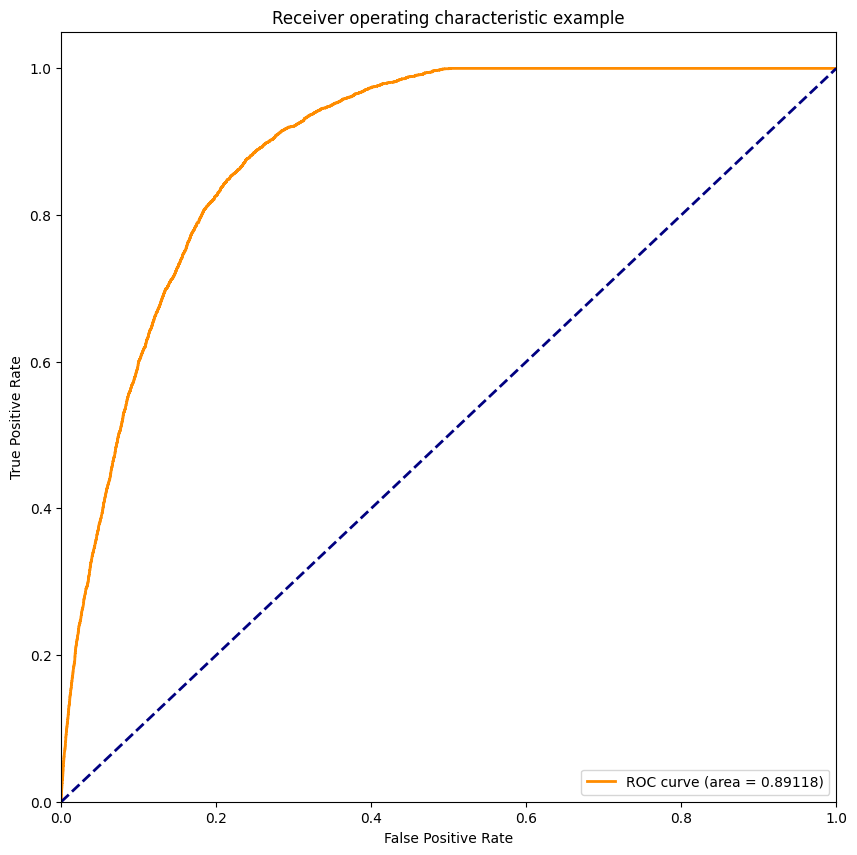

In [ ]:
# Plot ROC curve

fpr, tpr, thresholds = roc_curve(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic example')

plt.legend(loc="lower right")

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Gain', ylabel='Features'>

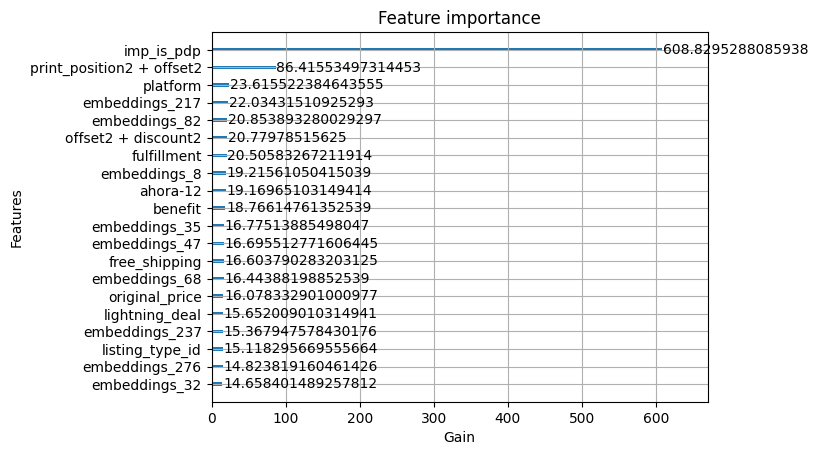

In [ ]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="gain", xlabel="Gain")

<Axes: title={'center': 'Feature importance'}, xlabel='Cover', ylabel='Features'>

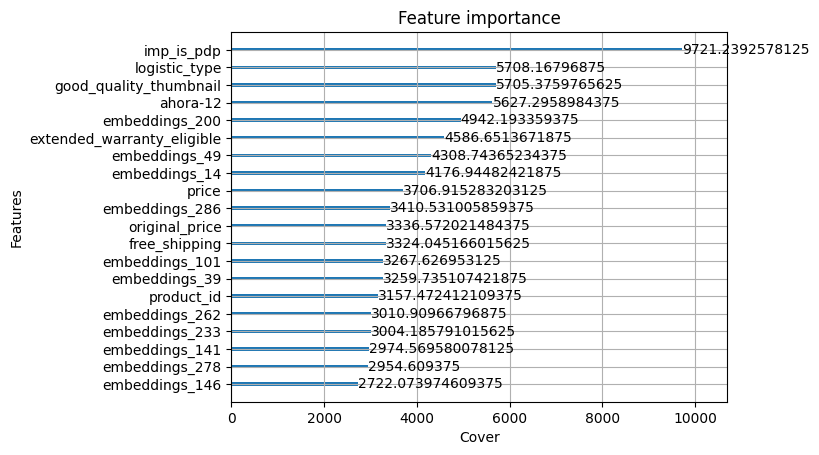

In [ ]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="cover", xlabel="Cover")

#### Feature Importance

In [ ]:
# # Get Feature Importance from the classifier xgb1_model
feature_importances = pd.DataFrame(
    xgb1_model.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(20)

,importance
imp_is_pdp,0.170219
print_position2 + offset2,0.024160
platform,0.006603
embeddings_217,0.006160
embeddings_82,0.005830
offset2 + discount2,0.005810
fulfillment,0.005733
embeddings_8,0.005372
ahora-12,0.005360
benefit,0.005247


In [ ]:
# # Add gain column
gains = sorted(xgb1_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)

gains_pd = pd.DataFrame(gains, columns=["feature", "gain"]).set_index("feature").sort_values("gain", ascending=False)

gains_pd.head(20)

,gain
feature,
imp_is_pdp,608.829529
print_position2 + offset2,86.415535
platform,23.615522
embeddings_217,22.034315
embeddings_82,20.853893
offset2 + discount2,20.779785
fulfillment,20.505833
embeddings_8,19.215611
ahora-12,19.169651


In [ ]:
feature_importances.head(20)

,importance
imp_is_pdp,0.170219
print_position2 + offset2,0.024160
platform,0.006603
embeddings_217,0.006160
embeddings_82,0.005830
offset2 + discount2,0.005810
fulfillment,0.005733
embeddings_8,0.005372
ahora-12,0.005360
benefit,0.005247


In [ ]:
xgb_emb_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    eval_metric = 'auc',
    n_jobs=-1,
)

emb_train_cols = ["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]

xgb_emb_model.fit(X_train_sub[emb_train_cols], y_train_sub, eval_set=[(X_val[emb_train_cols], y_val)], verbose=20)

notify("XGB_EMB", "Done")

roc_auc_score(y_test, xgb_emb_model.predict_proba(X_test[emb_train_cols])[:, xgb_emb_model.classes_ == 1])

# Embedding Component Importance 
# Get Feature Importance from the classifier xgb_emb_model

feature_importances_emb = pd.DataFrame(
    xgb_emb_model.feature_importances_,
    index = X_train_sub[emb_train_cols].columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances_emb.head(20)

[0]	validation_0-auc:0.64019
[20]	validation_0-auc:0.74116
[40]	validation_0-auc:0.74620
[60]	validation_0-auc:0.74872
[80]	validation_0-auc:0.75016
[99]	validation_0-auc:0.75028


,importance
embeddings_258,0.017875
embeddings_38,0.011798
embeddings_147,0.009613
embeddings_20,0.009271
embeddings_97,0.008734
embeddings_63,0.008565
embeddings_70,0.008415
embeddings_145,0.008392
embeddings_122,0.008137
embeddings_239,0.008096


Text(0.5, 0, 'embeddings_38')

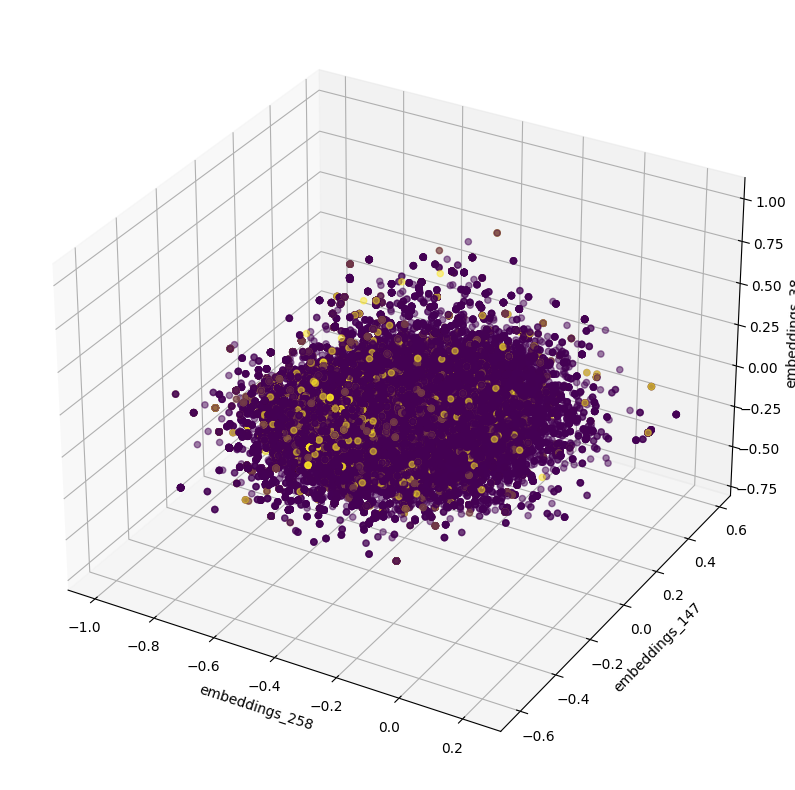

In [ ]:
# Plot Embeddings 217, 82, 8 in 3d

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_train["embeddings_258"],
    X_train["embeddings_147"],
    X_train["embeddings_38"],
    c=y_train,
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("embeddings_258")
ax.set_ylabel("embeddings_147")
ax.set_zlabel("embeddings_38")

In [ ]:
import pacmap

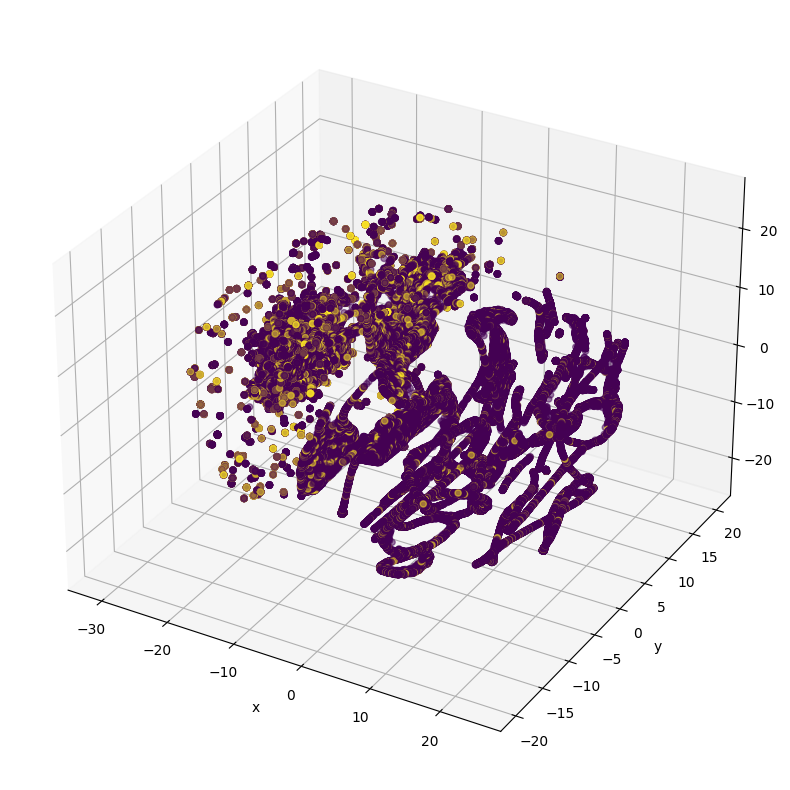

In [ ]:
top_attrs = feature_importances.head(100).index

for attr in top_attrs:
    # if X_train[attr] has more than 0/1 values
    if len(X_train[attr].value_counts()) <= 2:
        top_attrs = top_attrs.drop(attr)


embs = pacmap.PaCMAP(
        n_components = 3,
        n_neighbors = 10,
        MN_ratio=0.5,
        FP_ratio=2.0,
    ).fit_transform(
        SimpleImputer(strategy="median").fit_transform(
                X_train[top_attrs].values
            )
        )

# plt.figure(figsize = (10, 5))
# plt.scatter(embs[:, 0],
#             embs[:, 1],
#             s = 30,
#             c = y_train,
#             alpha = 0.5)
# plt.show()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    embs[:, 0],
    embs[:, 1],
    embs[:, 2],
    c=y_train,
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

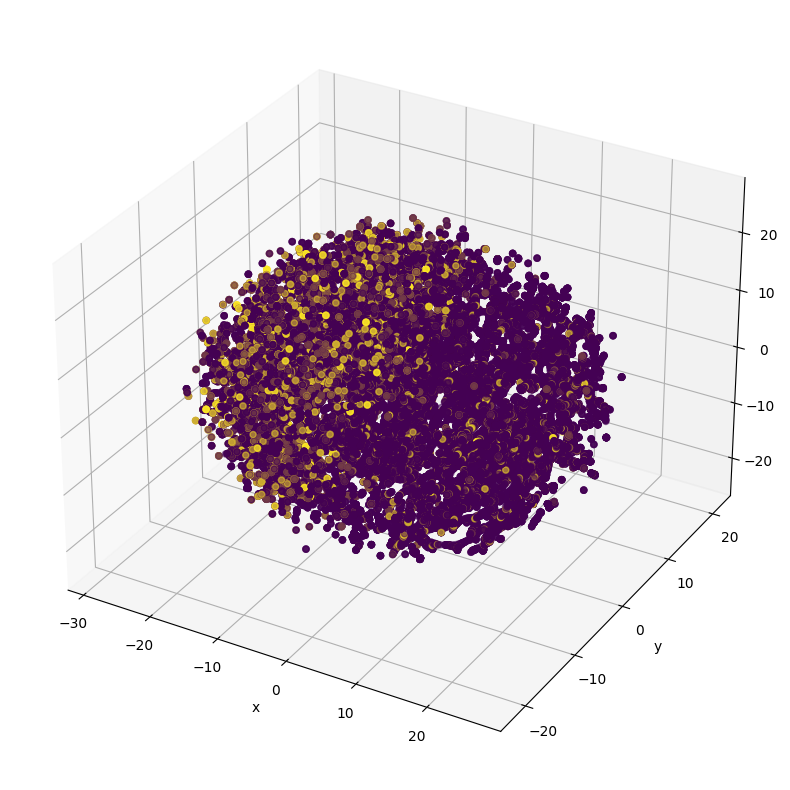

In [ ]:
# plt.figure(figsize = (10, 5))
# plt.scatter(embs[:, 0],
#             embs[:, 1],
#             s = 30,
#             c = y_train,
#             alpha = 0.5)
# plt.show()

# 3D plot

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    embs[:, 0],
    embs[:, 1],
    embs[:, 2],
    c=y_train,
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

### Train XGBoost Model (Top 20 Gain params) with Cross Validation

In [ ]:
# xgb2_model = xgb.XGBClassifier(
#     objective = 'binary:logistic',
#     seed = random_state,
#     n_jobs=-1,
# )

# reduced_cols = gains_pd.head(20).index

# xgb2_model.fit(X_train, y_train)

In [ ]:
# roc_auc_score(y_test, xgb2_model.predict_proba(X_test)[:, xgb2_model.classes_ == 1])

In [ ]:
# covers = sorted(xgb1_model.get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
# covers_pd = pd.DataFrame(covers, columns=["feature", "cover"]).set_index("feature").sort_values("cover", ascending=False)


# xgb_model_covers = xgb.XGBClassifier(
#     objective = 'binary:logistic',
#     seed = random_state,
#     n_jobs=-1,
# )

# reduced_cols = covers_pd.head(20).index

# xgb_model_covers.fit(X_train[reduced_cols], y_train)

# roc_auc_score(y_test, xgb_model_covers.predict_proba(X_test[reduced_cols])[:, xgb_model_covers.classes_ == 1])

#### ROC AUC

In [ ]:
# roc_auc_score(y_test, xgb2_model.predict_proba(X_test)[:, xgb2_model.classes_ == 1])

#### Feature Importance

In [ ]:
# Feature Importance
# xgb.plot_importance(xgb2_model, max_num_features=20, importance_type="gain", xlabel="Gain")

In [ ]:
# # Feature Importance
# fig, ax = plt.subplots(figsize=(5, 20))

# xgb.plot_importance(xgb2_model, max_num_features=100, importance_type="gain", xlabel="Gain", ax=ax)

## Retrain Model with Validation Data

In [ ]:
# del comp_data
# del full_data
# gc.collect()

In [34]:
# params = {'colsample_bytree': 0.9958188825321641, 'gamma': 0.9488078042954764, 'learning_rate': 0.07108927605766976, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 4, 'subsample': 0.8232243201689888}
xgb4_model = xgb.XGBClassifier(
        # **params,
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
        verbosity=1,
)

xgb4_model.fit(X_train, y_train)

score = roc_auc_score(y_test, xgb4_model.predict_proba(X_test)[:, xgb4_model.classes_ == 1])

notify("XGB4", "Done. Score: {}".format(score))

create_submission_file(xgb4_model,
                       xgb4_model.get_booster().feature_names,
                       "outputs/xgb_polyfeat_w2v_smallohe: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

0.8981698903861902

#### ROC AUC on X_test

In [ ]:
# roc_auc_score(y_test, xgb4_model.predict_proba(X_test)[:, xgb4_model.classes_ == 1])

#### ROC AUC on Balanced X_test (Subsampled X_test for conversion == 0)

In [ ]:
new_X_test = new_test_data.drop(columns=["conversion", "ROW_ID"])
new_X_test = new_X_test.select_dtypes(include='number')

new_y_test = new_test_data["conversion"]

# roc_auc_score(new_y_test, xgb2_model.predict_proba(new_X_test)[:, xgb2_model.classes_ == 1])

#### Confusion Matrix

In [ ]:
# # Confusion Matrix for xgb2_model on new_test_data

# conf_mx = confusion_matrix(new_y_test, xgb2_model.predict(new_X_test))

# true_neg, false_pos, false_neg, true_pos = conf_mx.ravel()

# true_neg, false_pos, false_neg, true_pos

In [ ]:
""" xgb3_model = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    )
)

xgb3_model.fit(X_train, y_train)

roc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) """

' xgb3_model = make_pipeline(\n    SimpleImputer(strategy="median"),\n    xgb.XGBClassifier(\n        objective = \'binary:logistic\',\n        seed = random_state,\n        n_jobs=-1,\n    )\n)\n\nxgb3_model.fit(X_train, y_train)\n\nroc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) '

### Random Forest

In [ ]:
rfc = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier()
)

# rfc.fit(X_train, y_train)

# roc_auc_score(y_test, rfc.predict_proba(X_test)[:, rfc.classes_ == 1])

### Voting Classifier (XGBoost + Random Forest)

In [ ]:
voting_rfc_xgb = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb4_model)
    ],
    voting="soft",
    n_jobs=-1
)

# voting_rfc_xgb.fit(X_train, y_train)

# roc_auc_score(y_test, voting_rfc_xgb.predict_proba(X_test)[:, voting_rfc_xgb.classes_ == 1])

### GradientBoostingClassifier

In [ ]:
gbc = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(verbose=2)
)

# gbc.fit(X_train, y_train)

# score = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, gbc.classes_ == 1])

# notify("GBC", "Done. Score: {}".format(score))

# score

### HistGradientBoostingClassifier

In [ ]:
hgb = HistGradientBoostingClassifier(verbose=2)

# hgb.fit(X_train, y_train)

# score = roc_auc_score(y_test, hgb.predict_proba(X_test)[:, hgb.classes_ == 1])

# notify("HGB", "Done. Score: {}".format(score))

# score

### AdaBoostClassifier

In [ ]:
abc = make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier()
)

# abc.fit(X_train, y_train)

# score = roc_auc_score(y_test, abc.predict_proba(X_test)[:, abc.classes_ == 1])

# notify("ABC", "Done. Score: {}".format(score))

# score

### ExtraTreesClassifier

In [ ]:
etc = make_pipeline(
    SimpleImputer(strategy="median"),
    ExtraTreesClassifier()
)

# etc.fit(X_train, y_train)

# score = roc_auc_score(y_test, etc.predict_proba(X_test)[:, etc.classes_ == 1])

# notify("ETC", "Done. Score: {}".format(score))

# score

### Voting Classifier Alt

In [ ]:
voting_alt = VotingClassifier(
    estimators=[
        # ("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    voting="soft",
    n_jobs=-1,
)

# voting_alt.fit(X_train, y_train)

# score = roc_auc_score(y_test, voting_alt.predict_proba(X_test)[:, voting_alt.classes_ == 1])

# notify("Voting Alt", "Done. Score: {}".format(score))

# create_submission_file(voting_alt,
#                        xgb4_model.get_booster().feature_names, 
#                        "outputs/submission_voting(rfc, xgb, hgb, abc): {:.5f}.csv".format(score)
# )

# score

In [ ]:
voting_alt

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('hgb', HistGradientBoostingClassifier(verbose=2)),
                             ('abc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('adaboostclassifier',
                                               AdaBoostClassifier())]))],
                 n_jobs=-1, voting='soft')

### Average Classifier

In [ ]:
# average classifier
from sklearn.utils._pprint import _EstimatorPrettyPrinter

class AverageClassifier:
    def __init__(self, models):
        self.models = models
        self.classes_ = models[0].classes_

    def predict_proba(self, X):
        return np.mean([model.predict_proba(X) for model in self.models], axis=0)

    def predict(self, X):
        return np.mean([model.predict(X) for model in self.models], axis=0)

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def __repr__(self, N_CHAR_MAX=700):
        # N_CHAR_MAX is the (approximate) maximum number of non-blank
        # characters to render. We pass it as an optional parameter to ease
        # the tests.

        # Using _EstimatorPrettyPrinter

        pp = _EstimatorPrettyPrinter(
            compact=True,
            indent=1,
            indent_at_name=True,
            n_max_elements_to_show=N_MAX_ELEMENTS_TO_SHOW,
        )

        repr_ = pp.pformat(self)

        return repr_
        


# average_classifier = AverageClassifier(
#     [
#         #rfc,
#         xgb4_model,
#         hgb,
#         abc,
#         #voting_alt
#     ]
# )

# # average_classifier.fit(X_train, y_train)

# score = roc_auc_score(y_test, average_classifier.predict_proba(X_test)[:, average_classifier.classes_ == 1])

# notify("AVG", "Done. Score: {}".format(score))

# create_submission_file(average_classifier, 
#                        xgb4_model.get_booster().feature_names, 
#                        "outputs/submission_avg(xgb, hgb, abc): {:.5f}.csv".format(score)
# )

# score

### Stacking Classifier

In [ ]:
# Stacking Classifier

stacking_classifier = StackingClassifier(
    estimators=[
        #("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        #("abc", abc),
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier.fit(X_train, y_train)

score = roc_auc_score(y_test, stacking_classifier.predict_proba(X_test)[:, stacking_classifier.classes_ == 1])

notify("STACK", "Done. Score: {}".format(score))

create_submission_file(stacking_classifier,
                       xgb4_model.get_booster().feature_names, 
                       "outputs/submission_stack(xgb, hgb, abc)_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

Binning 0.361 GB of training data: 8.712 s
Binning 0.040 GB of validation data: 0.320 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.29013, val loss: 0.29071, in 0.197s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27738, val loss: 0.27830, in 0.174s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26766, val loss: 0.26888, in 0.180s
[4/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.25990, val loss: 0.26115, in 0.170s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.25352, val loss: 0.25498, in 0.173s
[6/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24813, val loss: 0.24990, in 0.191s
[7/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24335, val loss: 0.24561, in 0.163s
[8/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.23914, val loss: 0.24181, in 0.166s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23548, val loss: 0.23832, in 0.163s
[10/100] 1 tree, 31 leaves, max depth = 12, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Binning 0.289 GB of training data: Binning 0.289 GB of training data: Binning 0.289 GB of training data: Binning 0.289 GB of training data: Binning 0.289 GB of training data: 16.437 s
Binning 0.032 GB of validation data: 16.776 s
Binning 0.032 GB of validation data: 16.552 s
Binning 0.032 GB of validation data: 17.188 s
Binning 0.032 GB of validation data: 17.423 s
Binning 0.032 GB of validation data: 1.132 s
0.833 s
Fitting gradient boosted rounds:
[1/100] Fitting gradient boosted rounds:
[1/100] 0.884 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.28985, val loss: 0.29115, in 0.572s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.29024, val loss: 0.29094, in 0.596s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.28997, val loss: 0.29130, in 0.526s
[2/100] 1.087 s
Fitting gradient boosted rounds:
[1/100] 1.173 s
1 tree, 31 leaves, max depth = 11, train loss: 0.27692, val loss: 0.27940, in 0.466s
[3/100] Fitting gradient bo

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   54.1s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   54.5s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  6.0min remaining:  9.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  6.1min finished


0.8980796621150097

In [ ]:
stacking_classifier

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('hgb',
                                HistGradientBoostingClassifier(verbose=2))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   stack_method='predict_proba', verbose=2)

In [ ]:
# Stacking Classifier

# ideas for final_estimator
# - LogisticRegression
# - XGBClassifier
# - RandomForestClassifier
# - GradientBoostingClassifier


stacking_classifier_2 = StackingClassifier(
    estimators=[
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    final_estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier_2.fit(X_train, y_train)

score = roc_auc_score(y_test, stacking_classifier_2.predict_proba(X_test)[:, stacking_classifier_2.classes_ == 1])

notify("STACK2", "Done. Score: {}".format(score))

create_submission_file(stacking_classifier_2,
                          xgb4_model.get_booster().feature_names,
                            "outputs/submission_stack2(xgb, hgb, abc)_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

Binning 0.361 GB of training data: 9.516 s
Binning 0.040 GB of validation data: 0.333 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.29008, val loss: 0.29037, in 0.205s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27728, val loss: 0.27811, in 0.191s
[3/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.26757, val loss: 0.26879, in 0.189s
[4/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.25979, val loss: 0.26128, in 0.207s
[5/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.25337, val loss: 0.25507, in 0.191s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.24798, val loss: 0.25017, in 0.179s
[7/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.24326, val loss: 0.24575, in 0.168s
[8/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23908, val loss: 0.24188, in 0.173s
[9/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.23549, val loss: 0.23866, in 0.170s
[10/100] 1 tree, 31 leaves, max depth = 9, t

KeyboardInterrupt: 

In [ ]:
# average_classifier2 = AverageClassifier([voting_alt, stacking_classifier])

# # average_classifier.fit(X_train, y_train)

# roc_auc_score(y_test, average_classifier2.predict_proba(X_test)[:, average_classifier2.classes_ == 1])

### Logistic Regression

In [ ]:
# # Logistic Regression

# logistic_regression = make_pipeline(
#     SimpleImputer(strategy="median"),
#     LogisticRegression(
#         n_jobs=-1
#     )
# )

# best_score = 0
# best_cut = 0
# for i in range(1, 20):

#     logistic_regression.fit(X_train[reduced_cols[:i]], y_train)

#     score = roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:i]])[:, logistic_regression.classes_ == 1])

#     print(i, score)

#     if score > best_score:
#         best_score = score
#         best_cut = i

# best_score, best_cut

In [ ]:
# logistic_regression = make_pipeline(
#     SimpleImputer(strategy="median"),
#     PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
#     LogisticRegression(
#         n_jobs=-1,
#         max_iter=1000
#     )
# )

# logistic_regression.fit(X_train[reduced_cols[:3]], y_train)

# roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:3]])[:, logistic_regression.classes_ == 1])

In [ ]:
# bagging_classifier_rfc = make_pipeline(
#     SimpleImputer(strategy="median"),
#     BaggingClassifier(
#         base_estimator=RandomForestClassifier(),
#         n_estimators=10,
#         n_jobs=-1
#     )
# )

# bagging_classifier_rfc.fit(X_train, y_train)

# roc_auc_score(y_test, bagging_classifier_rfc.predict_proba(X_test)[:, bagging_classifier_rfc.classes_ == 1])

In [ ]:
# bagging_classifier_logistic = BaggingClassifier(
#     estimator=LogisticRegression(
#         n_jobs=-1,
#         max_iter=1000
#     ),
#     n_estimators=10,
#     n_jobs=-1
# )

# bagging_classifier_logistic.fit(X_train[reduced_cols[:best_cut]], y_train)

# roc_auc_score(y_test, bagging_classifier_logistic.predict_proba(X_test[reduced_cols[:best_cut]])[:, bagging_classifier_logistic.classes_ == 1])

In [35]:
bagging_classifier_xgb = BaggingClassifier(
    estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_estimators=10,
    n_jobs=-1,
    verbose=20,
)

bagging_classifier_xgb.fit(X_train, y_train)

score = roc_auc_score(y_test, bagging_classifier_xgb.predict_proba(X_test)[:, bagging_classifier_xgb.classes_ == 1])

notify("BAGGING XGB", "Done. Score: {}".format(score))

create_submission_file(bagging_classifier_xgb,
                          bagging_classifier_xgb.get_booster().feature_names,
                            "outputs/submission_bagging_xgb_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed: 17.5min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed: 17.6min remaining: 52.9min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed: 17.6min remaining: 29.4min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed: 17.6min remaining: 17.6min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed: 17.7min remaining: 10.6min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed: 17.7min remaining:  5.9min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 24.0min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed: 24.0min finished
/Users/nacho/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.7s remaining:    5.0s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.6s remaining:    4.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.6s remaining:    2.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.6s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.6s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out 

0.9015660988341951

In [ ]:

create_submission_file(bagging_classifier_xgb,
                          bagging_classifier_xgb.get_booster().feature_names,
                            "outputs/submission_bagging_xgb_polyfeat: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

In [ ]:
# stacking_classifier_2 = StackingClassifier(
#     estimators=[
#         ("rfc", rfc),
#         ("xgb", xgb4_model),
#         ("hgb", hgb),
#         ("abc", abc),
#         ("bg_xgb", bagging_classifier_xgb),
#     ],
#     final_estimator=LogisticRegression(),
#     n_jobs=-1
# )

# stacking_classifier_2.fit(X_train, y_train)

# roc_auc_score(y_test, stacking_classifier_2.predict_proba(X_test)[:, stacking_classifier_2.classes_ == 1])

In [ ]:
# voting_alt_2 = VotingClassifier(
#     estimators=[
#         ("rfc", rfc),
#         ("xgb", xgb4_model),
#         ("hgb", hgb),
#         ("abc", abc),
#         ("bg_xgb", bagging_classifier_xgb),
#     ],
#     voting="soft",
#     n_jobs=-1
# )

# voting_alt_2.fit(X_train, y_train)

# roc_auc_score(y_test, voting_alt_2.predict_proba(X_test)[:, voting_alt_2.classes_ == 1])

In [ ]:
# average_classifier_3 = AverageClassifier([voting_alt_2, stacking_classifier_2])

# average_classifier_3.fit(X_train, y_train)

# roc_auc_score(y_test, average_classifier_3.predict_proba(X_test)[:, average_classifier_3.classes_ == 1])

In [ ]:
y_train[y_train == True].shape[0], y_train[y_train == False].shape[0]

(12555, 123015)

#### ROC AUC Curves

In [ ]:
models = [
    #(logistic_regression, "logistic_regression"),
    (rfc, "RandomForestClassifier"),
    (xgb1_model, "xgb1_model"),
    (xgb2_model, "xgb2_model"),
    (xgb4_model, "xgb4_model"), 
    (voting_rfc_xgb, "voting_rfc_xgb"), 
    #(gbc, "gbc"), 
    (hgb, "hgb"),
    (abc, "abc"), 
    # (etc, "etc"), 
    (voting_alt, "voting_alt"),
    # (voting_alt_2, "voting_alt_2"),
    (stacking_classifier, "stacking_classifier"),
    # (stacking_classifier_2, "stacking_classifier_2"),
    (average_classifier, "average_classifier"),
    (average_classifier2, "average_classifier2"),
    # (average_classifier_3, "average_classifier_3"),
    # (bagging_classifier_rfc, "bagging_classifier_rfc"),
    # (bagging_classifier_logistic, "bagging_classifier_logistic"),
    (bagging_classifier_xgb, "bagging_classifier_xgb"),
]

model_names = [model[1] for model in models]
models = [model[0] for model in models]

fig, ax = plt.subplots(figsize=(10, 10))

# plot_roc_curves(models, model_names, new_X_test, new_y_test, ax=ax)
plot_roc_curves(models, model_names, X_test, y_test, ax=ax)

fig.tight_layout()

NameError: name 'xgb2_model' is not defined

## Hyperopt for XGBoost Model

In [36]:
# RandomizedSearchCV for XGBClassifier

xgb_randomized_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    param_distributions={
        "n_estimators": [25, 50, 75, 100, 250, 500],
        "max_depth": [5, 10, 15, 30, 50],
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
        "gamma": [0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "min_child_weight": [0, 1, 2, 3, 4, 5, 6],
        "subsample": [0.5, 0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9],
    },
    n_iter=100,
    scoring="roc_auc",
    n_jobs=-1,
    cv=[([t for t in range(int(X_train.shape[0] * 0.8))], [t for t in range(int(X_train.shape[0] * 0.8), X_train.shape[0])])],
    verbose=20
)

xgb_randomized_search.fit(X_train, y_train)

# xgb_randomized_search.best_params_, xgb_randomized_search.best_score_, xgb_randomized_search.best_estimator_

model = xgb_randomized_search.best_estimator_

model.fit(X_train, y_train)

score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

notify("XGB_RAND", "Done. Score: {}".format(score))

create_submission_file(model,
                          model.get_booster().feature_names,
                          "outputs/xgb_rand: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    ) 

score

Fitting 1 folds for each of 100 candidates, totalling 100 fits
[CV 1/1; 1/100] START colsample_bytree=0.5, gamma=0, learning_rate=0.2, max_depth=10, min_child_weight=4, n_estimators=25, subsample=0.8
[CV 1/1; 2/100] START colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=50, min_child_weight=5, n_estimators=75, subsample=0.5
[CV 1/1; 3/100] START colsample_bytree=0.8, gamma=0.3, learning_rate=0.1, max_depth=30, min_child_weight=2, n_estimators=500, subsample=0.8
[CV 1/1; 4/100] START colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=30, min_child_weight=6, n_estimators=250, subsample=0.8
[CV 1/1; 5/100] START colsample_bytree=0.6, gamma=0.4, learning_rate=0.01, max_depth=5, min_child_weight=6, n_estimators=100, subsample=0.5
[CV 1/1; 6/100] START colsample_bytree=0.9, gamma=0, learning_rate=0.001, max_depth=5, min_child_weight=1, n_estimators=50, subsample=0.6
[CV 1/1; 7/100] START colsample_bytree=0.9, gamma=0.1, learning_rate=0.2, max_depth=15, min_child_wei

In [ ]:
# XGBoost with Hyperopt
if hp_tune:

    xgb_space = {
        "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "gamma": hp.uniform("gamma", 0, 1),
        "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
        "subsample": hp.uniform("subsample", 0.5, 1),
    }

    best_score = 0
    def objective_xgb(params):
        global best_score

        model = xgb.XGBClassifier(
            **params,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            #eval_metric = 'auc',
        )
        
        score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

        #model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=0)
        #model.fit(X_train, y_train)
        #score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

        # print(f"Score: {score}", params)

        # if score > best_score:
        #     best_score = score
        #     print(f"New best score: {best_score}")
        #     print(params)
            
        return {"loss": 1 - score, "status": STATUS_OK}

    trials_xgb = Trials()

    best_xgb = fmin(
        fn=objective_xgb,
        space=xgb_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_xgb,
        verbose=2,
    )

    print(best_xgb)

In [ ]:
p = {'colsample_bytree': 0.5261530316412195, 'gamma': 0.4666423706737293, 'learning_rate': 0.043284110571295886, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 4, 'subsample': 0.8142370483321494}
model = xgb.XGBClassifier(
    **p,
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
    #eval_metric = 'auc',
)

#score = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc").mean()

model.fit(X_train, y_train)
roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

## Create Submission

In [ ]:
full_data["is_discount"].value_counts()

In [ ]:
# final_classifier = AverageClassifier([voting_alt_2, stacking_classifier_2])

final_classifier = AverageClassifier([voting_alt, stacking_classifier, bagging_classifier_xgb])

X_full = full_data.drop(columns=["conversion", "ROW_ID"])
X_full = X_full.select_dtypes(include='number')

y_full = full_data["conversion"]

final_classifier.fit(X_full, y_full)

# Should be 1, full_data contains test_data 
roc_auc_score(y_test, final_classifier.predict_proba(X_test)[:, final_classifier.classes_ == 1])

In [ ]:
X_test.columns

In [ ]:
roc_auc_score(y_full, final_classifier.predict_proba(X_full)[:, final_classifier.classes_ == 1])

In [ ]:
from sklearn.utils._pprint import _EstimatorPrettyPrinter

In [ ]:
import sklearn

In [ ]:
names_dif = set(X_full.columns)

for model in models:
    # if Pipeline, get last step
    if isinstance(model, sklearn.pipeline.Pipeline):
        model = model.steps[-1][1]
    
    # print feature names
    if isinstance(model, xgb.XGBClassifier):
        print(model.get_booster().feature_names)
    elif isinstance(model, VotingClassifier):
        for estimator in model.estimators_:
            if isinstance(estimator, sklearn.pipeline.Pipeline):
                estimator = estimator.steps[-1][1]
            print(estimator)
            if isinstance(estimator, xgb.XGBClassifier):
                print(estimator.get_booster().feature_names)
            #elif isinstance(estimator, HistGradientBoostingClassifier):
             #   print(estimator.feature_names_)
            #elif isinstance(estimator, GradientBoostingClassifier):
             #   print(estimator.feature_names_)
    elif isinstance(model, StackingClassifier):
        for estimator in model.estimators_:
            if isinstance(estimator, sklearn.pipeline.Pipeline):
                estimator = estimator.steps[-1][1]
            print(estimator)
            if isinstance(estimator, xgb.XGBClassifier):
                print(estimator.get_booster().feature_names)
            #elif isinstance(estimator, HistGradientBoostingClassifier):
             #   print(estimator.feature_names_)
            #elif isinstance(estimator, GradientBoostingClassifier):
              #  print(estimator.feature_names_)
    #elif isinstance(model, BaggingClassifier):
    #    print(model.base_estimator_.get_booster().feature_names)
    elif isinstance(model, HistGradientBoostingClassifier):
        #print(model.feature_names_)
        pass
    elif isinstance(model, GradientBoostingClassifier):
        # print(model.feature_names_)
        pass
    elif isinstance(model, RandomForestClassifier):
       pass



In [ ]:
feature_cols = xgb4_model.get_booster().feature_names

In [ ]:
create_submission_file(final_classifier, feature_cols, "outputs/submission_avg(bagging(xgb), voting(xgb, hgb, abc), stacking(xgb, hgb, abc)): {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

#del eval_data
#del submission_df
#gc.collect()

In [ ]:
# # Save model
# import pickle

# pickle.dump(final_classifier, open("los_simuladores_avg(stack(bagging_classifier_xgb(xgb), xgb, hgb, abc), voting(xgb, hgb, abc))_full_data.pkl", "wb"))